# **Goal: Recommendation System / Next Best Action**

## **Context**
We have a **random extraction** of a (real world) dataset containing **customers of a large wealth management company**.  

The data is **anonymous, mostly clean, and NOT always normalized/scaled**.  

Our objective is to **estimate investment needs** for these customers using **Data Science techniques**.

### **Why Estimate Investment Needs?**
Identifying customer needs is useful for several reasons, including:

* **Recommender Systems / Next Best Action:**  
  * Needs can serve as **key inputs** for **content-based** or **knowledge-based filtering algorithms**, that allows for personalized services.  
  * This is our **primary focus** in this notebook, i.e., "Know Your Client (KYC)".  

* **Product Targeting & Governance (Regulatory Compliance - MIFID/IDD in EU):**  
  * Regulatory standards require that **customer needs match the investment products offered**. So financial institutions must estimate customer needs.
  * This is essentially an **"institutional view"** of a recommendation system...

<br>

---

## **Dataset Overview**
The dataset, named **"Needs"**, is stored in an **Excel file called Dataset2_Needs.xls**.  
It contains several **potentially relevant features** along with two **target variables**, i.e:

* **AccumulationInvestment**  
  * Indicates a customer preference for **accumulation investing**, typically through **dollar-cost averaging** (i.e., investing small amounts at regular intervals over time, say on a monthly basis).  
  * **Binary (Boolean) response:**  
    * `1 = High propensity`.  
    * `0 = Low propensity`.

- **IncomeInvestment**  
  - Indicates a customer preference for **income investing**, typically through **lump-sum investing** (i.e., one-shot investments).  This is because anyone who aspires to obtain income from coupons and dividends must necessarily already have accumulated capital - a typical need of people who are older than their previous need.
  - **Binary (Boolean) response:**  
    - `1 = High propensity`.  
    - `0 = Low propensity`.  

    **Where do these two response variables come from?** From a **revealed preference scheme**: if the client has an advisor who is considered professionally reliable (this eliminates the possibility of conflict of interest) and has purchased a product that satisfies that need, and the client has also purchased it, we can say with good probability that the advisor has identified the need correctly and the client has that need. In other respects, the machine learning model we are building is a clone of the financial advisor.

<br>

Additionally, we have a **second dataset**, **"Products"**, containing investment products (funds, segregated accounts, unit-linked policies), along with:

* **Product Type:**  
  * `1 = Accumulation` (that is, a product that is good for those who have a high need for accumulation investments)
  * `0 = Income`  (that is, a product that is good for those who have a high need for income investments)

* **Risk Level:**  
  * A **normalized risk score** in the range **$[0,1]$**.  
  * This usually represents the normalized value in $[0, 1]$ of the **[Synthetic Risk and Reward Indicator (SRRI)](https://www.esma.europa.eu/sites/default/files/library/2015/11/10_673.pdf)** of the product, an ordinal variable defined in the range ${1, 7}$ starting from continuous data.

<br>

---

## **Recommendation System Approach**
The recommendation system consists of **two key steps**:

1. **Identifying customers with high investment propensity:**  
   - Using **machine learning models**, we aim to classify customers based on **AccumulationInvestment** (`1 = High propensity`) and/or **IncomeInvestment** (`1 = High propensity`).  

2. **Recommending the most suitable product for each customer:**  
   - For each customer, we match the **most appropriate product** based on:  
     - **Investment need** (Accumulation or Income).  
     - **Risk compatibility** (matching product risk level with the customer profile).  
   - This **personalized recommendation** represents the **Next Best Action** for each client.

<br>


# **Data Ingestion and Exploration**

Let's display our variables to better understand the data structure and characteristics of the dataset.

<br>

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load each sheet into separate DataFrames
# Define the file path
file_path = 'Dataset2_Needs_fixed.xlsx'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

In [3]:
# Let's see the actual variables names in metadata_df
print("Metadata DataFrame columns:")
print(metadata_df.columns.tolist())

# Let's peek at the first few rows
print("\nFirst few rows of metadata:")
print(metadata_df.head())


Metadata DataFrame columns:
['Metadata', 'Unnamed: 1']

First few rows of metadata:
        Metadata                     Unnamed: 1
0        Clients                            NaN
1             ID                   Numerical ID
2            Age                  Age, in years
3         Gender  Gender (Female = 1, Male = 0)
4  FamilyMembers           Number of components


# Statistical Profiling

This section provides an in-depth statistical analysis of our dataset to better understand the underlying patterns, distributions, and potential data quality issues before model development.

The analysis below includes:

- **Comprehensive Summary Statistics**: Computing key statistical measures for all features (mean, median, variance, etc.)
- **Distribution Analysis**: Examining skewness, kurtosis, and outliers across all numerical variables
- **Data Quality Assessment**: Identifying missing values and duplicates 
- **Target Variable Analysis**: Understanding the distribution of our investment need prediction targets

These insights will guide our feature engineering and modeling strategies, helping us identify which variables might be most predictive and which might require transformation or special handling.

In [4]:
# Fix compatibility issue between newer matplotlib and pandas
import matplotlib as mpl
if hasattr(mpl, 'colormaps') and not hasattr(mpl.colormaps, 'get_cmap'):
    def get_cmap(name):
        return mpl.colormaps[name]
    mpl.colormaps.get_cmap = get_cmap

# Drop ID column and create comprehensive summary
needs_df_no_id = needs_df.drop('ID', axis=1)

# Create enhanced summary statistics
def get_statistics(series):
    stats = {
        'Count': len(series),
        'Unique Values': series.nunique(),
        'Missing Values': series.isnull().sum(),
        'Mean': series.mean(),
        'Median': series.median(),
        'Mode': series.mode().iloc[0] if not series.mode().empty else None,
        'Std Dev': series.std(),
        'Variance': series.var(),
        'Min': series.min(),
        '25th Percentile': series.quantile(0.25),
        '75th Percentile': series.quantile(0.75),
        'Max': series.max(),
        'Range': series.max() - series.min(),
        'IQR': series.quantile(0.75) - series.quantile(0.25),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis(),
        'Outliers (IQR)': len(series[((series < (series.quantile(0.25) - 1.5 * (series.quantile(0.75) - series.quantile(0.25)))) | 
                                    (series > (series.quantile(0.75) + 1.5 * (series.quantile(0.75) - series.quantile(0.25)))))]),
        'CV': (series.std() / series.mean()) * 100 if series.mean() != 0 else None
    }
    return stats

# Calculate statistics for each column
summary_data = []
for column in needs_df_no_id.columns:
    stats = get_statistics(needs_df_no_id[column])
    stats['Column'] = column
    summary_data.append(stats)

# Create DataFrame with statistics
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Column')

# Round numeric columns to 2 decimal places
numeric_columns = summary_df.select_dtypes(include=[np.number]).columns
summary_df[numeric_columns] = summary_df[numeric_columns].round(2)

# Display the summary table with styling
styled_summary = summary_df.style\
    .format(precision=2)\
    .background_gradient(cmap='YlOrRd', subset=['Missing Values'])\
    .background_gradient(cmap='YlOrRd', subset=['Skewness'])\
    .background_gradient(cmap='YlOrRd', subset=['Kurtosis'])\
    .background_gradient(cmap='YlOrRd', subset=['Outliers (IQR)'])\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'caption', 'props': [('caption-side', 'top')]}
    ])\
    .set_caption('Enhanced Dataset Summary Statistics (Excluding ID)')

display(styled_summary)

# Print additional insights with better formatting
print("\nKey Insights:")
print("1. Target Variables Distribution:")
income_dist = needs_df_no_id['IncomeInvestment'].value_counts(normalize=True).round(3) * 100
accum_dist = needs_df_no_id['AccumulationInvestment'].value_counts(normalize=True).round(3) * 100
print(f"   - IncomeInvestment:")
print(f"     * Yes: {income_dist[1]:.1f}%")
print(f"     * No:  {income_dist[0]:.1f}%")
print(f"   - AccumulationInvestment:")
print(f"     * Yes: {accum_dist[1]:.1f}%")
print(f"     * No:  {accum_dist[0]:.1f}%")

print("\n2. Feature Characteristics:")
print(f"   - Age Range: {needs_df_no_id['Age'].min()} to {needs_df_no_id['Age'].max()} years")
print(f"   - Wealth Range: {needs_df_no_id['Wealth'].min():.2f} to {needs_df_no_id['Wealth'].max():.2f}")
print(f"   - Family Size: {needs_df_no_id['FamilyMembers'].min()} to {needs_df_no_id['FamilyMembers'].max()} members")

print("\n3. Data Quality:")
print(f"   - Missing Values: {needs_df_no_id.isnull().sum().sum()}")
print(f"   - Duplicate Rows: {needs_df_no_id.duplicated().sum()}")

print("\n4. Distribution Insights:")
for col in needs_df_no_id.select_dtypes(include=[np.number]).columns:
    skew = needs_df_no_id[col].skew()
    kurt = needs_df_no_id[col].kurtosis()
    outliers = summary_df.loc[col, 'Outliers (IQR)']
    print(f"   - {col}:")
    print(f"     * Skewness: {skew:.2f} ({'Right-skewed' if skew > 0 else 'Left-skewed' if skew < 0 else 'Symmetric'})")
    print(f"     * Kurtosis: {kurt:.2f} ({'Heavy-tailed' if kurt > 0 else 'Light-tailed' if kurt < 0 else 'Normal-like'})")
    print(f"     * Outliers: {outliers} ({outliers/len(needs_df_no_id)*100:.1f}% of data)")


Key Insights:
1. Target Variables Distribution:
   - IncomeInvestment:
     * Yes: 38.4%
     * No:  61.6%
   - AccumulationInvestment:
     * Yes: 51.3%
     * No:  48.7%

2. Feature Characteristics:
   - Age Range: 18 to 97 years
   - Wealth Range: 1.06 to 2233.23
   - Family Size: 1 to 5 members

3. Data Quality:
   - Missing Values: 0
   - Duplicate Rows: 0

4. Distribution Insights:
   - Age:
     * Skewness: 0.06 (Right-skewed)
     * Kurtosis: -0.03 (Light-tailed)
     * Outliers: 29 (0.6% of data)
   - Gender:
     * Skewness: 0.03 (Right-skewed)
     * Kurtosis: -2.00 (Light-tailed)
     * Outliers: 0 (0.0% of data)
   - FamilyMembers:
     * Skewness: 0.06 (Right-skewed)
     * Kurtosis: -0.21 (Light-tailed)
     * Outliers: 11 (0.2% of data)
   - FinancialEducation:
     * Skewness: 0.15 (Right-skewed)
     * Kurtosis: -0.42 (Light-tailed)
     * Outliers: 8 (0.2% of data)
   - RiskPropensity:
     * Skewness: 0.33 (Right-skewed)
     * Kurtosis: -0.35 (Light-tailed)
     *

In [5]:
def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }

    # Create a metadata dictionary for easy lookup
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    for col in df.columns:
        stats_dict['Variable'].append(col)
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # Calculate some statistics for each column
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        stats_dict['Missing'].append(df[col].isna().sum())

    return pd.DataFrame(stats_dict)


# Create summary tables
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


NEEDS VARIABLES SUMMARY:



PRODUCTS VARIABLES SUMMARY:


# Feature Engineering and Preprocessing Pipeline

This section implements a comprehensive preprocessing pipeline to transform our raw financial data into model-ready features that can better capture investment needs patterns.

The pipeline includes several key stages:

1. **Baseline Dataset Creation**
   - Creating scaled versions of the original features
   - Implementing log transformations for skewed financial variables

2. **Advanced Feature Engineering**
   - Financial ratios (Wealth-to-Income, Risk Capacity, etc.)
   - Life stage indicators and demographic interactions
   - Risk propensity and financial education composites
   - Retirement readiness metrics
   - Logarithmic transformations for non-linear relationships

3. **Feature Selection**
   - Correlation-based feature elimination
   - Random Forest importance filtering
   - Removal of redundant and low-importance features

4. **Final Scaling and Normalization**
   - Ensuring all features are on comparable scales for modeling

These transformations are particularly important for financial data, where relationships between variables are often non-linear and where derived metrics (like financial ratios) can be more predictive than raw values. The engineered features aim to capture domain-specific financial insights that might better predict investment needs.

In [6]:
# =====================================================================================
# COMPLETE PREPROCESSING PIPELINE WITH IMPROVED FEATURE SELECTION
# =====================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Helper functions for safer operations
def safe_division(a, b, fill_value=0):
    """Safely divide two variables, handling zeros and errors"""
    try:
        result = np.zeros_like(a, dtype=float)
        mask = b != 0
        result[mask] = a[mask] / b[mask]
        result[~mask] = fill_value
        return result
    except:
        return np.full_like(a, fill_value, dtype=float)

def safe_correlation(x, y):
    """Calculate correlation safely handling NaN values"""
    try:
        return x.corr(y)
    except:
        return 0

# =====================================================================================
# 1. BASELINE DATASET SETUP
# =====================================================================================
print("\n1. CREATING BASELINE DATASETS")

# Start with dataset that already has ID removed
baseline_df = needs_df_no_id.copy()
baseline_log_df = needs_df_no_id.copy()

# Log transform highly skewed financial variables
baseline_log_df['Wealth_log'] = np.log1p(baseline_df['Wealth'])
baseline_log_df = baseline_log_df.drop('Wealth', axis=1)

baseline_log_df['Income_log'] = np.log1p(baseline_df['Income'])
baseline_log_df = baseline_log_df.drop('Income', axis=1)

# Scale all numeric features
baseline_scaler = MinMaxScaler()
# Define numeric columns explicitly
baseline_to_scale_columns = [
    'Age', 
    'Wealth', 
    'Income', 
    'FamilyMembers', 
    'Gender'
]

baseline_log_to_scale_columns = [
    'Age',
    'FamilyMembers',
    'Gender',
    'Wealth_log',  # Log-transformed column we created
    'Income_log'   # Log-transformed column we created
]

# Apply scaling only to these specific numeric columns
baseline_df[baseline_to_scale_columns] = baseline_scaler.fit_transform(baseline_df[baseline_to_scale_columns])
baseline_log_df[baseline_log_to_scale_columns] = baseline_scaler.fit_transform(baseline_log_df[baseline_log_to_scale_columns])

# Split into features and targets
baseline_X = baseline_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
baseline_y_income = baseline_df['IncomeInvestment']
baseline_y_accum = baseline_df['AccumulationInvestment']

baseline_log_X = baseline_log_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
baseline_log_y_income = baseline_log_df['IncomeInvestment']
baseline_log_y_accum = baseline_log_df['AccumulationInvestment']

print(f"  - Created baseline_df with {baseline_df.shape[1]} features")
print(f"  - Created baseline_log_df with {baseline_log_df.shape[1]} features")

# =====================================================================================
# 2. FEATURE-ENGINEERED DATASET
# =====================================================================================
print("\n2. CREATING ENGINEERED FEATURES")

# 2.1 CREATE BASE DATASET
# ----------------------
engineered_df = needs_df_no_id.copy()

# Extract target variables
y_income = engineered_df['IncomeInvestment']
y_accum = engineered_df['AccumulationInvestment']

# Add interaction feature if targets are correlated
target_correlation = np.corrcoef(y_income, y_accum)[0, 1]
if abs(target_correlation) > 0.2:
    engineered_df['Combined_Investment_Score'] = y_income + y_accum
    print(f"  - Target correlation: {target_correlation:.2f}, adding Combined_Investment_Score")

# 2.2 CREATE BASIC FINANCIAL RATIO FEATURES
# ----------------------------------------
engineered_df['Wealth_to_Income'] = safe_division(engineered_df['Wealth'], engineered_df['Income'])
engineered_df['Financial_Capacity'] = engineered_df['Income'] + (engineered_df['Wealth'] * 0.05)
engineered_df['Wealth_Per_Family_Size'] = safe_division(engineered_df['Wealth'], engineered_df['FamilyMembers'])
engineered_df['Income_Per_Family_Size'] = safe_division(engineered_df['Income'], engineered_df['FamilyMembers'])

# 2.3 CREATE INTERACTION FEATURES
# -----------------------------
engineered_df['Age_Risk_Interaction'] = engineered_df['Age'] * engineered_df['RiskPropensity']
engineered_df['Education_Risk_Profile'] = engineered_df['FinancialEducation'] * engineered_df['RiskPropensity']
engineered_df['Age_Squared'] = engineered_df['Age'] ** 2
engineered_df['Gender_Age_Risk'] = engineered_df['Gender'] * engineered_df['Age'] * engineered_df['RiskPropensity']

# 2.4 CREATE FINANCIAL INSIGHT FEATURES
# -----------------------------------
# Risk and capacity metrics
engineered_df['Risk_Capacity'] = safe_division(engineered_df['Wealth'], engineered_df['Age'] + 1)
engineered_df['Life_Stage_Adjusted_Income'] = safe_division(engineered_df['Income'], engineered_df['Age'] / 20)
engineered_df['Financial_Sophistication'] = (engineered_df['FinancialEducation'] * 
                                           engineered_df['Wealth_to_Income'] * 
                                           engineered_df['RiskPropensity'])

# Retirement and financial independence metrics
retirement_denominator = ((engineered_df['Income'] * 0.7) * np.maximum(1, 65 - engineered_df['Age']))
engineered_df['Retirement_Readiness'] = safe_division(engineered_df['Wealth'], retirement_denominator)
engineered_df['Financial_Independence_Score'] = safe_division(engineered_df['Wealth'], engineered_df['Income'] * 25)

# Risk and volatility metrics
engineered_df['Wealth_Concentration'] = safe_division(engineered_df['Wealth'], 
                                                      engineered_df['Income'] * engineered_df['Age']/10)
denominator = (engineered_df['FinancialEducation'] * engineered_df['RiskPropensity'])
engineered_df['Financial_Fragility'] = safe_division(engineered_df['Income_Per_Family_Size'], denominator)

# Add retirement age indicator (binary feature)
engineered_df['is_retirement_age'] = (engineered_df['Age'] >= 65).astype(int)

# Add risk tolerance ratio
if 'Financial_Sophistication' in engineered_df.columns and 'Financial_Fragility' in engineered_df.columns:
    engineered_df['risk_tolerance'] = safe_division(engineered_df['Financial_Sophistication'], 
                                                   engineered_df['Financial_Fragility'] + 1e-5)

# Add squared versions of any remaining numeric features
for col in ['FamilyMembers', 'Gender', 'RiskPropensity', 'FinancialEducation']:
    if col in engineered_df.columns:
        engineered_df[f'{col}_Squared'] = engineered_df[col] ** 2

# 2.5 APPLY MATHEMATICAL TRANSFORMATIONS
# -----------------------------------
# Non-linear transformations
engineered_df['Wealth_Sqrt'] = np.sqrt(engineered_df['Wealth'])
engineered_df['Income_Cbrt'] = np.cbrt(engineered_df['Income'])

# Additional composite metrics
engineered_df['Investment_Capacity'] = engineered_df['Income'] * engineered_df['Wealth'] * (1-(engineered_df['FamilyMembers']/6))
engineered_df['Financial_Sophistication_Ratio'] = safe_division(engineered_df['FinancialEducation'], engineered_df['Age'])

# 2.6 APPLY LOG TRANSFORMATIONS TO FINANCIAL VARIABLES
# -------------------------------------------------
financial_vars = [
    # Original variables
    'Wealth', 'Income',
    
    # Financial ratios
    'Wealth_to_Income', 'Financial_Capacity',
    'Wealth_Per_Family_Size', 'Income_Per_Family_Size',
    
    # Financial insight metrics
    'Risk_Capacity', 'Life_Stage_Adjusted_Income', 'Financial_Sophistication',
    'Retirement_Readiness', 'Financial_Independence_Score', 
    'Wealth_Concentration', 'Financial_Fragility',
    'Investment_Capacity', 'risk_tolerance'
]

# Create log versions of all financial variables
for var in financial_vars:
    if var in engineered_df.columns:
        engineered_df[f'{var}_log'] = np.log1p(engineered_df[var])

# 2.7 CATEGORICAL FEATURE ENGINEERING
# --------------------------------
# Create life stage categories
engineered_df['Life_Stage'] = pd.cut(
    engineered_df['Age'], 
    bins=[0, 30, 50, 65, 100],
    labels=['Young', 'Middle', 'Pre-retirement', 'Retirement']
)

# One-hot encode categorical variables
engineered_df = pd.get_dummies(engineered_df, columns=['Life_Stage'], prefix=['life'])

# Convert life stage columns from boolean to integers (0/1)
life_stage_columns = ['life_Young', 'life_Middle', 'life_Pre-retirement', 'life_Retirement']
for col in life_stage_columns:
    if col in engineered_df.columns:
        engineered_df[col] = engineered_df[col].astype(int)

# Create life-stage specific features
engineered_df['Family_Pressure'] = engineered_df['FamilyMembers'] * (
    engineered_df['life_Young'] * 0.5 + 
    engineered_df['life_Middle'] * 1.0 + 
    engineered_df['life_Pre-retirement'] * 1.0 + 
    engineered_df['life_Retirement'] * 0.3
)

print(f"  - Created {engineered_df.shape[1] - needs_df_no_id.shape[1]} new features")
print(f"  - Raw engineered dataframe now has {engineered_df.shape[1]} total features")

# 2.8 NORMALIZE/SCALE ALL NUMERICAL FEATURES
# ---------------------------------------
# Get all numeric columns
numeric_features = engineered_df.select_dtypes(include=['float64', 'int64']).columns

# Check for and handle any NaN values before scaling
nan_columns = engineered_df[numeric_features].columns[engineered_df[numeric_features].isna().any()].tolist()
if nan_columns:
    print(f"  - Warning: NaN values found in columns: {nan_columns}")
    for col in nan_columns:
        median_val = engineered_df[col].median()
        engineered_df[col] = engineered_df[col].fillna(median_val)
        print(f"    * Filled NaNs in {col} with median value: {median_val}")

# Initialize and apply scaler
engineered_scaler = MinMaxScaler()
engineered_df[numeric_features] = engineered_scaler.fit_transform(engineered_df[numeric_features])

print(f"  - Scaled {len(numeric_features)} numeric features to [0,1] range")

# =====================================================================================
# 3. IMPROVED FEATURE SELECTION
# =====================================================================================
print("\n3. PERFORMING FEATURE SELECTION")

# Create a copy of our dataframe for feature selection
selection_df = engineered_df.copy()

# 3.1 REMOVE ORIGINAL VERSIONS OF LOG-TRANSFORMED VARIABLES
# -------------------------------------------------------------
to_drop = set()

# Add all original financial variables to the drop list
for var in financial_vars:
    if var in selection_df.columns and f'{var}_log' in selection_df.columns:
        to_drop.add(var)

print(f"  - Marked {len(to_drop)} original financial variables for removal (keeping log versions)")

# 3.2 CALCULATE FEATURE CORRELATION WITH TARGETS
# -----------------------------------------------------
print("  - Calculating feature correlations with targets...")

# Calculate correlation with target variables
income_corr = selection_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1) \
                        .apply(lambda x: safe_correlation(x, selection_df['IncomeInvestment']))
accum_corr = selection_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1) \
                        .apply(lambda x: safe_correlation(x, selection_df['AccumulationInvestment']))

# Sort by absolute correlation
income_corr_abs = income_corr.abs().sort_values(ascending=False)
accum_corr_abs = accum_corr.abs().sort_values(ascending=False)

# Get top 15 features for each target
income_top_features = income_corr_abs.head(15).index.tolist()
accum_top_features = accum_corr_abs.head(15).index.tolist()

# Keep track of important features to preserve
important_features = set(income_top_features + accum_top_features)

print(f"  - Identified {len(important_features)} important features with high correlation to targets")

# 3.3 IDENTIFY AND HANDLE HIGHLY CORRELATED FEATURE PAIRS
# -----------------------------------------------------
print("  - Identifying highly correlated feature pairs...")

# Calculate correlation matrix
feature_cols = selection_df.columns.difference(['IncomeInvestment', 'AccumulationInvestment'])
corr_matrix = selection_df[feature_cols].corr().abs()

# Find highly correlated pairs (correlation > 0.9)
high_threshold = 0.9
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]) 
                   for i, j in zip(*np.where(upper_tri > high_threshold))]

# Filter out pairs where one member is already in to_drop
filtered_pairs = []
for var1, var2, corr in high_corr_pairs:
    if var1 not in to_drop and var2 not in to_drop:
        filtered_pairs.append((var1, var2, corr))

print(f"  - Found {len(filtered_pairs)} highly correlated feature pairs (r > {high_threshold})")

# For each highly correlated pair, keep the one with stronger correlation to targets
for var1, var2, _ in filtered_pairs:
    # If both are important features, keep both
    if var1 in important_features and var2 in important_features:
        continue
        
    # Calculate maximum absolute correlation with either target
    var1_max_corr = max(abs(income_corr.get(var1, 0)), abs(accum_corr.get(var1, 0)))
    var2_max_corr = max(abs(income_corr.get(var2, 0)), abs(accum_corr.get(var2, 0)))
    
    # Keep the feature with higher correlation to targets
    if var1_max_corr >= var2_max_corr:
        to_drop.add(var2)
    else:
        to_drop.add(var1)

# 3.4 OPTIONALLY: ADD FEATURE IMPORTANCE ANALYSIS
# -----------------------------------------------------
try:
    print("  - Analyzing feature importance with Random Forest...")
    from sklearn.ensemble import RandomForestClassifier
    
    # Features without the targets
    X = selection_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
    y_income = selection_df['IncomeInvestment']
    y_accum = selection_df['AccumulationInvestment']
    
    # Train Random Forest models for both targets
    rf_income = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_income.fit(X, y_income)
    
    rf_accum = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_accum.fit(X, y_accum)
    
    # Get feature importances 
    income_importances = pd.Series(rf_income.feature_importances_, index=X.columns)
    accum_importances = pd.Series(rf_accum.feature_importances_, index=X.columns)
    
    # Combined importance (maximum of both targets)
    combined_importances = pd.DataFrame({
        'Income': income_importances,
        'Accumulation': accum_importances
    })
    combined_importances['Max'] = combined_importances.max(axis=1)
    combined_importances = combined_importances.sort_values('Max', ascending=False)
    
    # Identify near-zero importance features
    low_importance_threshold = 0.001
    low_importance_features = set(X.columns[
        (rf_income.feature_importances_ < low_importance_threshold) & 
        (rf_accum.feature_importances_ < low_importance_threshold)
    ])
    
    # Keep track of top important features to preserve
    top_important_rf_features = set(combined_importances.head(20).index)
    important_features.update(top_important_rf_features)
    
    # Add very low importance features to drop list if they're not already important
    for feature in low_importance_features:
        if feature not in important_features:
            to_drop.add(feature)
    
    print(f"  - Identified {len(top_important_rf_features)} important features via Random Forest")
    print(f"  - Added {len(low_importance_features - important_features)} low-importance features to drop list")
    
except Exception as e:
    print(f"  - Skipping feature importance analysis: {str(e)}")

# 3.5 APPLY FEATURE SELECTION
# -----------------------------------------------------
# Remove features from the final drop list if they're in the important features list
to_drop = to_drop - important_features

print(f"  - Final feature selection: dropping {len(to_drop)} features")

# Create final dataset by dropping selected features
engineered_df = selection_df.drop(columns=list(to_drop))

# Print summary of features kept
n_log_features = sum('_log' in col for col in engineered_df.columns)
print(f"  - Kept {n_log_features} log-transformed financial features")
print(f"  - Final engineered dataset has {len(engineered_df.columns)} features")

# Split into features and targets for future use
engineered_X = engineered_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
engineered_y_income = engineered_df['IncomeInvestment']
engineered_y_accum = engineered_df['AccumulationInvestment']

# =====================================================================================
# 4. PRINT FINAL DATAFRAME PREVIEWS WITH ENHANCED FORMATTING
# =====================================================================================
print("\n4. DISPLAYING FINAL DATAFRAMES")

# Try to use IPython display if available (much better formatting in Jupyter)
try:
    from IPython.display import display, HTML
    
    # Display baseline DataFrame as a styled table
    print("\nBaseline DataFrame (First 5 rows):")
    display(baseline_df.head().style
            .set_table_styles([
                {'selector': 'th', 'props': [('font-weight', 'bold'),
                                            ('border', '1px solid black')]},
                {'selector': 'td', 'props': [('border', '1px solid #cccccc')]},
            ])
            .format(precision=3))
    
    # Display baseline log DataFrame as a styled table
    print("\nBaseline Log-Transformed DataFrame (First 5 rows):")
    display(baseline_log_df.head().style
            .set_table_styles([
                {'selector': 'th', 'props': [('font-weight', 'bold'),
                                            ('border', '1px solid black')]},
                {'selector': 'td', 'props': [('border', '1px solid #cccccc')]},
            ])
            .format(precision=3))
    
    # Display engineered DataFrame as a styled table
    print("\nEngineered DataFrame (First 5 rows):")
    display(engineered_df.head().style
            .set_table_styles([
                {'selector': 'th', 'props': [('font-weight', 'bold'),
                                            ('border', '1px solid black')]},
                {'selector': 'td', 'props': [('border', '1px solid #cccccc')]},
            ])
            .format(precision=3))
    
    # Create a summary table of all datasets
    summary_data = {
        'Dataset': ['baseline_df', 'baseline_log_df', 'engineered_df'],
        'Features': [baseline_df.shape[1], baseline_log_df.shape[1], engineered_df.shape[1]],
        'Rows': [baseline_df.shape[0], baseline_log_df.shape[0], engineered_df.shape[0]],
        'Description': [
            'Original features with scaling',
            'Original features with log transform and scaling',
            'Advanced features with improved selection'
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    display(HTML("<h3>Dataset Summary</h3>"))
    display(summary_df.style
            .set_table_styles([
                {'selector': 'th', 'props': [('font-weight', 'bold'),
                                            ('border', '1px solid black')]},
                {'selector': 'td', 'props': [('border', '1px solid #cccccc')]},
            ]))

# Fallback to regular pandas formatting if IPython is not available
except ImportError:
    # Set pandas display options for better table formatting
    pd.set_option('display.max_columns', 20)
    pd.set_option('display.width', 1000)
    pd.set_option('display.precision', 3)
    pd.set_option('display.colheader_justify', 'center')
    
    # Print DataFrame previews with separator lines
    print("\nBaseline DataFrame (First 5 rows):")
    print("═" * 100)
    print(baseline_df.head())
    print("═" * 100)
    
    print("\nBaseline Log-Transformed DataFrame (First 5 rows):")
    print("═" * 100)
    print(baseline_log_df.head())
    print("═" * 100)
    
    print("\nEngineered DataFrame (First 5 rows):")
    print("═" * 100)
    print(engineered_df.head())
    print("═" * 100)
    
    # Print summary of datasets
    print("\nDataset Summary:")
    print("═" * 100)
    print(f"baseline_df:     {baseline_df.shape[1]} features, {baseline_df.shape[0]} rows")
    print(f"baseline_log_df: {baseline_log_df.shape[1]} features, {baseline_log_df.shape[0]} rows")
    print(f"engineered_df:   {engineered_df.shape[1]} features, {engineered_df.shape[0]} rows")
    print("═" * 100)
    
    # Reset display options
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.precision')
    pd.reset_option('display.colheader_justify')

print("\n✅ Preprocessing complete!")


1. CREATING BASELINE DATASETS
  - Created baseline_df with 9 features
  - Created baseline_log_df with 9 features

2. CREATING ENGINEERED FEATURES
  - Created 45 new features
  - Raw engineered dataframe now has 54 total features
  - Scaled 54 numeric features to [0,1] range

3. PERFORMING FEATURE SELECTION
  - Marked 15 original financial variables for removal (keeping log versions)
  - Calculating feature correlations with targets...
  - Identified 26 important features with high correlation to targets
  - Identifying highly correlated feature pairs...
  - Found 25 highly correlated feature pairs (r > 0.9)
  - Analyzing feature importance with Random Forest...
  - Identified 20 important features via Random Forest
  - Added 2 low-importance features to drop list
  - Final feature selection: dropping 10 features
  - Kept 15 log-transformed financial features
  - Final engineered dataset has 44 features

4. DISPLAYING FINAL DATAFRAMES

Baseline DataFrame (First 5 rows):



Baseline Log-Transformed DataFrame (First 5 rows):



Engineered DataFrame (First 5 rows):



✅ Preprocessing complete!


# Visual Exploration and Comparative Analysis

This section provides a comprehensive visual analysis of our data across different feature engineering approaches. By comparing our baseline, log-transformed, and engineered datasets, we can visually assess the impact of our preprocessing steps.

The analysis includes:

- **Target Variable Distributions**: Examining how our target classes are balanced across different datasets
- **Feature Distribution Comparisons**: Visualizing how feature distributions change with transformations using histograms, box plots, and violin plots
- **Correlation Analysis**: Identifying which features correlate most strongly with our target variables
- **Feature Importance Visualization**: Ranking features by their predictive power for each target
- **Cross-Dataset Comparisons**: Directly comparing how the same features behave across different preprocessing approaches

These visualizations help validate our feature engineering decisions and provide insights into which transformations are most effective for capturing the patterns in our data. The plots are saved to separate directories for easy reference during model development.


===== DATAFRAME ANALYSIS =====

Baseline DataFrame:
  Shape: (5000, 9)
  Columns: 9
  Numeric columns: 9
  Binary columns: 3
  Categorical columns: 0
  Has target variables: Yes

Baseline_Log_Transformed DataFrame:
  Shape: (5000, 9)
  Columns: 9
  Numeric columns: 9
  Binary columns: 3
  Categorical columns: 0
  Has target variables: Yes

Engineered DataFrame:
  Shape: (5000, 44)
  Columns: 44
  Numeric columns: 44
  Binary columns: 6
  Categorical columns: 0
  Has target variables: Yes


===== TARGET DISTRIBUTIONS =====


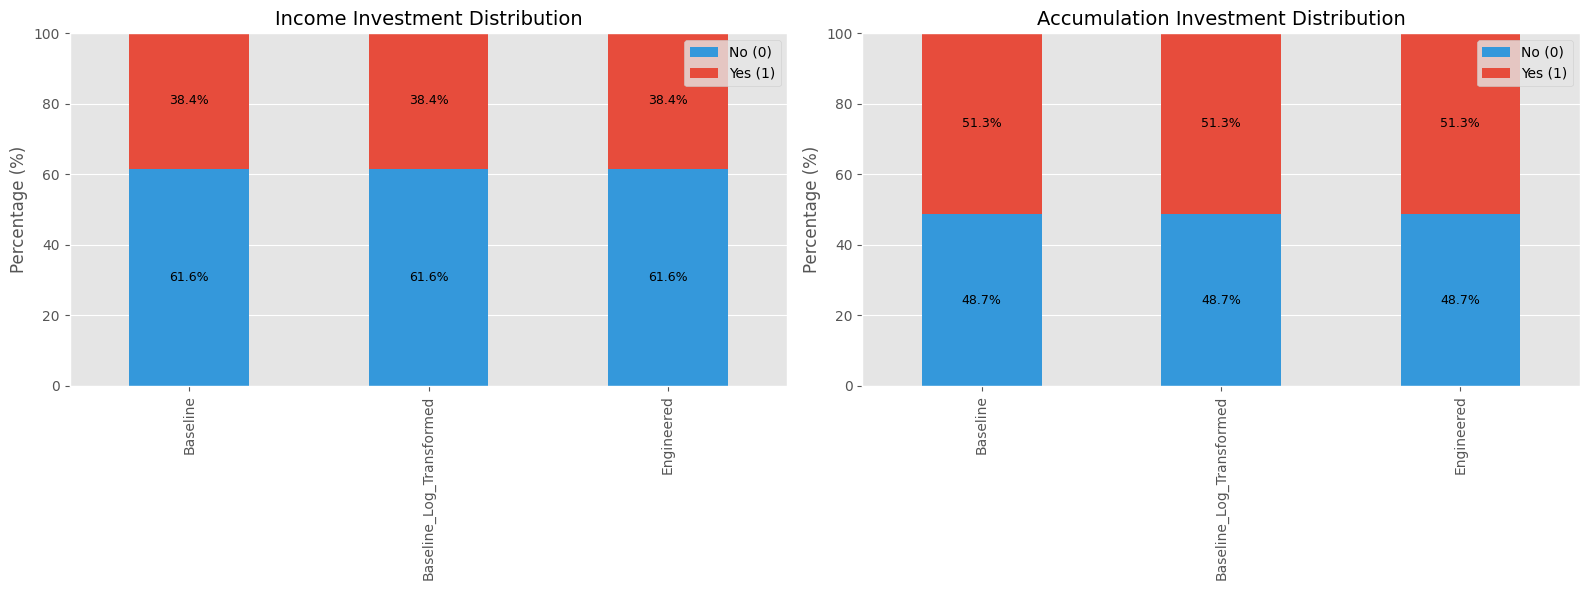

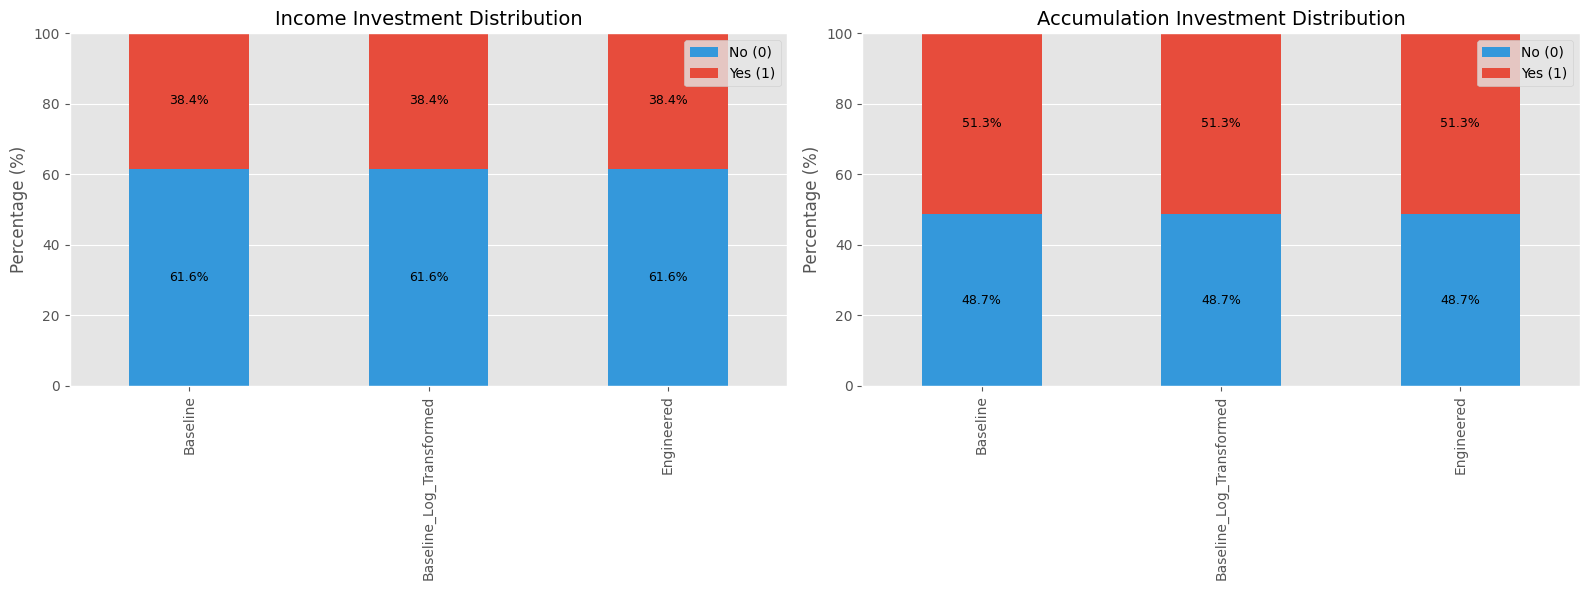

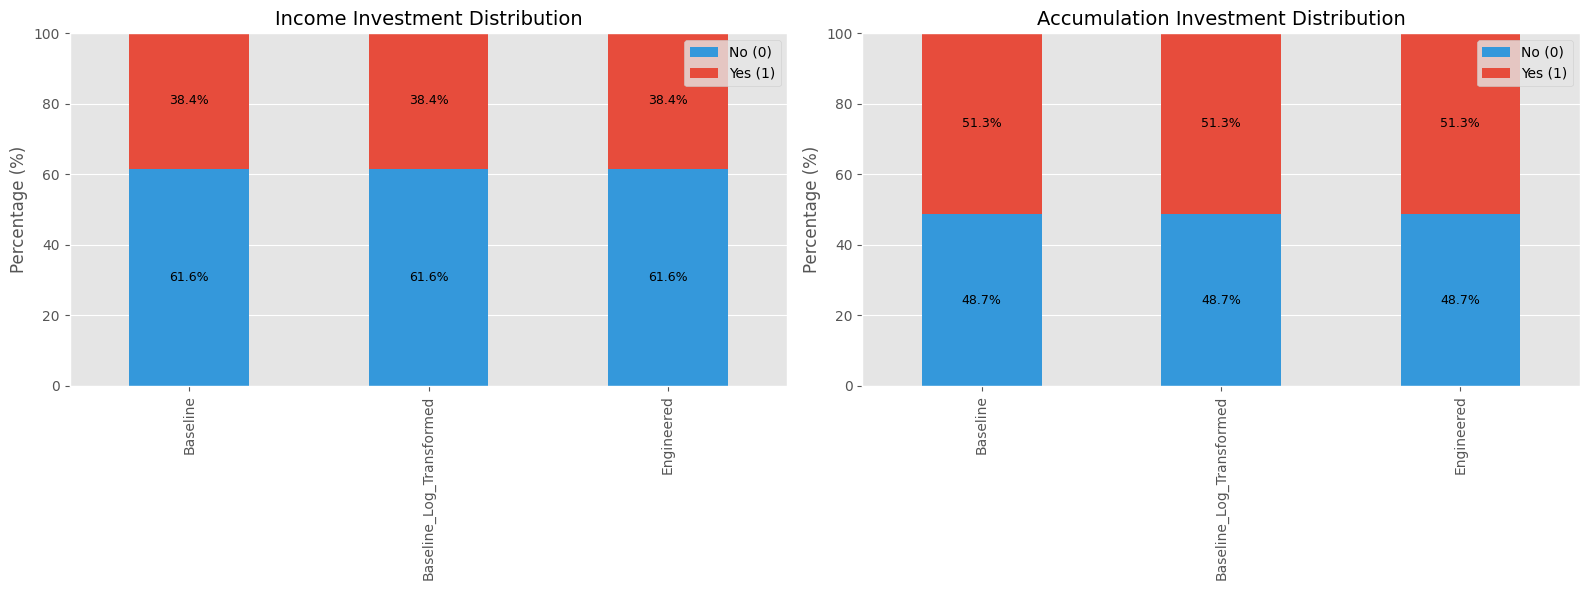



===== FEATURE DISTRIBUTIONS =====

Processing Baseline DataFrame (1/3)...
Saving plots to: baseline_plots
Found 7 features. Creating 1 pages...
  Processing batch 1/1 with 7 features...


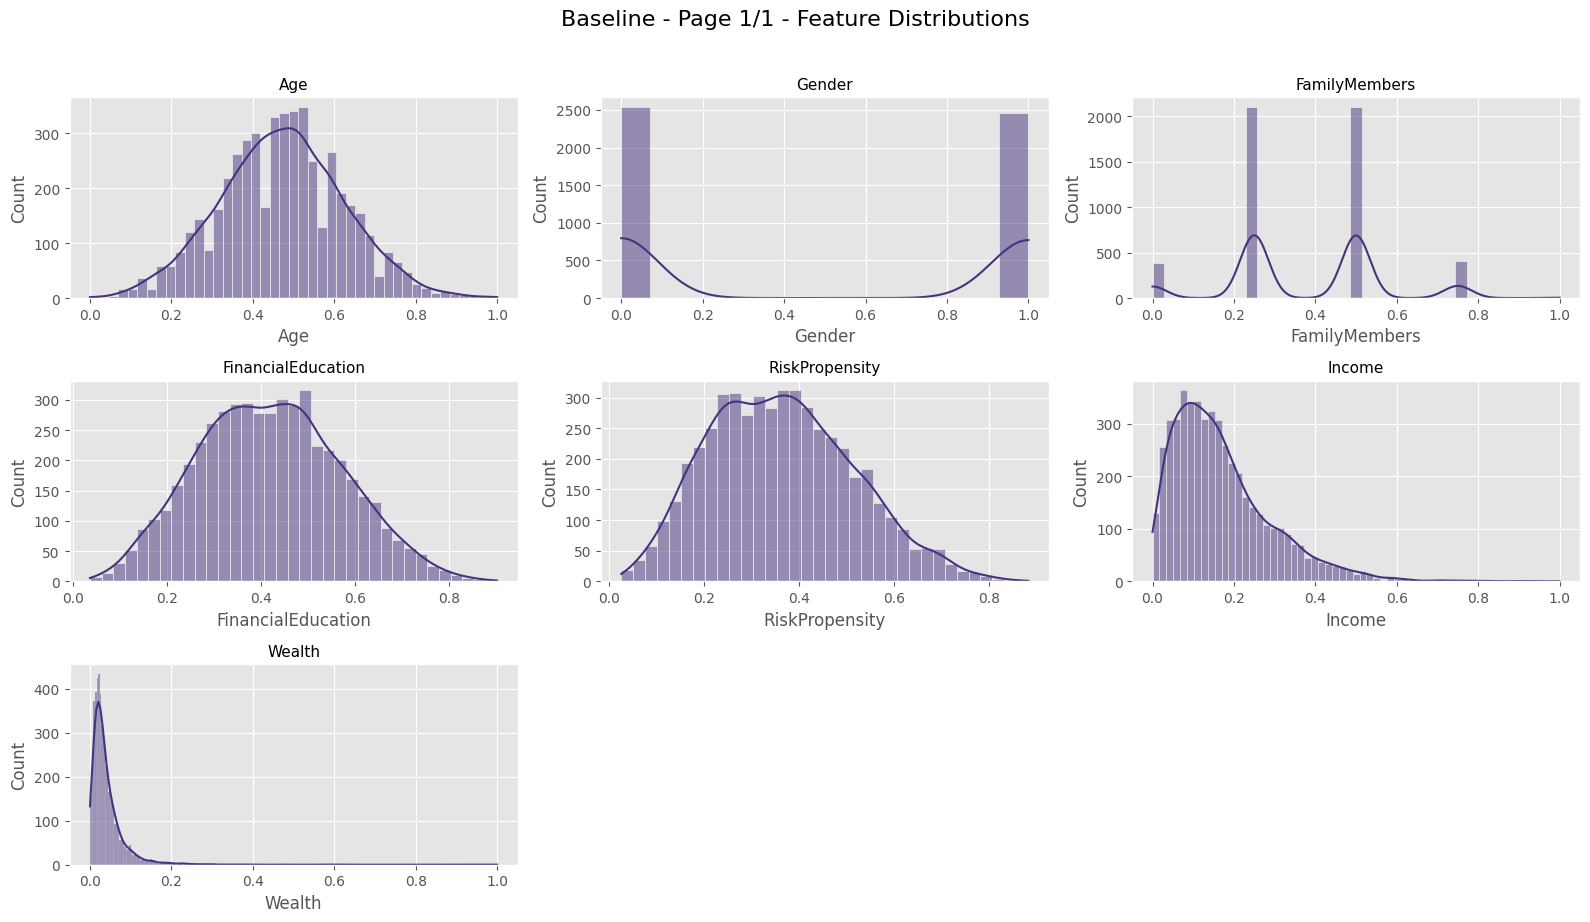

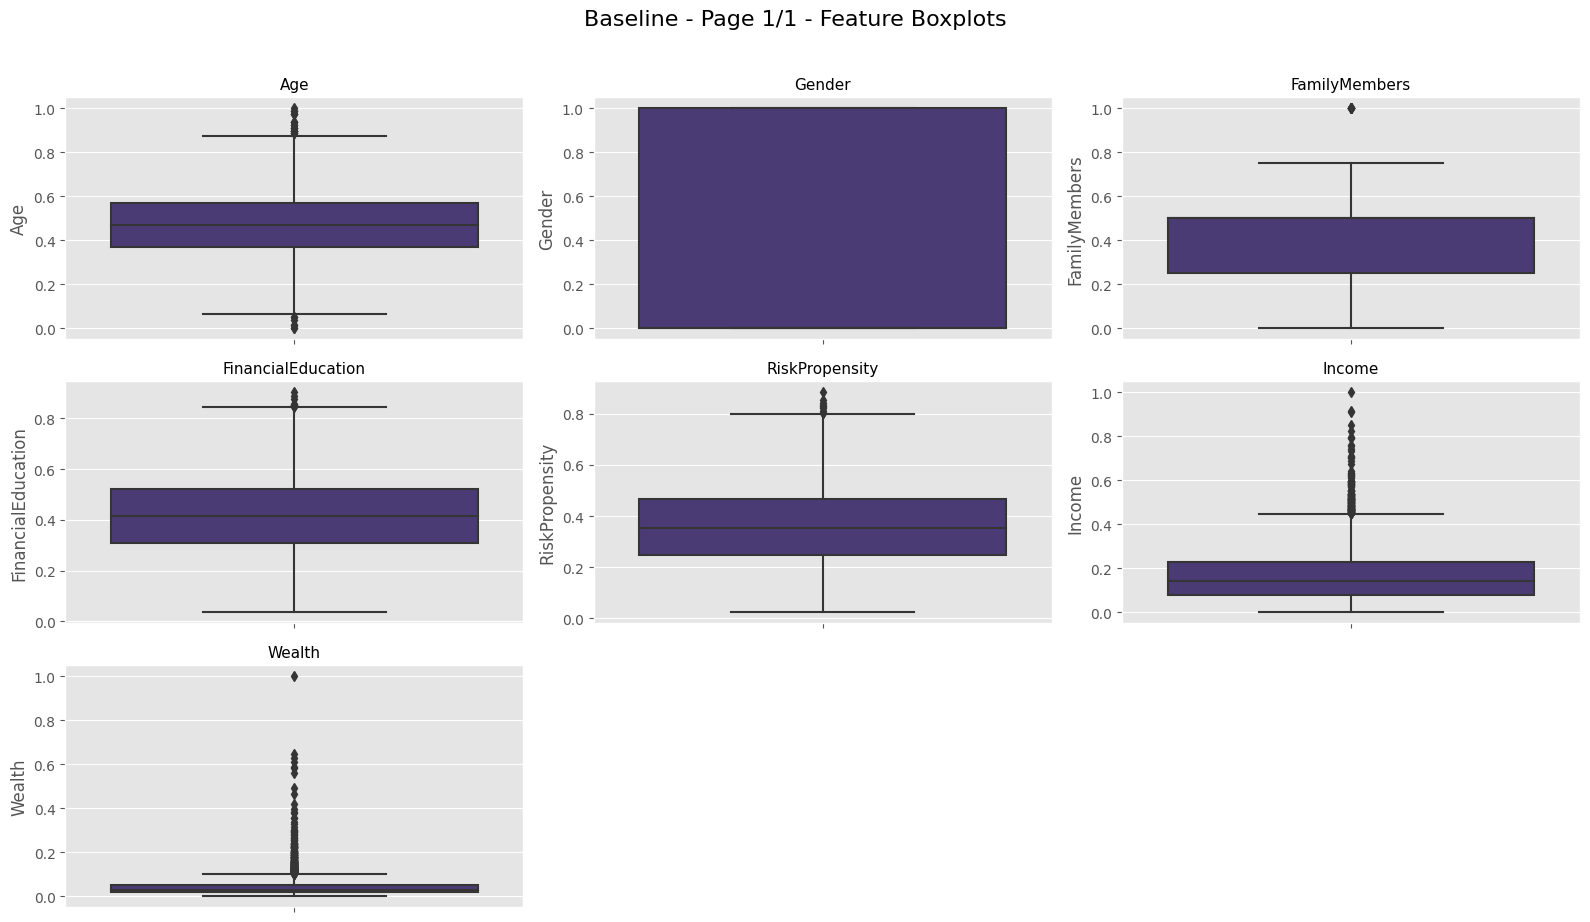

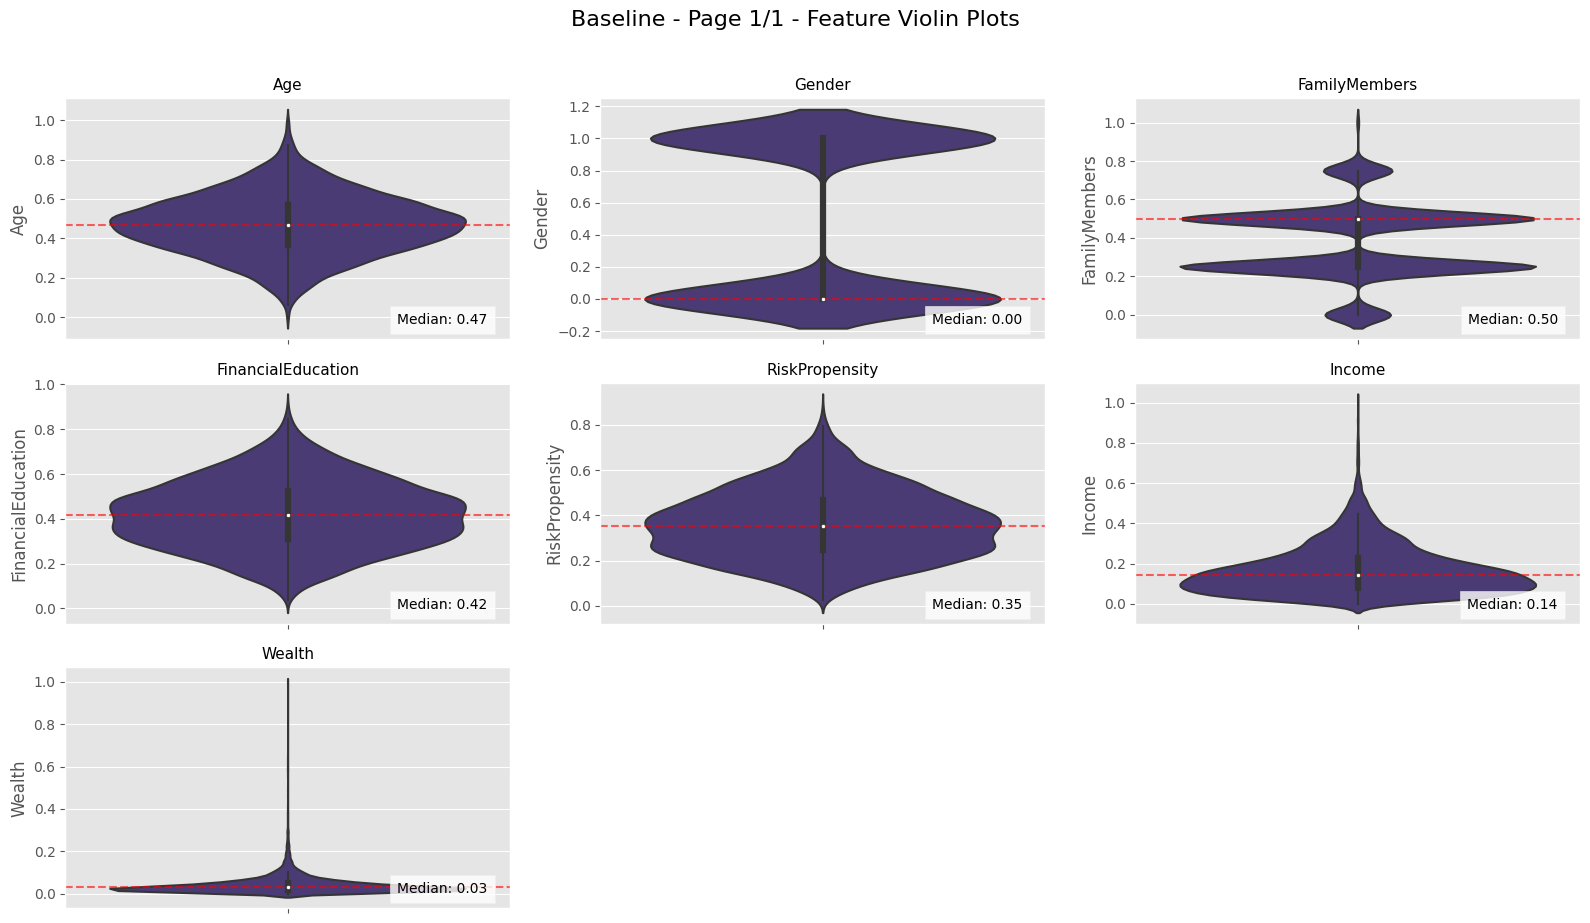


Processing Baseline_Log_Transformed DataFrame (2/3)...
Saving plots to: baseline_log_transformed_plots
Found 7 features. Creating 1 pages...
  Processing batch 1/1 with 7 features...


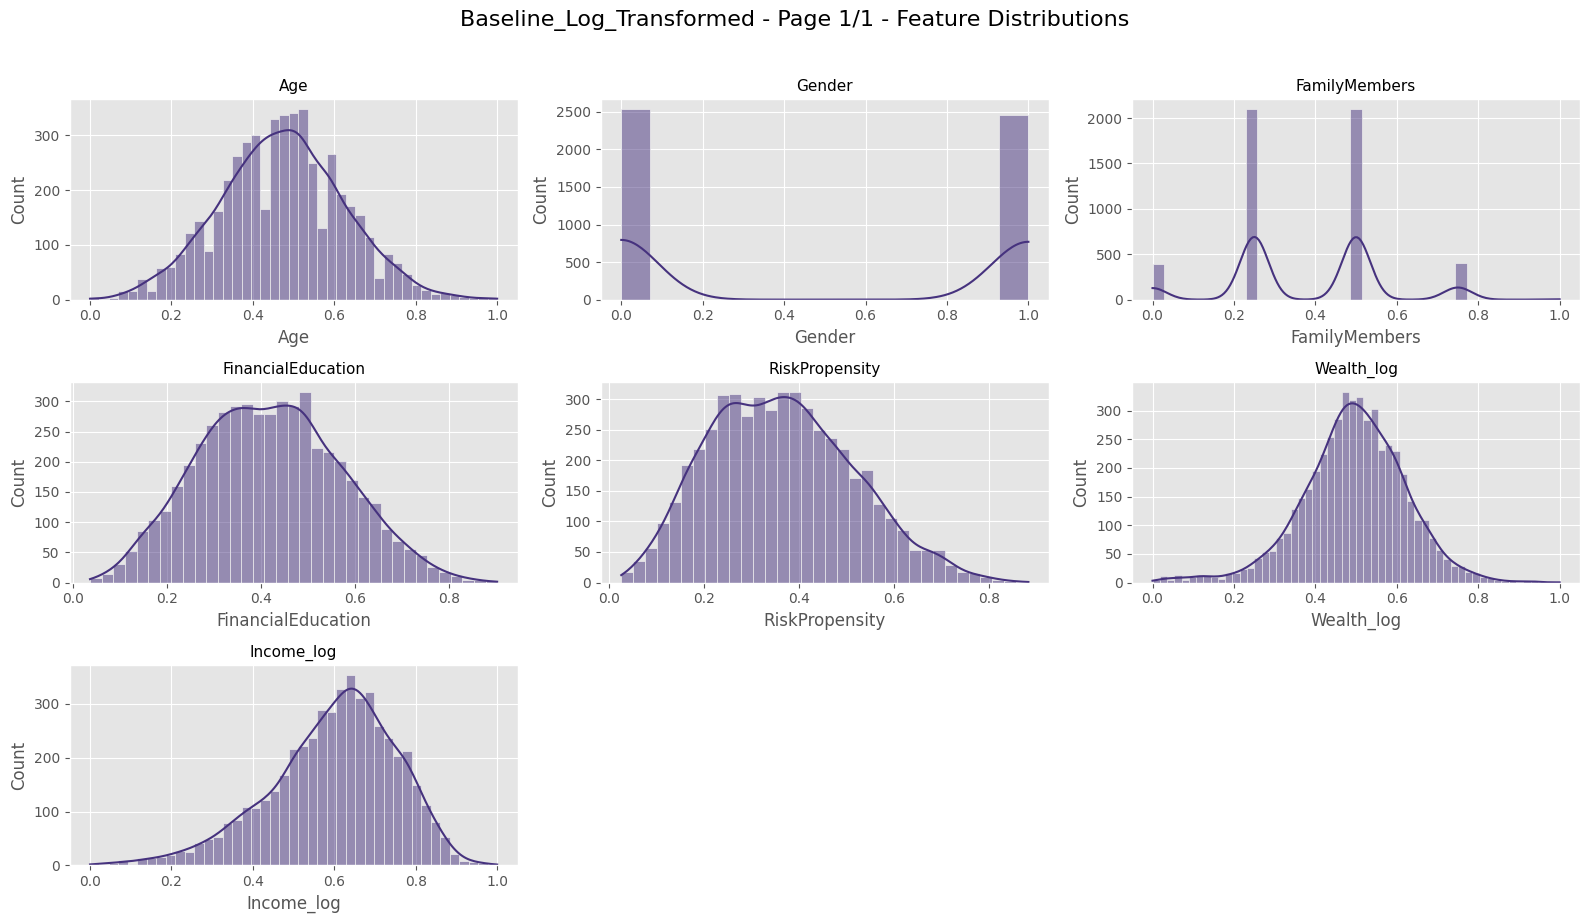

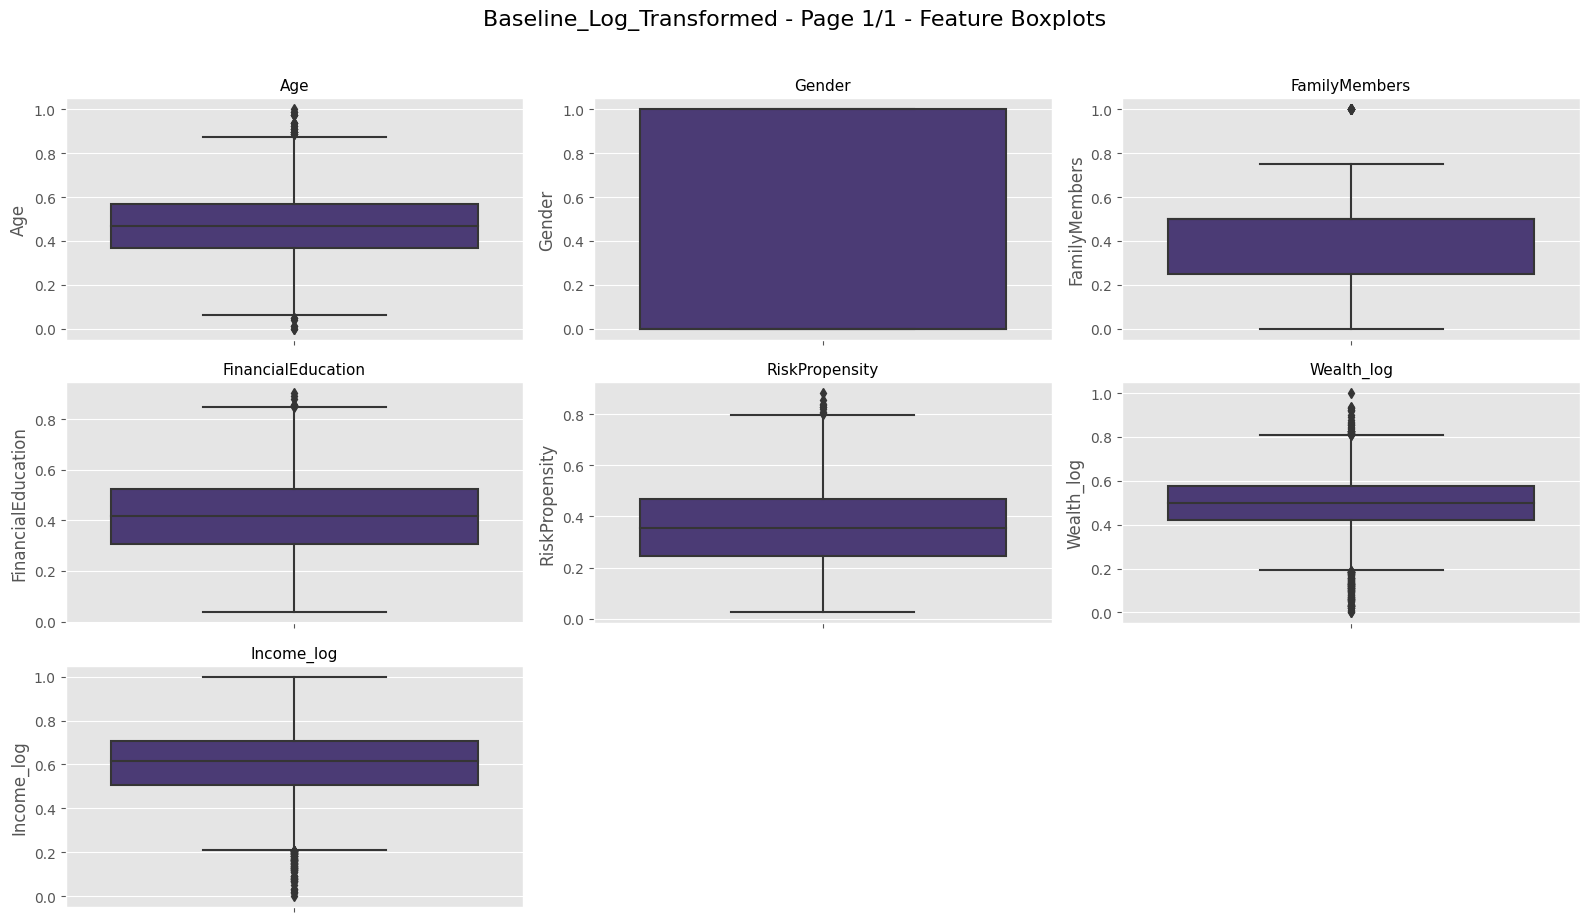

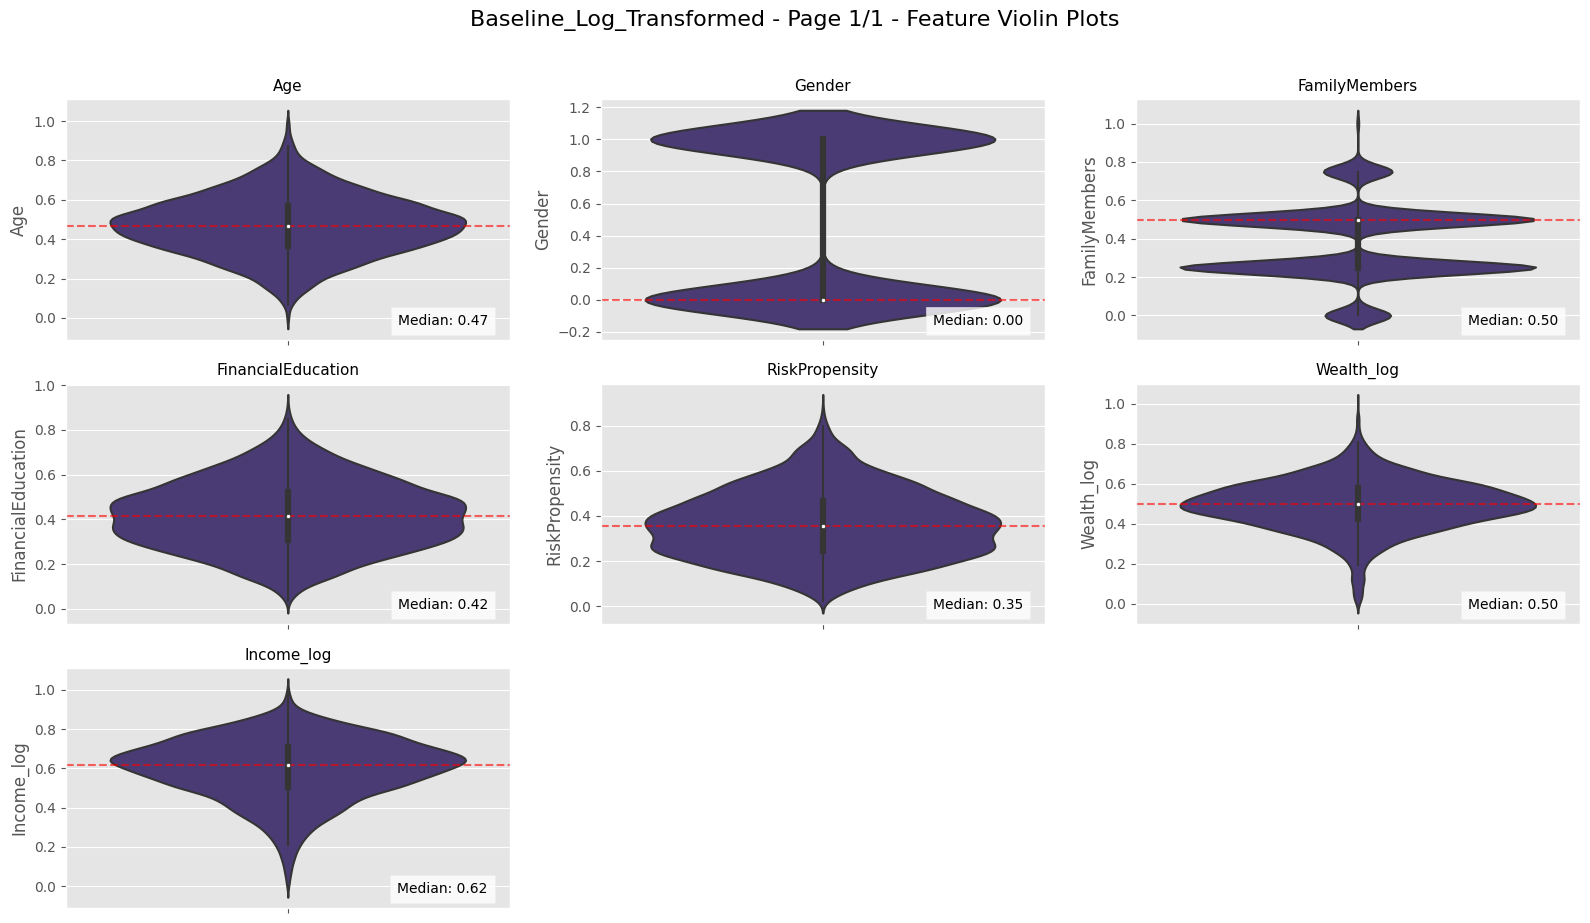


Processing Engineered DataFrame (3/3)...
Saving plots to: engineered_plots
Found 42 features. Creating 5 pages...
  Processing batch 1/5 with 9 features...


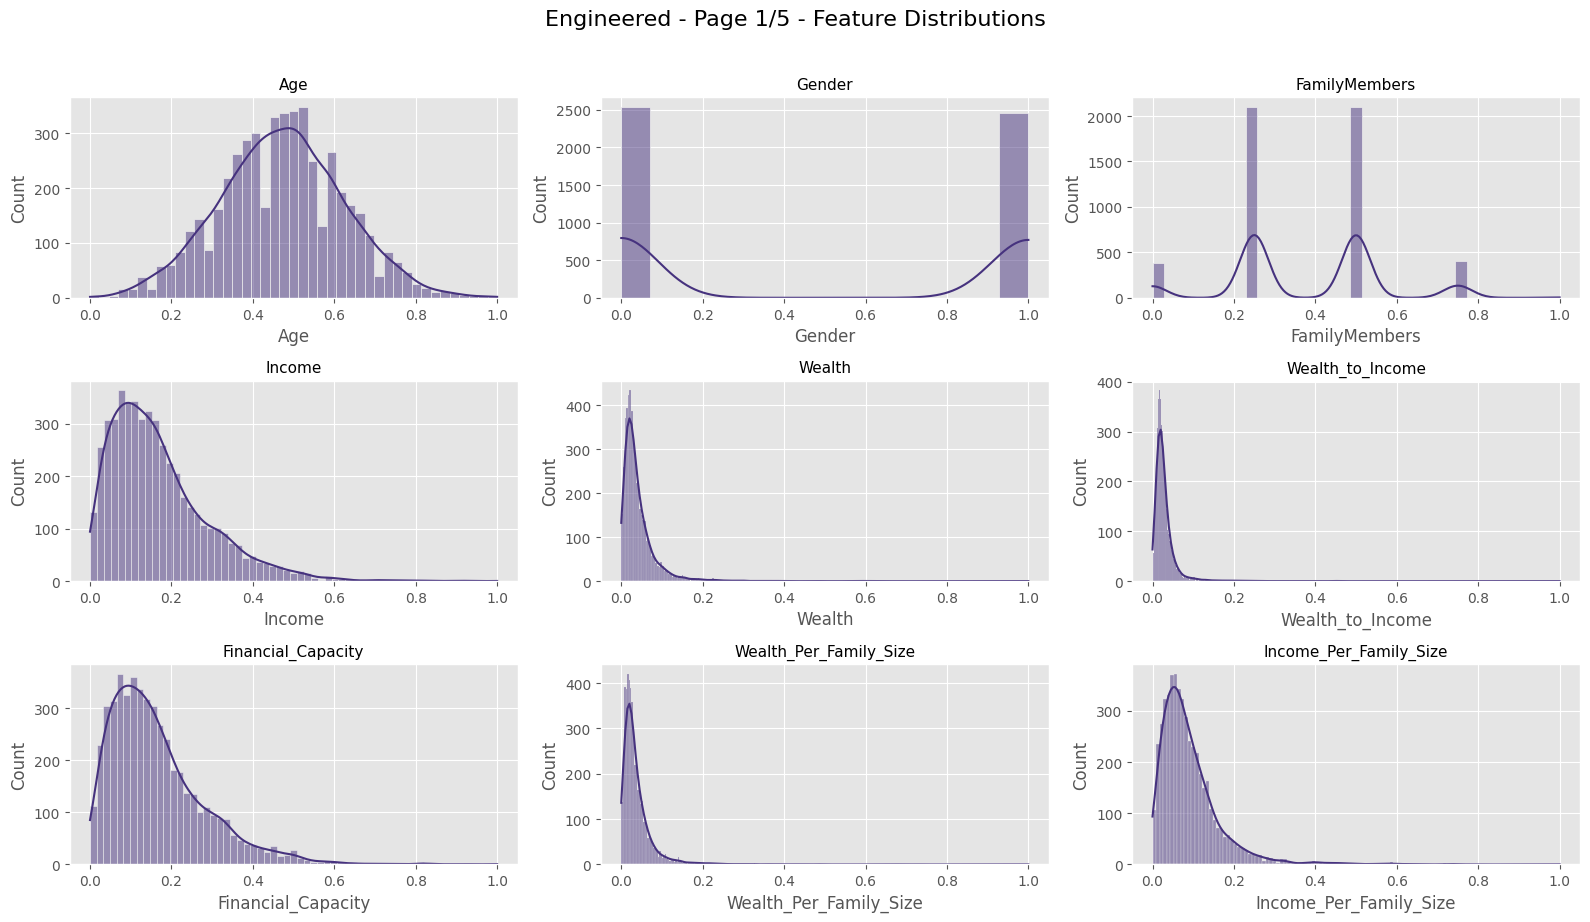

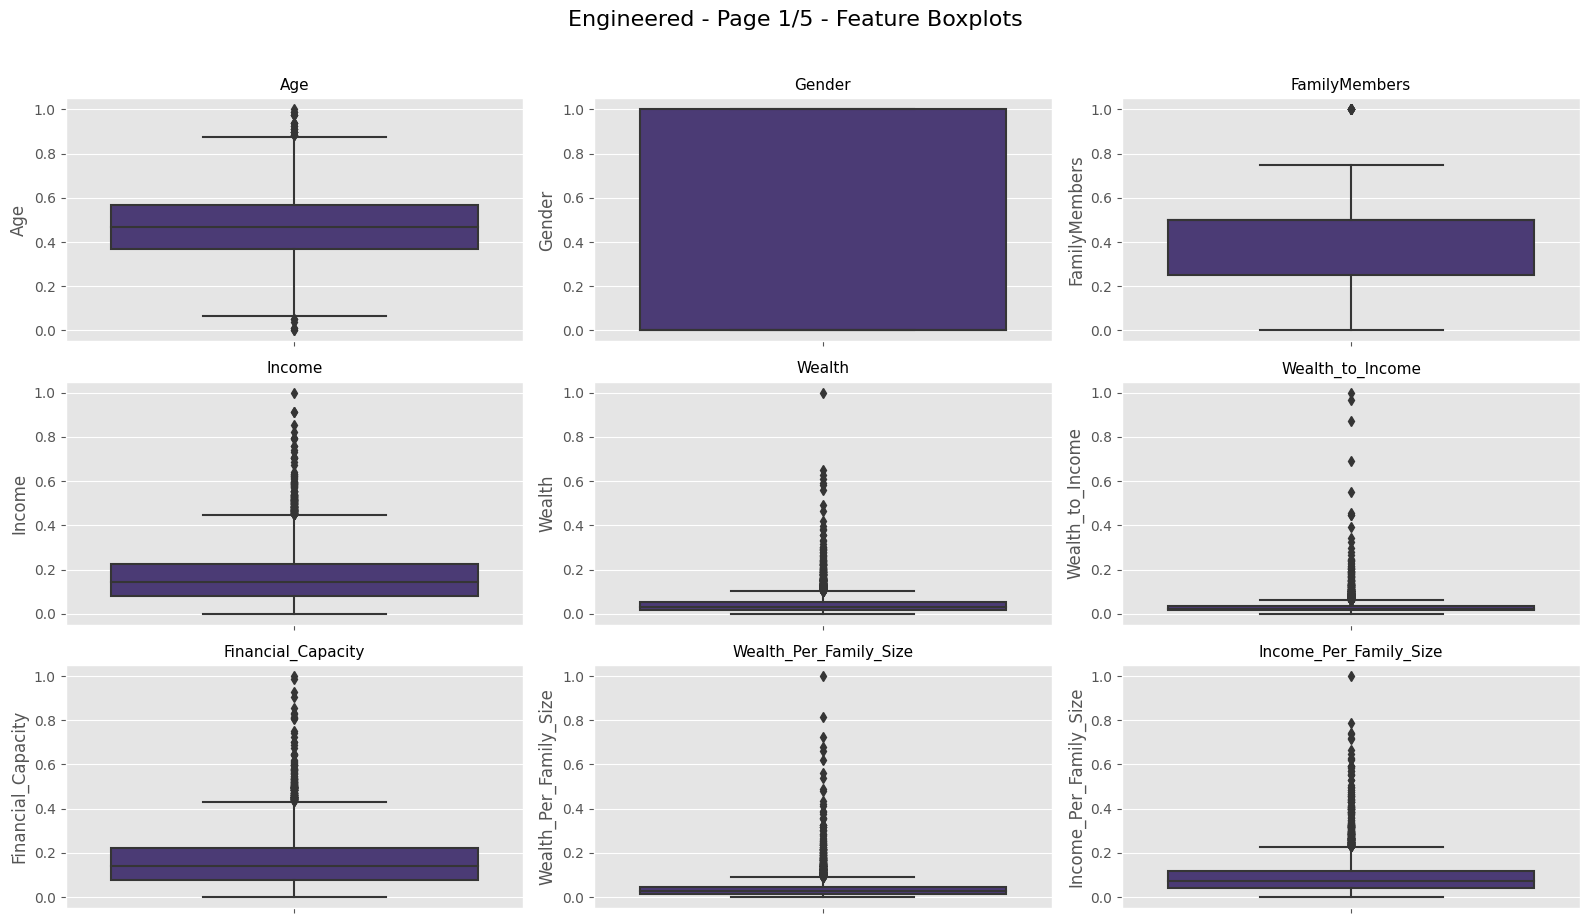

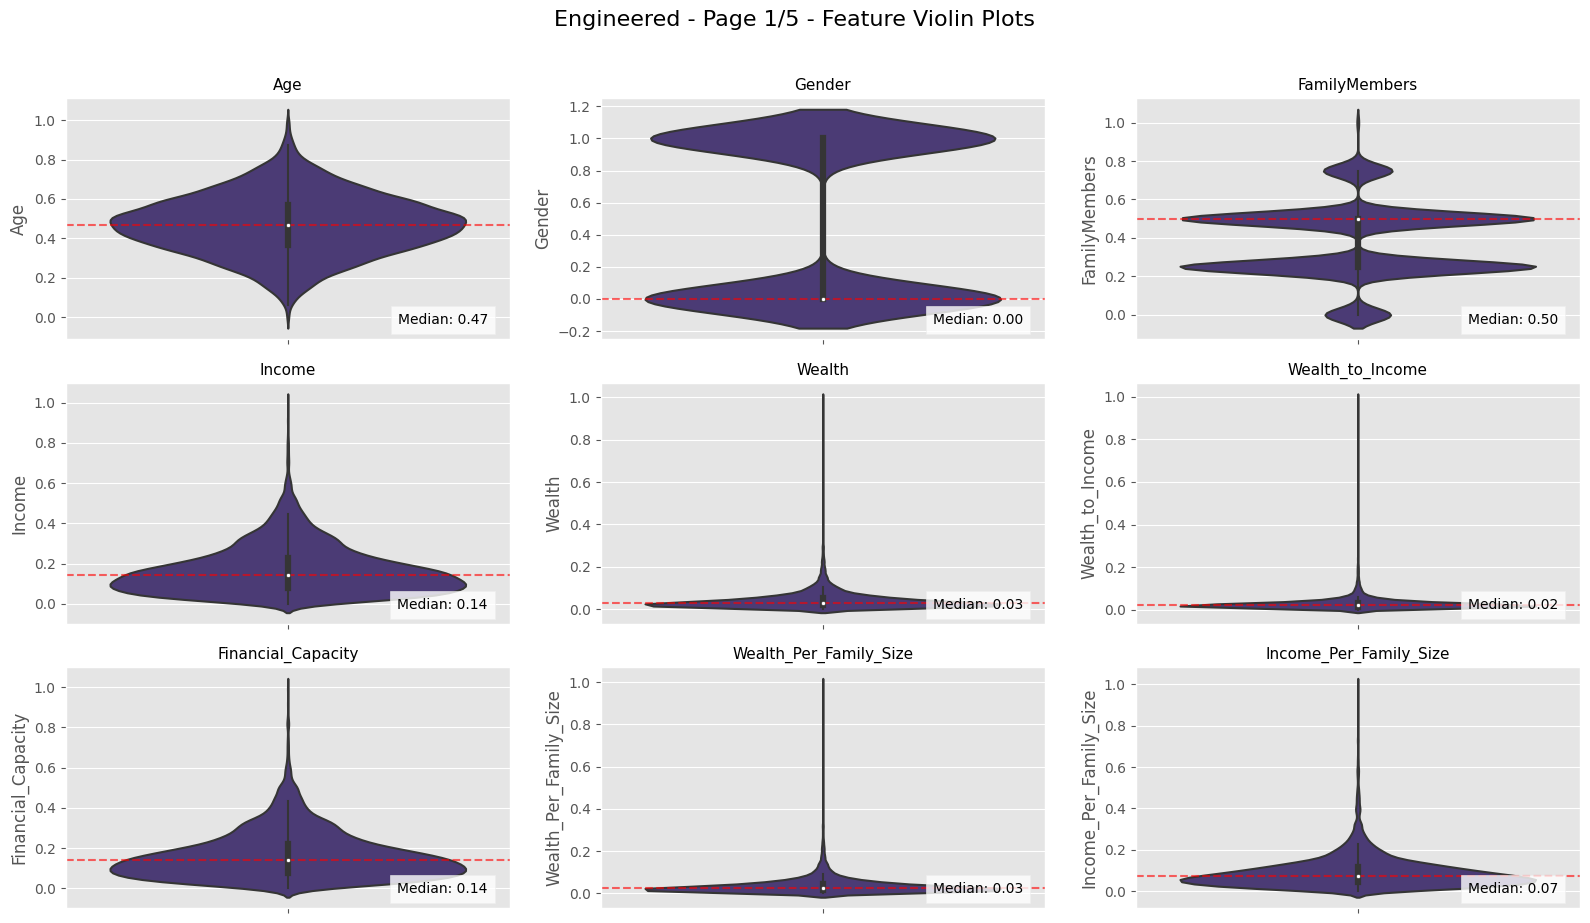

  Processing batch 2/5 with 9 features...


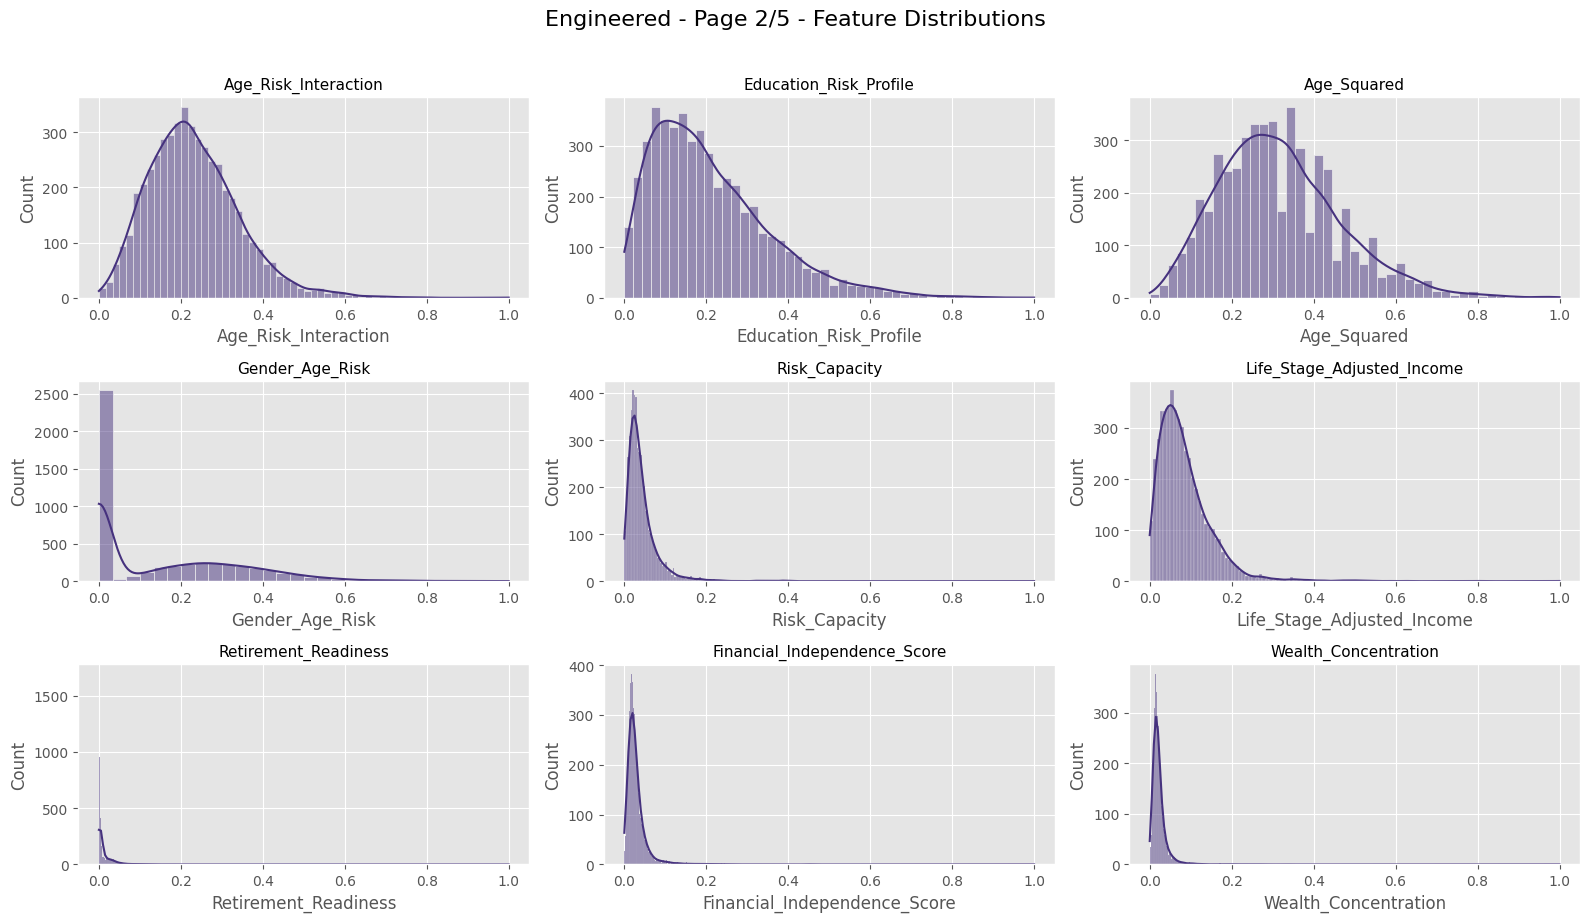

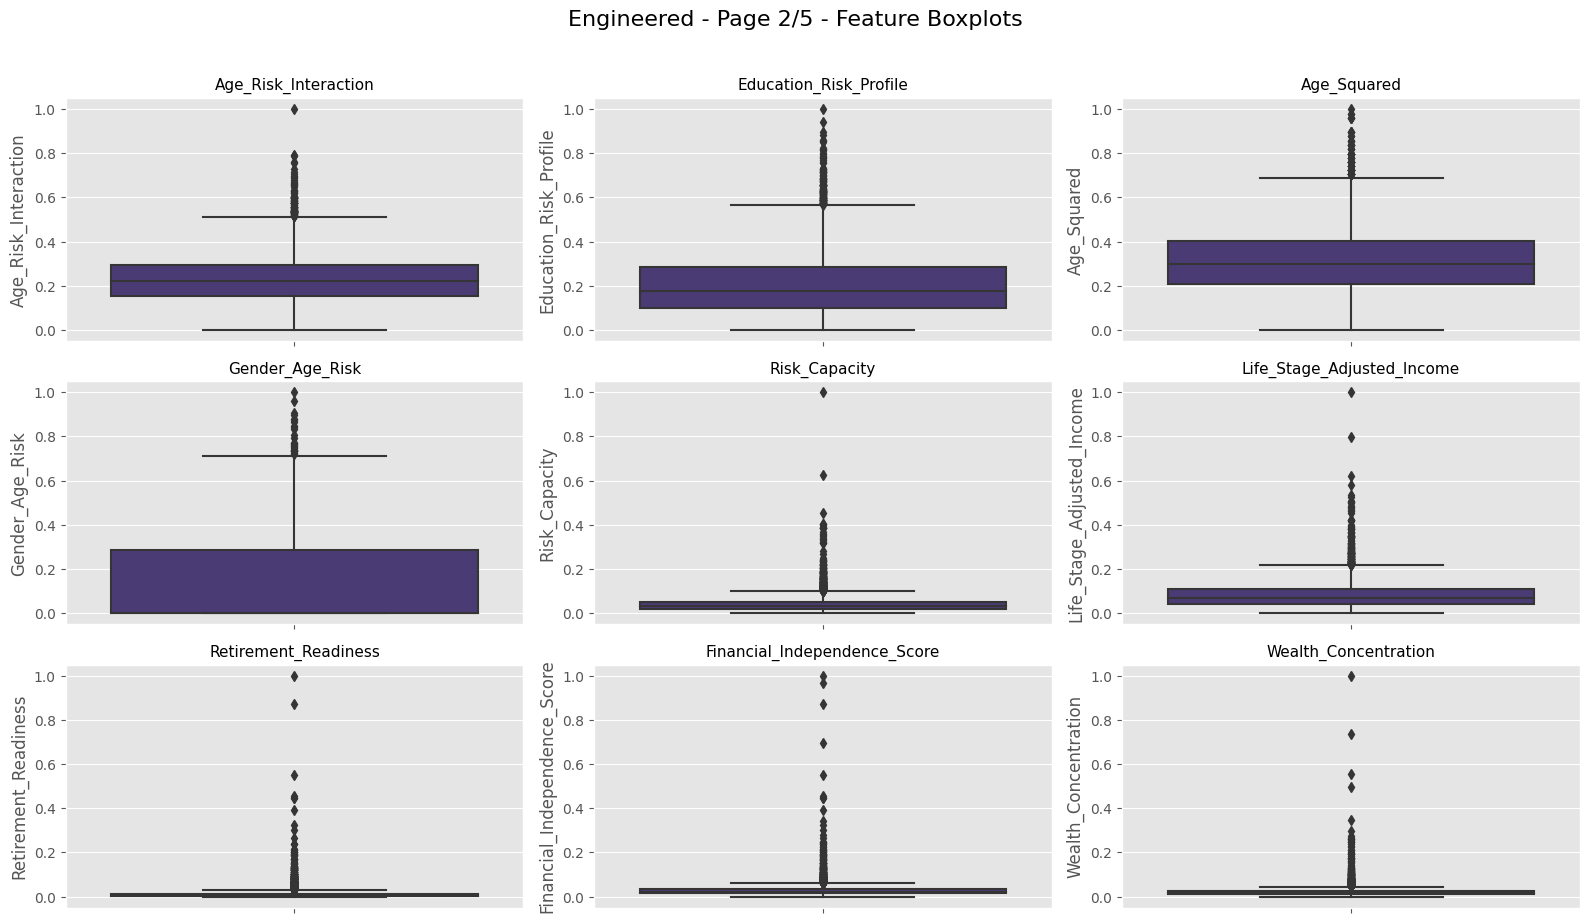

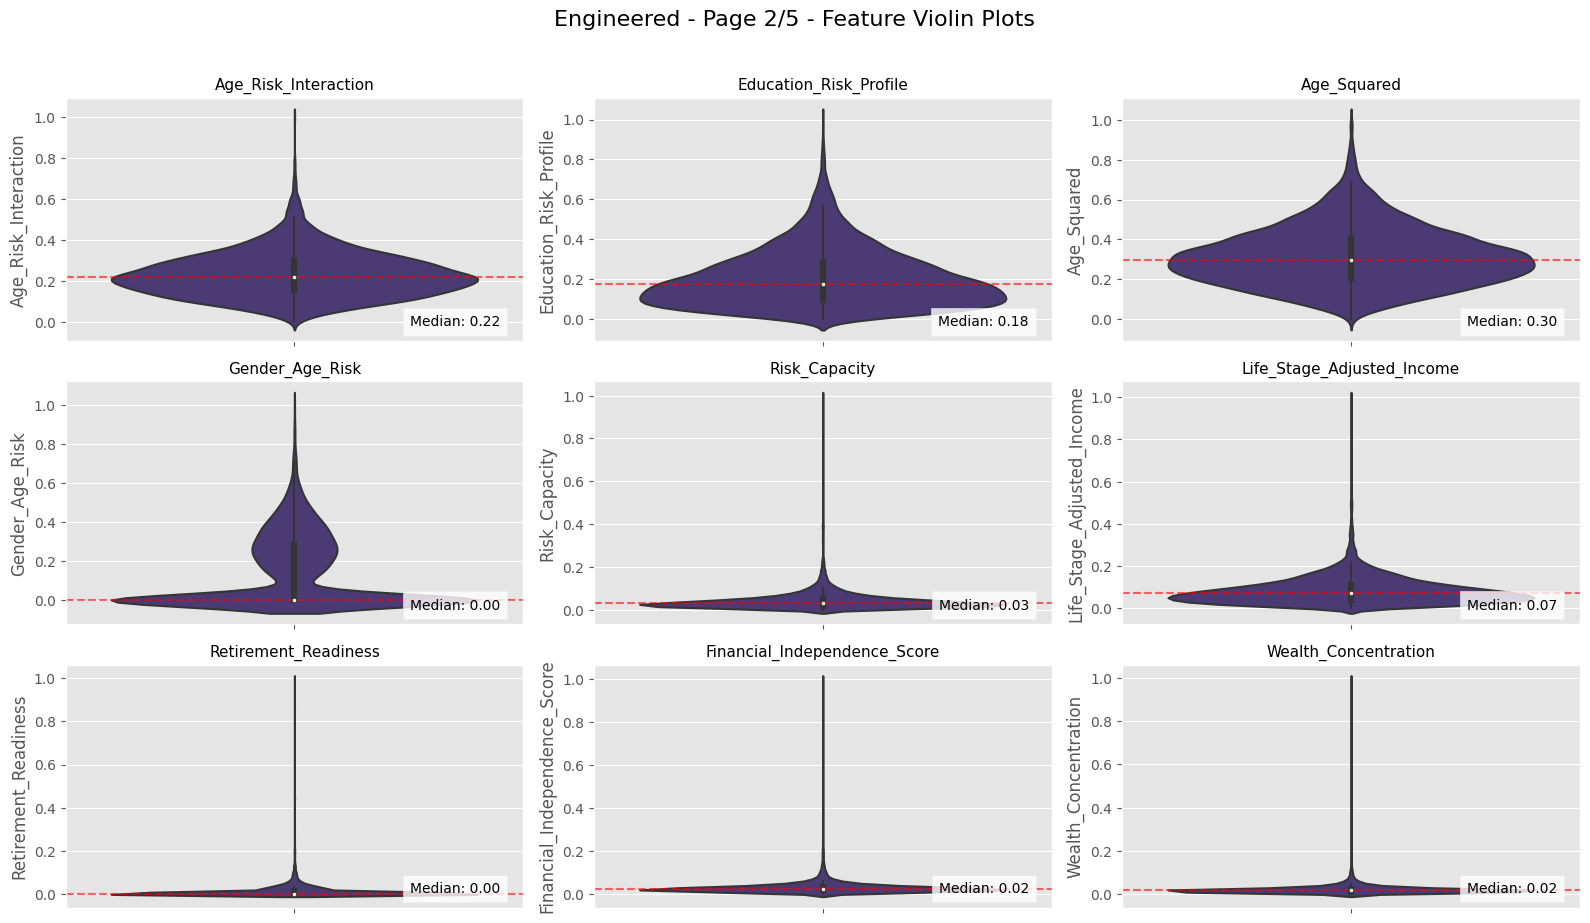

  Processing batch 3/5 with 9 features...


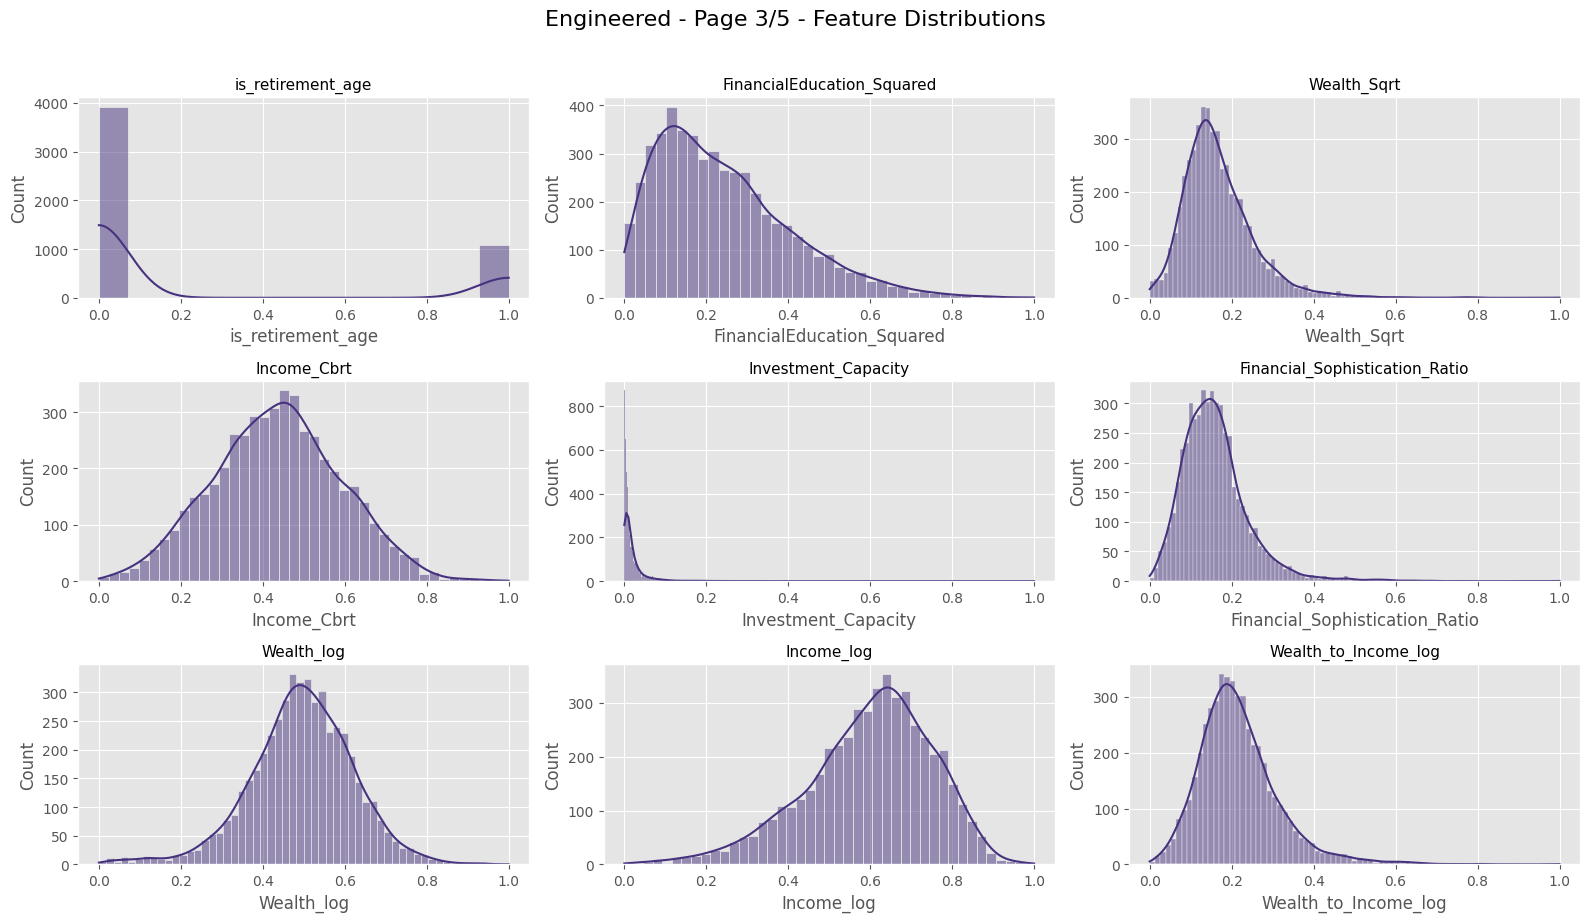

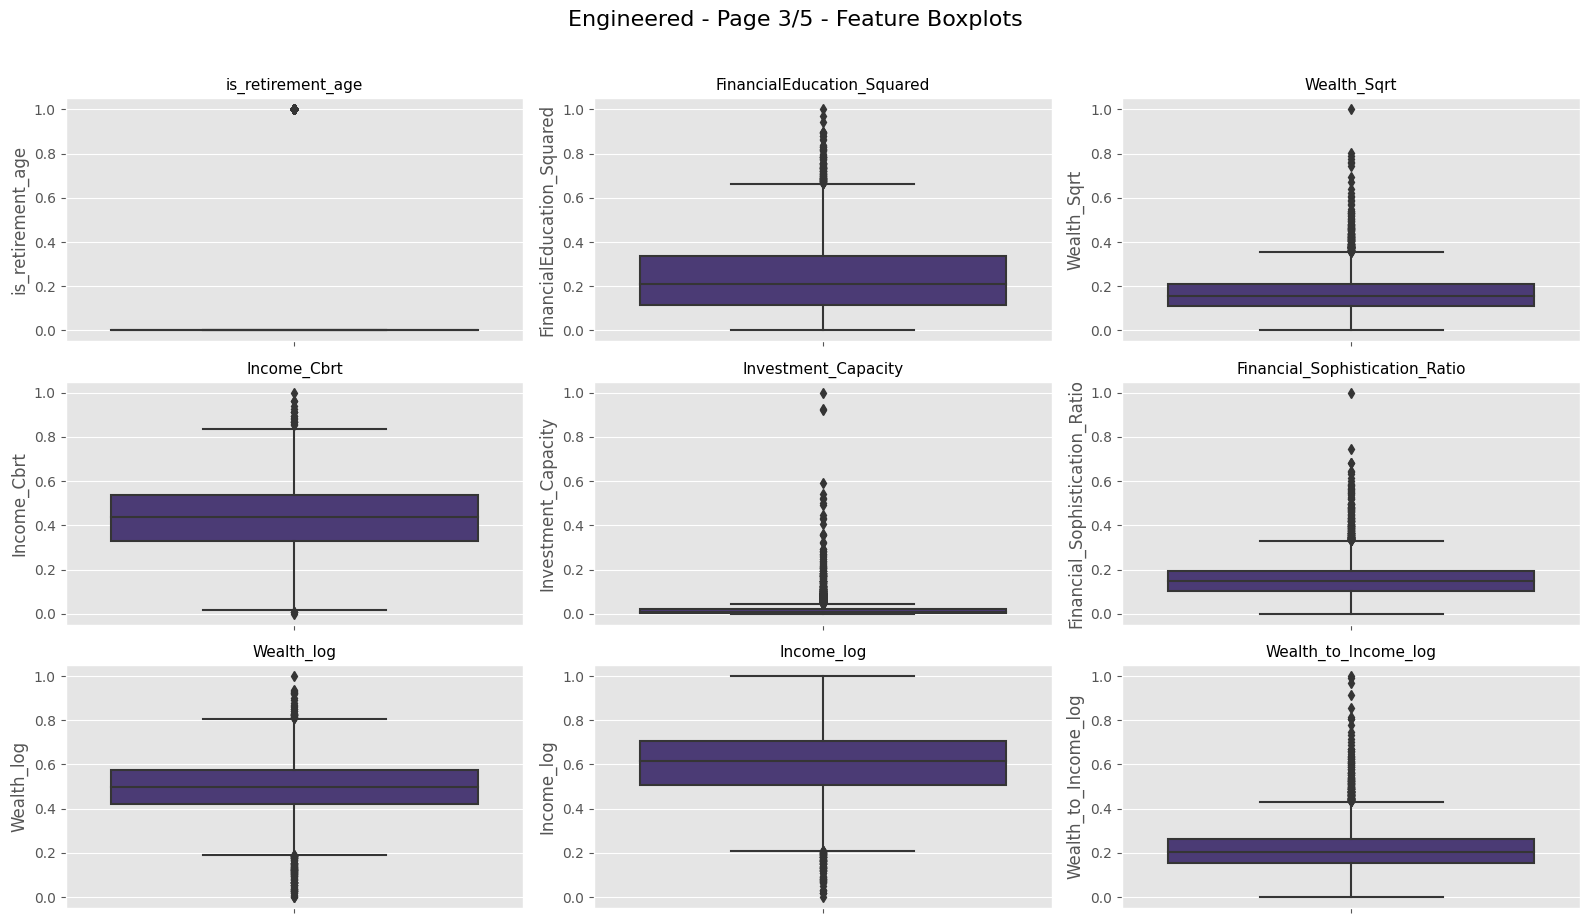

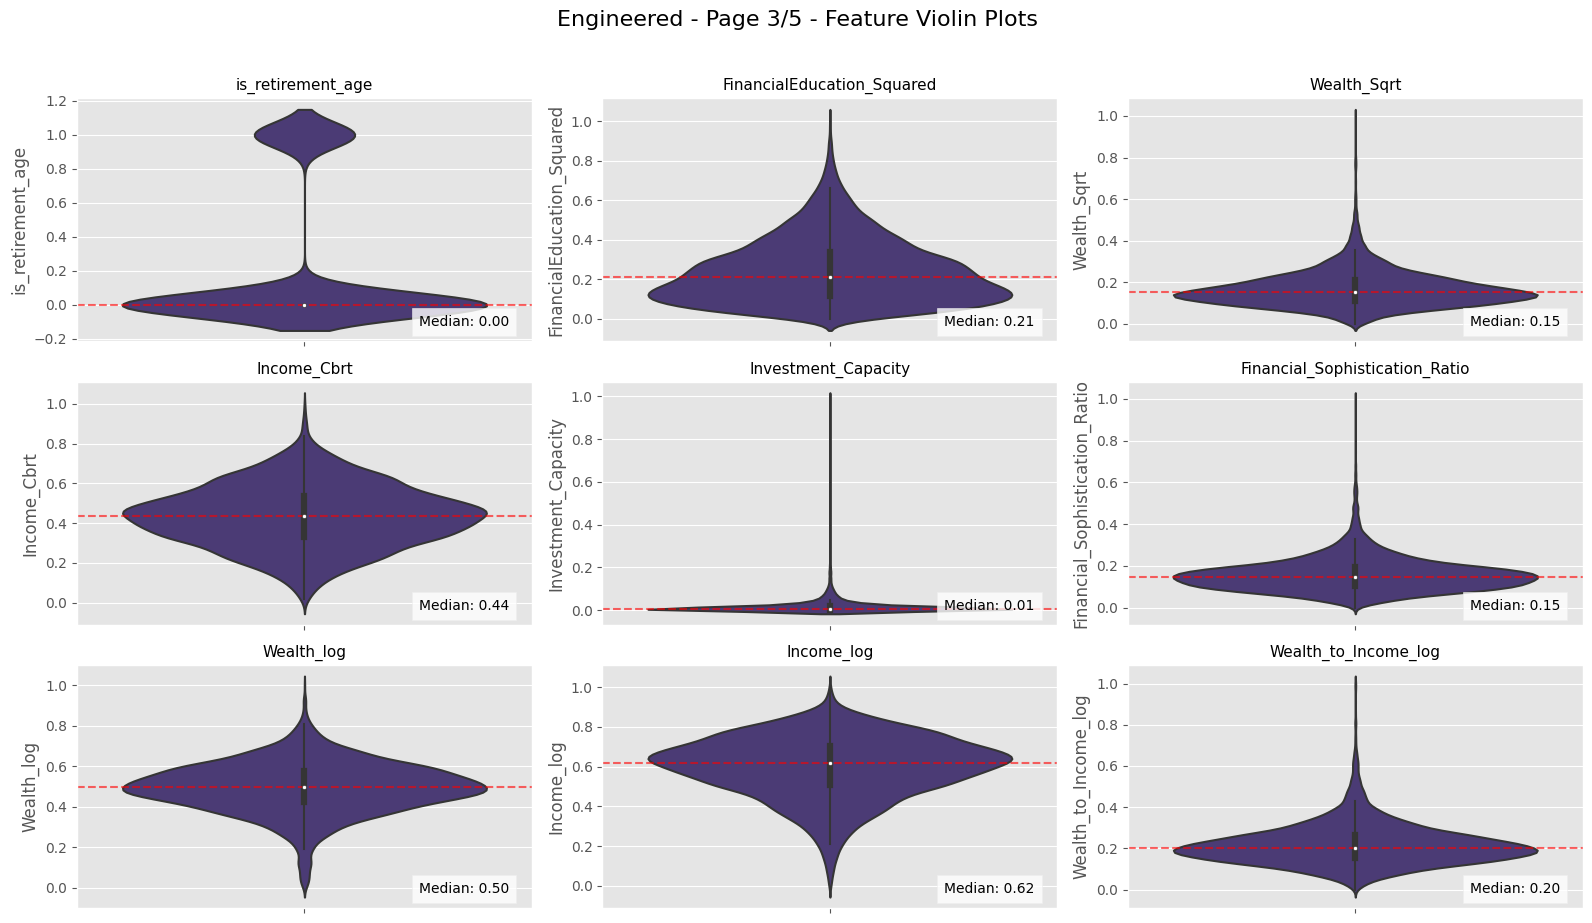

  Processing batch 4/5 with 9 features...


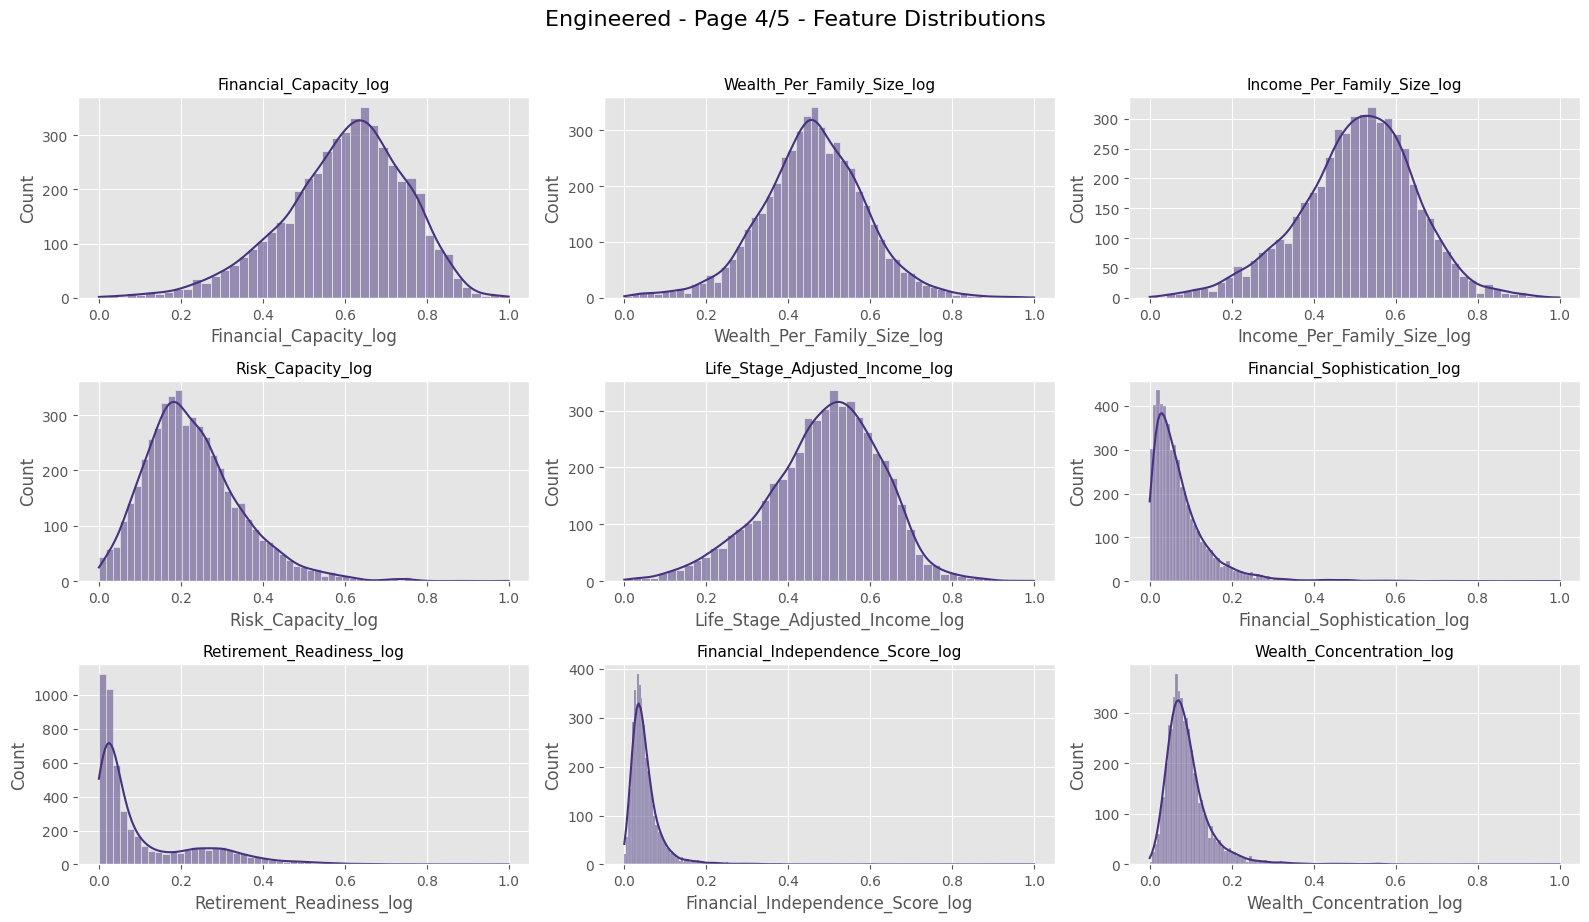

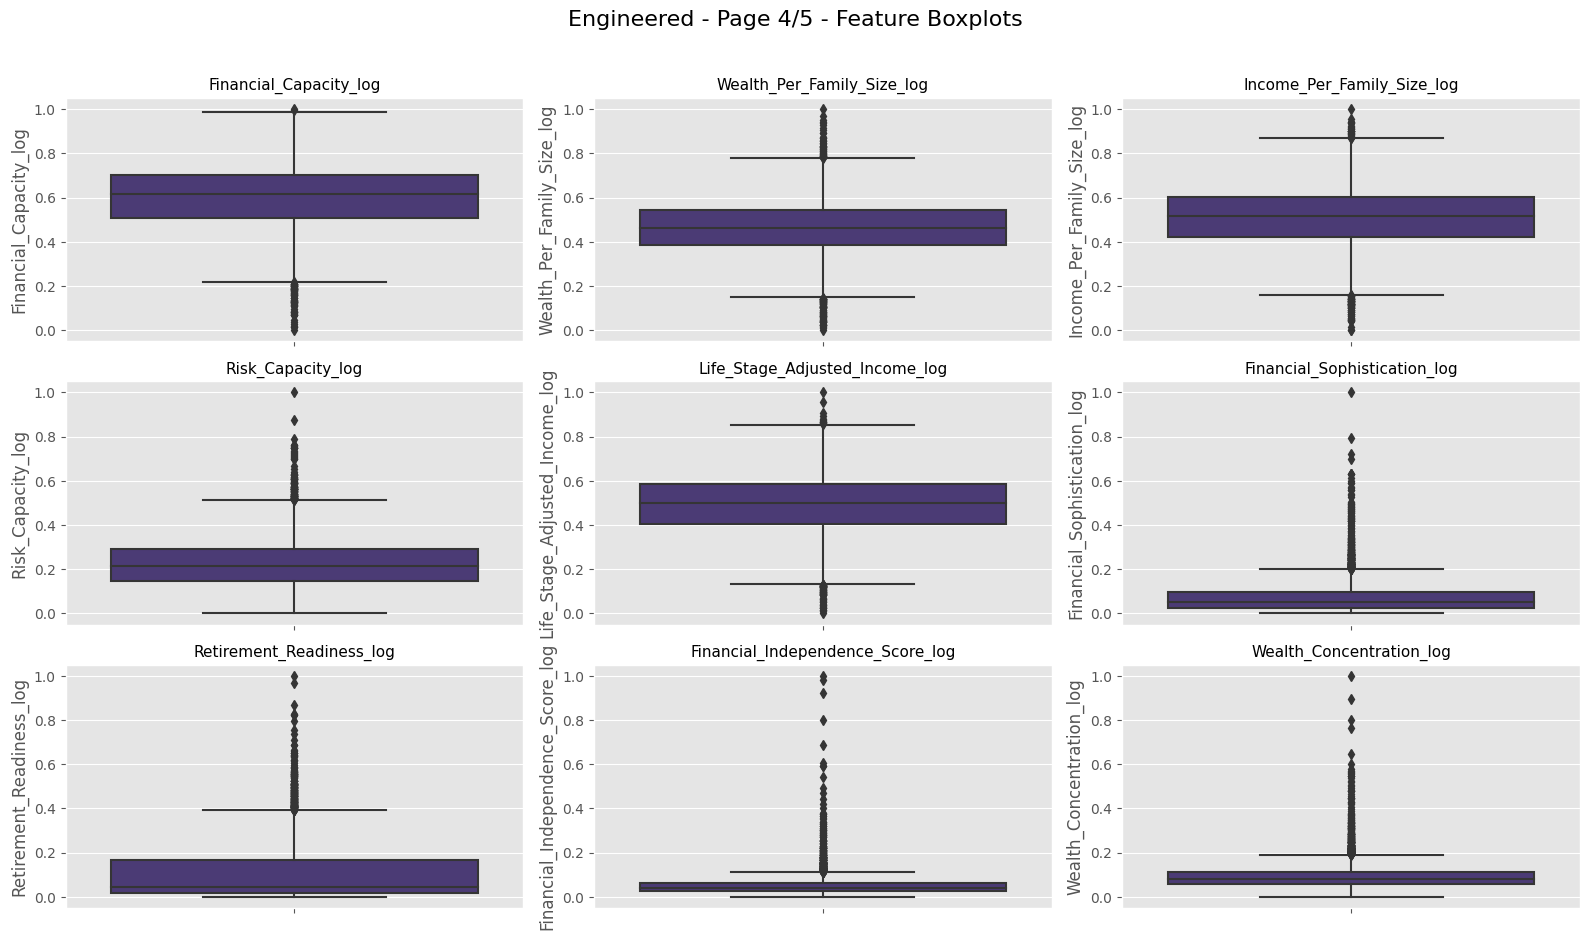

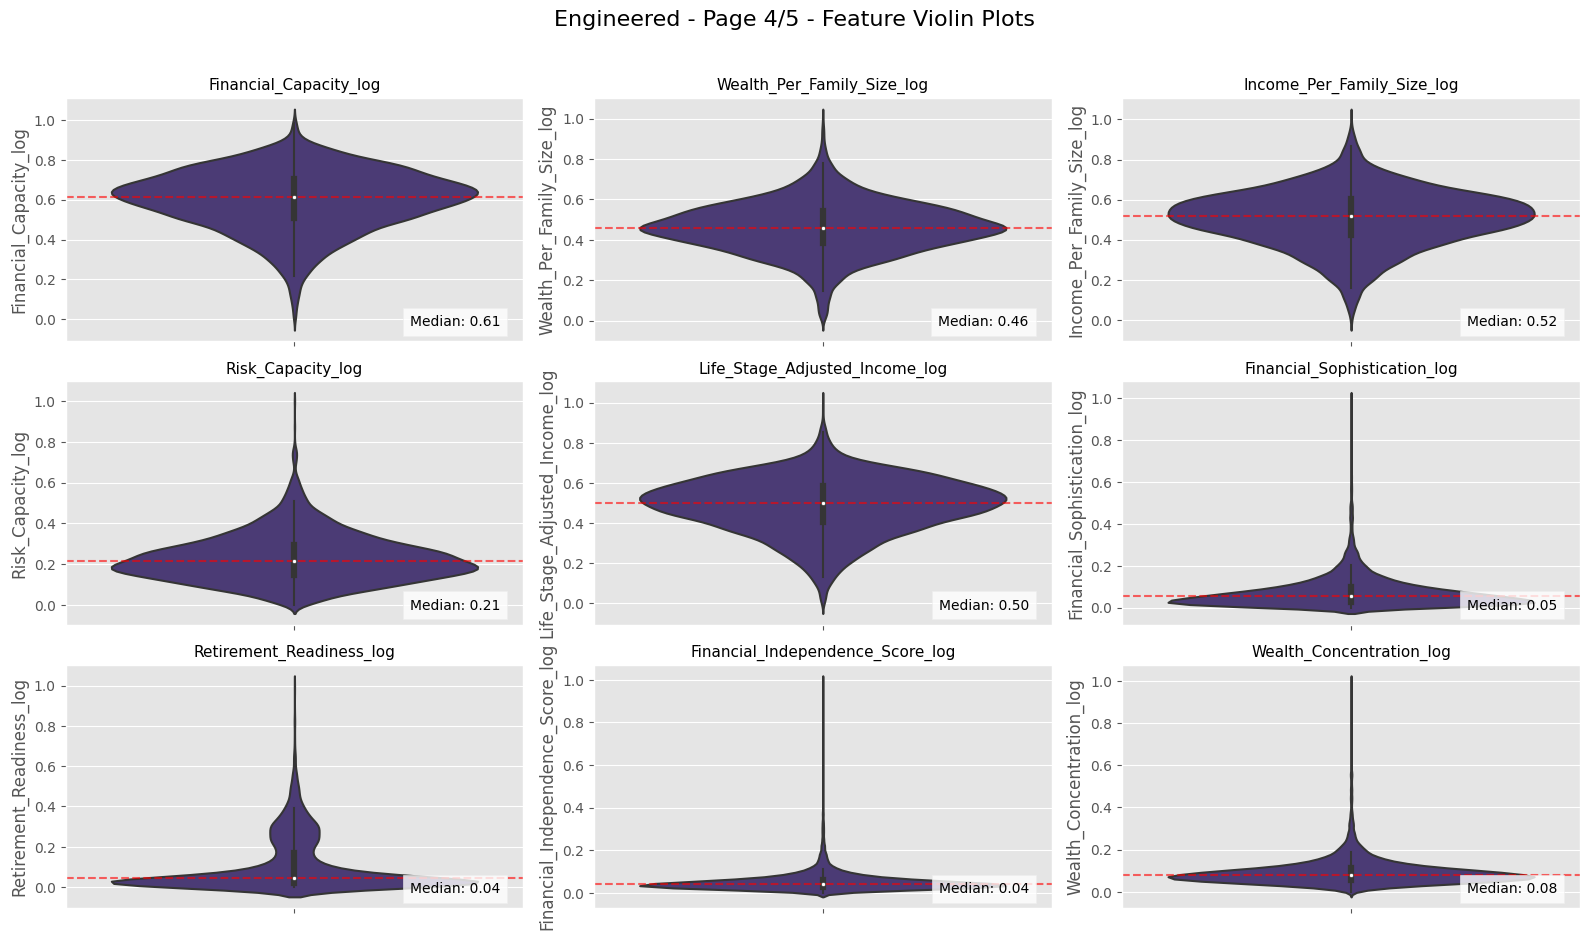

  Processing batch 5/5 with 6 features...


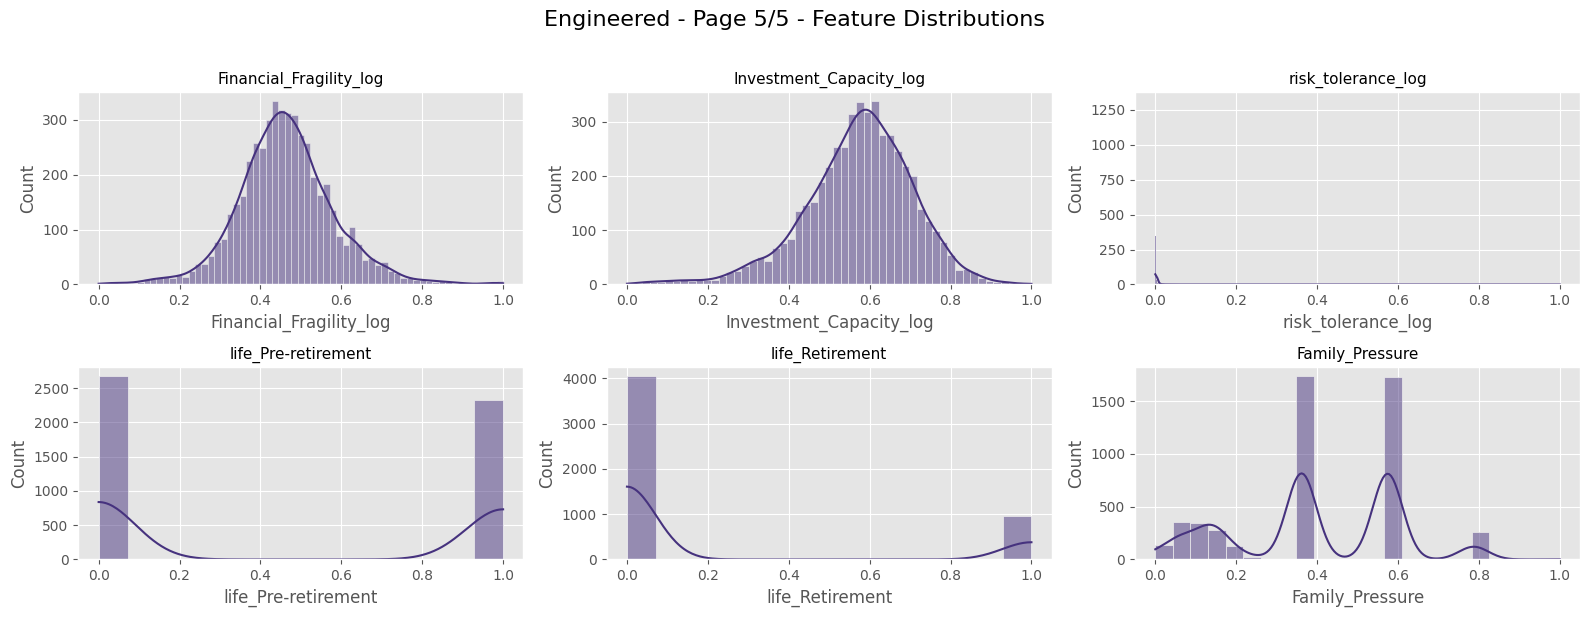

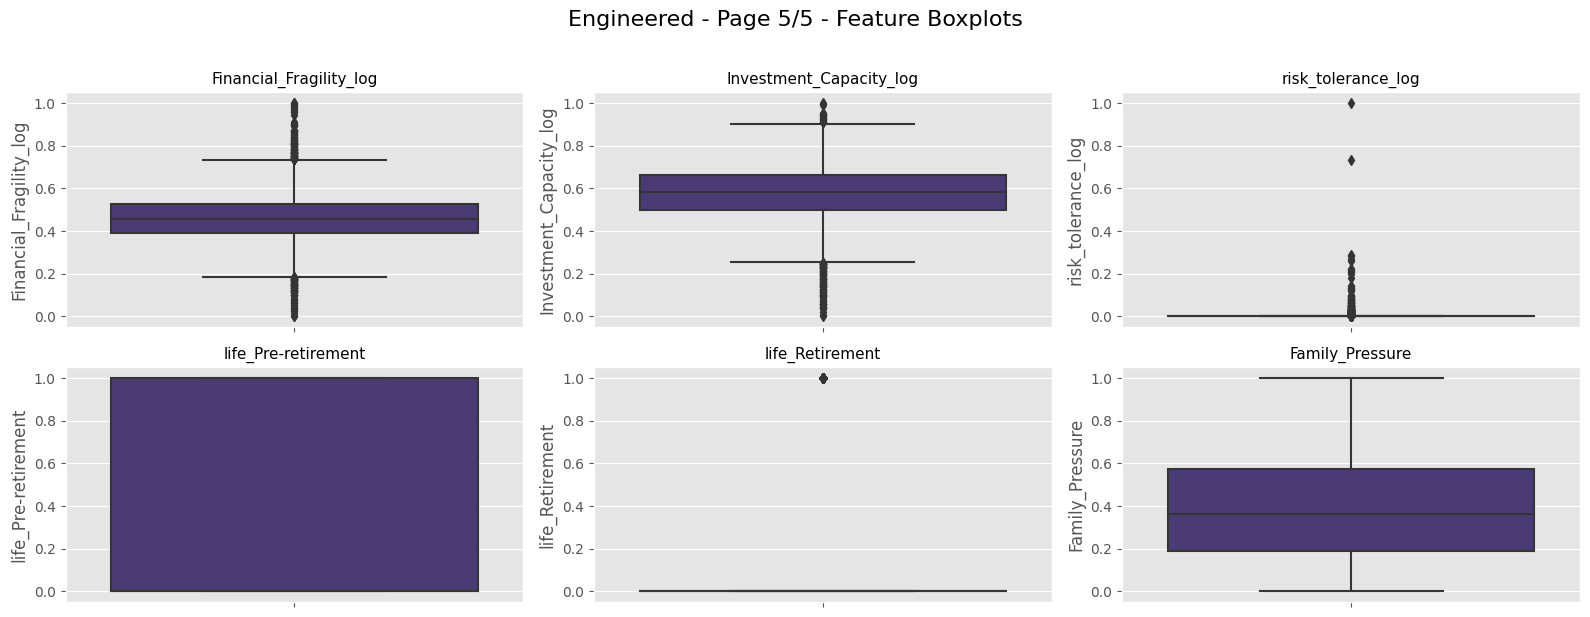

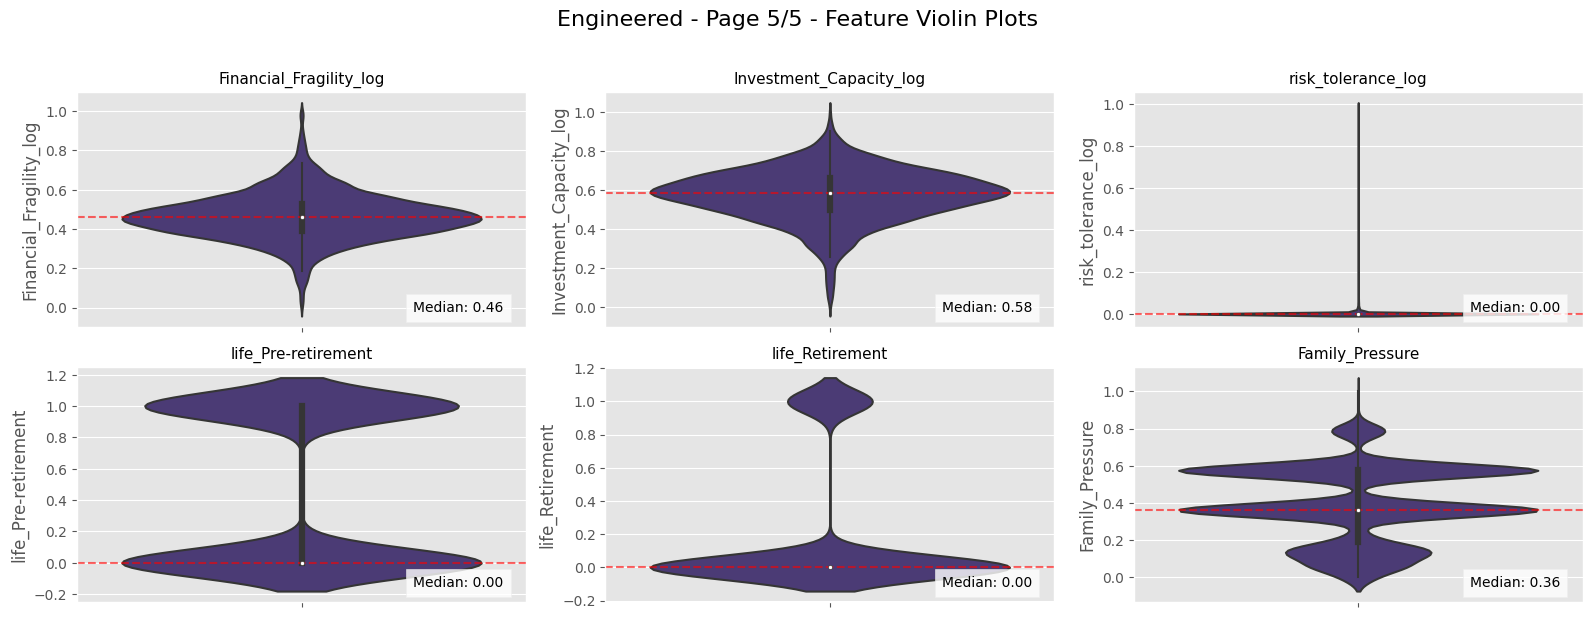



===== CORRELATION ANALYSIS =====

Processing correlations for Baseline DataFrame (1/3)...
Calculating correlations for 7 features...
Creating full correlation matrix for Baseline...


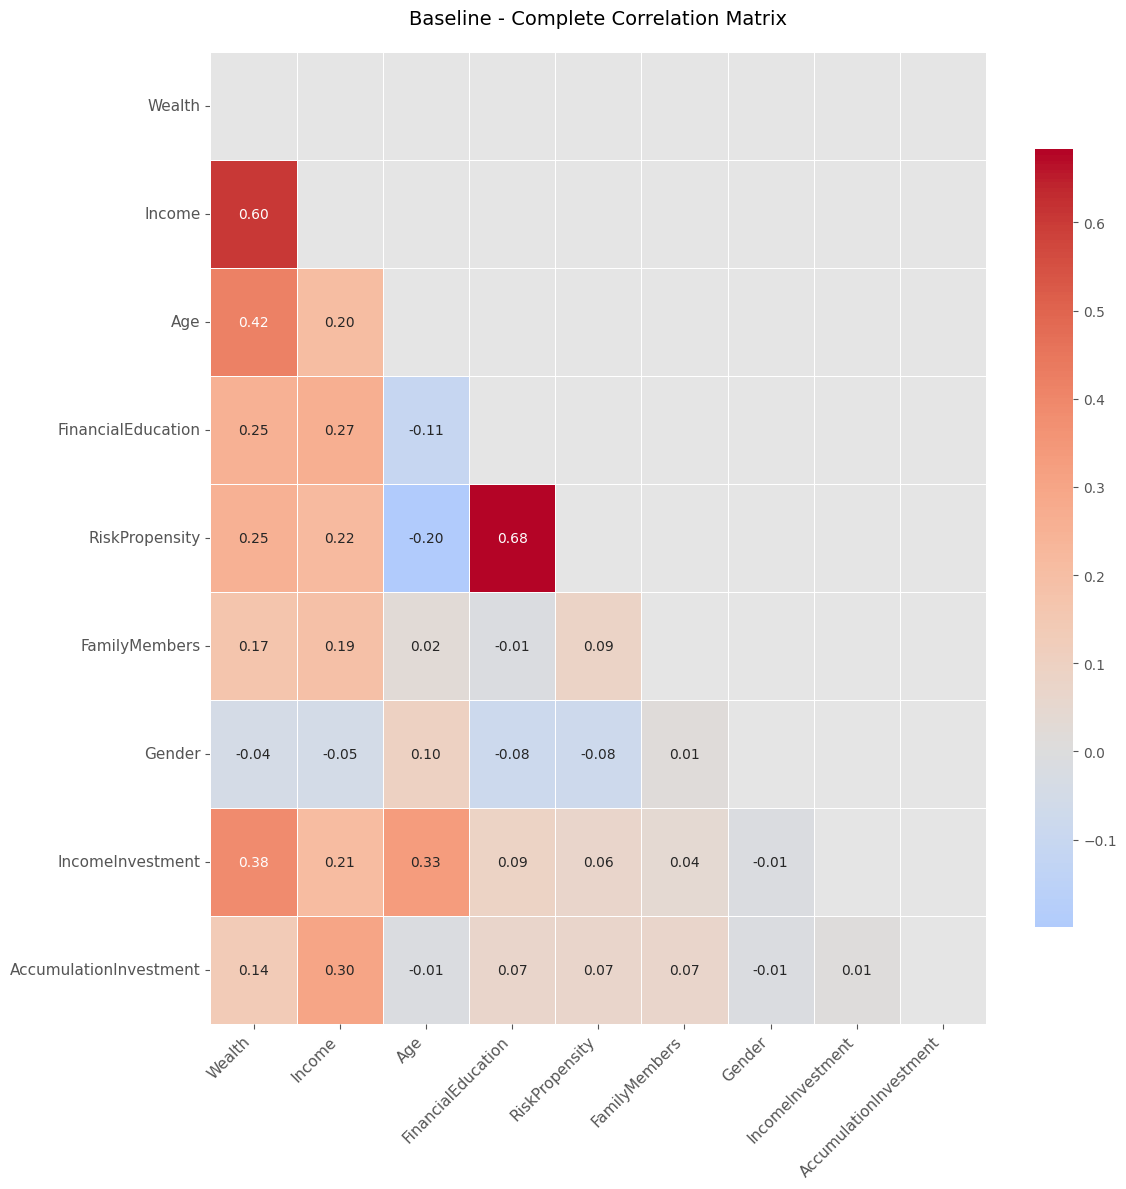

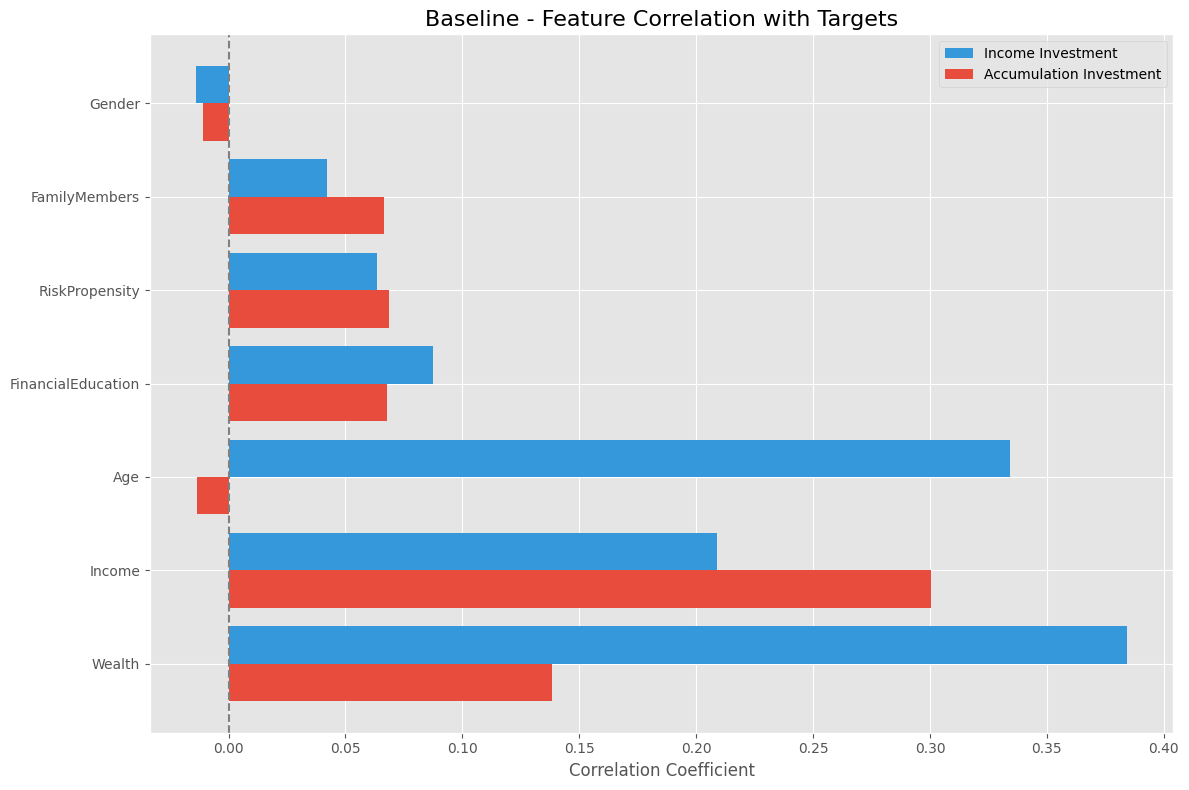


Processing correlations for Baseline_Log_Transformed DataFrame (2/3)...
Calculating correlations for 7 features...
Creating full correlation matrix for Baseline_Log_Transformed...


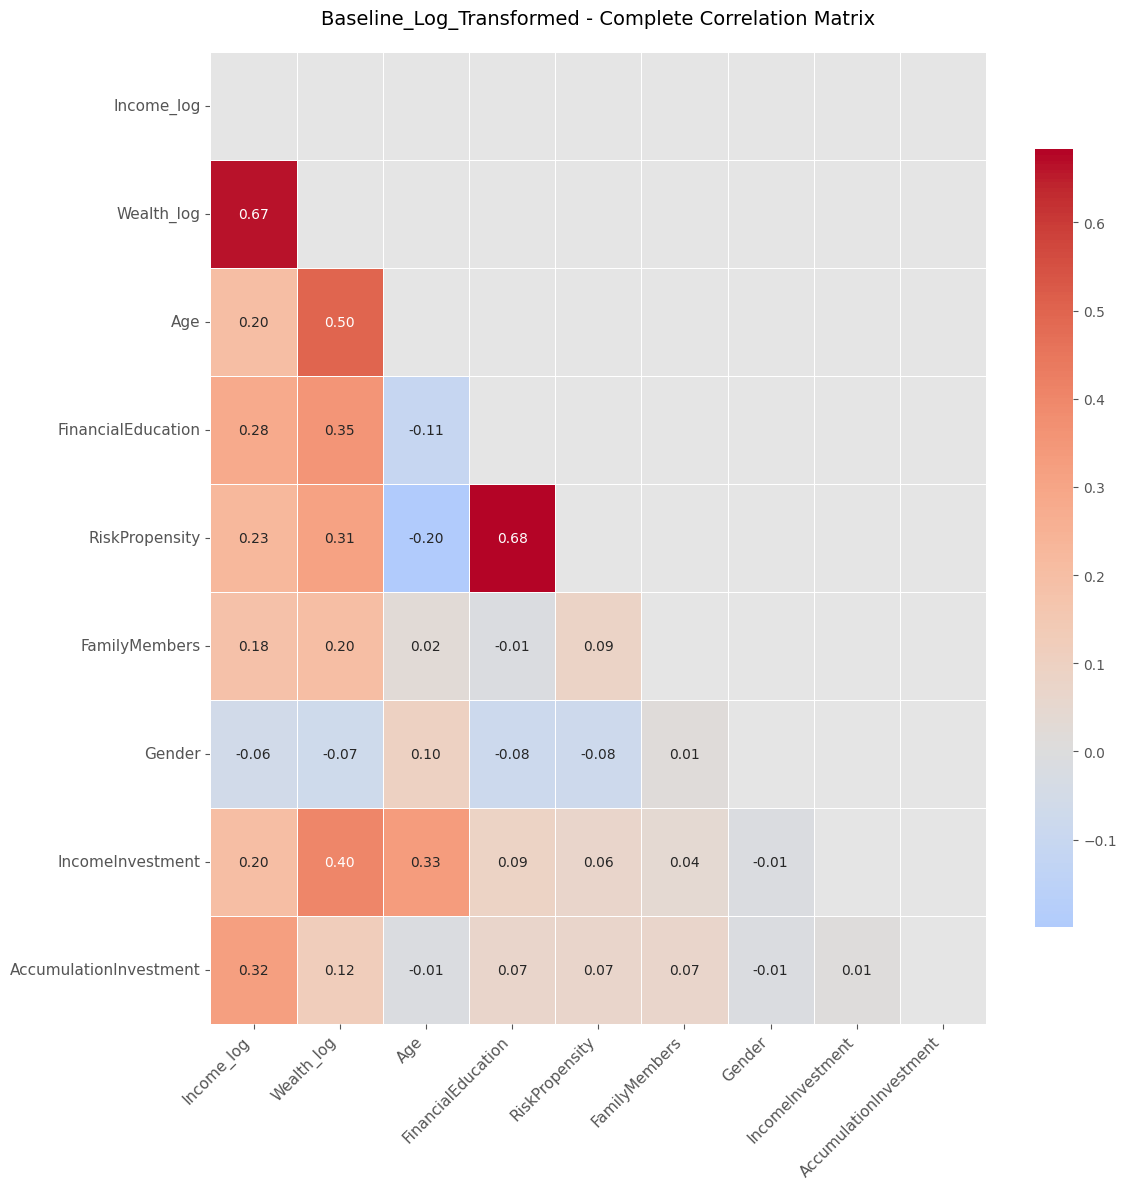

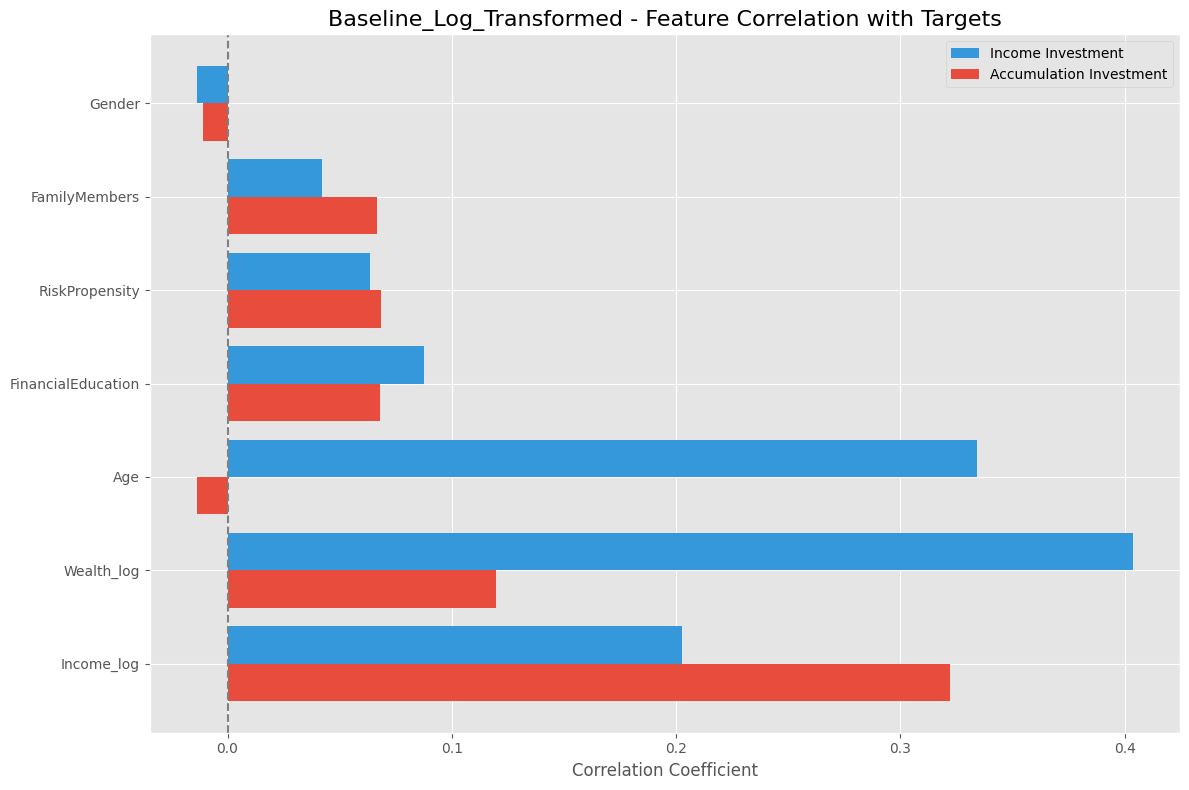


Processing correlations for Engineered DataFrame (3/3)...
Calculating correlations for 42 features...
Creating full correlation matrix for Engineered...


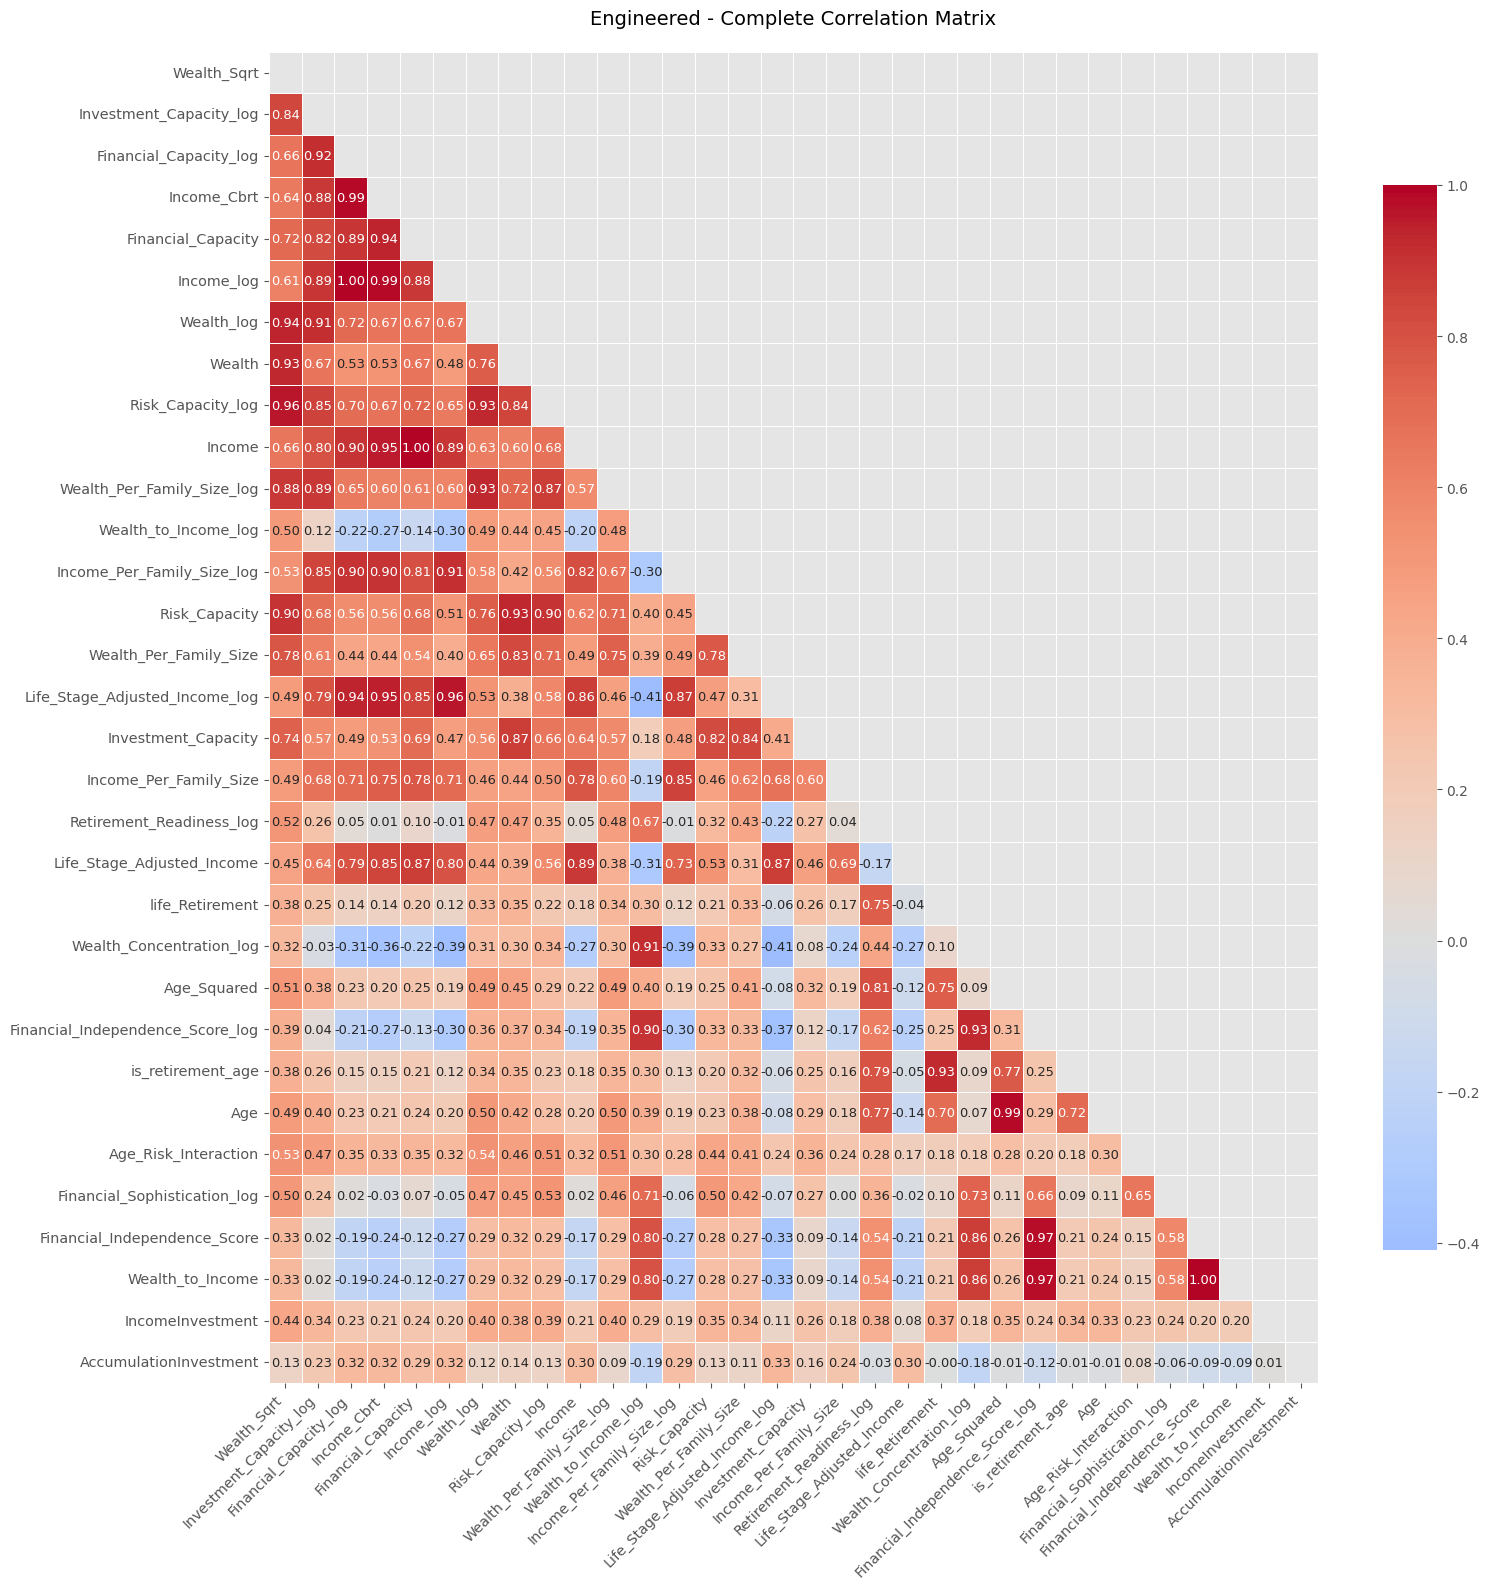

Limiting feature importance plot to top 30 features


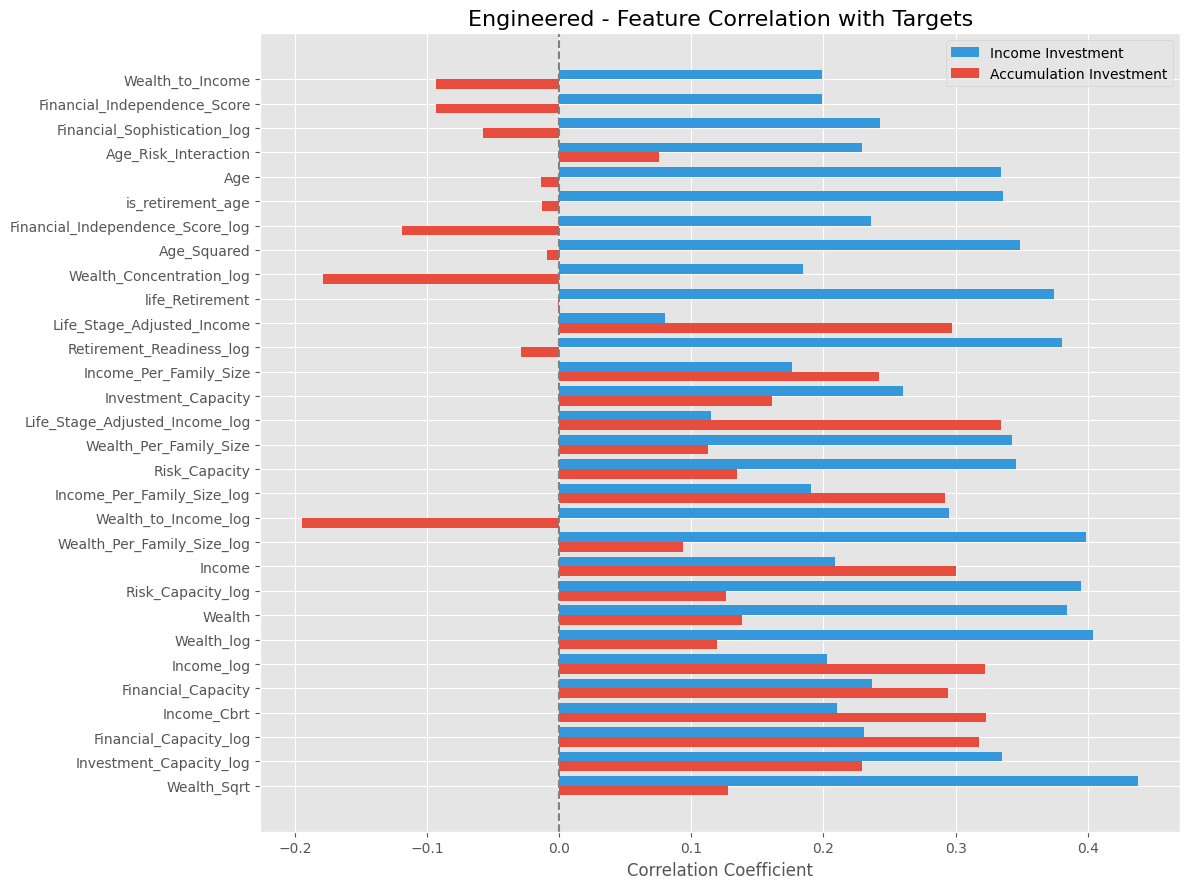



===== FEATURE COMPARISON ACROSS DATAFRAMES =====
Found 3 common features. Creating 1 comparison pages...
  Processing comparison batch 1/1 for Baseline...


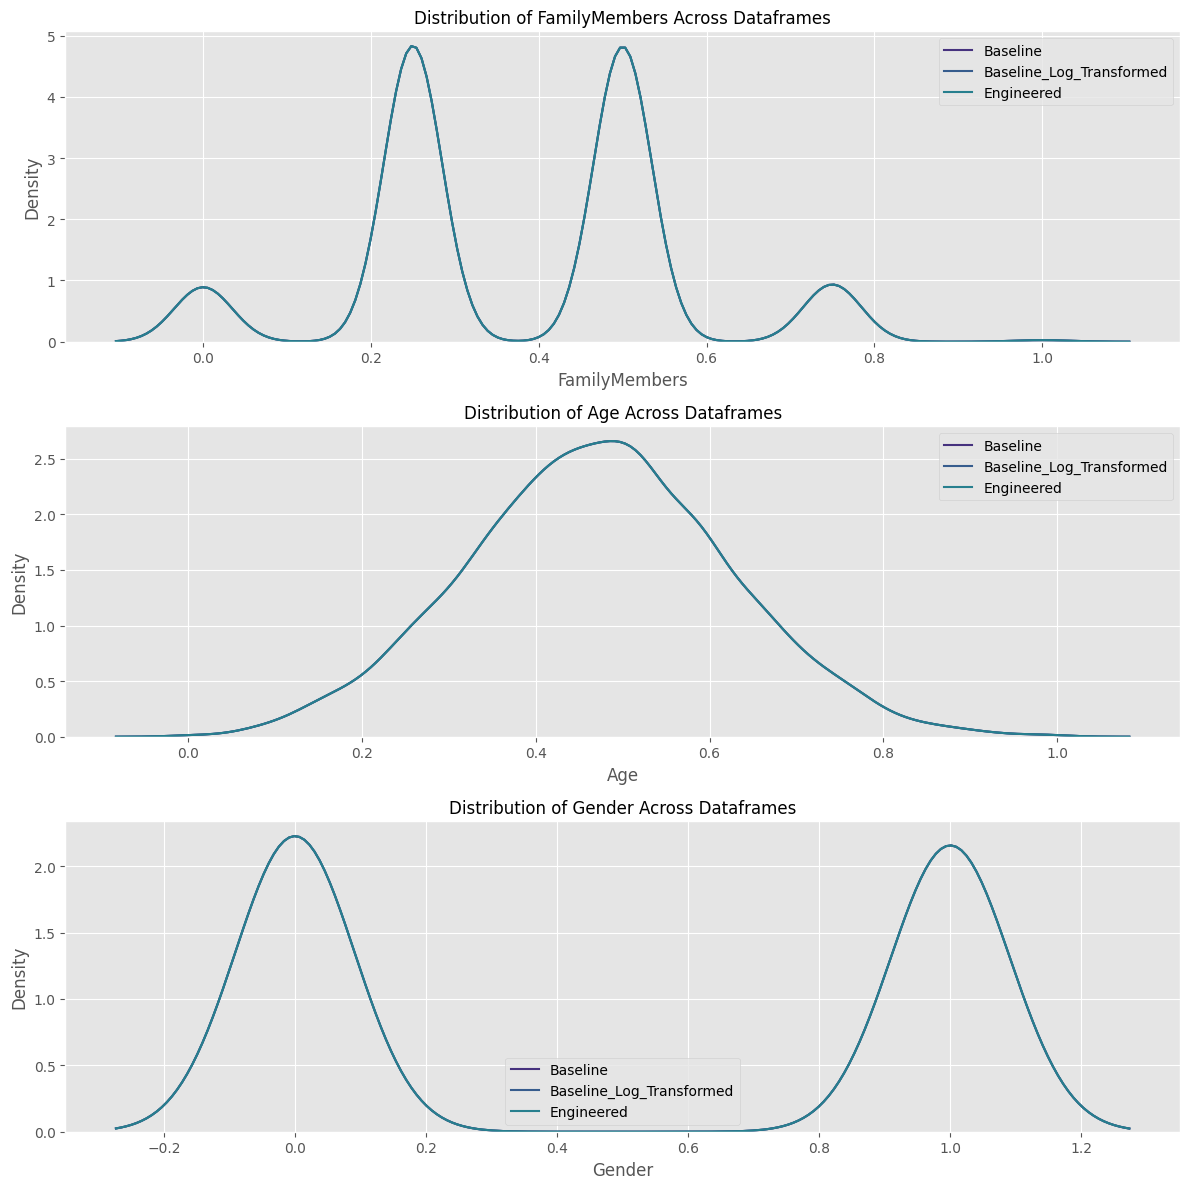

  Processing comparison batch 1/1 for Baseline_Log_Transformed...


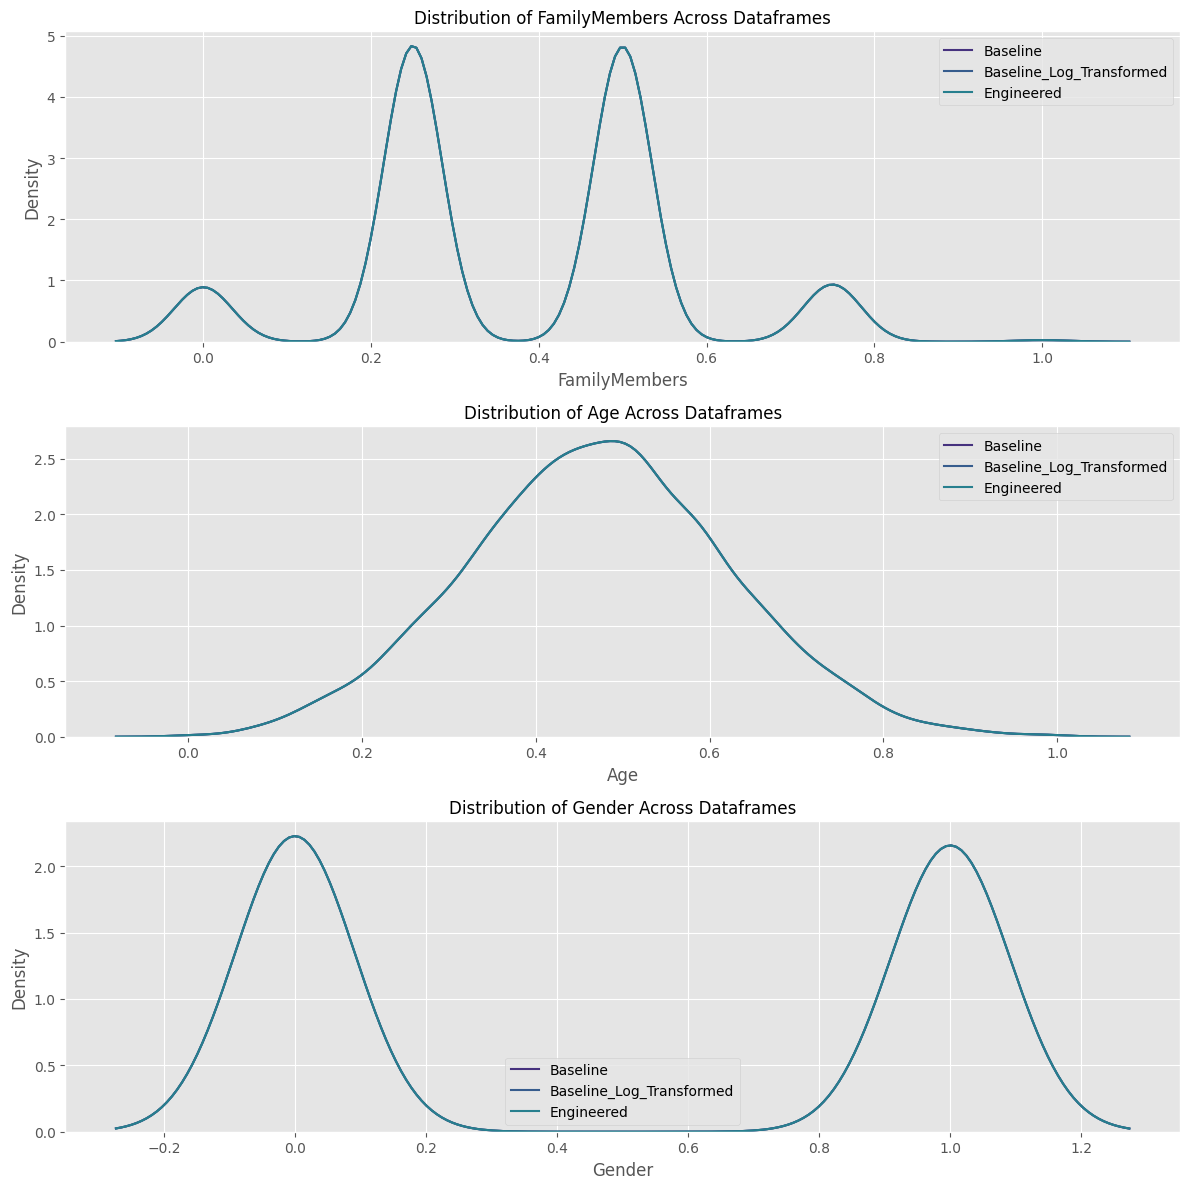

  Processing comparison batch 1/1 for Engineered...


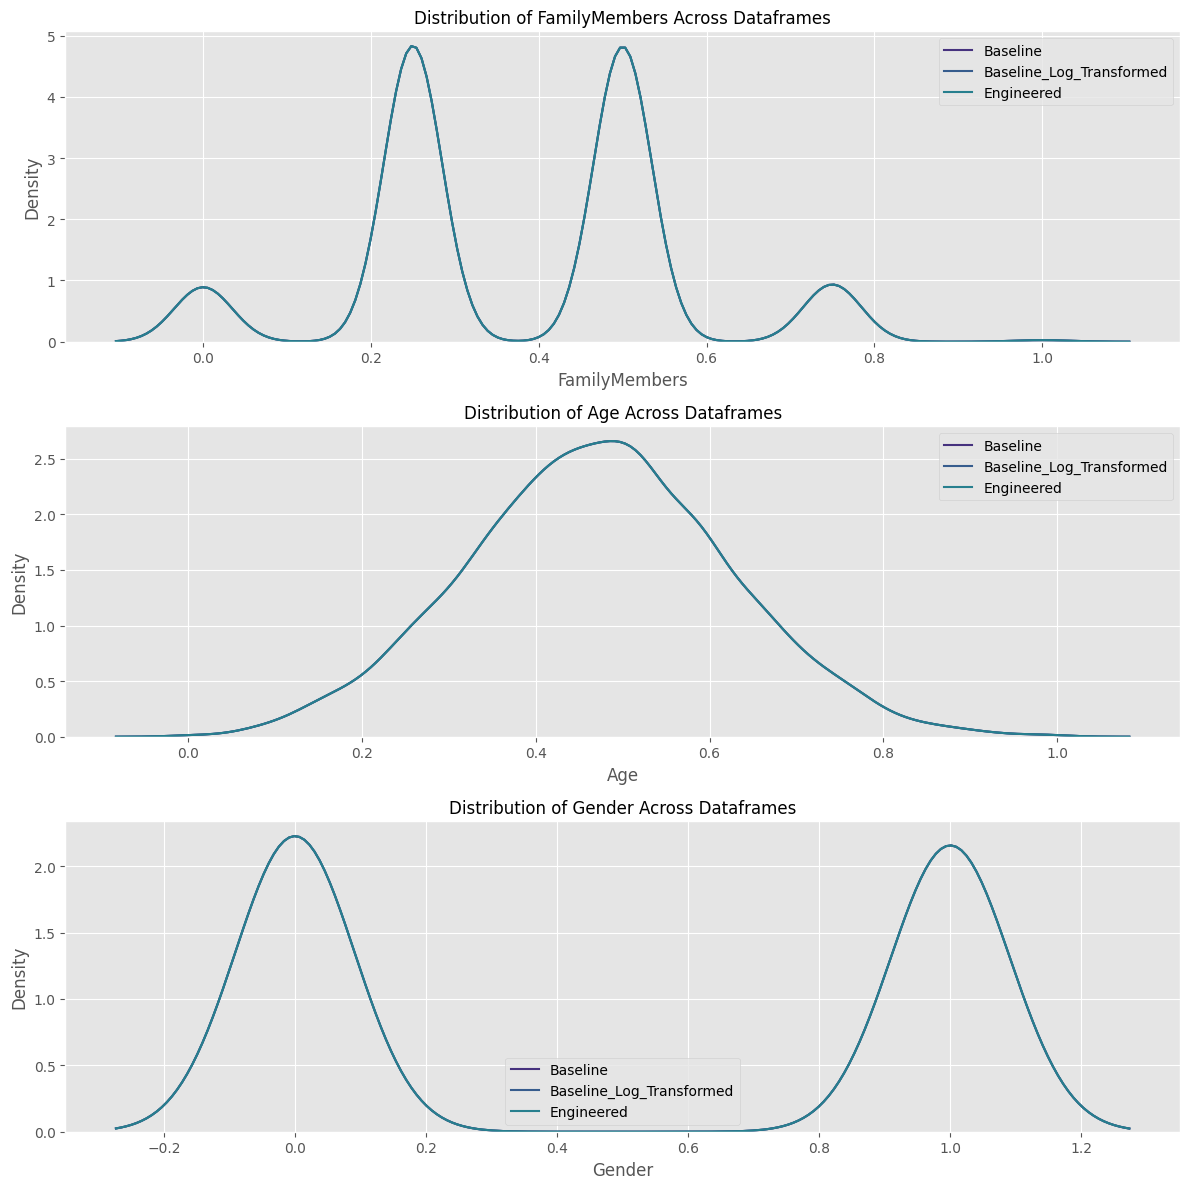

In [7]:
# =====================================================================================
# OPTIMIZED ADAPTIVE GRAPHICAL DISTRIBUTION AND CORRELATION ANALYSIS
# =====================================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import time
import gc  # Garbage collection
import os  # For directory creation
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set_palette("viridis")  # Keep the purple color scheme
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def analyze_dataframes(df_list, titles, save_plots=True):
    """
    Optimized analysis of multiple dataframes with all correlations on single page.
    Saves plots in separate folders based on dataset title.
    """
    print("\n===== DATAFRAME ANALYSIS =====")
    
    # Create output directories for each dataset if they don't exist
    output_dirs = {}
    for title in titles:
        folder_name = f"{title.lower().replace(' ', '_')}_plots"
        os.makedirs(folder_name, exist_ok=True)
        output_dirs[title] = folder_name
    
    # Check what's in each dataframe
    for i, (df, title) in enumerate(zip(df_list, titles)):
        print(f"\n{title} DataFrame:")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {len(df.columns)}")
        
        # Identify column types
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        binary_cols = [col for col in numeric_cols if df[col].nunique() <= 2]
        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        
        print(f"  Numeric columns: {len(numeric_cols)}")
        print(f"  Binary columns: {len(binary_cols)}")
        print(f"  Categorical columns: {len(cat_cols)}")
        
        # Check for target variables
        has_income = 'IncomeInvestment' in df.columns
        has_accum = 'AccumulationInvestment' in df.columns
        print(f"  Has target variables: {'Yes' if has_income and has_accum else 'No'}")
    
    # 1. TARGET DISTRIBUTIONS (if targets exist)
    print("\n\n===== TARGET DISTRIBUTIONS =====")
    if all('IncomeInvestment' in df.columns and 'AccumulationInvestment' in df.columns for df in df_list):
        # Save target distributions in each output directory
        for title, output_dir in output_dirs.items():
            plot_target_distributions(df_list, titles, save_plots, output_dir)
    else:
        print("Target variables not found in all dataframes. Skipping target distribution plots.")
    
    # 2. FEATURE DISTRIBUTIONS
    print("\n\n===== FEATURE DISTRIBUTIONS =====")
    for df_idx, (df, title) in enumerate(zip(df_list, titles)):
        output_dir = output_dirs[title]
        print(f"\nProcessing {title} DataFrame ({df_idx+1}/{len(df_list)})...")
        print(f"Saving plots to: {output_dir}")
        
        # Find important numeric features
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        
        # Remove target variables if they exist
        for target in ['IncomeInvestment', 'AccumulationInvestment']:
            if target in numeric_cols:
                numeric_cols.remove(target)
        
        # Create optimized batches of features (smaller batches for better performance)
        feature_batches = [numeric_cols[i:i+9] for i in range(0, len(numeric_cols), 9)]
        
        print(f"Found {len(numeric_cols)} features. Creating {len(feature_batches)} pages...")
        
        # Process each batch
        for batch_idx, feature_batch in enumerate(feature_batches):
            print(f"  Processing batch {batch_idx+1}/{len(feature_batches)} with {len(feature_batch)} features...")
            plot_feature_distributions(df, f"{title} - Page {batch_idx+1}/{len(feature_batches)}", 
                                      feature_batch, save_plots, output_dir)
            
            # Clear matplotlib memory
            plt.close('all')
            gc.collect()
    
    # 3. CORRELATION ANALYSIS - UPDATED to show all correlations on one page
    print("\n\n===== CORRELATION ANALYSIS =====")
    for df_idx, (df, title) in enumerate(zip(df_list, titles)):
        output_dir = output_dirs[title]
        if 'IncomeInvestment' in df.columns and 'AccumulationInvestment' in df.columns:
            print(f"\nProcessing correlations for {title} DataFrame ({df_idx+1}/{len(df_list)})...")
            
            # Get all features (excluding targets)
            feature_cols = df.columns.difference(['IncomeInvestment', 'AccumulationInvestment']).tolist()
            
            # Calculate all correlations with targets in one go
            print(f"Calculating correlations for {len(feature_cols)} features...")
            corr_data = []
            for col in feature_cols:
                corr_income = df[col].corr(df['IncomeInvestment'])
                corr_accum = df[col].corr(df['AccumulationInvestment'])
                avg_abs_corr = (abs(corr_income) + abs(corr_accum)) / 2
                corr_data.append({
                    'Feature': col,
                    'Income Correlation': corr_income,
                    'Accumulation Correlation': corr_accum,
                    'Avg Abs Correlation': avg_abs_corr
                })
            
            corr_df = pd.DataFrame(corr_data)
            
            # Sort features by correlation and get top features
            sorted_features = corr_df.sort_values('Avg Abs Correlation', ascending=False)['Feature'].tolist()
            top_features = sorted_features[:min(30, len(sorted_features))]
            
            # Plot full correlation matrix with all features on one page
            print(f"Creating full correlation matrix for {title}...")
            plot_full_correlation_matrix(df, title, top_features, save_plots, output_dir)
            
            # Plot feature importance for all features
            plot_feature_importance(df, title, sorted_features, corr_df, save_plots, output_dir)
            
            # Clear matplotlib memory
            plt.close('all')
            gc.collect()
    
    # 4. FEATURE COMPARISON ACROSS DATAFRAMES
    print("\n\n===== FEATURE COMPARISON ACROSS DATAFRAMES =====")
    # Find common features across all dataframes
    common_numeric_features = set.intersection(*[
        set(df.select_dtypes(include=['float64', 'int64']).columns) 
        for df in df_list
    ])
    
    for target in ['IncomeInvestment', 'AccumulationInvestment']:
        if target in common_numeric_features:
            common_numeric_features.remove(target)
    
    common_features_list = list(common_numeric_features)
    
    if common_features_list:
        # Create batches for comparison plots (5 features per batch)
        comparison_batches = [common_features_list[i:i+5] for i in range(0, len(common_features_list), 5)]
        
        print(f"Found {len(common_features_list)} common features. Creating {len(comparison_batches)} comparison pages...")
        
        # Save comparison plots in each output directory
        for title, output_dir in output_dirs.items():
            for batch_idx, feature_batch in enumerate(comparison_batches):
                print(f"  Processing comparison batch {batch_idx+1}/{len(comparison_batches)} for {title}...")
                compare_features_across_dataframes(df_list, titles, feature_batch, save_plots, output_dir, batch_idx+1)
                
                # Clear matplotlib memory
                plt.close('all')
                gc.collect()
    else:
        print("No common numerical features found across all dataframes for comparison.")


# PLOTTING FUNCTIONS
# --------------------------

def plot_target_distributions(df_list, titles, save_plots=True, output_dir='.'):
    """Plot distribution of target variables across dataframes"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot IncomeInvestment distribution
    income_data = []
    for df in df_list:
        counts = df['IncomeInvestment'].value_counts(normalize=True) * 100
        income_data.append({
            'No (0)': counts.get(0, 0),
            'Yes (1)': counts.get(1, 0),
        })
    
    income_df = pd.DataFrame(income_data, index=titles)
    income_df.plot(kind='bar', stacked=True, ax=axes[0], 
                   color=['#3498db', '#e74c3c'])
    axes[0].set_title('Income Investment Distribution', fontsize=14)
    axes[0].set_ylabel('Percentage (%)', fontsize=12)
    axes[0].set_ylim([0, 100])
    
    # Add percentage labels
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
    
    # Plot AccumulationInvestment distribution
    accum_data = []
    for df in df_list:
        counts = df['AccumulationInvestment'].value_counts(normalize=True) * 100
        accum_data.append({
            'No (0)': counts.get(0, 0),
            'Yes (1)': counts.get(1, 0),
        })
    
    accum_df = pd.DataFrame(accum_data, index=titles)
    accum_df.plot(kind='bar', stacked=True, ax=axes[1], 
                  color=['#3498db', '#e74c3c'])
    axes[1].set_title('Accumulation Investment Distribution', fontsize=14)
    axes[1].set_ylabel('Percentage (%)', fontsize=12)
    axes[1].set_ylim([0, 100])
    
    # Add percentage labels
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(f'{output_dir}/target_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_feature_distributions(df, title, feature_cols, save_plots=True, output_dir='.'):
    """Optimized plot histograms, boxplots, and violin plots for selected features"""
    if not feature_cols:
        print(f"No features to plot for {title}")
        return
    
    n_features = len(feature_cols)
    n_cols = min(3, n_features)
    n_rows = math.ceil(n_features / n_cols)
    
    # Create histograms
    fig = plt.figure(figsize=(16, max(4, 3*n_rows)))
    fig.suptitle(f"{title} - Feature Distributions", fontsize=16, y=1.02)
    
    for i, col in enumerate(feature_cols):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(col, fontsize=11)
        
    plt.tight_layout()
    if save_plots:
        cleaned_title = title.lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        plt.savefig(f'{output_dir}/{cleaned_title}_histograms.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create boxplots
    fig = plt.figure(figsize=(16, max(4, 3*n_rows)))
    fig.suptitle(f"{title} - Feature Boxplots", fontsize=16, y=1.02)
    
    for i, col in enumerate(feature_cols):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        sns.boxplot(y=df[col], ax=ax)
        ax.set_title(col, fontsize=11)
        
    plt.tight_layout()
    if save_plots:
        cleaned_title = title.lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        plt.savefig(f'{output_dir}/{cleaned_title}_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create violin plots with the same purple color scheme
    fig = plt.figure(figsize=(16, max(4, 3*n_rows)))
    fig.suptitle(f"{title} - Feature Violin Plots", fontsize=16, y=1.02)
    
    # Get the current viridis color palette
    current_palette = sns.color_palette("viridis")
    main_purple = current_palette[0]  # Use the first color from viridis for consistency
    
    for i, col in enumerate(feature_cols):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        # Use the exact same purple color for all violin plots
        sns.violinplot(y=df[col], ax=ax, color=main_purple)
        
        # Add median line for better readability
        median = df[col].median()
        ax.axhline(median, color='red', linestyle='--', alpha=0.6)
        
        # Add text with basic statistics
        stats_text = f"Median: {median:.2f}"
        ax.text(0.95, 0.05, stats_text, transform=ax.transAxes, 
                verticalalignment='bottom', horizontalalignment='right',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
        
        ax.set_title(col, fontsize=11)
        
    plt.tight_layout()
    if save_plots:
        cleaned_title = title.lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        plt.savefig(f'{output_dir}/{cleaned_title}_violinplots.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_full_correlation_matrix(df, title, features, save_plots=True, output_dir='.'):
    """Plot full correlation matrix with all features on one page"""
    # Add target variables to feature columns for correlation matrix
    all_cols = features + ['IncomeInvestment', 'AccumulationInvestment']
    
    # Calculate correlation matrix for all selected features
    corr_matrix = df[all_cols].corr()
    
    # Determine appropriate figure size and font size based on number of features
    n_features = len(all_cols)
    fig_size = min(20, max(12, n_features * 0.5))
    fig = plt.figure(figsize=(fig_size, fig_size))
    
    # Adjust font size for readability
    font_size = max(5, min(10, 300 / n_features))
    
    # Create mask for upper triangle to reduce redundant information
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot full correlation matrix
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8},
                annot_kws={"size": font_size})
    
    plt.title(f'{title} - Complete Correlation Matrix', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=font_size+1)
    plt.yticks(fontsize=font_size+1)
    plt.tight_layout()
    
    if save_plots:
        cleaned_title = title.lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        plt.savefig(f'{output_dir}/{cleaned_title}_full_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_feature_importance(df, title, features, corr_df, save_plots=True, output_dir='.', max_features=30):
    """Plot feature importance for all features on one page"""
    # Select top features if there are too many
    if len(features) > max_features:
        print(f"Limiting feature importance plot to top {max_features} features")
        features = features[:max_features]
    
    # Filter correlation data for selected features
    plot_data = corr_df[corr_df['Feature'].isin(features)].sort_values('Avg Abs Correlation')
    
    # Calculate appropriate figure size based on number of features
    fig_height = max(8, len(features) * 0.3)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    
    y_pos = np.arange(len(plot_data))
    ax.barh(y_pos, plot_data['Income Correlation'], height=0.4, align='center', 
            color='#3498db', label='Income Investment')
    ax.barh(y_pos + 0.4, plot_data['Accumulation Correlation'], height=0.4, align='center', 
            color='#e74c3c', label='Accumulation Investment')
    
    ax.set_yticks(y_pos + 0.2)
    ax.set_yticklabels(plot_data['Feature'])
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_xlabel('Correlation Coefficient', fontsize=12)
    ax.set_title(f'{title} - Feature Correlation with Targets', fontsize=16)
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.legend()
    
    plt.tight_layout()
    if save_plots:
        cleaned_title = title.lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        plt.savefig(f'{output_dir}/{cleaned_title}_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

def compare_features_across_dataframes(df_list, titles, features, save_plots=True, output_dir='.', page=1):
    """Optimized comparison of features across dataframes"""
    n_features = len(features)
    
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
    if n_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(features):
        for df, title in zip(df_list, titles):
            if feature in df.columns:
                sns.kdeplot(df[feature], ax=axes[i], label=title)
        
        axes[i].set_title(f'Distribution of {feature} Across Dataframes', fontsize=12)
        axes[i].legend()
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(f'{output_dir}/feature_comparison_page{page}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the analysis with optimized plotting and separate output folders
df_list = [baseline_df, baseline_log_df, engineered_df]
titles = ["Baseline", "Baseline_Log_Transformed", "Engineered"]
analyze_dataframes(df_list, titles, save_plots=True)

# Optimized Clustering Analysis for Financial Client Segmentation

This section implements an advanced clustering approach to segment clients based on their financial profiles and investment needs. The segmentation will help identify natural groups of clients with similar characteristics, which can improve our investment need predictions.

## Feature Selection for Clustering

First, we create an optimized feature set specifically for clustering by:
- Categorizing features into meaningful financial domains
- Assessing feature importance for each target variable 
- Selecting a balanced representation of features from each category
- Ensuring key predictive features are retained

This balanced selection provides the clustering algorithm with relevant information while maintaining model interpretability.


In [8]:
# =====================================================================================
# CREATE COMPREHENSIVE OPTIMIZED FEATURE SET FOR CLUSTERING
# =====================================================================================
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

print("\nCREATING COMPREHENSIVE OPTIMIZED FEATURE SET")
print("==========================================")

# Start with engineered_df (keeping target variables)
X_with_targets = engineered_df.copy()

# 1. DEFINE FEATURE CATEGORIES FOR BALANCED SELECTION
# -----------------------------------
print("\n1. Categorizing features for balanced selection...")

# Categorical/binary features
categorical_cols = ['Gender', 'is_retirement_age', 'life_Pre-retirement', 'life_Retirement']

# Demographic features
demographic_cols = ['Age', 'FamilyMembers', 'Age_Squared']

# Core financial features (LOG VERSIONS - PREFERRED FOR CLUSTERING)
financial_log_cols = ['Income_log', 'Wealth_log', 'Wealth_to_Income_log', 'Financial_Capacity_log',
                     'Wealth_Per_Family_Size_log', 'Income_Per_Family_Size_log', 
                     'Risk_Capacity_log', 'Investment_Capacity_log']

# Risk and education features
risk_education_cols = ['Education_Risk_Profile', 'FinancialEducation_Squared', 
                      'Financial_Sophistication_log', 'Financial_Sophistication_Ratio',
                      'risk_tolerance_log', 'Financial_Fragility_log']

# Retirement and future planning features
retirement_cols = ['Retirement_Readiness_log', 'Financial_Independence_Score_log',
                  'Life_Stage_Adjusted_Income_log', 'Family_Pressure']

# Interaction features
interaction_cols = ['Age_Risk_Interaction', 'Gender_Age_Risk', 'Wealth_Concentration_log']

# 2. FEATURE IMPORTANCE BASED ON TARGETS
# -----------------------------------
print("2. Analyzing feature importance for targets...")
X_for_importance = X_with_targets.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
target_features = {}

for target_name, target_var in [
    ("Income Investment", X_with_targets['IncomeInvestment']),
    ("Accumulation Investment", X_with_targets['AccumulationInvestment'])
]:
    # Train a simple random forest to identify important features
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_for_importance, target_var)
    
    # Get feature importances
    importances = pd.Series(rf.feature_importances_, index=X_for_importance.columns)
    top_features = importances.sort_values(ascending=False)
    target_features[target_name] = top_features

    # Print top 10 features for this target
    print(f"\nTop 10 features for {target_name}:")
    for feature, importance in top_features.head(10).items():
        print(f"  * {feature}: {importance:.4f}")

# 3. CREATE BALANCED FEATURE SET WITH CATEGORY REPRESENTATION
# -----------------------------------
print("\n3. Creating balanced feature set...")

# Features to include from each category
selected_features = []

# Add top features from each category (maintain category representation)
category_selections = {
    "Categorical": (categorical_cols, 3),  # include up to 3 categorical features
    "Demographic": (demographic_cols, 3),  # include all demographic features
    "Financial": (financial_log_cols, 5),  # include 5 financial features
    "Risk & Education": (risk_education_cols, 4),  # include 4 risk features
    "Retirement": (retirement_cols, 3),  # include 3 retirement features
    "Interaction": (interaction_cols, 2)   # include 2 interaction features
}

# Get average feature importance across both targets
avg_importance = pd.DataFrame({
    'Income': target_features["Income Investment"],
    'Accumulation': target_features["Accumulation Investment"]
})
avg_importance['Average'] = avg_importance.mean(axis=1)

# Select top N features from each category based on importance
for category_name, (category_cols, num_to_select) in category_selections.items():
    # Get features in this category that exist in our dataset
    available_cols = [col for col in category_cols if col in X_for_importance.columns]
    
    if available_cols:
        # Sort by average importance
        category_importance = avg_importance.loc[available_cols, 'Average'].sort_values(ascending=False)
        
        # Take top N features from this category
        top_category_features = category_importance.head(num_to_select).index.tolist()
        
        # Add to selected features
        selected_features.extend(top_category_features)
        
        print(f"\n{category_name} features selected ({len(top_category_features)}):")
        for feature in top_category_features:
            importance = avg_importance.loc[feature, 'Average']
            print(f"  * {feature}: {importance:.4f}")

# 4. ADD TOP OVERALL FEATURES NOT ALREADY INCLUDED
# -----------------------------------
print("\n4. Adding top overall features not already included...")

# Add top overall features if not already selected (to ensure we get the most predictive)
top_overall = avg_importance['Average'].sort_values(ascending=False).head(15).index.tolist()
for feature in top_overall:
    if feature not in selected_features:
        selected_features.append(feature)
        print(f"  + Added {feature} (top overall feature)")

# 5. CREATE THE OPTIMIZED DATAFRAME
# -----------------------------------
# Remove duplicates while preserving order
selected_features = list(dict.fromkeys(selected_features))

# Add target variables to the final feature list
final_features = selected_features + ['IncomeInvestment', 'AccumulationInvestment']

# Create optimized dataframe with selected features
engineered_optimised_df = engineered_df[final_features].copy()

print(f"\nOptimized feature set contains {len(selected_features)} features (plus 2 targets)")
print(f"Original engineered_df had {len(engineered_df.columns)-2} features (plus 2 targets)")

# Print final selected features
print("\nSelected features for engineered_optimised_df:")
for i, feature in enumerate(selected_features):
    # Find which category this feature belongs to
    category = "Other"
    for cat_name, (cat_cols, _) in category_selections.items():
        if feature in cat_cols:
            category = cat_name
            break
    
    # Get importance score
    importance = avg_importance.loc[feature, 'Average'] if feature in avg_importance.index else 0
    print(f"  {i+1}. {feature} ({category}, importance: {importance:.4f})")

print("\nTarget variables included:")
print("  - IncomeInvestment")
print("  - AccumulationInvestment")

# Display dataframe info
print("\nEngineered optimized dataframe shape:", engineered_optimised_df.shape)


CREATING COMPREHENSIVE OPTIMIZED FEATURE SET

1. Categorizing features for balanced selection...
2. Analyzing feature importance for targets...

Top 10 features for Income Investment:
  * Wealth_log: 0.0601
  * Wealth_Sqrt: 0.0589
  * Wealth: 0.0517
  * Wealth_Per_Family_Size: 0.0407
  * Wealth_Per_Family_Size_log: 0.0404
  * Risk_Capacity_log: 0.0392
  * Age_Squared: 0.0327
  * Risk_Capacity: 0.0327
  * Wealth_to_Income_log: 0.0310
  * Retirement_Readiness: 0.0307

Top 10 features for Accumulation Investment:
  * Financial_Independence_Score_log: 0.0592
  * Financial_Independence_Score: 0.0553
  * Wealth_Sqrt: 0.0527
  * Wealth_to_Income_log: 0.0482
  * Wealth: 0.0477
  * Wealth_to_Income: 0.0471
  * Wealth_log: 0.0415
  * Wealth_Concentration_log: 0.0295
  * Age_Squared: 0.0291
  * Retirement_Readiness: 0.0286

3. Creating balanced feature set...

Categorical features selected (3):
  * is_retirement_age: 0.0119
  * life_Retirement: 0.0099
  * Gender: 0.0026

Demographic features sel

## GPU-Accelerated Distance Matrix Calculation

Next, we compute various distance matrices using GPU acceleration to handle our high-dimensional data efficiently. Different distance metrics capture different aspects of similarity between clients:

- **Standard metrics**: Euclidean (straight-line distance), Manhattan (grid-like distance), Cosine (angle-based similarity)
- **Advanced metrics**: Mahalanobis (accounts for feature correlations), Gower (handles mixed data types)
- **Domain-specific metrics**: Financial hybrid distance (weighted by domain knowledge)

These distance matrices will serve as inputs to our clustering algorithm, allowing us to find the metric that best captures meaningful financial similarities.


In [9]:
# -------------------------
# Create GPU-Accelerated Custom Distance Matrices for Optimized Feature Set
# -------------------------
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform, mahalanobis, jensenshannon
from scipy.linalg import inv
import time
import torch

print("\nGPU-ACCELERATED DISTANCE MATRIX CALCULATION")
print("=========================================")

# Set up GPU device if available (Apple M4 Max)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device} for distance matrix calculations")

# Use our optimized feature set for clustering
X_for_clustering = engineered_optimised_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)

# Prepare feature groups based on our optimized categorization
categorical_cols = [col for col in X_for_clustering.columns if 
                    col in ['Gender', 'is_retirement_age', 'life_Pre-retirement', 'life_Retirement']]

demographic_cols = [col for col in X_for_clustering.columns if 
                   col in ['Age', 'FamilyMembers', 'Age_Squared']]

financial_cols = [col for col in X_for_clustering.columns if 
                 col in ['Income_log', 'Wealth_log', 'Wealth_to_Income_log', 'Financial_Capacity_log',
                         'Wealth_Per_Family_Size_log', 'Income_Per_Family_Size_log', 
                         'Risk_Capacity_log', 'Investment_Capacity_log']]

risk_education_cols = [col for col in X_for_clustering.columns if 
                      col in ['Education_Risk_Profile', 'FinancialEducation_Squared', 
                             'Financial_Sophistication_log', 'Financial_Sophistication_Ratio',
                             'risk_tolerance_log', 'Financial_Fragility_log']]

retirement_cols = [col for col in X_for_clustering.columns if 
                  col in ['Retirement_Readiness_log', 'Financial_Independence_Score_log',
                         'Life_Stage_Adjusted_Income_log', 'Family_Pressure']]

interaction_cols = [col for col in X_for_clustering.columns if 
                   col in ['Age_Risk_Interaction', 'Gender_Age_Risk', 'Wealth_Concentration_log']]

# Create numeric and categorical subsets
X_num = X_for_clustering.drop(columns=categorical_cols, errors='ignore')
X_cat = X_for_clustering[categorical_cols] if categorical_cols else pd.DataFrame(index=X_for_clustering.index)

# Create domain-specific subsets
X_demographic = X_for_clustering[demographic_cols] if demographic_cols else pd.DataFrame(index=X_for_clustering.index)
X_financial = X_for_clustering[financial_cols] if financial_cols else pd.DataFrame(index=X_for_clustering.index)
X_risk_edu = X_for_clustering[risk_education_cols] if risk_education_cols else pd.DataFrame(index=X_for_clustering.index)
X_retirement = X_for_clustering[retirement_cols] if retirement_cols else pd.DataFrame(index=X_for_clustering.index)

# Print feature group sizes for validation
print(f"\nFeature groups in optimized dataset:")
print(f"  - Total features: {X_for_clustering.shape[1]}")
print(f"  - Categorical features: {len(categorical_cols)}")
print(f"  - Numeric features: {X_num.shape[1]}")
print(f"  - Demographic features: {X_demographic.shape[1]}")
print(f"  - Financial features: {X_financial.shape[1]}")
print(f"  - Risk & Education features: {X_risk_edu.shape[1]}")
print(f"  - Retirement features: {X_retirement.shape[1]}")
print(f"  - Interaction features: {len(interaction_cols)}")

# Convert to numpy arrays for processing
X_clustering_np = X_for_clustering.to_numpy().astype('float64')
X_num_np = X_num.to_numpy().astype('float64')
X_cat_numeric = pd.get_dummies(X_cat).astype('float64')
X_cat_np = X_cat_numeric.to_numpy().astype('float64')
X_demographic_np = X_demographic.to_numpy().astype('float64')
X_financial_np = X_financial.to_numpy().astype('float64')
X_risk_edu_np = X_risk_edu.to_numpy().astype('float64')
X_retirement_np = X_retirement.to_numpy().astype('float64')

# Check for any NaN values that might cause issues
print(f"\nChecking for NaN values:")
print(f"  - NaN in X_clustering: {np.isnan(X_clustering_np).sum()}")
print(f"  - NaN in X_num: {np.isnan(X_num_np).sum()}")
print(f"  - NaN in X_cat: {np.isnan(X_cat_np).sum()}")
print(f"  - NaN in X_demographic: {np.isnan(X_demographic_np).sum()}")
print(f"  - NaN in X_financial: {np.isnan(X_financial_np).sum()}")
print(f"  - NaN in X_risk_edu: {np.isnan(X_risk_edu_np).sum()}")
print(f"  - NaN in X_retirement: {np.isnan(X_retirement_np).sum()}")

# Fill any NaN values with 0 as a safety measure
X_clustering_np = np.nan_to_num(X_clustering_np)
X_num_np = np.nan_to_num(X_num_np)
X_cat_np = np.nan_to_num(X_cat_np)
X_demographic_np = np.nan_to_num(X_demographic_np)
X_financial_np = np.nan_to_num(X_financial_np)
X_risk_edu_np = np.nan_to_num(X_risk_edu_np)
X_retirement_np = np.nan_to_num(X_retirement_np)

# ---------------------------------
# GPU-Accelerated Distance Functions
# ---------------------------------

def timed_operation(name, function, *args, **kwargs):
    """Run and time a function, reporting execution time"""
    print(f"Computing {name}...")
    start_time = time.time()
    result = function(*args, **kwargs)
    end_time = time.time()
    print(f"  ✓ {name} completed in {end_time - start_time:.2f} seconds")
    return result

def gpu_euclidean_distance(X):
    """GPU-accelerated Euclidean distance matrix calculation"""
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    # Calculate squared Euclidean using matrix operations || x - y ||^2 = ||x||^2 + ||y||^2 - 2<x,y>
    squared_norms = torch.sum(X_tensor**2, dim=1, keepdim=True)
    squared_distances = squared_norms + squared_norms.T - 2 * torch.mm(X_tensor, X_tensor.T)
    
    # Fix numerical instability (small negative values due to floating point)
    squared_distances = torch.clamp(squared_distances, min=0.0)
    
    # Take square root for actual distances
    distances = torch.sqrt(squared_distances)
    
    return distances.cpu().numpy()

def gpu_manhattan_distance(X):
    """GPU-accelerated Manhattan/Cityblock distance matrix calculation"""
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    n = X_tensor.shape[0]
    distances = torch.zeros((n, n), device=device)
    
    # Process in batches for memory efficiency
    batch_size = min(100, n)
    for i in range(0, n, batch_size):
        end_i = min(i + batch_size, n)
        batch_i = X_tensor[i:end_i]
        
        for j in range(0, n, batch_size):
            end_j = min(j + batch_size, n)
            batch_j = X_tensor[j:end_j]
            
            # Compute L1 norm between pairs of points
            pairwise_diff = torch.abs(batch_i.unsqueeze(1) - batch_j.unsqueeze(0))
            batch_distances = torch.sum(pairwise_diff, dim=2)
            distances[i:end_i, j:end_j] = batch_distances
            
    return distances.cpu().numpy()

def gpu_cosine_distance(X):
    """GPU-accelerated Cosine distance matrix calculation"""
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    # Normalize each vector
    X_norms = torch.sqrt(torch.sum(X_tensor**2, dim=1, keepdim=True))
    X_norms = torch.max(X_norms, torch.tensor(1e-8, device=device))  # Avoid division by zero
    X_normalized = X_tensor / X_norms
    
    # Compute cosine similarity
    similarities = torch.mm(X_normalized, X_normalized.T)
    
    # Clip to [-1, 1] range to handle numerical issues
    similarities = torch.clamp(similarities, -1.0, 1.0)
    
    # Convert to distances: d = 1 - similarity
    distances = 1.0 - similarities
    
    return distances.cpu().numpy()

def gpu_mahalanobis_distance(X):
    """GPU-accelerated Mahalanobis distance matrix calculation"""
    try:
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        n = X_tensor.shape[0]
        
        # Center the data
        X_centered = X_tensor - torch.mean(X_tensor, dim=0)
        
        # Compute covariance matrix
        cov = torch.mm(X_centered.T, X_centered) / (n - 1)
        
        # Add small regularization for numerical stability
        cov = cov + torch.eye(cov.shape[0], device=device) * 1e-6
        
        # Inverse of covariance matrix
        inv_cov = torch.linalg.inv(cov)
        
        # Calculate distances in batches
        distances = torch.zeros((n, n), device=device)
        batch_size = min(50, n)
        
        for i in range(0, n, batch_size):
            end_i = min(i + batch_size, n)
            for j in range(i, n, batch_size):
                end_j = min(j + batch_size, n)
                
                # Calculate differences between pairs of points
                x_i = X_tensor[i:end_i].unsqueeze(1)  # Shape: [batch_i, 1, features]
                x_j = X_tensor[j:end_j].unsqueeze(0)  # Shape: [1, batch_j, features]
                diffs = x_i - x_j  # Shape: [batch_i, batch_j, features]
                
                # Reshape for batch matrix multiplication
                batch_i_size = end_i - i
                batch_j_size = end_j - j
                diffs_reshaped = diffs.reshape(-1, diffs.shape[-1])  # [batch_i*batch_j, features]
                
                # Apply inverse covariance matrix
                mahal_factors = torch.mm(diffs_reshaped, inv_cov)  # [batch_i*batch_j, features]
                mahal_terms = torch.sum(mahal_factors * diffs_reshaped, dim=1)  # [batch_i*batch_j]
                
                # Reshape back to distance matrix
                mahal_terms = mahal_terms.reshape(batch_i_size, batch_j_size)
                
                # Apply square root for final distances
                batch_distances = torch.sqrt(torch.clamp(mahal_terms, min=0.0))
                
                # Store in distance matrix (symmetric)
                distances[i:end_i, j:end_j] = batch_distances
                if i != j:  # Fill in symmetric part
                    distances[j:end_j, i:end_i] = batch_distances.T
                    
        return distances.cpu().numpy()
                
    except Exception as e:
        print(f"  ⚠️ GPU Mahalanobis calculation error: {e}")
        print("  ⚠️ Falling back to CPU implementation")
        
        # Fallback to CPU implementation with regularization
        try:
            # Calculate covariance matrix with regularization
            V = np.cov(X, rowvar=False)
            V = V + np.eye(V.shape[0]) * 1e-6  # Add small regularization
            VI = inv(V)
            
            # Create Mahalanobis distance matrix
            n = X.shape[0]
            distances = np.zeros((n, n))
            for i in range(n):
                for j in range(i+1, n):
                    vi = X[i]
                    vj = X[j]
                    distances[i, j] = mahalanobis(vi, vj, VI)
                    distances[j, i] = distances[i, j]
            return distances
            
        except Exception as e2:
            print(f"  ⚠️ CPU Mahalanobis calculation error: {e2}")
            print("  ⚠️ Falling back to Euclidean distance")
            return gpu_euclidean_distance(X)

def gpu_financial_hybrid_distance(X_num, X_cat, X_financial, X_demographic, X_risk):
    """GPU-accelerated enhanced financial hybrid distance calculation
    with domain-specific weighting"""
    try:
        # Calculate distances for each component
        if X_num.shape[1] > 0:
            num_dist = gpu_euclidean_distance(X_num)
            num_dist = num_dist / np.max(num_dist) if np.max(num_dist) > 0 else num_dist
        else:
            num_dist = np.zeros((X_num.shape[0], X_num.shape[0]))
            
        if X_cat.shape[1] > 0:
            cat_dist = gpu_euclidean_distance(X_cat)  # Already one-hot encoded
            cat_dist = cat_dist / np.max(cat_dist) if np.max(cat_dist) > 0 else cat_dist
        else:
            cat_dist = np.zeros((X_num.shape[0], X_num.shape[0]))
            
        if X_financial.shape[1] > 0:
            fin_dist = gpu_manhattan_distance(X_financial)  # Financial data benefits from Manhattan
            fin_dist = fin_dist / np.max(fin_dist) if np.max(fin_dist) > 0 else fin_dist
        else:
            fin_dist = np.zeros((X_num.shape[0], X_num.shape[0]))
            
        if X_demographic.shape[1] > 0:
            demo_dist = gpu_euclidean_distance(X_demographic)
            demo_dist = demo_dist / np.max(demo_dist) if np.max(demo_dist) > 0 else demo_dist
        else:
            demo_dist = np.zeros((X_num.shape[0], X_num.shape[0]))
            
        if X_risk.shape[1] > 0:
            risk_dist = gpu_euclidean_distance(X_risk)
            risk_dist = risk_dist / np.max(risk_dist) if np.max(risk_dist) > 0 else risk_dist
        else:
            risk_dist = np.zeros((X_num.shape[0], X_num.shape[0]))
        
        # Weight the different components according to financial domain knowledge
        # Higher weight to financial features, moderate for risk profile, lower for demographics
        hybrid_dist = (0.4 * fin_dist + 
                       0.25 * risk_dist + 
                       0.15 * demo_dist + 
                       0.2 * cat_dist)
        
        return hybrid_dist
        
    except Exception as e:
        print(f"  ⚠️ GPU Financial hybrid calculation error: {e}")
        print("  ⚠️ Falling back to simple weighted average")
        
        # Fallback to simpler combination
        return 0.6 * num_dist + 0.4 * cat_dist

# ---------------------------------
# Generate all distance matrices
# ---------------------------------

# Create distance matrices dictionary
distance_matrices = {}

# Compute standard distances using GPU for full feature set
print("\nComputing standard distance matrices...")
distance_matrices["Euclidean"] = timed_operation("GPU Euclidean distance", gpu_euclidean_distance, X_clustering_np)
distance_matrices["Manhattan"] = timed_operation("GPU Manhattan distance", gpu_manhattan_distance, X_clustering_np)
distance_matrices["Cosine"] = timed_operation("GPU Cosine distance", gpu_cosine_distance, X_clustering_np)

# Compute Mahalanobis distance (for dimensionality reduction)
print("\nComputing advanced distance matrices...")
distance_matrices["Mahalanobis"] = timed_operation("GPU Mahalanobis distance", gpu_mahalanobis_distance, X_clustering_np)

# Compute enhanced financial-specific distance matrices
print("\nComputing domain-specific distance matrices...")
distance_matrices["Financial_Domain"] = timed_operation("Financial domain distance", 
                                                     gpu_financial_hybrid_distance, 
                                                     X_num_np, X_cat_np, 
                                                     X_financial_np, X_demographic_np, X_risk_edu_np)

# Add Gower distance (typically CPU-based, handles mixed types)
try:
    import gower
    print("\nComputing Gower distance (mixed data type handling)...")
    distance_matrices["Gower"] = timed_operation("Gower distance", gower.gower_matrix, X_for_clustering)
except Exception as e:
    print(f"  ⚠️ Gower distance calculation error: {e}")

# Compute specialized distances for feature categories
print("\nComputing feature category-specific distances...")
if X_financial_np.shape[1] > 0:
    distance_matrices["Financial_Only"] = timed_operation("Financial features distance", 
                                                       gpu_euclidean_distance, X_financial_np)

if X_risk_edu_np.shape[1] > 0:
    distance_matrices["Risk_Education_Only"] = timed_operation("Risk & Education features distance", 
                                                            gpu_euclidean_distance, X_risk_edu_np)

if X_demographic_np.shape[1] > 0:
    distance_matrices["Demographic_Only"] = timed_operation("Demographic features distance", 
                                                         gpu_euclidean_distance, X_demographic_np)

if X_retirement_np.shape[1] > 0:
    distance_matrices["Retirement_Only"] = timed_operation("Retirement features distance", 
                                                        gpu_euclidean_distance, X_retirement_np)

print(f"\nCreated {len(distance_matrices)} different distance matrices.")

# Print available distance matrices
print("\nAvailable distance matrices:")
for i, matrix_name in enumerate(distance_matrices.keys()):
    print(f"  {i+1}. {matrix_name}")

# Clean up GPU memory
if device.type == "mps":
    if hasattr(torch, 'mps') and hasattr(torch.mps, 'empty_cache'):
        torch.mps.empty_cache()
    else:
        print("Note: torch.mps.empty_cache() not available in this PyTorch version")


GPU-ACCELERATED DISTANCE MATRIX CALCULATION
Using device: mps for distance matrix calculations

Feature groups in optimized dataset:
  - Total features: 27
  - Categorical features: 3
  - Numeric features: 24
  - Demographic features: 3
  - Financial features: 5
  - Risk & Education features: 4
  - Retirement features: 3
  - Interaction features: 2

Checking for NaN values:
  - NaN in X_clustering: 0
  - NaN in X_num: 0
  - NaN in X_cat: 0
  - NaN in X_demographic: 0
  - NaN in X_financial: 0
  - NaN in X_risk_edu: 0
  - NaN in X_retirement: 0

Computing standard distance matrices...
Computing GPU Euclidean distance...
  ✓ GPU Euclidean distance completed in 0.06 seconds
Computing GPU Manhattan distance...
  ✓ GPU Manhattan distance completed in 0.20 seconds
Computing GPU Cosine distance...
  ✓ GPU Cosine distance completed in 0.02 seconds

Computing advanced distance matrices...
Computing GPU Mahalanobis distance...
  ✓ GPU Mahalanobis distance completed in 0.75 seconds

Computing do

## KMedoids Clustering Implementation

Using the distance matrices calculated above, we apply KMedoids clustering for each distance metric across a range of cluster counts (k=2 to k=10). KMedoids is chosen over K-means because it:

1. Works directly with pre-calculated distance matrices
2. Is less sensitive to outliers (important for financial data)
3. Uses actual data points as cluster centers (helping interpretability)

This produces multiple clustering solutions that we'll evaluate to find the optimal configuration.


In [11]:
# -------------------------
# Perform KMedoids Clustering with Different Distance Metrics
# -------------------------

from sklearn_extra.cluster import KMedoids

# Define number of clusters to try
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Store clustering results for different distance metrics
cluster_results = {}

# Initialize list to hold all KMedoids models for later use
kmedoids_models = {}

print("\nPerforming KMedoids clustering with different distance metrics...")

for metric_name, dist_matrix in distance_matrices.items():
    print(f"\nClustering with {metric_name} distance:")
    cluster_results[metric_name] = {}
    kmedoids_models[metric_name] = {}
    
    for k in k_values:
        print(f"  k={k}...")
        
        # Run KMedoids using precomputed distances
        try:
            kmedoids = KMedoids(
                n_clusters=k, 
                metric='precomputed',
                random_state=42,
                init='k-medoids++',
                max_iter=300
            )
            labels = kmedoids.fit_predict(dist_matrix)
            
            # Store clustering results and model
            cluster_results[metric_name][k] = labels
            kmedoids_models[metric_name][k] = kmedoids
        except Exception as e:
            print(f"  ⚠️ Error with {metric_name}, k={k}: {e}")

print("\n✅ Clustering completed for all distance metrics")


Performing KMedoids clustering with different distance metrics...

Clustering with Euclidean distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Manhattan distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Cosine distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Mahalanobis distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Financial_Domain distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Gower distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Financial_Only distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Risk_Education_Only distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
 

## Cluster Quality Evaluation

To determine the optimal number of clusters and best distance metric, we calculate three key clustering quality metrics:

1. **Silhouette Score**: Measures how similar points are to their own cluster compared to other clusters (higher is better)
2. **Davies-Bouldin Index**: Evaluates the average similarity between clusters (lower is better)
3. **Calinski-Harabasz Index**: Measures the ratio of between-cluster to within-cluster dispersion (higher is better)

These metrics help us objectively identify the clustering configuration that creates the most cohesive and distinct client segments.


In [13]:
# -------------------------
# GPU-Accelerated Clustering Quality Evaluation
# -------------------------

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
import numpy as np
import torch
import torch.nn.functional as F
import time
import pandas as pd

# Get the GPU device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"\nUsing device: {device} for clustering quality evaluation")

# Try to increase GPU memory utilization
if device.type == "mps" and hasattr(torch.mps, 'set_per_process_memory_fraction'):
    torch.mps.set_per_process_memory_fraction(0.9)

# Helper function to prepare data for GPU processing
def prepare_for_gpu(data):
    """Convert DataFrames to numpy arrays and ensure data is in the right format"""
    if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
        data = data.to_numpy()
    
    # Ensure data is numeric
    if isinstance(data, np.ndarray) and data.dtype.kind in 'OSU':  # If object, string or unicode
        try:
            # Try to convert to float
            data = data.astype(np.float32)
        except ValueError:
            # If conversion fails, print details
            print(f"  ⚠️ Warning: Data contains non-numeric values. Sample: {data.flatten()[:5]}")
            # Create dummy numeric data of same shape (fallback)
            data = np.zeros(data.shape, dtype=np.float32)
    
    return data

# Helper function to clean distance matrices
def prepare_distance_matrix(dist_matrix):
    """Clean distance matrix by zeroing the diagonal"""
    # Convert to numpy if needed
    dist_matrix = prepare_for_gpu(dist_matrix)
    dist_matrix = dist_matrix.copy()  # Make a copy to avoid modifying the original
    np.fill_diagonal(dist_matrix, 0)  # Set diagonal to zero
    return dist_matrix

# Simplify the evaluation to use only the reliable metrics
def evaluate_clusters(distance_matrix, X, labels):
    """Calculate only reliable and fast cluster validity metrics"""
    try:
        # Clean the inputs
        distance_matrix = prepare_distance_matrix(distance_matrix)
        X = prepare_for_gpu(X)
        
        # Calculate metrics with proper error handling
        metrics = {}
        
        try:
            metrics["silhouette"] = silhouette_score(distance_matrix, labels, metric='precomputed')
        except Exception as e:
            print(f"  ⚠️ Silhouette score error: {e}")
            metrics["silhouette"] = float('nan')
            
        try:
            metrics["davies_bouldin"] = davies_bouldin_score(X, labels)
        except Exception as e:
            print(f"  ⚠️ Davies-Bouldin score error: {e}")
            metrics["davies_bouldin"] = float('nan')
            
        try:
            metrics["calinski_harabasz"] = calinski_harabasz_score(X, labels)
        except Exception as e:
            print(f"  ⚠️ Calinski-Harabasz score error: {e}")
            metrics["calinski_harabasz"] = float('nan')
            
        return metrics
        
    except Exception as e:
        print(f"  ⚠️ Evaluation error: {e}")
        return {"silhouette": float('nan'), "davies_bouldin": float('nan'), "calinski_harabasz": float('nan')}

# Evaluate clustering results
print("\nEvaluating clustering quality...")

# Dictionary to store evaluation metrics
evaluation_metrics = {
    metric_name: {
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
        "k_values": []
    } for metric_name in distance_matrices.keys()
}

# GPU memory status function
def print_gpu_memory():
    if device.type == "mps" and hasattr(torch, 'mps'):
        try:
            print(f"  Available GPU memory: {torch.mps.current_allocated_memory()/1024**2:.1f}MB")
        except:
            pass

for metric_name, k_clusters in cluster_results.items():
    print(f"\nEvaluating {metric_name} clusters:")
    
    # Prepare data once for each distance matrix
    clean_dist_matrix = prepare_distance_matrix(distance_matrices[metric_name])
    X_np = prepare_for_gpu(X_for_clustering)
    
    print(f"  Distance matrix shape: {clean_dist_matrix.shape}")
    print_gpu_memory()
    
    for k, labels in k_clusters.items():
        print(f"  Processing k={k}...")
        
        try:
            start_time = time.time()
            
            # Use simplified evaluation
            metrics = evaluate_clusters(clean_dist_matrix, X_np, labels)
            
            # Store metrics
            evaluation_metrics[metric_name]["silhouette"].append(metrics.get("silhouette", float('nan')))
            evaluation_metrics[metric_name]["davies_bouldin"].append(metrics.get("davies_bouldin", float('nan')))
            evaluation_metrics[metric_name]["calinski_harabasz"].append(metrics.get("calinski_harabasz", float('nan')))
            evaluation_metrics[metric_name]["k_values"].append(k)
            
            end_time = time.time()
            
            # Clear GPU cache after each calculation to reduce memory pressure
            if device.type == "mps":
                if hasattr(torch, 'mps') and hasattr(torch.mps, 'empty_cache'):
                    torch.mps.empty_cache()
            
            # Print results with timing
            print(f"  k={k}: Silhouette={metrics.get('silhouette', float('nan')):.3f}, "
                  f"Davies-Bouldin={metrics.get('davies_bouldin', float('nan')):.3f}, "
                  f"CH={metrics.get('calinski_harabasz', float('nan')):.3f} "
                  f"(computed in {end_time - start_time:.2f}s)")
            
            print_gpu_memory()
            
        except Exception as e:
            print(f"  ⚠️ Error evaluating {metric_name}, k={k}: {e}")

# Final GPU memory cleanup
if device.type == "mps":
    if hasattr(torch, 'mps') and hasattr(torch.mps, 'empty_cache'):
        torch.mps.empty_cache()
    else:
        print("Note: torch.mps.empty_cache() not available in this PyTorch version")


Using device: mps for clustering quality evaluation

Evaluating clustering quality...

Evaluating Euclidean clusters:
  Distance matrix shape: (5000, 5000)
  Available GPU memory: 0.0MB
  Processing k=2...
  k=2: Silhouette=0.473, Davies-Bouldin=0.978, CH=3405.967 (computed in 0.13s)
  Available GPU memory: 0.0MB
  Processing k=3...
  k=3: Silhouette=0.461, Davies-Bouldin=0.834, CH=4390.381 (computed in 0.12s)
  Available GPU memory: 0.0MB
  Processing k=4...
  k=4: Silhouette=0.468, Davies-Bouldin=0.990, CH=3836.835 (computed in 0.12s)
  Available GPU memory: 0.0MB
  Processing k=5...
  k=5: Silhouette=0.339, Davies-Bouldin=1.283, CH=3227.384 (computed in 0.11s)
  Available GPU memory: 0.0MB
  Processing k=6...
  k=6: Silhouette=0.313, Davies-Bouldin=1.511, CH=2714.458 (computed in 0.10s)
  Available GPU memory: 0.0MB
  Processing k=7...
  k=7: Silhouette=0.209, Davies-Bouldin=1.669, CH=2518.060 (computed in 0.09s)
  Available GPU memory: 0.0MB
  Processing k=8...
  k=8: Silhouette=0

## Clustering Performance Visualization

This visualization creates a comprehensive comparison of clustering performance across different metrics and cluster counts. The plots show:

- How each distance metric performs as the number of clusters changes
- Which configurations create the most distinct and cohesive clusters
- The consensus recommended number of clusters based on all evaluation metrics

These visualizations make it easier to identify the optimal clustering parameters for our client segmentation.


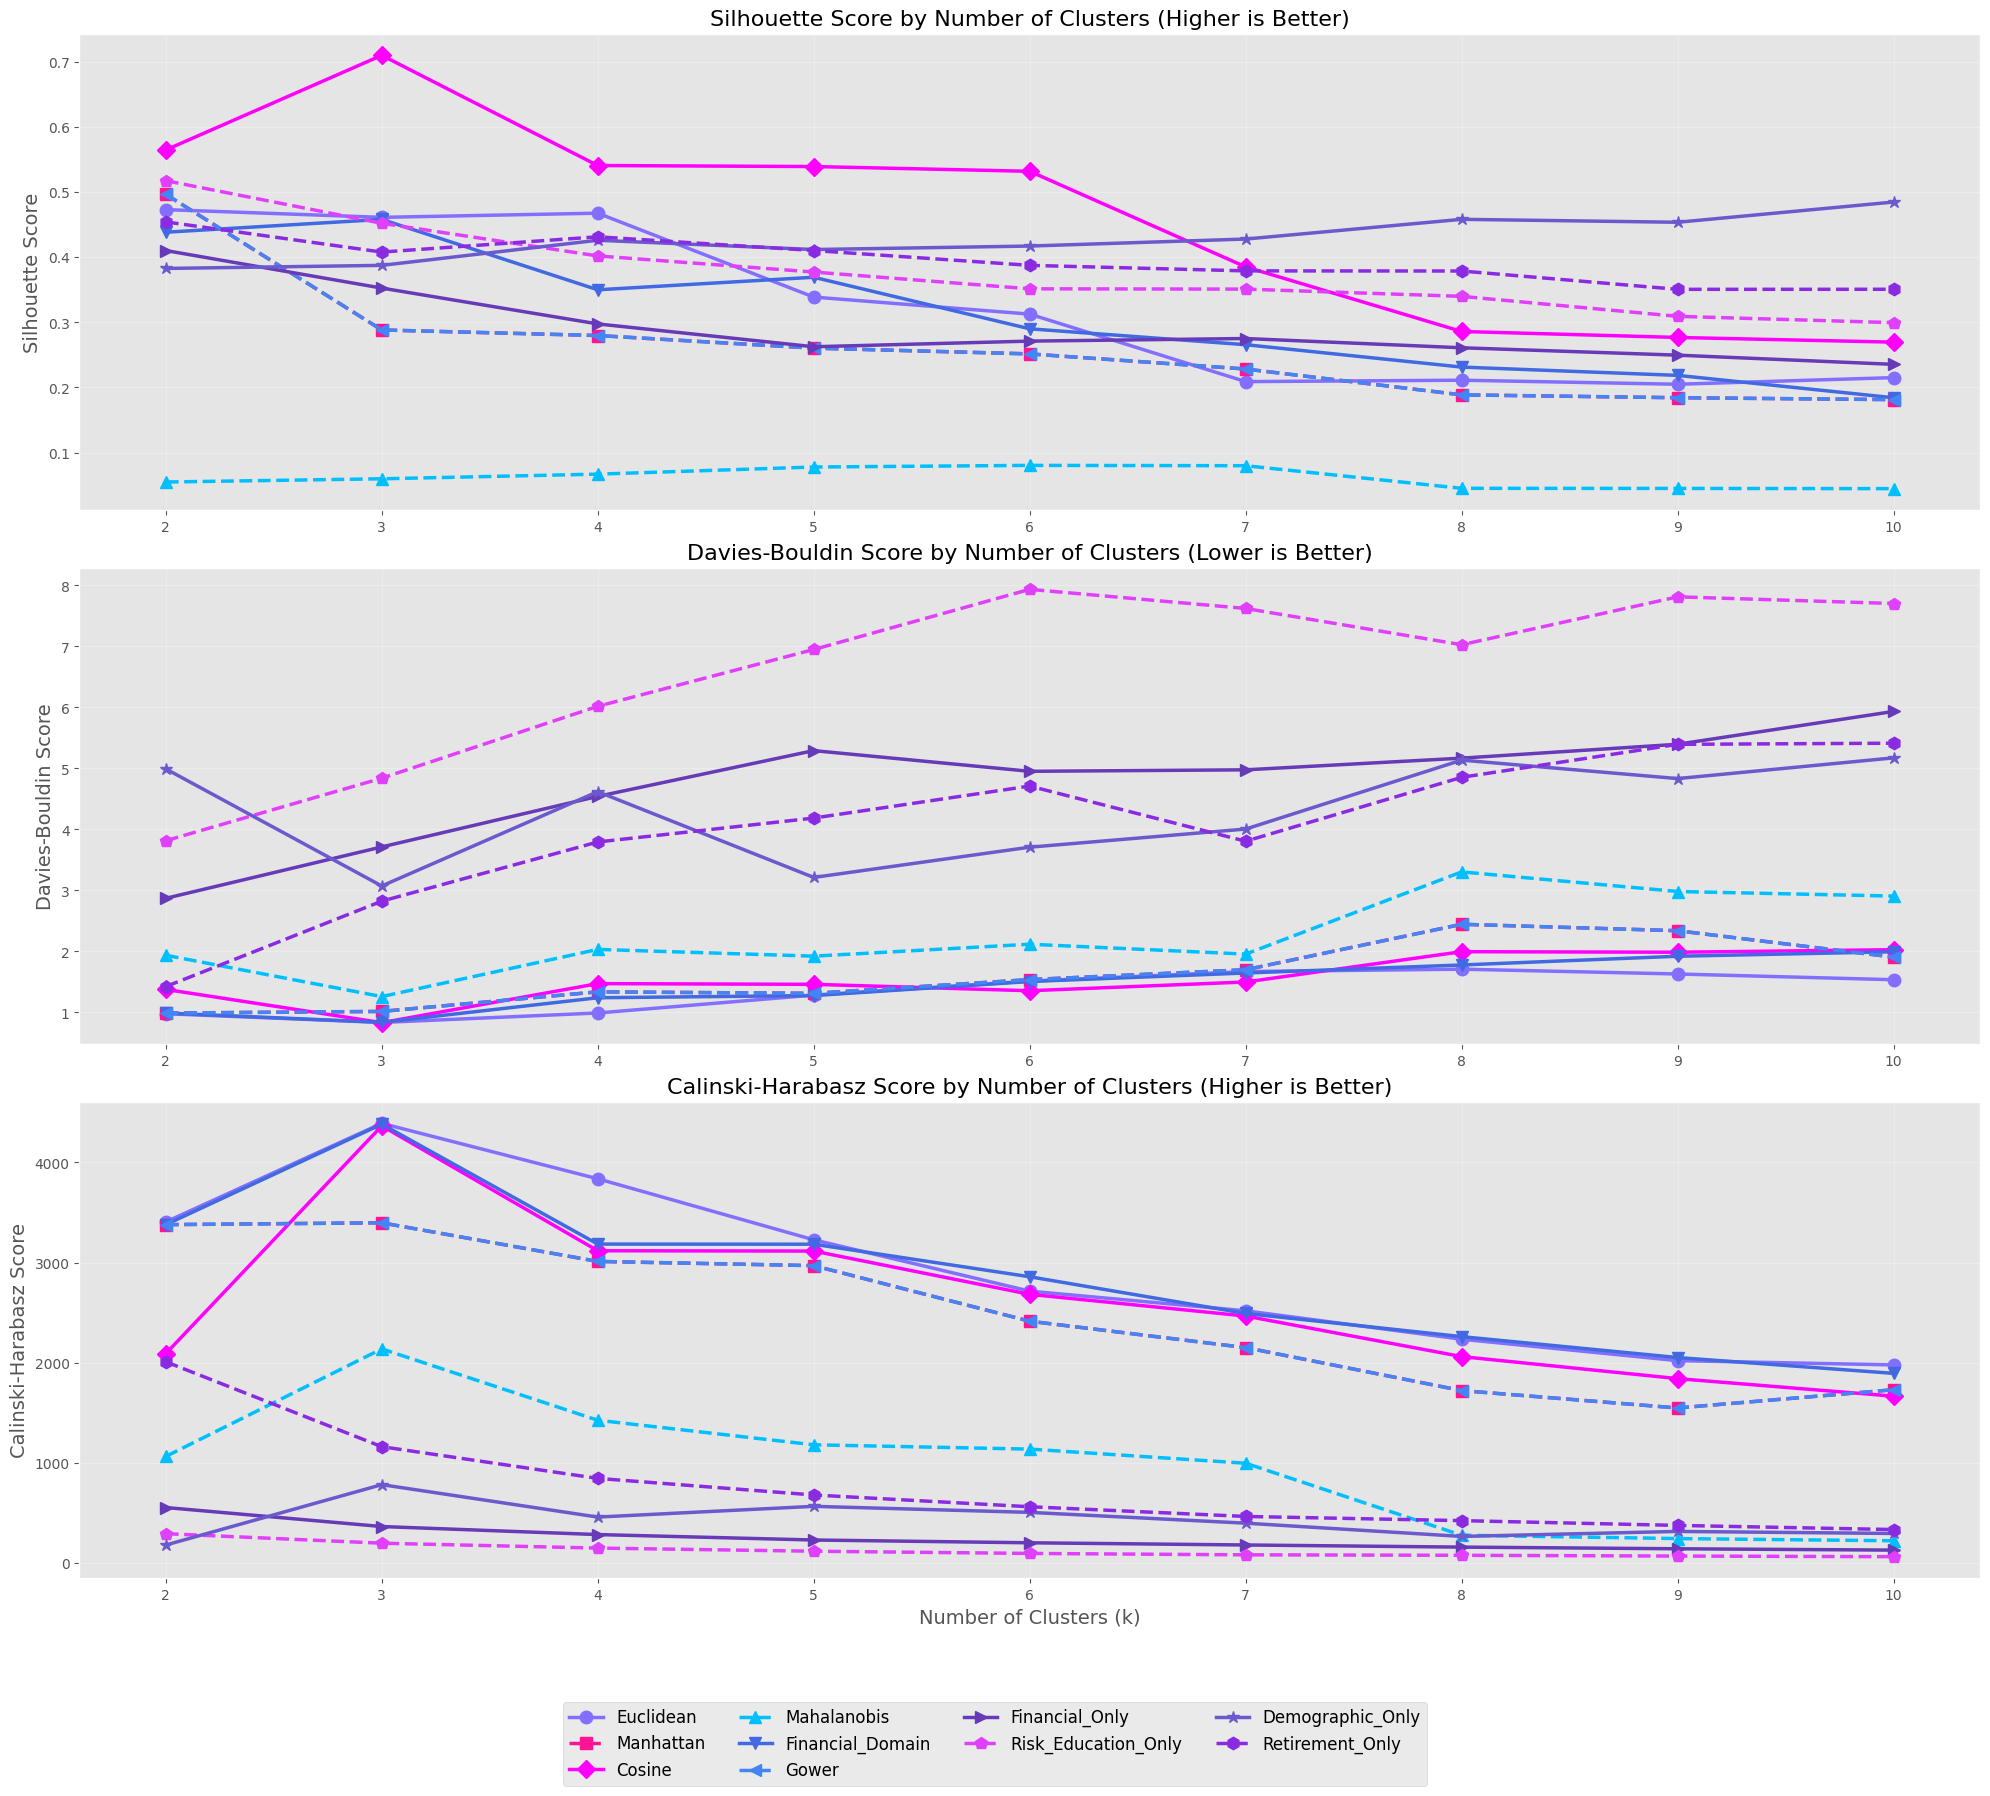

In [32]:
# -------------------------
# Visualize Clustering Metrics with Optimized Blue-Purple-Pink Palette
# -------------------------
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import random

# Handle NaN values in metrics
for metric_name in evaluation_metrics:
    for metric_type in ["silhouette", "davies_bouldin", "calinski_harabasz"]:
        # Convert to numpy array and replace NaN with 0 for plotting
        values = np.array(evaluation_metrics[metric_name][metric_type])
        evaluation_metrics[metric_name][metric_type] = np.nan_to_num(values, nan=0.0)

# Create custom palette with blue, purple, violet, and shock pink shades
custom_colors = [
    '#3A1C71',  # Deep purple
    '#1E88E5',  # Material blue
    '#C71585',  # Medium violet red
    '#4B37A3',  # Royal purple
    '#00BFFF',  # Deep sky blue
    '#FF1493',  # Deep pink
    '#6A5ACD',  # Slate blue
    '#0D47A1',  # Dark blue
    '#B721FF',  # Electric purple
    '#4169E1',  # Royal blue
    '#D500F9',  # Purple accent
    '#0077BE',  # Ocean blue
    '#8A2BE2',  # Blue violet
    '#4285F4',  # Google blue
    '#FF00FF',  # Magenta/Shock pink
    '#673AB7',  # Material purple
    '#9400D3',  # Dark violet
    '#512DA8',  # Deep violet
    '#E040FB',  # Light purple
    '#836FFF'   # Slate blue (lighter)
]

# Shuffle the colors to ensure variety
random.seed(42)  # Set seed for reproducibility
random.shuffle(custom_colors)

# Define distinct markers for all metrics
all_markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'd']

# Create figure with shared legend
fig, axes = plt.subplots(3, 1, figsize=(20, 18))

# Identify all metrics that have data
all_metrics = [m for m in evaluation_metrics.keys() 
               if any(len(evaluation_metrics[m][t]) > 0 for t in ["silhouette", "davies_bouldin", "calinski_harabasz"])]

# Set up line styles - only solid and dashed, no dotted
line_styles = ['-', '--', '-', '--', '-', '--', '-', '--', '-', '--']

# Create a dictionary to store the line objects for the legend
legend_elements = []

# Plot metrics across all three subplots
for i, metric_name in enumerate(all_metrics):
    if metric_name not in evaluation_metrics:
        continue
        
    metrics = evaluation_metrics[metric_name]
    color = custom_colors[i % len(custom_colors)]
    marker = all_markers[i % len(all_markers)]
    linestyle = line_styles[i % len(line_styles)]
    
    # 1. Silhouette Score (higher is better)
    if len(metrics["silhouette"]) > 0:
        line, = axes[0].plot(
            metrics["k_values"], 
            metrics["silhouette"], 
            marker=marker,
            linestyle=linestyle,
            linewidth=2.5,
            markersize=9,
            color=color,
            label=metric_name
        )
        # Only add to legend elements if this is the first time we've seen this metric
        if not any(metric_name == le.get_label() for le in legend_elements):
            legend_elements.append(line)
    
    # 2. Davies-Bouldin Score (lower is better)
    if len(metrics["davies_bouldin"]) > 0:
        axes[1].plot(
            metrics["k_values"], 
            metrics["davies_bouldin"], 
            marker=marker,
            linestyle=linestyle,
            linewidth=2.5,
            markersize=9,
            color=color,
            label=metric_name
        )
    
    # 3. Calinski-Harabasz Score (higher is better)
    if len(metrics["calinski_harabasz"]) > 0:
        axes[2].plot(
            metrics["k_values"], 
            metrics["calinski_harabasz"], 
            marker=marker,
            linestyle=linestyle,
            linewidth=2.5,
            markersize=9,
            color=color,
            label=metric_name
        )

# Configure axes
axes[0].set_title('Silhouette Score by Number of Clusters (Higher is Better)', fontsize=16)
axes[0].set_ylabel('Silhouette Score', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(np.arange(2, 11, 1))

axes[1].set_title('Davies-Bouldin Score by Number of Clusters (Lower is Better)', fontsize=16)
axes[1].set_ylabel('Davies-Bouldin Score', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(np.arange(2, 11, 1))

axes[2].set_title('Calinski-Harabasz Score by Number of Clusters (Higher is Better)', fontsize=16)
axes[2].set_xlabel('Number of Clusters (k)', fontsize=14)
axes[2].set_ylabel('Calinski-Harabasz Score', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(np.arange(2, 11, 1))

# Add a single legend at the bottom
fig.legend(
    handles=legend_elements,
    labels=[le.get_label() for le in legend_elements],
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    ncol=4,
    fontsize=12
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # Make room for the legend
plt.savefig('clustering_metrics.png', dpi=300, bbox_inches='tight')  # Save high-resolution image
plt.show()

## 3D Interactive Cluster Visualization

Finally, we create an interactive 3D visualization of our clusters using t-SNE dimensionality reduction. This visualization:

1. Projects high-dimensional client data into an interpretable 3D space
2. Color-codes clients by their assigned cluster
3. Provides interactive hover information showing cluster membership and investment needs
4. Helps validate the clustering by showing how well-separated the clusters are

The visualization is accompanied by statistics on cluster sizes and the distribution of investment needs within each cluster, providing valuable insights into the characteristics of each client segment.


In [33]:
# -------------------------
# Interactive 3D Cluster Visualization with Blue-Purple-Pink Palette
# -------------------------
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import warnings
from sklearn.manifold import TSNE

# Filter out the specific t-SNE warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.manifold._t_sne")

# Set distance metric, number of clusters and perplexity
distance_metric = "Cosine"  # Change this to match your distance_matrices key exactly
num_clusters = 3  # Change this to your desired K value
perplexity_value = 50  # Adjust based on your dataset size

# Verify the selection exists in your results
if distance_metric not in distance_matrices:
    print(f"⚠️ Distance metric '{distance_metric}' not found. Available metrics: {list(distance_matrices.keys())}")
    # Use the first available metric as fallback
    distance_metric = list(distance_matrices.keys())[0]
    print(f"Using '{distance_metric}' instead")

if num_clusters not in cluster_results[distance_metric]:
    print(f"⚠️ K={num_clusters} not found for '{distance_metric}'. Available K values: {list(cluster_results[distance_metric].keys())}")
    # Use the first available K as fallback
    num_clusters = list(cluster_results[distance_metric].keys())[0]
    print(f"Using K={num_clusters} instead")

# Get the distance matrix and labels
dist_matrix = distance_matrices[distance_metric]
labels = cluster_results[distance_metric][num_clusters]

# Check if the distance matrix is valid
if np.isnan(dist_matrix).any() or np.isinf(dist_matrix).any():
    print(f"⚠️ Distance matrix contains NaN or Inf values - fixing...")
    # Replace NaN/Inf with large values
    dist_matrix = np.nan_to_num(dist_matrix, nan=np.nanmax(dist_matrix)*2, 
                             posinf=np.nanmax(dist_matrix)*2, 
                             neginf=np.nanmin(dist_matrix)*2)

# Compute 3D t-SNE projection with square_distances=True to avoid warnings
tsne = TSNE(
    n_components=3, 
    metric='precomputed', 
    init='random', 
    random_state=42, 
    perplexity=perplexity_value,
    square_distances=True  # Add this to avoid warnings
)
X_tsne_3d = tsne.fit_transform(dist_matrix)

# Create DataFrame for visualization - make sure cluster is numeric
df_plot = pd.DataFrame({
    'x': X_tsne_3d[:, 0], 
    'y': X_tsne_3d[:, 1], 
    'z': X_tsne_3d[:, 2], 
    'Cluster': labels.astype(int)  # Ensure cluster labels are integers
})

# Add target variables for hover information
df_plot['IncomeInvestment'] = engineered_y_income.values
df_plot['AccumulationInvestment'] = engineered_y_accum.values

# Create the 3D scatter plot using a color map approach
# Define unique colors for each cluster - using the blue-purple-pink palette
num_unique_clusters = len(np.unique(labels))
colors = [
    '#3A1C71',  # Deep purple
    '#0D47A1',  # Dark blue
    '#FF1493',  # Deep pink
    '#4B37A3',  # Royal purple
    '#00BFFF',  # Deep sky blue
    '#C71585',  # Medium violet red
    '#673AB7',  # Material purple
    '#4169E1'   # Royal blue
]

# Create color mapping
color_map = {i: colors[i % len(colors)] for i in range(num_unique_clusters)}
df_plot['color'] = df_plot['Cluster'].map(color_map)

# Create hover text
hover_text = [
    f"Cluster: {c}<br>Income Need: {i}<br>Accum Need: {a}" 
    for c, i, a in zip(
        df_plot['Cluster'], 
        df_plot['IncomeInvestment'], 
        df_plot['AccumulationInvestment']
    )
]

# Create a separate trace for each cluster for better visualization
fig = go.Figure()

for cluster_id in sorted(df_plot['Cluster'].unique()):
    cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
    cluster_hover = [t for i, t in enumerate(hover_text) if df_plot['Cluster'].iloc[i] == cluster_id]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data['x'],
        y=cluster_data['y'],
        z=cluster_data['z'],
        mode='markers',
        marker=dict(
            size=5,
            color=color_map[cluster_id],
            opacity=0.8
        ),
        text=cluster_hover,
        hoverinfo='text',
        name=f'Cluster {cluster_id}'
    ))

# Customize layout
fig.update_layout(
    title=f"3D t-SNE Cluster Visualization<br>({distance_metric}, k={num_clusters}, perplexity={perplexity_value})",
    scene=dict(
        xaxis_title="t-SNE 1",
        yaxis_title="t-SNE 2",
        zaxis_title="t-SNE 3",
        aspectmode="cube"  # Keeps the aspect ratio balanced
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=1000,  # Width of the figure
    height=800,  # Height of the figure
    # Use a dark background for better contrast with the blue-purple-pink palette
    template="plotly"  # Use plotly theme for better visibility
)

# Display the interactive plot
fig.show()

# Print cluster information
print("\nCluster sizes:")
for cluster in sorted(np.unique(labels)):
    size = np.sum(labels == cluster)
    print(f"  Cluster {cluster}: {size} clients ({size/len(labels)*100:.1f}%)")

# Analyze investment needs by cluster
cluster_df = pd.DataFrame({
    'Cluster': labels,
    'IncomeInvestment': engineered_y_income.values,
    'AccumulationInvestment': engineered_y_accum.values
})

investment_by_cluster = cluster_df.groupby('Cluster')[['IncomeInvestment', 'AccumulationInvestment']].mean() * 100
print("\nInvestment Need Distribution by Cluster:")
print(investment_by_cluster.round(1).astype(str) + '%')


Cluster sizes:
  Cluster 0: 2096 clients (41.9%)
  Cluster 1: 1848 clients (37.0%)
  Cluster 2: 1056 clients (21.1%)

Investment Need Distribution by Cluster:
        IncomeInvestment AccumulationInvestment
Cluster                                        
0                  31.5%                  52.3%
1                  27.8%                  50.9%
2                  70.5%                  50.1%


# Enhanced Cluster Access System for Model Development

This section implements a specialized data access system to streamline working with our clustering results. Once we've identified the optimal clustering configuration, we need a systematic way to access, analyze, and utilize these clusters for model development.

The `ClusterAccess` class provides a comprehensive API for:

- **Flexible Cluster Access**: Retrieve data and labels for any combination of distance metric and cluster count
- **Centroid Analysis**: Calculate and visualize the characteristics of each cluster's center point
- **Cluster-Specific Training Data**: Extract targeted subsets of data for cluster-specific modeling
- **Persistence**: Save and reload clustering configurations for consistent use across notebooks

This utility abstracts away the complexity of managing multiple clustering solutions, allowing us to focus on model development while maintaining a clean, consistent interface for accessing our segmentation results.

The system ultimately enables our cluster-specific prediction approach, where we'll train separate models for each identified customer segment to maximize prediction accuracy.

In [17]:
# -------------------------
# Enhanced Cluster Access System with Centroid Analysis
# -------------------------
import pandas as pd
import numpy as np
from IPython.display import display
import pickle
import os

# Create a cluster utility class to easily access and analyze clusters
class ClusterAccess:
    def __init__(self, distance_matrices, cluster_results, kmedoids_models, 
                 X_data, y_income, y_accum):
        """Initialize cluster access system with all clustering results"""
        self.distance_matrices = distance_matrices
        self.cluster_results = cluster_results
        self.kmedoids_models = kmedoids_models
        self.X_data = X_data
        self.y_income = y_income
        self.y_accum = y_accum
        
        # Create directory for saved files
        os.makedirs('cluster_data', exist_ok=True)
        
        # Pre-compute and cache the full data with clusters for quick access
        self.cached_data = {}
    
    def get_available_metrics(self):
        """Get list of available distance metrics"""
        return list(self.distance_matrices.keys())
    
    def get_available_k_values(self, distance_metric):
        """Get list of available k values for a given distance metric"""
        if distance_metric not in self.cluster_results:
            raise ValueError(f"Distance metric '{distance_metric}' not found")
        return list(self.cluster_results[distance_metric].keys())
    
    def get_cluster_labels(self, distance_metric, k):
        """Get cluster labels for a specific distance metric and k value"""
        if distance_metric not in self.cluster_results:
            raise ValueError(f"Distance metric '{distance_metric}' not found")
        if k not in self.cluster_results[distance_metric]:
            raise ValueError(f"k={k} not found for {distance_metric}")
        
        return self.cluster_results[distance_metric][k]
    
    def get_model(self, distance_metric, k):
        """Get the KMedoids model for a specific configuration"""
        if distance_metric not in self.kmedoids_models:
            raise ValueError(f"Distance metric '{distance_metric}' not found")
        if k not in self.kmedoids_models[distance_metric]:
            raise ValueError(f"k={k} not found for {distance_metric}")
        
        return self.kmedoids_models[distance_metric][k]
    
    def get_data_with_clusters(self, distance_metric, k, include_targets=True):
        """Get data with cluster assignments"""
        # Check if this computation is already cached
        cache_key = f"{distance_metric}_{k}_{include_targets}"
        if cache_key in self.cached_data:
            return self.cached_data[cache_key]
        
        # Get cluster labels
        labels = self.get_cluster_labels(distance_metric, k)
        
        # Create DataFrame with features and cluster labels
        data_with_clusters = self.X_data.copy()
        data_with_clusters['Cluster'] = labels
        
        # Add target variables if requested
        if include_targets:
            data_with_clusters['IncomeInvestment'] = self.y_income.values
            data_with_clusters['AccumulationInvestment'] = self.y_accum.values
        
        # Cache for future use
        self.cached_data[cache_key] = data_with_clusters
        return data_with_clusters
    
    def get_cluster_members(self, distance_metric, k, cluster_id, include_targets=True):
        """Get all members of a specific cluster"""
        data_with_clusters = self.get_data_with_clusters(distance_metric, k, include_targets)
        return data_with_clusters[data_with_clusters['Cluster'] == cluster_id]
    
    def get_centroids(self, distance_metric, k, round_digits=3, include_percentages=True):
        """Calculate cluster centroids with rich information"""
        # Get data with clusters
        data_with_clusters = self.get_data_with_clusters(distance_metric, k, include_targets=True)
        
        # Calculate cluster sizes
        cluster_sizes = pd.Series(data_with_clusters['Cluster']).value_counts().sort_index()
        size_percentages = (cluster_sizes / len(data_with_clusters) * 100).round(1)
        
        # Calculate mean values for each feature by cluster
        centroids = data_with_clusters.groupby('Cluster').mean()
        
        # Add cluster size information
        centroids['Cluster_Size'] = cluster_sizes.values
        centroids['Cluster_Percentage'] = size_percentages.values
        
        # Convert the investment needs to percentages for clarity
        centroids['IncomeInvestment'] = (centroids['IncomeInvestment'] * 100).round(1)
        centroids['AccumulationInvestment'] = (centroids['AccumulationInvestment'] * 100).round(1)
        
        # Round numerical values for better readability
        centroids_rounded = centroids.round(round_digits)
        
        # Create a more readable order of columns
        feature_cols = [col for col in centroids.columns 
                        if col not in ['Cluster_Size', 'Cluster_Percentage', 
                                      'IncomeInvestment', 'AccumulationInvestment']]
        
        # Reorder columns: size metrics first, then investment needs, then features
        ordered_cols = ['Cluster_Size', 'Cluster_Percentage', 
                        'IncomeInvestment', 'AccumulationInvestment'] + feature_cols
        
        # Apply column ordering if possible
        if all(col in centroids_rounded.columns for col in ordered_cols):
            centroids_rounded = centroids_rounded[ordered_cols]
        
        return centroids_rounded
    
    def display_centroids(self, distance_metric, k, round_digits=3):
        """Display cluster centroids with formatted output"""
        # Set pandas to show all columns temporarily
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        pd.set_option('display.max_colwidth', 20)
        
        # Get centroids
        centroids = self.get_centroids(distance_metric, k, round_digits)
        
        # Format for display
        centroids_display = centroids.copy()
        centroids_display['Cluster_Percentage'] = centroids_display['Cluster_Percentage'].astype(str) + '%'
        centroids_display['IncomeInvestment'] = centroids_display['IncomeInvestment'].astype(str) + '%'
        centroids_display['AccumulationInvestment'] = centroids_display['AccumulationInvestment'].astype(str) + '%'
        
        # Reset index to make Cluster a column
        centroids_display = centroids_display.reset_index()
        
        # Display the table
        print(f"\nCluster Centroids for {distance_metric}, k={k}")
        print("=" * 70)
        display(centroids_display)
        
        # If there are still too many columns, display in chunks
        if len(centroids_display.columns) > 20:
            print("\nDisplaying key metrics in chunks:")
            
            # Key metrics
            key_cols = ['Cluster', 'Cluster_Size', 'Cluster_Percentage', 
                        'IncomeInvestment', 'AccumulationInvestment']
            print("\nKey Metrics:")
            display(centroids_display[key_cols])
            
            # Key financial features
            financial_cols = [col for col in centroids_display.columns if 
                             any(term in col for term in ['Wealth', 'Income', 'Financial', 'Risk'])]
            financial_cols = ['Cluster'] + financial_cols[:10]
            print("\nKey Financial Features:")
            display(centroids_display[financial_cols])
            
            # Demographic features
            demo_cols = [col for col in centroids_display.columns if 
                        any(term in col for term in ['Age', 'Gender', 'Family'])]
            demo_cols = ['Cluster'] + demo_cols
            print("\nDemographic Features:")
            display(centroids_display[demo_cols])
        
        # Restore pandas display options
        pd.reset_option('display.max_columns')
        pd.reset_option('display.width')
        pd.reset_option('display.max_colwidth')
        
        return centroids_display
    
    def get_training_data_by_cluster(self, distance_metric, k, cluster_id):
        """Get X and y training data for a specific cluster"""
        cluster_members = self.get_cluster_members(distance_metric, k, cluster_id)
        
        # Extract features and targets
        X = cluster_members.drop(['Cluster', 'IncomeInvestment', 'AccumulationInvestment'], axis=1)
        y_income = cluster_members['IncomeInvestment']
        y_accum = cluster_members['AccumulationInvestment']
        
        return X, y_income, y_accum
    
    def save_cluster_data(self, distance_metric, k, filename=None):
        """Save cluster data to file for later use"""
        if filename is None:
            filename = f"cluster_data/{distance_metric}_k{k}.pkl"
        
        data_to_save = {
            'distance_metric': distance_metric,
            'k': k,
            'labels': self.get_cluster_labels(distance_metric, k),
            'data_with_clusters': self.get_data_with_clusters(distance_metric, k),
            'centroids': self.get_centroids(distance_metric, k)
        }
        
        with open(filename, 'wb') as f:
            pickle.dump(data_to_save, f)
        
        print(f"Cluster data saved to {filename}")
        return filename
    
    @staticmethod
    def load_cluster_data(filename):
        """Load previously saved cluster data"""
        with open(filename, 'rb') as f:
            return pickle.load(f)

# Create the cluster access object 
cluster_system = ClusterAccess(
    distance_matrices=distance_matrices,
    cluster_results=cluster_results,
    kmedoids_models=kmedoids_models,
    X_data=X_for_clustering, 
    y_income=engineered_y_income,
    y_accum=engineered_y_accum
)

# Display available distance metrics and k values
print("\nAvailable distance metrics:")
for i, metric in enumerate(cluster_system.get_available_metrics()):
    k_values = cluster_system.get_available_k_values(metric)
    print(f"  {i+1}. {metric} (k values: {k_values})")

# Set Cosine with k=3 as the default configuration
default_metric = "Cosine"  # Using Cosine as the default 
default_k = 3  # Using k=3 as the default

# Display centroids for the chosen configuration (Cosine, k=3)
centroids_display = cluster_system.display_centroids(default_metric, default_k)

# Save default cluster configuration
cluster_system.save_cluster_data(default_metric, default_k)

# Update the examples to use Cosine with k=3
print("\n=== HOW TO ACCESS CLUSTERS FOR MODELING ===")
print("""
# Get cluster assignments
cluster_data = cluster_system.get_data_with_clusters('Cosine', 3)

# Get members of a specific cluster
cluster_0_members = cluster_system.get_cluster_members('Cosine', 3, 0)

# Get training data for a specific cluster
X, y_income, y_accum = cluster_system.get_training_data_by_cluster('Cosine', 3, 0)

# Get cluster centroids
centroids = cluster_system.get_centroids('Cosine', 3)

# Save clusters for later use
cluster_system.save_cluster_data('Cosine', 3, 'my_clusters.pkl')

# Load saved clusters
loaded_data = ClusterAccess.load_cluster_data('my_clusters.pkl')
""")


Available distance metrics:
  1. Euclidean (k values: [2, 3, 4, 5, 6, 7, 8, 9, 10])
  2. Manhattan (k values: [2, 3, 4, 5, 6, 7, 8, 9, 10])
  3. Cosine (k values: [2, 3, 4, 5, 6, 7, 8, 9, 10])
  4. Mahalanobis (k values: [2, 3, 4, 5, 6, 7, 8, 9, 10])
  5. Financial_Domain (k values: [2, 3, 4, 5, 6, 7, 8, 9, 10])
  6. Gower (k values: [2, 3, 4, 5, 6, 7, 8, 9, 10])
  7. Financial_Only (k values: [2, 3, 4, 5, 6, 7, 8, 9, 10])
  8. Risk_Education_Only (k values: [2, 3, 4, 5, 6, 7, 8, 9, 10])
  9. Demographic_Only (k values: [2, 3, 4, 5, 6, 7, 8, 9, 10])
  10. Retirement_Only (k values: [2, 3, 4, 5, 6, 7, 8, 9, 10])

Cluster Centroids for Cosine, k=3


Cluster  Cluster_Size Cluster_Percentage IncomeInvestment AccumulationInvestment  is_retirement_age  life_Retirement  Gender  Age_Squared    Age  FamilyMembers  Wealth_log  Wealth_to_Income_log  Risk_Capacity_log  Wealth_Per_Family_Size_log  Investment_Capacity_log  Financial_Sophistication_Ratio  FinancialEducation_Squared  Education_Risk_Profile  risk_tolerance_log  Financial_Independence_Score_log  Retirement_Readiness_log  Life_Stage_Adjusted_Income_log  Wealth_Concentration_log  Age_Risk_Interaction  Wealth_Sqrt  Wealth  Financial_Independence_Score  Wealth_to_Income  Wealth_Per_Family_Size  Risk_Capacity  Retirement_Readiness
0        0          2096              41.9%            31.5%                52.3%                0.011            0.000    0.00        0.252  0.409          0.375       0.485                0.205               0.229                0.451                       0.570                    0.180                           0.260                       0.229                  0.003                0.047                             0.054                     0.506                           0.093                     0.227         0.158   0.036                0.025                      0.025                0.033             0.042                0.004 
1        1          1848              37.0%            27.8%                50.9%                0.000            0.000    1.00        0.264  0.424          0.377       0.458                0.199               0.201                0.423                       0.541                    0.165                           0.234                       0.204                  0.004                0.046                             0.056                     0.478                           0.089                     0.216         0.144   0.030                0.025                      0.025                0.028             0.035                0.004 
2        2          1056              21.1%            70.5%                50.1%                1.000            0.905    0.58        0.535  0.680          0.384       0.575                0.277               0.278                0.544                       0.637                    0.107                           0.223                       0.178                  0.003                0.079                             0.311                     0.470                           0.106                     0.269         0.231   0.073                0.045                      0.045                0.068             0.059                0.045


Displaying key metrics in chunks:

Key Metrics:


Cluster  Cluster_Size Cluster_Percentage IncomeInvestment AccumulationInvestment
0        0          2096              41.9%            31.5%                52.3%  
1        1          1848              37.0%            27.8%                50.9%  
2        2          1056              21.1%            70.5%                50.1%


Key Financial Features:


Cluster IncomeInvestment  Wealth_log  Wealth_to_Income_log  Risk_Capacity_log  Wealth_Per_Family_Size_log  Financial_Sophistication_Ratio  FinancialEducation_Squared  Education_Risk_Profile  Financial_Independence_Score_log  Life_Stage_Adjusted_Income_log
0        0            31.5%       0.485                0.205               0.229                0.451                       0.180                           0.260                       0.229                   0.047                             0.506           
1        1            27.8%       0.458                0.199               0.201                0.423                       0.165                           0.234                       0.204                   0.046                             0.478           
2        2            70.5%       0.575                0.277               0.278                0.544                       0.107                           0.223                       0.178                   0.079                             0.470


Demographic Features:


Cluster  Gender  Age_Squared    Age  FamilyMembers  Wealth_Per_Family_Size_log  Age_Risk_Interaction  Wealth_Per_Family_Size
0        0    0.00        0.252  0.409          0.375                0.451                       0.227                 0.033   
1        1    1.00        0.264  0.424          0.377                0.423                       0.216                 0.028   
2        2    0.58        0.535  0.680          0.384                0.544                       0.269                 0.068

Cluster data saved to cluster_data/Cosine_k3.pkl

=== HOW TO ACCESS CLUSTERS FOR MODELING ===

# Get cluster assignments
cluster_data = cluster_system.get_data_with_clusters('Cosine', 3)

# Get members of a specific cluster
cluster_0_members = cluster_system.get_cluster_members('Cosine', 3, 0)

# Get training data for a specific cluster
X, y_income, y_accum = cluster_system.get_training_data_by_cluster('Cosine', 3, 0)

# Get cluster centroids
centroids = cluster_system.get_centroids('Cosine', 3)

# Save clusters for later use
cluster_system.save_cluster_data('Cosine', 3, 'my_clusters.pkl')

# Load saved clusters
loaded_data = ClusterAccess.load_cluster_data('my_clusters.pkl')



# Cluster-Specific XGBoost Modeling with Advanced Optimization

This section implements a sophisticated modeling approach that leverages our customer segmentation to build specialized prediction models for each cluster. Rather than training a single model for all clients, we create tailored XGBoost models for each identified customer segment.

The implementation includes:

- **Cluster-Specific Training** - Each cluster gets its own dedicated model, allowing algorithms to capture unique patterns within distinct customer segments
- **Hyperparameter Optimization** - Automatic tuning of 15+ XGBoost parameters using Bayesian optimization with Optuna
- **Threshold Optimization** - Dynamic calibration of classification thresholds to balance precision and recall for each segment
- **Cross-Validation** - Rigorous k-fold validation to ensure model reliability despite smaller cluster-specific datasets
- **Advanced Feature Importance** - Both traditional and SHAP-based importance analysis to understand drivers in each segment
- **Comprehensive Visualization** - Performance metrics, ROC curves, confusion matrices, and feature importance plots

This cluster-specific approach allows us to capture different decision patterns for each customer segment, recognizing that the factors driving investment needs may vary significantly across different client profiles. The weighted ensemble of these specialized models aims to outperform a single global model by addressing the unique characteristics of each segment.

In [31]:
# =====================================================================================
# CLUSTER-SPECIFIC XGBOOST MODELING WITH ADVANCED OPTIMIZATION
# =====================================================================================
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_score, accuracy_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import joblib
import time
import warnings
warnings.filterwarnings('ignore')
# Create directory for model outputs
os.makedirs('cluster_models', exist_ok=True)

class ClusterXGBoostOptimizer:
    def __init__(self, cluster_system, target_variable='IncomeInvestment',
                 distance_metric='Cosine', k=3, n_trials=100, cv_folds=5):
        """
        Initialize XGBoost optimizer for cluster-specific modeling
        
        Parameters:
        -----------
        cluster_system : ClusterAccess
            The cluster access system with data and cluster assignments
        target_variable : str
            Target variable to predict ('IncomeInvestment' or 'AccumulationInvestment')
        distance_metric : str
            Distance metric used for clustering
        k : int
            Number of clusters
        n_trials : int
            Number of hyperparameter optimization trials
        cv_folds : int
            Number of cross-validation folds
        """
        self.cluster_system = cluster_system
        self.target_variable = target_variable
        self.distance_metric = distance_metric
        self.k = k
        self.n_trials = n_trials
        self.cv_folds = cv_folds
        self.models = {}
        self.best_params = {}
        self.feature_importance = {}
        self.metrics = {}
        self.shap_values = {}
        
        # Get full dataset with clusters for preprocessing
        self.data_with_clusters = cluster_system.get_data_with_clusters(
            distance_metric, k, include_targets=True)
        
        # Define metric names for consistent use
        self.metric_names = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        
        print(f"Initialized XGBoost optimizer for {target_variable} prediction")
        print(f"Using {distance_metric} clustering with k={k}")
        print(f"Will perform {n_trials} optimization trials with {cv_folds}-fold CV")
    
    def _optimize_hyperparams(self, X, y, cluster_id):
        """
        Optimize XGBoost hyperparameters using Optuna with cross-validation
        """
        print(f"\nOptimizing hyperparameters for Cluster {cluster_id}...")
        
        # Create a custom objective function for Optuna
        def objective(trial):
            # Define hyperparameter search space
            param = {
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
                'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
                'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
                'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
                'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 5.0),
                'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
                'verbosity': 0,
                'tree_method': 'hist',  # Fast histogram-based tree construction
                'random_state': 42
            }
            
            # Enable additional DART parameters if selected
            if param['booster'] == 'dart':
                param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
                param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
                param['rate_drop'] = trial.suggest_float('rate_drop', 0.0, 0.5)
                param['skip_drop'] = trial.suggest_float('skip_drop', 0.0, 0.5)
                
            # Set up cross-validation
            cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
            
            # Track cross-validation scores
            cv_scores = {
                'auc': [],
                'precision': [],
                'accuracy': []
            }
            
            # Perform cross-validation
            for train_idx, val_idx in cv.split(X, y):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                
                # Early stopping requires a validation set
                dtrain = xgb.DMatrix(X_train, label=y_train)
                dval = xgb.DMatrix(X_val, label=y_val)
                
                # Train with early stopping
                model = xgb.train(
                    param, 
                    dtrain,
                    num_boost_round=10000,  # Large number for early stopping
                    evals=[(dval, 'validation')],
                    early_stopping_rounds=100,  # Patient early stopping
                    verbose_eval=False
                )
                
                # Make predictions
                y_pred_proba = model.predict(dval)
                y_pred = (y_pred_proba >= 0.5).astype(int)
                
                # Calculate metrics
                cv_scores['auc'].append(roc_auc_score(y_val, y_pred_proba))
                cv_scores['precision'].append(precision_score(y_val, y_pred, zero_division=0))
                cv_scores['accuracy'].append(accuracy_score(y_val, y_pred))
            
            # Compute mean scores
            mean_auc = np.mean(cv_scores['auc'])
            mean_precision = np.mean(cv_scores['precision'])
            mean_accuracy = np.mean(cv_scores['accuracy'])
            
            # Create a combined score - weighted sum favoring AUC but considering all metrics
            combined_score = 0.5 * mean_auc + 0.3 * mean_precision + 0.2 * mean_accuracy
            
            # Return the trial results
            return combined_score
        
        # Create and run the Optuna study
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=self.n_trials)
        
        # Get best parameters
        best_params = study.best_params
        
        # Add fixed parameters
        best_params['objective'] = 'binary:logistic'
        best_params['eval_metric'] = 'auc'
        best_params['tree_method'] = 'hist'
        best_params['random_state'] = 42
        
        print(f"Best hyperparameters for Cluster {cluster_id}:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
            
        return best_params
    
    def _train_model(self, X, y, params, cluster_id):
        """
        Train XGBoost model with the optimized hyperparameters
        """
        print(f"\nTraining final model for Cluster {cluster_id}...")
        
        # Split data for final training
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Create DMatrix for training
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # Set up evaluation list
        evallist = [(dtrain, 'train'), (dtest, 'eval')]
        
        # Train the model
        model = xgb.train(
            params, 
            dtrain,
            num_boost_round=10000,  # Large number for early stopping
            evals=evallist,
            early_stopping_rounds=100,  # Patient early stopping
            verbose_eval=100  # Show progress every 100 rounds
        )
        
        print(f"Model training complete with {model.best_iteration} trees")
        
        # Make predictions
        y_pred_proba = model.predict(dtest)
        
        # Optimize threshold for precision/recall balance
        thresholds = np.linspace(0.1, 0.9, 100)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            f1 = precision_score(y_test, y_pred, zero_division=0) * 0.6 + recall_score(y_test, y_pred, zero_division=0) * 0.4
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Final predictions with optimized threshold
        y_pred = (y_pred_proba >= best_threshold).astype(int)
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': 2 * (precision_score(y_test, y_pred, zero_division=0) * recall_score(y_test, y_pred, zero_division=0)) / 
                 (precision_score(y_test, y_pred, zero_division=0) + recall_score(y_test, y_pred, zero_division=0) + 1e-10),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'threshold': best_threshold,
            'test_size': len(y_test),
            'positive_rate': y_test.mean()
        }
        
        # Print metrics
        print(f"\nCluster {cluster_id} Model Performance:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Store test data for later visualization
        test_data = {
            'X_test': X_test,
            'y_test': y_test,
            'y_pred_proba': y_pred_proba,
            'y_pred': y_pred
        }
        
        return model, metrics, test_data
    
    def _calculate_feature_importance(self, model, X, cluster_id):
        """
        Calculate and visualize feature importance
        """
        print(f"\nCalculating feature importance for Cluster {cluster_id}...")
        
        # Get feature importance from model
        importance_type = 'gain'  # gain, weight, cover, total_gain, total_cover
        importance = model.get_score(importance_type=importance_type)
        
        # Convert to DataFrame
        importance_df = pd.DataFrame({
            'Feature': list(importance.keys()),
            'Importance': list(importance.values())
        }).sort_values('Importance', ascending=False)
        
        # Calculate SHAP values for more accurate feature importance
        try:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)
            
            # Convert to DataFrame for easier handling
            shap_df = pd.DataFrame(
                np.abs(shap_values).mean(0),
                index=X.columns,
                columns=['SHAP Value']
            ).sort_values('SHAP Value', ascending=False)
            
            return importance_df, shap_df, shap_values
        except Exception as e:
            print(f"SHAP calculation error: {e}")
            return importance_df, None, None
    
    def _plot_results(self, model, X_test, y_test, y_pred_proba, y_pred, 
                     importance_df, shap_df, shap_values, metrics, cluster_id):
        """
        Create comprehensive visualizations for model results
        """
        # Create a directory for plots
        cluster_dir = f"cluster_models/cluster_{cluster_id}_{self.target_variable}"
        os.makedirs(cluster_dir, exist_ok=True)
        
        # Set up the figure size
        plt.figure(figsize=(16, 14))
        
        # 1. ROC Curve
        plt.subplot(2, 2, 1)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'AUC = {metrics["auc"]:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Cluster {cluster_id}')
        plt.legend()
        
        # 2. Feature Importance
        plt.subplot(2, 2, 2)
        top_n = min(10, len(importance_df))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
        plt.title(f'Top {top_n} Features - Cluster {cluster_id}')
        plt.tight_layout()
        
        # 3. Confusion Matrix
        plt.subplot(2, 2, 3)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - Cluster {cluster_id}')
        
        # 4. Metrics Summary
        plt.subplot(2, 2, 4)
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        values = [metrics[m] for m in metrics_to_plot]
        colors = sns.color_palette("viridis", len(metrics_to_plot))
        bars = plt.bar(metrics_to_plot, values, color=colors)
        plt.ylim(0, 1)
        plt.title(f'Performance Metrics - Cluster {cluster_id}')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f"{cluster_dir}/performance_summary.png", dpi=300)
        plt.close()
        
        # SHAP Values Plot (if available)
        if shap_values is not None:
            plt.figure(figsize=(12, 10))
            shap.summary_plot(shap_values, X_test, show=False)
            plt.title(f'SHAP Feature Importance - Cluster {cluster_id}')
            plt.tight_layout()
            plt.savefig(f"{cluster_dir}/shap_summary.png", dpi=300)
            plt.close()
    
    def train_all_clusters(self):
        """
        Train models for all clusters
        """
        print(f"\n{'='*80}")
        print(f"TRAINING {self.target_variable.upper()} MODELS FOR ALL CLUSTERS")
        print(f"{'='*80}")
        
        start_time = time.time()
        
        # Get total number of clusters
        num_clusters = self.k
        
        # Train a model for each cluster
        for cluster_id in range(num_clusters):
            cluster_start_time = time.time()
            print(f"\n{'-'*80}")
            print(f"PROCESSING CLUSTER {cluster_id}")
            print(f"{'-'*80}")
            
            # Extract data for this cluster
            X, y_income, y_accum = self.cluster_system.get_training_data_by_cluster(
                self.distance_metric, self.k, cluster_id)
            
            # Select target variable
            y = y_income if self.target_variable == 'IncomeInvestment' else y_accum
            
            # Handle empty clusters or clusters with only one class
            if len(X) < 20 or len(np.unique(y)) < 2:
                print(f"Skipping Cluster {cluster_id}: insufficient data or single class")
                continue
                
            # Print cluster info
            print(f"Cluster {cluster_id} size: {len(X)} samples")
            print(f"Positive rate: {y.mean():.2%}")
            
            # 1. Optimize hyperparameters
            best_params = self._optimize_hyperparams(X, y, cluster_id)
            self.best_params[cluster_id] = best_params
            
            # 2. Train model with best hyperparameters
            model, metrics, test_data = self._train_model(X, y, best_params, cluster_id)
            self.models[cluster_id] = model
            self.metrics[cluster_id] = metrics
            
            # 3. Calculate feature importance
            importance_df, shap_df, shap_values = self._calculate_feature_importance(
                model, test_data['X_test'], cluster_id)
            self.feature_importance[cluster_id] = importance_df
            self.shap_values[cluster_id] = shap_values
            
            # 4. Create visualizations
            self._plot_results(
                model, 
                test_data['X_test'], 
                test_data['y_test'], 
                test_data['y_pred_proba'], 
                test_data['y_pred'],
                importance_df,
                shap_df,
                shap_values,
                metrics,
                cluster_id
            )
            
            # 5. Save model and metadata
            self._save_model(model, best_params, metrics, importance_df, cluster_id)
            
            # Print time taken
            cluster_time = time.time() - cluster_start_time
            print(f"\nCluster {cluster_id} processing completed in {cluster_time:.2f} seconds")
        
        # Calculate and print overall metrics
        self._summarize_results()
        
        # Print total time taken
        total_time = time.time() - start_time
        print(f"\nTotal training completed in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
        
        return self.models, self.metrics, self.feature_importance
    
    def _save_model(self, model, params, metrics, importance, cluster_id):
        """
        Save model and metadata
        """
        # Create directory
        model_dir = f"cluster_models/cluster_{cluster_id}_{self.target_variable}"
        os.makedirs(model_dir, exist_ok=True)
        
        # Save model
        model.save_model(f"{model_dir}/model.json")
        
        # Save hyperparameters
        with open(f"{model_dir}/hyperparameters.txt", 'w') as f:
            for param, value in params.items():
                f.write(f"{param}={value}\n")
        
        # Save metrics
        pd.Series(metrics).to_csv(f"{model_dir}/metrics.csv")
        
        # Save feature importance
        importance.to_csv(f"{model_dir}/feature_importance.csv", index=False)
        
        print(f"Model and metadata saved to {model_dir}")
    
    def _summarize_results(self):
        """
        Summarize results across all clusters
        """
        print("\nSUMMARY OF RESULTS ACROSS ALL CLUSTERS")
        print("="*80)
        
        # Collect metrics
        all_metrics = {}
        cluster_sizes = {}
        
        for cluster_id, metrics in self.metrics.items():
            all_metrics[cluster_id] = metrics
            cluster_sizes[cluster_id] = metrics['test_size']
        
        # Create summary DataFrame
        summary = pd.DataFrame(all_metrics).T
        
        # Add cluster sizes
        summary['cluster_size'] = pd.Series(cluster_sizes)
        
        # Calculate weighted average metrics
        total_size = summary['cluster_size'].sum()
        weighted_metrics = {}
        
        for metric in self.metric_names:
            if metric in summary.columns:
                weighted_metrics[metric] = np.sum(summary[metric] * summary['cluster_size']) / total_size
        
        # Print summary
        print("\nMetrics by Cluster:")
        print(summary[self.metric_names + ['threshold', 'cluster_size', 'positive_rate']].round(4))
        
        print("\nWeighted Average Metrics:")
        for metric, value in weighted_metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Create summary visualization
        plt.figure(figsize=(12, 10))
        
        # Plot metrics by cluster
        metrics_df = summary[self.metric_names].copy()
        metrics_df['Cluster'] = metrics_df.index
        metrics_df = metrics_df.melt(id_vars=['Cluster'], var_name='Metric', value_name='Value')
        
        # Create grouped bar chart
        chart = sns.catplot(x='Metric', y='Value', hue='Cluster', data=metrics_df, kind='bar', height=6, aspect=1.5)
        chart.set_xticklabels(rotation=45)
        plt.title(f'{self.target_variable} - Performance Metrics Across Clusters')
        plt.tight_layout()
        plt.savefig(f"cluster_models/{self.target_variable}_metrics_by_cluster.png", dpi=300)
        plt.close()
        
        # Return summary for further analysis
        return summary

# Run the optimization for both target variables
targets = ['IncomeInvestment', 'AccumulationInvestment']
model_results = {}

for target in targets:
    print(f"\n{'#'*100}")
    print(f"# TRAINING MODELS FOR {target.upper()}")
    print(f"{'#'*100}")
    
    # Create optimizer
    optimizer = ClusterXGBoostOptimizer(
        cluster_system=cluster_system,
        target_variable=target,
        distance_metric='Cosine',  # Using Cosine as specified
        k=3,                       # Using k=3 as specified
        n_trials=50,               # Number of hyperparameter optimization trials
        cv_folds=5                 # Number of cross-validation folds
    )
    
    # Train models for all clusters
    models, metrics, importance = optimizer.train_all_clusters()
    
    # Store results
    model_results[target] = {
        'optimizer': optimizer,
        'models': models,
        'metrics': metrics,
        'importance': importance
    }

print("\nAll models have been trained and saved!")

[I 2025-04-05 18:33:16,859] A new study created in memory with name: no-name-e1855f62-cd7b-49ff-bb29-0abe45764af8



####################################################################################################
# TRAINING MODELS FOR INCOMEINVESTMENT
####################################################################################################
Initialized XGBoost optimizer for IncomeInvestment prediction
Using Cosine clustering with k=3
Will perform 50 optimization trials with 5-fold CV

TRAINING INCOMEINVESTMENT MODELS FOR ALL CLUSTERS

--------------------------------------------------------------------------------
PROCESSING CLUSTER 0
--------------------------------------------------------------------------------
Cluster 0 size: 2096 samples
Positive rate: 31.54%

Optimizing hyperparameters for Cluster 0...


[I 2025-04-05 18:33:17,331] Trial 0 finished with value: 0.7510338797932486 and parameters: {'booster': 'gbtree', 'learning_rate': 0.005174746845448525, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 5.223315959122395e-06, 'subsample': 0.7983707360956165, 'colsample_bytree': 0.9257885674669765, 'colsample_bylevel': 0.6656801138587871, 'alpha': 0.025557103833855798, 'lambda': 2.709254804519575e-07, 'scale_pos_weight': 2.403306297872504, 'max_delta_step': 4}. Best is trial 0 with value: 0.7510338797932486.
[I 2025-04-05 18:33:22,379] Trial 1 finished with value: 0.7666281765270693 and parameters: {'booster': 'dart', 'learning_rate': 0.031827118695914196, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.005269401068031358, 'subsample': 0.9348075133895012, 'colsample_bytree': 0.7326573053311828, 'colsample_bylevel': 0.7598769070874309, 'alpha': 2.323004651170459e-07, 'lambda': 7.691069439670715e-07, 'scale_pos_weight': 0.5057052339214116, 'max_delta_step': 6, 'sample_type': 'weighted', '

Best hyperparameters for Cluster 0:
  booster: dart
  learning_rate: 0.014212836137464876
  max_depth: 5
  min_child_weight: 2
  gamma: 9.700930817090788e-07
  subsample: 0.9275819902528477
  colsample_bytree: 0.7834027192715409
  colsample_bylevel: 0.96416974548915
  alpha: 3.351197105141755e-07
  lambda: 1.2361536852223843e-07
  scale_pos_weight: 0.5042662966165883
  max_delta_step: 3
  sample_type: weighted
  normalize_type: tree
  rate_drop: 0.2255791909081917
  skip_drop: 0.12919558255098362
  objective: binary:logistic
  eval_metric: auc
  tree_method: hist
  random_state: 42

Training final model for Cluster 0...
[0]	train-auc:0.76406	eval-auc:0.73924
[100]	train-auc:0.85700	eval-auc:0.75124
[102]	train-auc:0.85704	eval-auc:0.75138
Model training complete with 2 trees

Cluster 0 Model Performance:
  accuracy: 0.8000
  precision: 0.8429
  recall: 0.4470
  f1: 0.5842
  auc: 0.7514
  threshold: 0.4394
  test_size: 420.0000
  positive_rate: 0.3143

Classification Report:
           

[I 2025-04-05 18:38:25,235] A new study created in memory with name: no-name-5d038974-aaec-4f8d-856a-cd0435b8487f


Model and metadata saved to cluster_models/cluster_0_IncomeInvestment

Cluster 0 processing completed in 308.38 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 1
--------------------------------------------------------------------------------
Cluster 1 size: 1848 samples
Positive rate: 27.76%

Optimizing hyperparameters for Cluster 1...


[I 2025-04-05 18:38:26,262] Trial 0 finished with value: 0.7631795688140699 and parameters: {'booster': 'gbtree', 'learning_rate': 0.025282584490487536, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.0007100360547346593, 'subsample': 0.8675384566776845, 'colsample_bytree': 0.9149928271612121, 'colsample_bylevel': 0.6275820166373032, 'alpha': 0.00020372401583914373, 'lambda': 2.5777277396415024e-06, 'scale_pos_weight': 0.7512178987247717, 'max_delta_step': 8}. Best is trial 0 with value: 0.7631795688140699.
[I 2025-04-05 18:38:26,848] Trial 1 finished with value: 0.6043395981074071 and parameters: {'booster': 'gbtree', 'learning_rate': 0.009937074224981064, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.018837456834127655, 'subsample': 0.6991416355228377, 'colsample_bytree': 0.8533891593521188, 'colsample_bylevel': 0.918477862370366, 'alpha': 0.22208262956712319, 'lambda': 0.20017974416055107, 'scale_pos_weight': 4.243116342537415, 'max_delta_step': 0}. Best is trial 0 with value

Best hyperparameters for Cluster 1:
  booster: dart
  learning_rate: 0.01633105843367605
  max_depth: 11
  min_child_weight: 10
  gamma: 0.0003593334881871616
  subsample: 0.8216420699165512
  colsample_bytree: 0.8287191732288253
  colsample_bylevel: 0.7701174459016772
  alpha: 0.005321956495624092
  lambda: 5.408288815210926e-08
  scale_pos_weight: 0.7229322834812494
  max_delta_step: 0
  sample_type: weighted
  normalize_type: forest
  rate_drop: 0.32344342718781965
  skip_drop: 0.21488273419106368
  objective: binary:logistic
  eval_metric: auc
  tree_method: hist
  random_state: 42

Training final model for Cluster 1...
[0]	train-auc:0.77249	eval-auc:0.64081
[100]	train-auc:0.89056	eval-auc:0.67830
[178]	train-auc:0.90069	eval-auc:0.67448
Model training complete with 78 trees

Cluster 1 Model Performance:
  accuracy: 0.7730
  precision: 0.9524
  recall: 0.1942
  f1: 0.3226
  auc: 0.6745
  threshold: 0.8192
  test_size: 370.0000
  positive_rate: 0.2784

Classification Report:
      

[I 2025-04-05 18:45:37,826] A new study created in memory with name: no-name-ecd26e5d-d2d2-49e8-96c2-059942f36e25


Model and metadata saved to cluster_models/cluster_1_IncomeInvestment

Cluster 1 processing completed in 432.59 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 2
--------------------------------------------------------------------------------
Cluster 2 size: 1056 samples
Positive rate: 70.45%

Optimizing hyperparameters for Cluster 2...


[I 2025-04-05 18:46:03,559] Trial 0 finished with value: 0.908986143149036 and parameters: {'booster': 'dart', 'learning_rate': 0.003676790121289055, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 2.5761751641830853e-07, 'subsample': 0.9575581131229571, 'colsample_bytree': 0.8007246665639327, 'colsample_bylevel': 0.8729336741888972, 'alpha': 2.6338273498801668e-05, 'lambda': 0.0007663121840598695, 'scale_pos_weight': 0.6740049975304758, 'max_delta_step': 1, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.06615892115732075, 'skip_drop': 0.4565233054487068}. Best is trial 0 with value: 0.908986143149036.
[I 2025-04-05 18:46:04,722] Trial 1 finished with value: 0.8926980232881576 and parameters: {'booster': 'gbtree', 'learning_rate': 0.037563412928202165, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 2.5893928301092668e-08, 'subsample': 0.7290318784462916, 'colsample_bytree': 0.8621382300148619, 'colsample_bylevel': 0.9713108396175918, 'alpha': 7.171592829686385e-08,

Best hyperparameters for Cluster 2:
  booster: dart
  learning_rate: 0.07203748537606251
  max_depth: 9
  min_child_weight: 4
  gamma: 0.009372590959446595
  subsample: 0.8632423810755968
  colsample_bytree: 0.7846949354260241
  colsample_bylevel: 0.9348941239570844
  alpha: 0.011240087096139896
  lambda: 0.34423269852862026
  scale_pos_weight: 0.5348963674793722
  max_delta_step: 1
  sample_type: uniform
  normalize_type: forest
  rate_drop: 0.3000163105760573
  skip_drop: 0.23560546153079528
  objective: binary:logistic
  eval_metric: auc
  tree_method: hist
  random_state: 42

Training final model for Cluster 2...
[0]	train-auc:0.89775	eval-auc:0.90343
[100]	train-auc:0.97291	eval-auc:0.92607
[200]	train-auc:0.97453	eval-auc:0.93044
[216]	train-auc:0.97422	eval-auc:0.92554
Model training complete with 116 trees

Cluster 2 Model Performance:
  accuracy: 0.9009
  precision: 0.9571
  recall: 0.8993
  f1: 0.9273
  auc: 0.9255
  threshold: 0.4798
  test_size: 212.0000
  positive_rate: 0.

[I 2025-04-05 18:53:06,451] A new study created in memory with name: no-name-e8058a75-0a3c-4115-932d-c163be7be60f


Model and metadata saved to cluster_models/cluster_2_IncomeInvestment

Cluster 2 processing completed in 448.51 seconds

SUMMARY OF RESULTS ACROSS ALL CLUSTERS

Metrics by Cluster:
   accuracy  precision  recall      f1     auc  threshold  cluster_size  \
0    0.8000     0.8429  0.4470  0.5842  0.7514     0.4394           420   
1    0.7730     0.9524  0.1942  0.3226  0.6745     0.8192           370   
2    0.9009     0.9571  0.8993  0.9273  0.9255     0.4798           212   

   positive_rate  
0         0.3143  
1         0.2784  
2         0.7028  

Weighted Average Metrics:
  accuracy: 0.8114
  precision: 0.9075
  recall: 0.4493
  f1: 0.5602
  auc: 0.7598

Total training completed in 1189.59 seconds (19.83 minutes)

####################################################################################################
# TRAINING MODELS FOR ACCUMULATIONINVESTMENT
####################################################################################################
Initialized XGBoost opt

[I 2025-04-05 18:54:15,109] Trial 0 finished with value: 0.8709364131389069 and parameters: {'booster': 'dart', 'learning_rate': 0.0053771128676971675, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 4.9263247492528715e-05, 'subsample': 0.6126970892020648, 'colsample_bytree': 0.8206019755898566, 'colsample_bylevel': 0.629281062897048, 'alpha': 0.21148391654226872, 'lambda': 0.04588942887410347, 'scale_pos_weight': 2.4640684968570854, 'max_delta_step': 3, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.4215976911894826, 'skip_drop': 0.31627210860025845}. Best is trial 0 with value: 0.8709364131389069.
[I 2025-04-05 18:54:52,625] Trial 1 finished with value: 0.7743318854196073 and parameters: {'booster': 'dart', 'learning_rate': 0.0015093560276258806, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 6.492826603789061e-08, 'subsample': 0.6992264758592683, 'colsample_bytree': 0.6227089579382226, 'colsample_bylevel': 0.6730586911346563, 'alpha': 3.7459028693305645e-07, 

Best hyperparameters for Cluster 0:
  booster: dart
  learning_rate: 0.02411797970434515
  max_depth: 3
  min_child_weight: 10
  gamma: 1.9986873774359534e-08
  subsample: 0.9767719935574937
  colsample_bytree: 0.7535810062575593
  colsample_bylevel: 0.9345732025657693
  alpha: 0.00018699650076141916
  lambda: 1.6532997671328706e-07
  scale_pos_weight: 0.5349043672760914
  max_delta_step: 10
  sample_type: uniform
  normalize_type: tree
  rate_drop: 0.08130493266971194
  skip_drop: 0.4668572746844699
  objective: binary:logistic
  eval_metric: auc
  tree_method: hist
  random_state: 42

Training final model for Cluster 0...
[0]	train-auc:0.88334	eval-auc:0.86428
[100]	train-auc:0.89790	eval-auc:0.86748
[127]	train-auc:0.90054	eval-auc:0.86618
Model training complete with 27 trees

Cluster 0 Model Performance:
  accuracy: 0.8357
  precision: 0.9576
  recall: 0.7182
  f1: 0.8208
  auc: 0.8662
  threshold: 0.4232
  test_size: 420.0000
  positive_rate: 0.5238

Classification Report:
      

[I 2025-04-05 19:03:37,761] A new study created in memory with name: no-name-a6e357b0-cb98-4243-8051-0bffde18acfb


Model and metadata saved to cluster_models/cluster_0_AccumulationInvestment

Cluster 0 processing completed in 631.31 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 1
--------------------------------------------------------------------------------
Cluster 1 size: 1848 samples
Positive rate: 50.87%

Optimizing hyperparameters for Cluster 1...


[I 2025-04-05 19:03:43,576] Trial 0 finished with value: 0.8747799215806109 and parameters: {'booster': 'dart', 'learning_rate': 0.0038285938386322803, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 6.453656406034142e-08, 'subsample': 0.9785006342873607, 'colsample_bytree': 0.9678788079663395, 'colsample_bylevel': 0.8983673990977668, 'alpha': 2.858026803959404e-05, 'lambda': 9.592908483138365e-05, 'scale_pos_weight': 1.4603751461130587, 'max_delta_step': 3, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.23451129770956014, 'skip_drop': 0.18242579128217712}. Best is trial 0 with value: 0.8747799215806109.
[I 2025-04-05 19:03:44,302] Trial 1 finished with value: 0.8885055739454621 and parameters: {'booster': 'gbtree', 'learning_rate': 0.004267446062024161, 'max_depth': 11, 'min_child_weight': 7, 'gamma': 1.533801573961589e-08, 'subsample': 0.8496173439058601, 'colsample_bytree': 0.8327540898417193, 'colsample_bylevel': 0.6887971082826426, 'alpha': 0.00491306217775216

Best hyperparameters for Cluster 1:
  booster: gbtree
  learning_rate: 0.004056711810095268
  max_depth: 4
  min_child_weight: 5
  gamma: 2.5431795921069025e-06
  subsample: 0.7986890363814871
  colsample_bytree: 0.6564670634114376
  colsample_bylevel: 0.6311888530787639
  alpha: 2.2831937036102675e-06
  lambda: 0.06183415684780196
  scale_pos_weight: 0.7606918052065981
  max_delta_step: 0
  objective: binary:logistic
  eval_metric: auc
  tree_method: hist
  random_state: 42

Training final model for Cluster 1...
[0]	train-auc:0.85181	eval-auc:0.85102
[100]	train-auc:0.91644	eval-auc:0.86619
[200]	train-auc:0.91806	eval-auc:0.86927
[298]	train-auc:0.92174	eval-auc:0.86780
Model training complete with 199 trees

Cluster 1 Model Performance:
  accuracy: 0.8514
  precision: 0.9784
  recall: 0.7234
  f1: 0.8318
  auc: 0.8677
  threshold: 0.4798
  test_size: 370.0000
  positive_rate: 0.5081

Classification Report:
              precision    recall  f1-score   support

         0.0       0.7

[I 2025-04-05 19:07:24,560] A new study created in memory with name: no-name-a7cf5ee1-86ee-4068-b4d0-20dcabd6f22b


Model and metadata saved to cluster_models/cluster_1_AccumulationInvestment

Cluster 1 processing completed in 226.80 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 2
--------------------------------------------------------------------------------
Cluster 2 size: 1056 samples
Positive rate: 50.09%

Optimizing hyperparameters for Cluster 2...


[I 2025-04-05 19:07:33,585] Trial 0 finished with value: 0.7147120091343051 and parameters: {'booster': 'dart', 'learning_rate': 0.004975872944195263, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 4.909044501516086e-05, 'subsample': 0.7561034266303499, 'colsample_bytree': 0.8911949427834636, 'colsample_bylevel': 0.9038477516467079, 'alpha': 1.3384288667670204e-08, 'lambda': 0.007279623865117935, 'scale_pos_weight': 4.613538752077391, 'max_delta_step': 2, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.4932033125492994, 'skip_drop': 0.295622560195922}. Best is trial 0 with value: 0.7147120091343051.
[I 2025-04-05 19:07:56,105] Trial 1 finished with value: 0.7157273243898622 and parameters: {'booster': 'dart', 'learning_rate': 0.012201067080591509, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 0.18772669157563465, 'subsample': 0.6334934458523784, 'colsample_bytree': 0.615032849470948, 'colsample_bylevel': 0.7882999415176708, 'alpha': 8.876947424721192e-06, 'lamb

Best hyperparameters for Cluster 2:
  booster: gbtree
  learning_rate: 0.001053823318973539
  max_depth: 3
  min_child_weight: 4
  gamma: 2.6772835617122035e-08
  subsample: 0.969646762955156
  colsample_bytree: 0.6249218705416067
  colsample_bylevel: 0.6669009264037867
  alpha: 0.29033947204622956
  lambda: 0.8652474336582119
  scale_pos_weight: 0.5481339858082783
  max_delta_step: 10
  objective: binary:logistic
  eval_metric: auc
  tree_method: hist
  random_state: 42

Training final model for Cluster 2...
[0]	train-auc:0.79011	eval-auc:0.72072
[100]	train-auc:0.84412	eval-auc:0.83317
[200]	train-auc:0.84449	eval-auc:0.83446
[300]	train-auc:0.84533	eval-auc:0.83526
[400]	train-auc:0.84591	eval-auc:0.83526
[500]	train-auc:0.84670	eval-auc:0.83597
[600]	train-auc:0.84702	eval-auc:0.83660
[700]	train-auc:0.84763	eval-auc:0.83731
[800]	train-auc:0.84860	eval-auc:0.83709
[900]	train-auc:0.84911	eval-auc:0.83780
[946]	train-auc:0.84924	eval-auc:0.83775
Model training complete with 846 tre

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

# Cluster-Specific Neural Network Modeling with Advanced Optimization

In this section, we implement neural network models for each customer cluster to predict investment needs. This approach complements our XGBoost models, allowing us to compare different modeling techniques on the same clustered data.

## Neural Network Architecture

We designed a flexible neural network architecture with:

- Configurable hidden layers and dimensions
- Adjustable dropout rates for regularization
- Multiple activation function options (ReLU, Leaky ReLU, ELU, SELU)
- Sigmoid output activation for binary classification

## Hyperparameter Optimization

For each cluster, we perform advanced hyperparameter optimization using Optuna with cross-validation. The optimization explores:

- Network depth (1-4 layers)
- Layer width (32-512 neurons)
- Dropout rates (0.1-0.5)
- Learning rates (1e-5 to 1e-2)
- Optimizers (Adam, AdamW, SGD)
- Batch sizes (64-1024)
- Weight decay (1e-8 to 1e-3)
- Learning rate schedulers

## Training Methodology

Our training approach includes:
- Stratified k-fold cross-validation during optimization
- Train/test splitting for final model evaluation
- Early stopping to prevent overfitting
- Threshold optimization for precision/recall balance
- Comprehensive metrics tracking during training

## Performance Evaluation

We evaluate each cluster-specific model using:
- Accuracy, precision, recall, F1-score, and AUC
- Confusion matrices and ROC curves
- Cluster-specific performance visualization
- Weighted performance metrics across clusters

## Feature Importance Analysis

We calculate feature importance through permutation importance, identifying which features contribute most to the predictions in each cluster.

## Comparison with XGBoost

Finally, we compare the neural network performance against our XGBoost models to determine:
- Which approach performs better for each target variable
- Performance differences across different clusters
- Overall winner between the two modeling approaches

This comprehensive neural network implementation allows us to test our hypothesis that cluster-specific models can capture unique patterns within customer segments better than global models.


In [19]:
# =====================================================================================
# CLUSTER-SPECIFIC NEURAL NETWORK MODELING WITH ADVANCED OPTIMIZATION
# =====================================================================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, accuracy_score, confusion_matrix,
    classification_report, roc_curve, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# Create directory for model outputs
os.makedirs('cluster_nn_models', exist_ok=True)

# Set device to run on Apple Silicon efficiently
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rates, activation_fn='relu'):
        """
        Neural network model with configurable architecture
        
        Parameters:
        -----------
        input_dim : int
            Number of input features
        hidden_dims : list
            List of integers representing hidden layer dimensions
        dropout_rates : list
            List of dropout rates for each layer
        activation_fn : str
            Activation function to use ('relu', 'leaky_relu', 'elu', 'selu')
        """
        super(NeuralNetwork, self).__init__()
        
        # Initialize activation function
        if activation_fn == 'relu':
            self.activation = nn.ReLU()
        elif activation_fn == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation_fn == 'elu':
            self.activation = nn.ELU()
        elif activation_fn == 'selu':
            self.activation = nn.SELU()
        else:
            self.activation = nn.ReLU()
        
        # Build layers
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(self.activation)
        layers.append(nn.Dropout(dropout_rates[0]))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(self.activation)
            layers.append(nn.Dropout(dropout_rates[i + 1]))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        layers.append(nn.Sigmoid())
        
        # Create sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class ClusterNeuralNetworkOptimizer:
    def __init__(self, cluster_system, target_variable='IncomeInvestment',
                 distance_metric='Cosine', k=3, n_trials=50, cv_folds=5):
        """
        Initialize Neural Network optimizer for cluster-specific modeling
        
        Parameters:
        -----------
        cluster_system : ClusterAccess
            The cluster access system with data and cluster assignments
        target_variable : str
            Target variable to predict ('IncomeInvestment' or 'AccumulationInvestment')
        distance_metric : str
            Distance metric used for clustering
        k : int
            Number of clusters
        n_trials : int
            Number of hyperparameter optimization trials
        cv_folds : int
            Number of cross-validation folds
        """
        self.cluster_system = cluster_system
        self.target_variable = target_variable
        self.distance_metric = distance_metric
        self.k = k
        self.n_trials = n_trials
        self.cv_folds = cv_folds
        self.models = {}
        self.best_params = {}
        self.metrics = {}
        self.feature_importance = {}
        self.scalers = {}
        
        # Get full dataset with clusters for preprocessing
        self.data_with_clusters = cluster_system.get_data_with_clusters(
            distance_metric, k, include_targets=True)
        
        # Define metric names for consistent use
        self.metric_names = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        
        print(f"Initialized Neural Network optimizer for {target_variable} prediction")
        print(f"Using {distance_metric} clustering with k={k}")
        print(f"Will perform {n_trials} optimization trials with {cv_folds}-fold CV")
    
    def _preprocess_data(self, X, y):
        """
        Preprocess data for neural network training
        """
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, y, scaler
    
    def _create_dataloaders(self, X, y, batch_size):
        """
        Create PyTorch DataLoaders for training
        """
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y.values).reshape(-1, 1)
        
        # Create dataset
        dataset = TensorDataset(X_tensor, y_tensor)
        
        # Create dataloader
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        return dataloader
    
    def _train_epoch(self, model, dataloader, optimizer, criterion):
        """
        Train model for one epoch
        """
        model.train()
        running_loss = 0.0
        
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        return running_loss / len(dataloader.dataset)
    
    def _validate(self, model, dataloader, criterion):
        """
        Validate model on validation set
        """
        model.eval()
        running_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                running_loss += loss.item() * inputs.size(0)
                
                # Store predictions and targets
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
        
        # Concatenate batches
        all_preds = np.vstack(all_preds).flatten()
        all_targets = np.vstack(all_targets).flatten()
        
        # Calculate metrics
        y_pred = (all_preds >= 0.5).astype(int)
        
        metrics = {
            'loss': running_loss / len(dataloader.dataset),
            'accuracy': accuracy_score(all_targets, y_pred),
            'precision': precision_score(all_targets, y_pred, zero_division=0),
            'recall': recall_score(all_targets, y_pred, zero_division=0),
            'f1': f1_score(all_targets, y_pred, zero_division=0),
            'auc': roc_auc_score(all_targets, all_preds) if len(np.unique(all_targets)) > 1 else 0.5
        }
        
        return metrics, all_preds, all_targets
    
    def _optimize_hyperparams(self, X, y, cluster_id):
        """
        Optimize neural network hyperparameters using Optuna with cross-validation
        """
        print(f"\nOptimizing hyperparameters for Cluster {cluster_id}...")
        
        # Preprocess data
        X_scaled, y, scaler = self._preprocess_data(X, y)
        self.scalers[cluster_id] = scaler
        
        # Define objective function for Optuna
        def objective(trial):
            # Define hyperparameter search space
            params = {
                'n_layers': trial.suggest_int('n_layers', 1, 4),
                'hidden_dim': trial.suggest_categorical('hidden_dim', [32, 64, 128, 256, 512]),
                'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
                'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256, 512, 1024]),
                'dropout': trial.suggest_float('dropout', 0.1, 0.5),
                'weight_decay': trial.suggest_float('weight_decay', 1e-8, 1e-3, log=True),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'adamw', 'sgd']),
                'activation': trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'elu', 'selu']),
                'scheduler': trial.suggest_categorical('scheduler', ['none', 'cosine', 'step'])
            }
            
            # Create hidden dimension list based on n_layers
            hidden_dims = [params['hidden_dim']] * params['n_layers']
            
            # Create dropout rate list
            dropout_rates = [params['dropout']] * (params['n_layers'] + 1)
            
            # Set up cross-validation
            cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
            
            # Track cross-validation scores
            cv_scores = {metric: [] for metric in self.metric_names}
            
            # Perform cross-validation
            for train_idx, val_idx in cv.split(X_scaled, y):
                X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                
                # Create dataloaders
                train_loader = self._create_dataloaders(X_train, y_train, params['batch_size'])
                val_loader = self._create_dataloaders(X_val, y_val, params['batch_size'])
                
                # Create model
                model = NeuralNetwork(
                    input_dim=X.shape[1],
                    hidden_dims=hidden_dims,
                    dropout_rates=dropout_rates,
                    activation_fn=params['activation']
                ).to(device)
                
                # Define loss function
                criterion = nn.BCELoss()
                
                # Define optimizer
                if params['optimizer'] == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
                elif params['optimizer'] == 'adamw':
                    optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
                else:
                    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'], momentum=0.9)
                
                # Define scheduler
                if params['scheduler'] == 'cosine':
                    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
                elif params['scheduler'] == 'step':
                    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
                else:
                    scheduler = None
                
                # Training loop with early stopping
                best_val_loss = float('inf')
                patience = 10
                patience_counter = 0
                max_epochs = 200
                
                for epoch in range(max_epochs):
                    # Train for one epoch
                    train_loss = self._train_epoch(model, train_loader, optimizer, criterion)
                    
                    # Validate
                    val_metrics, _, _ = self._validate(model, val_loader, criterion)
                    
                    # Update scheduler if needed
                    if scheduler is not None:
                        scheduler.step()
                    
                    # Early stopping
                    if val_metrics['loss'] < best_val_loss:
                        best_val_loss = val_metrics['loss']
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            break
                
                # Final validation
                final_metrics, _, _ = self._validate(model, val_loader, criterion)
                
                # Store metrics
                for metric in self.metric_names:
                    cv_scores[metric].append(final_metrics[metric])
            
            # Compute mean scores
            mean_scores = {metric: np.mean(scores) for metric, scores in cv_scores.items()}
            
            # Create a combined score - weighted sum favoring AUC and precision
            combined_score = (
                0.4 * mean_scores['auc'] + 
                0.3 * mean_scores['precision'] + 
                0.2 * mean_scores['recall'] + 
                0.1 * mean_scores['accuracy']
            )
            
            return combined_score
        
        # Create and run the Optuna study
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=self.n_trials)
        
        # Get best parameters
        best_params = study.best_params
        
        # Create hidden dimension list based on n_layers
        best_params['hidden_dims'] = [best_params['hidden_dim']] * best_params['n_layers']
        
        # Create dropout rate list
        best_params['dropout_rates'] = [best_params['dropout']] * (best_params['n_layers'] + 1)
        
        print(f"Best hyperparameters for Cluster {cluster_id}:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
            
        return best_params
    
    def _train_model(self, X, y, params, cluster_id):
        """
        Train neural network with the optimized hyperparameters
        """
        print(f"\nTraining final model for Cluster {cluster_id}...")
        
        # Preprocess data
        X_scaled, y, _ = self._preprocess_data(X, y)
        
        # Split data for final training
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Create dataloaders
        train_loader = self._create_dataloaders(X_train, y_train, params['batch_size'])
        test_loader = self._create_dataloaders(X_test, y_test, params['batch_size'])
        
        # Create model
        model = NeuralNetwork(
            input_dim=X.shape[1],
            hidden_dims=params['hidden_dims'],
            dropout_rates=params['dropout_rates'],
            activation_fn=params['activation']
        ).to(device)
        
        # Define loss function
        criterion = nn.BCELoss()
        
        # Define optimizer
        if params['optimizer'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
        elif params['optimizer'] == 'adamw':
            optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
        else:
            optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'], momentum=0.9)
        
        # Define scheduler
        if params['scheduler'] == 'cosine':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
        elif params['scheduler'] == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        else:
            scheduler = None
        
        # Training loop with early stopping
        best_val_loss = float('inf')
        best_model_state = None
        patience = 15
        patience_counter = 0
        max_epochs = 500
        
        # Track metrics for plotting
        train_losses = []
        val_losses = []
        val_metrics_history = []
        
        print(f"Starting training for up to {max_epochs} epochs...")
        
        for epoch in range(max_epochs):
            # Train for one epoch
            train_loss = self._train_epoch(model, train_loader, optimizer, criterion)
            train_losses.append(train_loss)
            
            # Validate
            val_metrics, _, _ = self._validate(model, test_loader, criterion)
            val_losses.append(val_metrics['loss'])
            val_metrics_history.append(val_metrics)
            
            # Update scheduler if needed
            if scheduler is not None:
                scheduler.step()
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_metrics['loss']:.4f}, "
                      f"Val AUC: {val_metrics['auc']:.4f}, Val Precision: {val_metrics['precision']:.4f}")
            
            # Early stopping
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Load best model
        model.load_state_dict(best_model_state)
        
        # Final evaluation
        test_metrics, all_preds, all_targets = self._validate(model, test_loader, criterion)
        
        # Optimize threshold for precision/recall balance
        thresholds = np.linspace(0.1, 0.9, 100)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred = (all_preds >= threshold).astype(int)
            f1 = precision_score(all_targets, y_pred, zero_division=0) * 0.6 + recall_score(all_targets, y_pred, zero_division=0) * 0.4
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Final predictions with optimized threshold
        y_pred = (all_preds >= best_threshold).astype(int)
        
        # Calculate final metrics
        metrics = {
            'accuracy': accuracy_score(all_targets, y_pred),
            'precision': precision_score(all_targets, y_pred, zero_division=0),
            'recall': recall_score(all_targets, y_pred, zero_division=0),
            'f1': f1_score(all_targets, y_pred, zero_division=0),
            'auc': roc_auc_score(all_targets, all_preds),
            'threshold': best_threshold,
            'test_size': len(all_targets),
            'positive_rate': np.mean(all_targets)
        }
        
        # Print metrics
        print(f"\nCluster {cluster_id} Model Performance:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, y_pred))
        
        # Store training history for plotting
        history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_metrics_history': val_metrics_history
        }
        
        # Store test data for visualization
        test_data = {
            'X_test': X_test,
            'y_test': all_targets,
            'y_pred_proba': all_preds,
            'y_pred': y_pred,
            'feature_names': X.columns
        }
        
        return model, metrics, test_data, history
    
    def _calculate_feature_importance(self, model, X_scaled, feature_names, cluster_id):
        """
        Calculate feature importance using permutation importance
        """
        print(f"\nCalculating feature importance for Cluster {cluster_id}...")
        
        # Convert data to PyTorch tensors
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        
        # Set model to evaluation mode
        model.eval()
        
        # Get baseline predictions
        with torch.no_grad():
            baseline_preds = model(X_tensor).cpu().numpy().flatten()
        
        # Calculate importance for each feature
        importance = {}
        
        for i, feature in enumerate(feature_names):
            # Create a copy of the data
            X_permuted = X_scaled.copy()
            
            # Permute the feature
            np.random.shuffle(X_permuted[:, i])
            
            # Get predictions with permuted feature
            X_permuted_tensor = torch.FloatTensor(X_permuted).to(device)
            with torch.no_grad():
                permuted_preds = model(X_permuted_tensor).cpu().numpy().flatten()
            
            # Calculate drop in performance
            if len(baseline_preds) > 1:
                baseline_auc = roc_auc_score(baseline_preds >= 0.5, baseline_preds)
                permuted_auc = roc_auc_score(baseline_preds >= 0.5, permuted_preds)
                importance[feature] = max(0, baseline_auc - permuted_auc)
            else:
                importance[feature] = 0
        
        # Convert to DataFrame
        importance_df = pd.DataFrame({
            'Feature': list(importance.keys()),
            'Importance': list(importance.values())
        }).sort_values('Importance', ascending=False)
        
        return importance_df
    
    def _plot_results(self, model, test_data, metrics, importance_df, history, cluster_id):
        """
        Create comprehensive visualizations for model results
        """
        # Create a directory for plots
        cluster_dir = f"cluster_nn_models/cluster_{cluster_id}_{self.target_variable}"
        os.makedirs(cluster_dir, exist_ok=True)
        
        # 1. Training History
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_losses'], label='Train Loss')
        plt.plot(history['val_losses'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss Curves - Cluster {cluster_id}')
        
        plt.subplot(1, 2, 2)
        metrics_history = pd.DataFrame([m for m in history['val_metrics_history']])
        for metric in ['accuracy', 'precision', 'recall', 'auc']:
            if metric in metrics_history.columns:
                plt.plot(metrics_history[metric], label=metric)
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.title(f'Validation Metrics - Cluster {cluster_id}')
        plt.tight_layout()
        plt.savefig(f"{cluster_dir}/training_history.png", dpi=300)
        plt.close()
        
        # 2. Results Summary
        plt.figure(figsize=(16, 14))
        
        # 2.1 ROC Curve
        plt.subplot(2, 2, 1)
        fpr, tpr, _ = roc_curve(test_data['y_test'], test_data['y_pred_proba'])
        plt.plot(fpr, tpr, label=f'AUC = {metrics["auc"]:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Cluster {cluster_id}')
        plt.legend()
        
        # 2.2 Feature Importance
        plt.subplot(2, 2, 2)
        top_n = min(10, len(importance_df))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
        plt.title(f'Top {top_n} Features - Cluster {cluster_id}')
        plt.tight_layout()
        
        # 2.3 Confusion Matrix
        plt.subplot(2, 2, 3)
        cm = confusion_matrix(test_data['y_test'], test_data['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - Cluster {cluster_id}')
        
        # 2.4 Metrics Summary
        plt.subplot(2, 2, 4)
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        values = [metrics[m] for m in metrics_to_plot]
        colors = sns.color_palette("viridis", len(metrics_to_plot))
        bars = plt.bar(metrics_to_plot, values, color=colors)
        plt.ylim(0, 1)
        plt.title(f'Performance Metrics - Cluster {cluster_id}')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f"{cluster_dir}/performance_summary.png", dpi=300)
        plt.close()
    
    def _save_model(self, model, params, metrics, importance, cluster_id):
        """
        Save model and metadata
        """
        # Create directory
        model_dir = f"cluster_nn_models/cluster_{cluster_id}_{self.target_variable}"
        os.makedirs(model_dir, exist_ok=True)
        
        # Save model
        torch.save(model.state_dict(), f"{model_dir}/model.pt")
        
        # Save hyperparameters
        with open(f"{model_dir}/hyperparameters.txt", 'w') as f:
            for param, value in params.items():
                f.write(f"{param}={value}\n")
        
        # Save metrics
        pd.Series(metrics).to_csv(f"{model_dir}/metrics.csv")
        
        # Save feature importance
        importance.to_csv(f"{model_dir}/feature_importance.csv", index=False)
        
        # Save scaler
        joblib.dump(self.scalers[cluster_id], f"{model_dir}/scaler.pkl")
        
        print(f"Model and metadata saved to {model_dir}")
    
    def train_all_clusters(self):
        """
        Train models for all clusters
        """
        print(f"\n{'='*80}")
        print(f"TRAINING NEURAL NETWORKS FOR {self.target_variable.upper()} ACROSS ALL CLUSTERS")
        print(f"{'='*80}")
        
        start_time = time.time()
        
        # Get total number of clusters
        num_clusters = self.k
        
        # Train a model for each cluster
        for cluster_id in range(num_clusters):
            cluster_start_time = time.time()
            print(f"\n{'-'*80}")
            print(f"PROCESSING CLUSTER {cluster_id}")
            print(f"{'-'*80}")
            
            # Extract data for this cluster
            X, y_income, y_accum = self.cluster_system.get_training_data_by_cluster(
                self.distance_metric, self.k, cluster_id)
            
            # Select target variable
            y = y_income if self.target_variable == 'IncomeInvestment' else y_accum
            
            # Handle empty clusters or clusters with only one class
            if len(X) < 20 or len(np.unique(y)) < 2:
                print(f"Skipping Cluster {cluster_id}: insufficient data or single class")
                continue
                
            # Print cluster info
            print(f"Cluster {cluster_id} size: {len(X)} samples")
            print(f"Positive rate: {y.mean():.2%}")
            
            # 1. Optimize hyperparameters
            best_params = self._optimize_hyperparams(X, y, cluster_id)
            self.best_params[cluster_id] = best_params
            
            # 2. Train model with best hyperparameters
            model, metrics, test_data, history = self._train_model(X, y, best_params, cluster_id)
            self.models[cluster_id] = model
            self.metrics[cluster_id] = metrics
            
            # 3. Calculate feature importance
            importance_df = self._calculate_feature_importance(
                model, test_data['X_test'], X.columns, cluster_id)
            self.feature_importance[cluster_id] = importance_df
            
            # 4. Create visualizations
            self._plot_results(
                model, 
                test_data,
                metrics,
                importance_df,
                history,
                cluster_id
            )
            
            # 5. Save model and metadata
            self._save_model(model, best_params, metrics, importance_df, cluster_id)
            
            # Print time taken
            cluster_time = time.time() - cluster_start_time
            print(f"\nCluster {cluster_id} processing completed in {cluster_time:.2f} seconds")
        
        # Calculate and print overall metrics
        self._summarize_results()
        
        # Print total time taken
        total_time = time.time() - start_time
        print(f"\nTotal training completed in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
        
        return self.models, self.metrics, self.feature_importance
    
    def _summarize_results(self):
        """
        Summarize results across all clusters
        """
        print("\nSUMMARY OF RESULTS ACROSS ALL CLUSTERS")
        print("="*80)
        
        # Collect metrics
        all_metrics = {}
        cluster_sizes = {}
        
        for cluster_id, metrics in self.metrics.items():
            all_metrics[cluster_id] = metrics
            cluster_sizes[cluster_id] = metrics['test_size']
        
        # Create summary DataFrame
        summary = pd.DataFrame(all_metrics).T
        
        # Add cluster sizes
        summary['cluster_size'] = pd.Series(cluster_sizes)
        
        # Calculate weighted average metrics
        total_size = summary['cluster_size'].sum()
        weighted_metrics = {}
        
        for metric in self.metric_names:
            if metric in summary.columns:
                weighted_metrics[metric] = np.sum(summary[metric] * summary['cluster_size']) / total_size
        
        # Print summary
        print("\nMetrics by Cluster:")
        print(summary[self.metric_names + ['threshold', 'cluster_size', 'positive_rate']].round(4))
        
        print("\nWeighted Average Metrics:")
        for metric, value in weighted_metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Create summary visualization
        plt.figure(figsize=(12, 10))
        
        # Plot metrics by cluster
        metrics_df = summary[self.metric_names].copy()
        metrics_df['Cluster'] = metrics_df.index
        metrics_df = metrics_df.melt(id_vars=['Cluster'], var_name='Metric', value_name='Value')
        
        # Create grouped bar chart
        chart = sns.catplot(x='Metric', y='Value', hue='Cluster', data=metrics_df, kind='bar', height=6, aspect=1.5)
        chart.set_xticklabels(rotation=45)
        plt.title(f'{self.target_variable} - Neural Network Performance Metrics Across Clusters')
        plt.tight_layout()
        plt.savefig(f"cluster_nn_models/{self.target_variable}_metrics_by_cluster.png", dpi=300)
        plt.close()
        
        # Compare with XGBoost (if available)
        try:
            xgb_dir = f"cluster_models"
            nn_dir = f"cluster_nn_models"
            
            # Collect XGBoost metrics
            xgb_metrics = {}
            for cluster_id in self.metrics.keys():
                xgb_file = f"{xgb_dir}/cluster_{cluster_id}_{self.target_variable}/metrics.csv"
                if os.path.exists(xgb_file):
                    xgb_metrics[cluster_id] = pd.read_csv(xgb_file, index_col=0).squeeze()
            
            if xgb_metrics:
                # Create comparison DataFrame
                compare_data = []
                for cluster_id in self.metrics.keys():
                    if cluster_id in xgb_metrics:
                        for metric in self.metric_names:
                            compare_data.append({
                                'Cluster': cluster_id,
                                'Metric': metric,
                                'XGBoost': xgb_metrics[cluster_id][metric],
                                'Neural Network': self.metrics[cluster_id][metric],
                                'Difference': self.metrics[cluster_id][metric] - xgb_metrics[cluster_id][metric]
                            })
                
                comparison_df = pd.DataFrame(compare_data)
                
                # Create comparison plot
                plt.figure(figsize=(14, 10))
                for i, metric in enumerate(self.metric_names):
                    plt.subplot(2, 3, i+1)
                    metric_data = comparison_df[comparison_df['Metric'] == metric]
                    
                    # Plot paired bars
                    x = np.arange(len(metric_data))
                    width = 0.35
                    
                    plt.bar(x - width/2, metric_data['XGBoost'], width, label='XGBoost')
                    plt.bar(x + width/2, metric_data['Neural Network'], width, label='Neural Network')
                    
                    plt.xlabel('Cluster')
                    plt.ylabel(metric)
                    plt.title(f'{metric} Comparison')
                    plt.xticks(x, metric_data['Cluster'])
                    plt.legend()
                
                plt.tight_layout()
                plt.savefig(f"cluster_nn_models/{self.target_variable}_comparison.png", dpi=300)
                plt.close()
                
                # Print comparison summary
                print("\nComparison with XGBoost:")
                for metric in self.metric_names:
                    metric_data = comparison_df[comparison_df['Metric'] == metric]
                    avg_xgb = metric_data['XGBoost'].mean()
                    avg_nn = metric_data['Neural Network'].mean()
                    diff = avg_nn - avg_xgb
                    print(f"  {metric}: NN={avg_nn:.4f}, XGB={avg_xgb:.4f}, Diff={diff:.4f}")
        
        except Exception as e:
            print(f"Could not create XGBoost comparison: {e}")
        
        return summary

# Run the optimization for both target variables
nn_model_results = {}

targets = ['IncomeInvestment', 'AccumulationInvestment']

for target in targets:
    print(f"\n{'#'*100}")
    print(f"# TRAINING NEURAL NETWORKS FOR {target.upper()}")
    print(f"{'#'*100}")
    
    # Create optimizer
    optimizer = ClusterNeuralNetworkOptimizer(
        cluster_system=cluster_system,
        target_variable=target,
        distance_metric='Cosine',  # Using Cosine as specified
        k=3,                       # Using k=3 as specified
        n_trials=30,               # Number of hyperparameter optimization trials
        cv_folds=5                 # Number of cross-validation folds
    )
    
    # Train models for all clusters
    models, metrics, importance = optimizer.train_all_clusters()
    
    # Store results
    nn_model_results[target] = {
        'optimizer': optimizer,
        'models': models,
        'metrics': metrics,
        'importance': importance
    }

print("\nAll neural network models have been trained and saved!")

# Compare overall performance between XGBoost and Neural Networks
print("\nCOMPARING OVERALL PERFORMANCE: XGBOOST VS NEURAL NETWORKS")
print("="*80)

try:
    # Prepare comparison data
    comparison_data = []
    
    for target in targets:
        # Neural Network metrics
        nn_metrics = nn_model_results[target]['metrics']
        
        # Try to load XGBoost metrics
        for cluster_id, nn_metric in nn_metrics.items():
            xgb_file = f"cluster_models/cluster_{cluster_id}_{target}/metrics.csv"
            
            if os.path.exists(xgb_file):
                xgb_metric = pd.read_csv(xgb_file, index_col=0).squeeze()
                
                for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
                    comparison_data.append({
                        'Target': target,
                        'Cluster': cluster_id,
                        'Metric': metric,
                        'Model': 'XGBoost',
                        'Value': xgb_metric[metric]
                    })
                    comparison_data.append({
                        'Target': target,
                        'Cluster': cluster_id,
                        'Metric': metric,
                        'Model': 'Neural Network',
                        'Value': nn_metric[metric]
                    })
    
    if comparison_data:
        # Create DataFrame
        comparison_df = pd.DataFrame(comparison_data)
        
        # Create comparison plot
        plt.figure(figsize=(15, 10))
        
        for i, target in enumerate(targets):
            for j, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'auc']):
                plt.subplot(2, 5, i*5 + j + 1)
                
                # Filter data
                data = comparison_df[(comparison_df['Target'] == target) & 
                                     (comparison_df['Metric'] == metric)]
                
                # Create boxplot
                sns.boxplot(x='Model', y='Value', data=data)
                
                plt.title(f'{target} - {metric.capitalize()}')
                plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig("cluster_nn_models/overall_comparison.png", dpi=300)
        plt.close()
        
        # Print summary statistics
        summary = comparison_df.groupby(['Target', 'Metric', 'Model'])['Value'].mean().unstack()
        print("\nAverage Performance Metrics:")
        print(summary.round(4))
        
        # Calculate and print differences
        if 'XGBoost' in summary.columns and 'Neural Network' in summary.columns:
            diff = summary['Neural Network'] - summary['XGBoost']
            summary['Difference'] = diff
            print("\nDifference (Neural Network - XGBoost):")
            print(diff.round(4))
            
            # Determine overall winner
            winners = (diff > 0).sum() > (diff < 0).sum()
            if winners:
                print("\nOverall, Neural Networks perform better than XGBoost across metrics")
            else:
                print("\nOverall, XGBoost performs better than Neural Networks across metrics")
                
except Exception as e:
    print(f"Could not create overall comparison: {e}")

[I 2025-04-05 22:06:51,881] A new study created in memory with name: no-name-9b8ef1e5-8f2e-47f6-99f4-83fa032fa201


Using device: mps

####################################################################################################
# TRAINING NEURAL NETWORKS FOR INCOMEINVESTMENT
####################################################################################################
Initialized Neural Network optimizer for IncomeInvestment prediction
Using Cosine clustering with k=3
Will perform 30 optimization trials with 5-fold CV

TRAINING NEURAL NETWORKS FOR INCOMEINVESTMENT ACROSS ALL CLUSTERS

--------------------------------------------------------------------------------
PROCESSING CLUSTER 0
--------------------------------------------------------------------------------
Cluster 0 size: 2096 samples
Positive rate: 31.54%

Optimizing hyperparameters for Cluster 0...


[I 2025-04-05 22:06:57,123] Trial 0 finished with value: 0.6717347805746798 and parameters: {'n_layers': 1, 'hidden_dim': 32, 'learning_rate': 0.008889001533138976, 'batch_size': 128, 'dropout': 0.23675066867265132, 'weight_decay': 3.059581547332306e-05, 'optimizer': 'adamw', 'activation': 'leaky_relu', 'scheduler': 'cosine'}. Best is trial 0 with value: 0.6717347805746798.
[I 2025-04-05 22:07:07,847] Trial 1 finished with value: 0.6113488333353054 and parameters: {'n_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.00013789950212957515, 'batch_size': 1024, 'dropout': 0.32198302298328946, 'weight_decay': 0.0007060285286569857, 'optimizer': 'adam', 'activation': 'selu', 'scheduler': 'step'}. Best is trial 0 with value: 0.6717347805746798.
[I 2025-04-05 22:07:13,100] Trial 2 finished with value: 0.673458002451108 and parameters: {'n_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.0036832977262579274, 'batch_size': 256, 'dropout': 0.2819932565971973, 'weight_decay': 1.0899513139365966e

Best hyperparameters for Cluster 0:
  n_layers: 3
  hidden_dim: 32
  learning_rate: 0.002657002552991989
  batch_size: 1024
  dropout: 0.21930898070911053
  weight_decay: 0.00012428102549501906
  optimizer: adam
  activation: leaky_relu
  scheduler: none
  hidden_dims: [32, 32, 32]
  dropout_rates: [0.21930898070911053, 0.21930898070911053, 0.21930898070911053, 0.21930898070911053]

Training final model for Cluster 0...
Starting training for up to 500 epochs...
Epoch 10/500, Train Loss: 0.5894, Val Loss: 0.5791, Val AUC: 0.6705, Val Precision: 0.7353
Epoch 20/500, Train Loss: 0.5466, Val Loss: 0.5468, Val AUC: 0.6847, Val Precision: 0.7121
Epoch 30/500, Train Loss: 0.5411, Val Loss: 0.5339, Val AUC: 0.6965, Val Precision: 0.7286
Epoch 40/500, Train Loss: 0.5409, Val Loss: 0.5245, Val AUC: 0.6992, Val Precision: 0.7941
Epoch 50/500, Train Loss: 0.5229, Val Loss: 0.5204, Val AUC: 0.7066, Val Precision: 0.7606
Epoch 60/500, Train Loss: 0.5209, Val Loss: 0.5128, Val AUC: 0.7207, Val Precis

[I 2025-04-05 22:12:01,764] A new study created in memory with name: no-name-8b7a6356-1941-438c-83ff-56999e876e20


Model and metadata saved to cluster_nn_models/cluster_0_IncomeInvestment

Cluster 0 processing completed in 309.88 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 1
--------------------------------------------------------------------------------
Cluster 1 size: 1848 samples
Positive rate: 27.76%

Optimizing hyperparameters for Cluster 1...


[I 2025-04-05 22:12:19,802] Trial 0 finished with value: 0.43312759818987456 and parameters: {'n_layers': 3, 'hidden_dim': 512, 'learning_rate': 1.3940497928848691e-05, 'batch_size': 256, 'dropout': 0.3188526099209529, 'weight_decay': 0.00040271374815394214, 'optimizer': 'sgd', 'activation': 'relu', 'scheduler': 'step'}. Best is trial 0 with value: 0.43312759818987456.
[I 2025-04-05 22:12:36,227] Trial 1 finished with value: 0.639647949339066 and parameters: {'n_layers': 3, 'hidden_dim': 512, 'learning_rate': 2.0286224434401424e-05, 'batch_size': 512, 'dropout': 0.28935329551437344, 'weight_decay': 3.003247172665829e-07, 'optimizer': 'adam', 'activation': 'relu', 'scheduler': 'cosine'}. Best is trial 1 with value: 0.639647949339066.
[I 2025-04-05 22:13:01,120] Trial 2 finished with value: 0.6207519191107523 and parameters: {'n_layers': 1, 'hidden_dim': 256, 'learning_rate': 1.4510250293671053e-05, 'batch_size': 128, 'dropout': 0.4473958327997064, 'weight_decay': 4.8078686544928134e-08,

Best hyperparameters for Cluster 1:
  n_layers: 4
  hidden_dim: 32
  learning_rate: 0.0016454832515934968
  batch_size: 64
  dropout: 0.2787386976525861
  weight_decay: 6.027731434544262e-05
  optimizer: adamw
  activation: relu
  scheduler: cosine
  hidden_dims: [32, 32, 32, 32]
  dropout_rates: [0.2787386976525861, 0.2787386976525861, 0.2787386976525861, 0.2787386976525861, 0.2787386976525861]

Training final model for Cluster 1...
Starting training for up to 500 epochs...
Epoch 10/500, Train Loss: 0.5192, Val Loss: 0.5444, Val AUC: 0.6576, Val Precision: 0.6667
Epoch 20/500, Train Loss: 0.4939, Val Loss: 0.5382, Val AUC: 0.6648, Val Precision: 0.7209
Epoch 30/500, Train Loss: 0.4992, Val Loss: 0.5410, Val AUC: 0.6680, Val Precision: 0.6957
Epoch 40/500, Train Loss: 0.4973, Val Loss: 0.5345, Val AUC: 0.6660, Val Precision: 0.7561
Epoch 50/500, Train Loss: 0.4936, Val Loss: 0.5355, Val AUC: 0.6666, Val Precision: 0.7442
Early stopping at epoch 55

Cluster 1 Model Performance:
  accura

[I 2025-04-05 22:18:35,555] A new study created in memory with name: no-name-80c35944-35ab-4670-989d-68b688d01164


Model and metadata saved to cluster_nn_models/cluster_1_IncomeInvestment

Cluster 1 processing completed in 393.79 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 2
--------------------------------------------------------------------------------
Cluster 2 size: 1056 samples
Positive rate: 70.45%

Optimizing hyperparameters for Cluster 2...


[I 2025-04-05 22:18:50,287] Trial 0 finished with value: 0.8854579523211885 and parameters: {'n_layers': 1, 'hidden_dim': 64, 'learning_rate': 0.000925449340019105, 'batch_size': 64, 'dropout': 0.30501898528252835, 'weight_decay': 2.7159662149452303e-07, 'optimizer': 'adamw', 'activation': 'elu', 'scheduler': 'step'}. Best is trial 0 with value: 0.8854579523211885.
[I 2025-04-05 22:19:04,099] Trial 1 finished with value: 0.7678306968645033 and parameters: {'n_layers': 3, 'hidden_dim': 128, 'learning_rate': 0.0002867596597537692, 'batch_size': 256, 'dropout': 0.45335229153604506, 'weight_decay': 2.741253958103125e-08, 'optimizer': 'sgd', 'activation': 'leaky_relu', 'scheduler': 'cosine'}. Best is trial 0 with value: 0.8854579523211885.
[I 2025-04-05 22:19:59,271] Trial 2 finished with value: 0.8830636929749476 and parameters: {'n_layers': 4, 'hidden_dim': 32, 'learning_rate': 3.2153251760419656e-05, 'batch_size': 64, 'dropout': 0.31102479453372167, 'weight_decay': 2.5075934926490297e-06

Best hyperparameters for Cluster 2:
  n_layers: 4
  hidden_dim: 32
  learning_rate: 0.0020488905121428804
  batch_size: 512
  dropout: 0.1434349813905869
  weight_decay: 0.0009672136179157035
  optimizer: adamw
  activation: elu
  scheduler: cosine
  hidden_dims: [32, 32, 32, 32]
  dropout_rates: [0.1434349813905869, 0.1434349813905869, 0.1434349813905869, 0.1434349813905869, 0.1434349813905869]

Training final model for Cluster 2...
Starting training for up to 500 epochs...
Epoch 10/500, Train Loss: 0.4667, Val Loss: 0.4202, Val AUC: 0.9060, Val Precision: 0.9130
Epoch 20/500, Train Loss: 0.3728, Val Loss: 0.3485, Val AUC: 0.9136, Val Precision: 0.8662
Epoch 30/500, Train Loss: 0.3557, Val Loss: 0.3351, Val AUC: 0.9162, Val Precision: 0.9007
Epoch 40/500, Train Loss: 0.3569, Val Loss: 0.3297, Val AUC: 0.9159, Val Precision: 0.9122
Epoch 50/500, Train Loss: 0.3522, Val Loss: 0.3291, Val AUC: 0.9167, Val Precision: 0.9122
Epoch 60/500, Train Loss: 0.3594, Val Loss: 0.3283, Val AUC: 0.91

[I 2025-04-05 22:23:15,970] A new study created in memory with name: no-name-79855cc6-26d0-4926-9b25-7edaa08e4797



Comparison with XGBoost:
  accuracy: NN=0.8235, XGB=0.8246, Diff=-0.0012
  precision: NN=0.8757, XGB=0.9175, Diff=-0.0418
  recall: NN=0.5238, XGB=0.5135, Diff=0.0103
  f1: NN=0.6284, XGB=0.6114, Diff=0.0171
  auc: NN=0.7750, XGB=0.7838, Diff=-0.0088

Total training completed in 984.09 seconds (16.40 minutes)

####################################################################################################
# TRAINING NEURAL NETWORKS FOR ACCUMULATIONINVESTMENT
####################################################################################################
Initialized Neural Network optimizer for AccumulationInvestment prediction
Using Cosine clustering with k=3
Will perform 30 optimization trials with 5-fold CV

TRAINING NEURAL NETWORKS FOR ACCUMULATIONINVESTMENT ACROSS ALL CLUSTERS

--------------------------------------------------------------------------------
PROCESSING CLUSTER 0
--------------------------------------------------------------------------------
Cluster 0 size:

[I 2025-04-05 22:24:37,151] Trial 0 finished with value: 0.8018803146429618 and parameters: {'n_layers': 4, 'hidden_dim': 512, 'learning_rate': 0.0013022966444625765, 'batch_size': 64, 'dropout': 0.45377949736948864, 'weight_decay': 2.548434874623835e-08, 'optimizer': 'sgd', 'activation': 'leaky_relu', 'scheduler': 'cosine'}. Best is trial 0 with value: 0.8018803146429618.
[I 2025-04-05 22:24:51,219] Trial 1 finished with value: 0.8358246313318793 and parameters: {'n_layers': 4, 'hidden_dim': 512, 'learning_rate': 0.000260944470635459, 'batch_size': 256, 'dropout': 0.40253058730292246, 'weight_decay': 2.09804892767585e-07, 'optimizer': 'adam', 'activation': 'relu', 'scheduler': 'cosine'}. Best is trial 1 with value: 0.8358246313318793.
[I 2025-04-05 22:25:40,951] Trial 2 finished with value: 0.791253528674801 and parameters: {'n_layers': 1, 'hidden_dim': 64, 'learning_rate': 0.00020870547754951542, 'batch_size': 64, 'dropout': 0.3064538509094634, 'weight_decay': 2.3164559623008965e-05,

Best hyperparameters for Cluster 0:
  n_layers: 3
  hidden_dim: 128
  learning_rate: 0.0005701024451415286
  batch_size: 128
  dropout: 0.2775379363256523
  weight_decay: 0.0003750418581865901
  optimizer: adam
  activation: relu
  scheduler: none
  hidden_dims: [128, 128, 128]
  dropout_rates: [0.2775379363256523, 0.2775379363256523, 0.2775379363256523, 0.2775379363256523]

Training final model for Cluster 0...
Starting training for up to 500 epochs...
Epoch 10/500, Train Loss: 0.5000, Val Loss: 0.5010, Val AUC: 0.8307, Val Precision: 0.8359
Epoch 20/500, Train Loss: 0.4603, Val Loss: 0.4819, Val AUC: 0.8453, Val Precision: 0.8410
Epoch 30/500, Train Loss: 0.4329, Val Loss: 0.4560, Val AUC: 0.8577, Val Precision: 0.8811
Epoch 40/500, Train Loss: 0.4166, Val Loss: 0.4534, Val AUC: 0.8617, Val Precision: 0.8723
Epoch 50/500, Train Loss: 0.4044, Val Loss: 0.4499, Val AUC: 0.8606, Val Precision: 0.8730
Epoch 60/500, Train Loss: 0.3882, Val Loss: 0.4492, Val AUC: 0.8562, Val Precision: 0.8

[I 2025-04-05 22:33:17,833] A new study created in memory with name: no-name-e911610d-6917-40c8-ad23-ded63c47ab27


Model and metadata saved to cluster_nn_models/cluster_0_AccumulationInvestment

Cluster 0 processing completed in 601.86 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 1
--------------------------------------------------------------------------------
Cluster 1 size: 1848 samples
Positive rate: 50.87%

Optimizing hyperparameters for Cluster 1...


[I 2025-04-05 22:33:31,442] Trial 0 finished with value: 0.7349048671056204 and parameters: {'n_layers': 4, 'hidden_dim': 64, 'learning_rate': 2.242066194108587e-05, 'batch_size': 1024, 'dropout': 0.3003709448159343, 'weight_decay': 7.209671062258975e-05, 'optimizer': 'adam', 'activation': 'elu', 'scheduler': 'none'}. Best is trial 0 with value: 0.7349048671056204.
[I 2025-04-05 22:34:06,086] Trial 1 finished with value: 0.8033679035784054 and parameters: {'n_layers': 2, 'hidden_dim': 32, 'learning_rate': 0.0001865284016186707, 'batch_size': 128, 'dropout': 0.47761529387870794, 'weight_decay': 1.657096406337543e-06, 'optimizer': 'adamw', 'activation': 'relu', 'scheduler': 'none'}. Best is trial 1 with value: 0.8033679035784054.
[I 2025-04-05 22:34:27,174] Trial 2 finished with value: 0.8517623516750646 and parameters: {'n_layers': 4, 'hidden_dim': 512, 'learning_rate': 0.001400709229389057, 'batch_size': 64, 'dropout': 0.42913124865067587, 'weight_decay': 0.00030290321684851623, 'optim

Best hyperparameters for Cluster 1:
  n_layers: 4
  hidden_dim: 512
  learning_rate: 0.001400709229389057
  batch_size: 64
  dropout: 0.42913124865067587
  weight_decay: 0.00030290321684851623
  optimizer: adam
  activation: elu
  scheduler: cosine
  hidden_dims: [512, 512, 512, 512]
  dropout_rates: [0.42913124865067587, 0.42913124865067587, 0.42913124865067587, 0.42913124865067587, 0.42913124865067587]

Training final model for Cluster 1...
Starting training for up to 500 epochs...
Epoch 10/500, Train Loss: 0.4722, Val Loss: 0.4630, Val AUC: 0.8387, Val Precision: 0.8904
Epoch 20/500, Train Loss: 0.4278, Val Loss: 0.4439, Val AUC: 0.8524, Val Precision: 0.9067
Epoch 30/500, Train Loss: 0.4058, Val Loss: 0.4512, Val AUC: 0.8444, Val Precision: 0.9507
Epoch 40/500, Train Loss: 0.3943, Val Loss: 0.4216, Val AUC: 0.8585, Val Precision: 0.9388
Epoch 50/500, Train Loss: 0.3966, Val Loss: 0.4195, Val AUC: 0.8578, Val Precision: 0.9452
Early stopping at epoch 57

Cluster 1 Model Performance:

[I 2025-04-05 22:41:49,689] A new study created in memory with name: no-name-8c3e2237-dab8-4ee4-84ba-8a4ddf714d64


Model and metadata saved to cluster_nn_models/cluster_1_AccumulationInvestment

Cluster 1 processing completed in 511.86 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 2
--------------------------------------------------------------------------------
Cluster 2 size: 1056 samples
Positive rate: 50.09%

Optimizing hyperparameters for Cluster 2...


[I 2025-04-05 22:41:50,988] Trial 0 finished with value: 0.7441533960629755 and parameters: {'n_layers': 1, 'hidden_dim': 512, 'learning_rate': 0.0017170385580196391, 'batch_size': 512, 'dropout': 0.2272351377368699, 'weight_decay': 0.0007967518073657833, 'optimizer': 'adam', 'activation': 'selu', 'scheduler': 'cosine'}. Best is trial 0 with value: 0.7441533960629755.
[I 2025-04-05 22:41:56,900] Trial 1 finished with value: 0.5376060368639453 and parameters: {'n_layers': 2, 'hidden_dim': 32, 'learning_rate': 0.0002495562529154687, 'batch_size': 512, 'dropout': 0.4279039007838322, 'weight_decay': 1.4435802934812114e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu', 'scheduler': 'step'}. Best is trial 0 with value: 0.7441533960629755.
[I 2025-04-05 22:42:10,457] Trial 2 finished with value: 0.7477758683070318 and parameters: {'n_layers': 1, 'hidden_dim': 64, 'learning_rate': 0.00023525800205182704, 'batch_size': 64, 'dropout': 0.1149490564694493, 'weight_decay': 9.456299262137177e-06, 

Best hyperparameters for Cluster 2:
  n_layers: 3
  hidden_dim: 128
  learning_rate: 5.53555307183523e-05
  batch_size: 128
  dropout: 0.32032040000948664
  weight_decay: 4.985939997457626e-07
  optimizer: adam
  activation: relu
  scheduler: none
  hidden_dims: [128, 128, 128]
  dropout_rates: [0.32032040000948664, 0.32032040000948664, 0.32032040000948664, 0.32032040000948664]

Training final model for Cluster 2...
Starting training for up to 500 epochs...
Epoch 10/500, Train Loss: 0.6750, Val Loss: 0.6699, Val AUC: 0.7796, Val Precision: 0.6507
Epoch 20/500, Train Loss: 0.6372, Val Loss: 0.6304, Val AUC: 0.7869, Val Precision: 0.6814
Epoch 30/500, Train Loss: 0.5865, Val Loss: 0.5820, Val AUC: 0.7865, Val Precision: 0.6931
Epoch 40/500, Train Loss: 0.5543, Val Loss: 0.5566, Val AUC: 0.7899, Val Precision: 0.7363
Epoch 50/500, Train Loss: 0.5435, Val Loss: 0.5508, Val AUC: 0.7910, Val Precision: 0.7303
Epoch 60/500, Train Loss: 0.5378, Val Loss: 0.5487, Val AUC: 0.7915, Val Precision:

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>


# Cluster-Specific Random Forest Modeling with Advanced Optimization

In this section, we implement Random Forest models for each customer cluster to predict investment needs. This approach provides another modeling technique to compare against our XGBoost and Neural Network implementations.

## Random Forest Architecture

Our Random Forest implementation includes:

- Configurable number of decision trees (50-500)
- Adjustable tree depth (3-30)
- Multiple splitting criteria (Gini, entropy)
- Various feature selection methods (sqrt, log2, None)
- Class weighting options for imbalanced data

## Hyperparameter Optimization

For each cluster, we perform advanced hyperparameter optimization using Optuna with cross-validation. The optimization explores:

- Number of estimators (trees in the forest)
- Maximum depth of trees
- Minimum samples required to split a node
- Minimum samples in leaf nodes
- Feature selection techniques
- Bootstrap sampling options
- Class weighting strategies
- Split criteria

## Training Methodology

Our Random Forest training approach includes:
- Stratified k-fold cross-validation during optimization
- Train/test splitting for final model evaluation
- Threshold optimization for precision/recall balance
- Comprehensive performance metric tracking

## Performance Evaluation

We evaluate each cluster-specific Random Forest model using:
- Accuracy, precision, recall, F1-score, and AUC
- Confusion matrices to visualize prediction errors
- Feature importance rankings
- Cluster-specific performance visualization
- Weighted performance metrics across clusters

## Feature Importance Analysis

We utilize the built-in feature importance from Random Forests, which measures the mean decrease in impurity across all trees, to identify which features contribute most to the predictions in each cluster.

## Comparison with Other Models

We perform comprehensive comparisons between:
- Random Forest cluster-specific models
- XGBoost cluster-specific models
- Neural Network cluster-specific models

The comparisons determine:
- Which approach performs better for each target variable
- Performance differences across different clusters
- The overall best modeling approach across all metrics

This Random Forest implementation completes our ensemble of modeling approaches, allowing us to thoroughly test the hypothesis that cluster-specific models outperform global models for predicting customer investment needs.


In [23]:
# =====================================================================================
# CLUSTER-SPECIFIC RANDOM FOREST MODELING WITH ADVANCED OPTIMIZATION
# =====================================================================================
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, accuracy_score, confusion_matrix,
    classification_report, roc_curve, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# Create directory for model outputs
os.makedirs('cluster_rf_models', exist_ok=True)

class ClusterRandomForestOptimizer:
    def __init__(self, cluster_system, target_variable='IncomeInvestment',
                 distance_metric='Cosine', k=3, n_trials=50, cv_folds=5):
        """
        Initialize Random Forest optimizer for cluster-specific modeling
        
        Parameters:
        -----------
        cluster_system : ClusterAccess
            The cluster access system with data and cluster assignments
        target_variable : str
            Target variable to predict ('IncomeInvestment' or 'AccumulationInvestment')
        distance_metric : str
            Distance metric used for clustering
        k : int
            Number of clusters
        n_trials : int
            Number of hyperparameter optimization trials
        cv_folds : int
            Number of cross-validation folds
        """
        self.cluster_system = cluster_system
        self.target_variable = target_variable
        self.distance_metric = distance_metric
        self.k = k
        self.n_trials = n_trials
        self.cv_folds = cv_folds
        self.models = {}
        self.best_params = {}
        self.feature_importance = {}
        self.metrics = {}
        self.scalers = {}
        
        # Get full dataset with clusters for preprocessing
        self.data_with_clusters = cluster_system.get_data_with_clusters(
            distance_metric, k, include_targets=True)
        
        # Define metric names for consistent use
        self.metric_names = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        
        print(f"Initialized Random Forest optimizer for {target_variable} prediction")
        print(f"Using {distance_metric} clustering with k={k}")
        print(f"Will perform {n_trials} optimization trials with {cv_folds}-fold CV")
    
    def _preprocess_data(self, X, y):
        """
        Preprocess data for random forest training
        """
        # Scale features - optional for trees but can help in some cases
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, y, scaler
    
    def _optimize_hyperparams(self, X, y, cluster_id):
        """
        Optimize Random Forest hyperparameters using Optuna with cross-validation
        """
        print(f"\nOptimizing hyperparameters for Cluster {cluster_id}...")
        
        # Preprocess data
        X_scaled, y, scaler = self._preprocess_data(X, y)
        self.scalers[cluster_id] = scaler
        
        # Define objective function for Optuna
        def objective(trial):
            # Define hyperparameter search space
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
                'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
                'random_state': 42
            }
            
            # Set up cross-validation
            cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
            
            # Track cross-validation scores
            cv_scores = {metric: [] for metric in self.metric_names}
            
            # Perform cross-validation
            for train_idx, val_idx in cv.split(X_scaled, y):
                X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                
                # Create and train the model
                model = RandomForestClassifier(**params)
                model.fit(X_train, y_train)
                
                # Make predictions
                y_pred_proba = model.predict_proba(X_val)[:, 1]
                y_pred = model.predict(X_val)
                
                # Calculate metrics
                cv_scores['accuracy'].append(accuracy_score(y_val, y_pred))
                cv_scores['precision'].append(precision_score(y_val, y_pred, zero_division=0))
                cv_scores['recall'].append(recall_score(y_val, y_pred, zero_division=0))
                cv_scores['f1'].append(f1_score(y_val, y_pred, zero_division=0))
                cv_scores['auc'].append(roc_auc_score(y_val, y_pred_proba))
            
            # Compute mean scores
            mean_scores = {metric: np.mean(scores) for metric, scores in cv_scores.items()}
            
            # Create a combined score - weighted sum favoring AUC and precision
            combined_score = (
                0.4 * mean_scores['auc'] + 
                0.3 * mean_scores['precision'] + 
                0.2 * mean_scores['recall'] + 
                0.1 * mean_scores['accuracy']
            )
            
            return combined_score
        
        # Create and run the Optuna study
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=self.n_trials)
        
        # Get best parameters
        best_params = study.best_params
        
        print(f"Best hyperparameters for Cluster {cluster_id}:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
            
        return best_params
    
    def _train_model(self, X, y, params, cluster_id):
        """
        Train Random Forest with the optimized hyperparameters
        """
        print(f"\nTraining final model for Cluster {cluster_id}...")
        
        # Preprocess data
        X_scaled, y, _ = self._preprocess_data(X, y)
        
        # Split data for final training
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Create and train model
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Optimize threshold for precision/recall balance
        thresholds = np.linspace(0.1, 0.9, 100)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            f1 = precision_score(y_test, y_pred, zero_division=0) * 0.6 + recall_score(y_test, y_pred, zero_division=0) * 0.4
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Final predictions with optimized threshold
        y_pred = (y_pred_proba >= best_threshold).astype(int)
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'threshold': best_threshold,
            'test_size': len(y_test),
            'positive_rate': y_test.mean()
        }
        
        # Print metrics
        print(f"\nCluster {cluster_id} Model Performance:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Store test data for later visualization
        test_data = {
            'X_test': X_test,
            'y_test': y_test,
            'y_pred_proba': y_pred_proba,
            'y_pred': y_pred,
            'feature_names': X.columns
        }
        
        return model, metrics, test_data
    
    def _calculate_feature_importance(self, model, X):
        """
        Calculate and format feature importance
        """
        # Get feature importance from model
        importances = model.feature_importances_
        
        # Convert to DataFrame
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        return importance_df
    
    def _plot_results(self, model, test_data, metrics, importance_df, cluster_id):
        """
        Create comprehensive visualizations for model results
        """
        # Create a directory for plots
        cluster_dir = f"cluster_rf_models/cluster_{cluster_id}_{self.target_variable}"
        os.makedirs(cluster_dir, exist_ok=True)
        
        # Set up the figure size
        plt.figure(figsize=(16, 14))
        
        # 1. ROC Curve
        plt.subplot(2, 2, 1)
        fpr, tpr, _ = roc_curve(test_data['y_test'], test_data['y_pred_proba'])
        plt.plot(fpr, tpr, label=f'AUC = {metrics["auc"]:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Cluster {cluster_id}')
        plt.legend()
        
        # 2. Feature Importance
        plt.subplot(2, 2, 2)
        top_n = min(10, len(importance_df))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
        plt.title(f'Top {top_n} Features - Cluster {cluster_id}')
        plt.tight_layout()
        
        # 3. Confusion Matrix
        plt.subplot(2, 2, 3)
        cm = confusion_matrix(test_data['y_test'], test_data['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - Cluster {cluster_id}')
        
        # 4. Metrics Summary
        plt.subplot(2, 2, 4)
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        values = [metrics[m] for m in metrics_to_plot]
        colors = sns.color_palette("viridis", len(metrics_to_plot))
        bars = plt.bar(metrics_to_plot, values, color=colors)
        plt.ylim(0, 1)
        plt.title(f'Performance Metrics - Cluster {cluster_id}')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f"{cluster_dir}/performance_summary.png", dpi=300)
        plt.close()
    
    def _save_model(self, model, params, metrics, importance, cluster_id):
        """
        Save model and metadata
        """
        # Create directory
        model_dir = f"cluster_rf_models/cluster_{cluster_id}_{self.target_variable}"
        os.makedirs(model_dir, exist_ok=True)
        
        # Save model
        joblib.dump(model, f"{model_dir}/model.pkl")
        
        # Save hyperparameters
        with open(f"{model_dir}/hyperparameters.txt", 'w') as f:
            for param, value in params.items():
                f.write(f"{param}={value}\n")
        
        # Save metrics
        pd.Series(metrics).to_csv(f"{model_dir}/metrics.csv")
        
        # Save feature importance
        importance.to_csv(f"{model_dir}/feature_importance.csv", index=False)
        
        # Save scaler
        joblib.dump(self.scalers[cluster_id], f"{model_dir}/scaler.pkl")
        
        print(f"Model and metadata saved to {model_dir}")
    
    def train_all_clusters(self):
        """
        Train models for all clusters
        """
        print(f"\n{'='*80}")
        print(f"TRAINING RANDOM FORESTS FOR {self.target_variable.upper()} ACROSS ALL CLUSTERS")
        print(f"{'='*80}")
        
        start_time = time.time()
        
        # Get total number of clusters
        num_clusters = self.k
        
        # Train a model for each cluster
        for cluster_id in range(num_clusters):
            cluster_start_time = time.time()
            print(f"\n{'-'*80}")
            print(f"PROCESSING CLUSTER {cluster_id}")
            print(f"{'-'*80}")
            
            # Extract data for this cluster
            X, y_income, y_accum = self.cluster_system.get_training_data_by_cluster(
                self.distance_metric, self.k, cluster_id)
            
            # Select target variable
            y = y_income if self.target_variable == 'IncomeInvestment' else y_accum
            
            # Handle empty clusters or clusters with only one class
            if len(X) < 20 or len(np.unique(y)) < 2:
                print(f"Skipping Cluster {cluster_id}: insufficient data or single class")
                continue
                
            # Print cluster info
            print(f"Cluster {cluster_id} size: {len(X)} samples")
            print(f"Positive rate: {y.mean():.2%}")
            
            # 1. Optimize hyperparameters
            best_params = self._optimize_hyperparams(X, y, cluster_id)
            self.best_params[cluster_id] = best_params
            
            # 2. Train model with best hyperparameters
            model, metrics, test_data = self._train_model(X, y, best_params, cluster_id)
            self.models[cluster_id] = model
            self.metrics[cluster_id] = metrics
            
            # 3. Calculate feature importance
            importance_df = self._calculate_feature_importance(model, X)
            self.feature_importance[cluster_id] = importance_df
            
            # 4. Create visualizations
            self._plot_results(
                model, 
                test_data, 
                metrics,
                importance_df,
                cluster_id
            )
            
            # 5. Save model and metadata
            self._save_model(model, best_params, metrics, importance_df, cluster_id)
            
            # Print time taken
            cluster_time = time.time() - cluster_start_time
            print(f"\nCluster {cluster_id} processing completed in {cluster_time:.2f} seconds")
        
        # Calculate and print overall metrics
        self._summarize_results()
        
        # Print total time taken
        total_time = time.time() - start_time
        print(f"\nTotal training completed in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
        
        return self.models, self.metrics, self.feature_importance
    
    def _summarize_results(self):
        """
        Summarize results across all clusters
        """
        print("\nSUMMARY OF RESULTS ACROSS ALL CLUSTERS")
        print("="*80)
        
        # Collect metrics
        all_metrics = {}
        cluster_sizes = {}
        
        for cluster_id, metrics in self.metrics.items():
            all_metrics[cluster_id] = metrics
            cluster_sizes[cluster_id] = metrics['test_size']
        
        # Create summary DataFrame
        summary = pd.DataFrame(all_metrics).T
        
        # Add cluster sizes
        summary['cluster_size'] = pd.Series(cluster_sizes)
        
        # Calculate weighted average metrics
        total_size = summary['cluster_size'].sum()
        weighted_metrics = {}
        
        for metric in self.metric_names:
            if metric in summary.columns:
                weighted_metrics[metric] = np.sum(summary[metric] * summary['cluster_size']) / total_size
        
        # Print summary
        print("\nMetrics by Cluster:")
        print(summary[self.metric_names + ['threshold', 'cluster_size', 'positive_rate']].round(4))
        
        print("\nWeighted Average Metrics:")
        for metric, value in weighted_metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Create summary visualization
        plt.figure(figsize=(12, 10))
        
        # Plot metrics by cluster
        metrics_df = summary[self.metric_names].copy()
        metrics_df['Cluster'] = metrics_df.index
        metrics_df = metrics_df.melt(id_vars=['Cluster'], var_name='Metric', value_name='Value')
        
        # Create grouped bar chart
        chart = sns.catplot(x='Metric', y='Value', hue='Cluster', data=metrics_df, kind='bar', height=6, aspect=1.5)
        chart.set_xticklabels(rotation=45)
        plt.title(f'{self.target_variable} - Random Forest Performance Metrics Across Clusters')
        plt.tight_layout()
        plt.savefig(f"cluster_rf_models/{self.target_variable}_metrics_by_cluster.png", dpi=300)
        plt.close()
        
        # Compare with other models (if available)
        self._compare_with_other_models(summary)
        
        return summary
    
    def _compare_with_other_models(self, rf_summary):
        """
        Compare Random Forest with XGBoost and Neural Network models
        """
        try:
            # Try to load metrics from other model types
            model_dirs = {
                'XGBoost': 'cluster_models',
                'Neural Network': 'cluster_nn_models',
                'Random Forest': 'cluster_rf_models'
            }
            
            # Collect metrics from all models
            all_model_metrics = {}
            
            for model_name, dir_path in model_dirs.items():
                model_metrics = {}
                
                # Skip if the current model is Random Forest (we already have that data)
                if model_name == 'Random Forest':
                    for cluster_id in self.metrics:
                        model_metrics[cluster_id] = self.metrics[cluster_id]
                else:
                    # Load metrics from other model types
                    for cluster_id in self.metrics:
                        metrics_file = f"{dir_path}/cluster_{cluster_id}_{self.target_variable}/metrics.csv"
                        if os.path.exists(metrics_file):
                            metrics = pd.read_csv(metrics_file, index_col=0).squeeze()
                            model_metrics[cluster_id] = metrics
                
                if model_metrics:
                    all_model_metrics[model_name] = model_metrics
            
            # Create comparison data
            if len(all_model_metrics) > 1:
                comparison_data = []
                
                for model_name, metrics_dict in all_model_metrics.items():
                    for cluster_id, metrics in metrics_dict.items():
                        for metric in self.metric_names:
                            if metric in metrics:
                                comparison_data.append({
                                    'Cluster': cluster_id,
                                    'Metric': metric,
                                    'Model': model_name,
                                    'Value': metrics[metric]
                                })
                
                comparison_df = pd.DataFrame(comparison_data)
                
                # Create comparison visualization
                plt.figure(figsize=(15, 10))
                
                for i, metric in enumerate(self.metric_names):
                    plt.subplot(2, 3, i+1)
                    
                    # Filter data for this metric
                    metric_data = comparison_df[comparison_df['Metric'] == metric]
                    
                    # Create grouped bar chart
                    pivot_data = metric_data.pivot(index='Cluster', columns='Model', values='Value')
                    pivot_data.plot(kind='bar', ax=plt.gca())
                    
                    plt.title(f'{metric.capitalize()}')
                    plt.ylim(0, 1)
                    plt.legend(title='Model')
                
                plt.tight_layout()
                plt.savefig(f"cluster_rf_models/{self.target_variable}_model_comparison.png", dpi=300)
                plt.close()
                
                # Print comparison summary
                print("\nComparison with Other Models:")
                model_avgs = comparison_df.groupby(['Model', 'Metric'])['Value'].mean().unstack()
                print(model_avgs.round(4))
                
                # Determine best model overall
                if 'Random Forest' in model_avgs.index:
                    rf_avg = model_avgs.loc['Random Forest'].mean()
                    other_avgs = {m: model_avgs.loc[m].mean() for m in model_avgs.index if m != 'Random Forest'}
                    
                    print("\nAverage Performance Across All Metrics:")
                    print(f"  Random Forest: {rf_avg:.4f}")
                    for model, avg in other_avgs.items():
                        print(f"  {model}: {avg:.4f} (diff: {rf_avg - avg:.4f})")
                    
                    best_model = max([(m, model_avgs.loc[m].mean()) for m in model_avgs.index], key=lambda x: x[1])[0]
                    print(f"\nBest Overall Model: {best_model}")
        
        except Exception as e:
            print(f"Could not create model comparison: {e}")

# Run the optimization for both target variables
rf_model_results = {}

targets = ['IncomeInvestment', 'AccumulationInvestment']

for target in targets:
    print(f"\n{'#'*100}")
    print(f"# TRAINING RANDOM FORESTS FOR {target.upper()}")
    print(f"{'#'*100}")
    
    # Create optimizer
    optimizer = ClusterRandomForestOptimizer(
        cluster_system=cluster_system,
        target_variable=target,
        distance_metric='Cosine',  # Using Cosine as specified
        k=3,                       # Using k=3 as specified
        n_trials=30,               # Number of hyperparameter optimization trials
        cv_folds=5                 # Number of cross-validation folds
    )
    
    # Train models for all clusters
    models, metrics, importance = optimizer.train_all_clusters()
    
    # Store results
    rf_model_results[target] = {
        'optimizer': optimizer,
        'models': models,
        'metrics': metrics,
        'importance': importance
    }

print("\nAll Random Forest models have been trained and saved!")

# Create overall comparison of all models (XGBoost, Neural Network, Random Forest)
print("\nCREATING FINAL COMPARISON OF ALL MODELS")
print("="*80)

try:
    # Prepare comparison data
    final_comparison = []
    
    for target in targets:
        # Define model directories
        model_dirs = {
            'XGBoost': 'cluster_models',
            'Neural Network': 'cluster_nn_models',
            'Random Forest': 'cluster_rf_models'
        }
        
        # Collect metrics for each model type
        for model_name, dir_path in model_dirs.items():
            for cluster_id in range(3):  # Assuming 3 clusters
                metrics_file = f"{dir_path}/cluster_{cluster_id}_{target}/metrics.csv"
                
                if os.path.exists(metrics_file):
                    metrics = pd.read_csv(metrics_file, index_col=0).squeeze()
                    
                    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
                        if metric in metrics:
                            final_comparison.append({
                                'Target': target,
                                'Cluster': cluster_id,
                                'Metric': metric, 
                                'Model': model_name,
                                'Value': metrics[metric]
                            })
    
    if final_comparison:
        # Create DataFrame
        final_df = pd.DataFrame(final_comparison)
        
        # Create summary visualization
        plt.figure(figsize=(20, 12))
        
        for i, target in enumerate(targets):
            for j, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'auc']):
                plt.subplot(2, 5, i*5 + j + 1)
                
                # Filter data
                data = final_df[(final_df['Target'] == target) & 
                               (final_df['Metric'] == metric)]
                
                # Create boxplot
                sns.boxplot(x='Model', y='Value', data=data)
                
                plt.title(f'{target} - {metric.capitalize()}')
                plt.ylim(0, 1)
                plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig("final_model_comparison.png", dpi=300)
        plt.close()
        
        # Calculate summary statistics
        model_avgs = final_df.groupby(['Target', 'Model', 'Metric'])['Value'].mean().unstack()
        
        print("\nModel Performance by Target and Metric:")
        print(model_avgs.round(4))
        
        # Find best model for each target and metric
        best_models = model_avgs.idxmax(axis=1)
        
        print("\nBest Model by Target and Metric:")
        print(best_models)
        
        # Calculate overall averages
        overall_avgs = model_avgs.groupby('Model').mean()
        
        print("\nOverall Average Performance:")
        print(overall_avgs.round(4))
        
        # Determine overall best model
        best_overall = overall_avgs.mean(axis=1).idxmax()
        print(f"\nBest Overall Model: {best_overall}")
        
except Exception as e:
    print(f"Could not create final comparison: {e}")

[I 2025-04-06 09:29:18,392] A new study created in memory with name: no-name-3fc37404-dea0-497b-94a7-03c2ad97617a



####################################################################################################
# TRAINING RANDOM FORESTS FOR INCOMEINVESTMENT
####################################################################################################
Initialized Random Forest optimizer for IncomeInvestment prediction
Using Cosine clustering with k=3
Will perform 30 optimization trials with 5-fold CV

TRAINING RANDOM FORESTS FOR INCOMEINVESTMENT ACROSS ALL CLUSTERS

--------------------------------------------------------------------------------
PROCESSING CLUSTER 0
--------------------------------------------------------------------------------
Cluster 0 size: 2096 samples
Positive rate: 31.54%

Optimizing hyperparameters for Cluster 0...


[I 2025-04-06 09:29:27,524] Trial 0 finished with value: 0.6874253041423112 and parameters: {'n_estimators': 145, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6874253041423112.
[I 2025-04-06 09:29:30,653] Trial 1 finished with value: 0.6987561649696302 and parameters: {'n_estimators': 213, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'class_weight': None, 'criterion': 'gini'}. Best is trial 1 with value: 0.6987561649696302.
[I 2025-04-06 09:29:59,405] Trial 2 finished with value: 0.6873697496725409 and parameters: {'n_estimators': 491, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 1 with value: 0.6987561649696302.
[I 2025-04-06 09:30:04,

Best hyperparameters for Cluster 0:
  n_estimators: 341
  max_depth: 5
  min_samples_split: 12
  min_samples_leaf: 7
  max_features: sqrt
  bootstrap: False
  class_weight: None
  criterion: gini

Training final model for Cluster 0...

Cluster 0 Model Performance:
  accuracy: 0.8048
  precision: 0.8676
  recall: 0.4470
  f1: 0.5900
  auc: 0.7448
  threshold: 0.4313
  test_size: 420.0000
  positive_rate: 0.3143

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.97      0.87       288
         1.0       0.87      0.45      0.59       132

    accuracy                           0.80       420
   macro avg       0.83      0.71      0.73       420
weighted avg       0.82      0.80      0.78       420



[I 2025-04-06 09:32:05,441] A new study created in memory with name: no-name-f514b128-d2b1-4c96-aa5b-761c0ca4c99b


Model and metadata saved to cluster_rf_models/cluster_0_IncomeInvestment

Cluster 0 processing completed in 167.05 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 1
--------------------------------------------------------------------------------
Cluster 1 size: 1848 samples
Positive rate: 27.76%

Optimizing hyperparameters for Cluster 1...


[I 2025-04-06 09:32:15,584] Trial 0 finished with value: 0.6493840377053773 and parameters: {'n_estimators': 373, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6493840377053773.
[I 2025-04-06 09:32:18,972] Trial 1 finished with value: 0.6352406413529171 and parameters: {'n_estimators': 285, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6493840377053773.
[I 2025-04-06 09:32:22,169] Trial 2 finished with value: 0.6355410737864242 and parameters: {'n_estimators': 311, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 0 with value: 0.6493840377053773.
[I 2025-04-06 09:32:23,515] Trial 3 f

Best hyperparameters for Cluster 1:
  n_estimators: 109
  max_depth: 3
  min_samples_split: 7
  min_samples_leaf: 10
  max_features: sqrt
  bootstrap: True
  class_weight: None
  criterion: gini

Training final model for Cluster 1...

Cluster 1 Model Performance:
  accuracy: 0.7649
  precision: 1.0000
  recall: 0.1553
  f1: 0.2689
  auc: 0.6955
  threshold: 0.8838
  test_size: 370.0000
  positive_rate: 0.2784

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86       267
         1.0       1.00      0.16      0.27       103

    accuracy                           0.76       370
   macro avg       0.88      0.58      0.56       370
weighted avg       0.82      0.76      0.70       370



[I 2025-04-06 09:34:06,456] A new study created in memory with name: no-name-04373df3-714f-425b-a4c7-c9fa19c22206


Model and metadata saved to cluster_rf_models/cluster_1_IncomeInvestment

Cluster 1 processing completed in 121.02 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 2
--------------------------------------------------------------------------------
Cluster 2 size: 1056 samples
Positive rate: 70.45%

Optimizing hyperparameters for Cluster 2...


[I 2025-04-06 09:34:15,981] Trial 0 finished with value: 0.8625222470604477 and parameters: {'n_estimators': 386, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini'}. Best is trial 0 with value: 0.8625222470604477.
[I 2025-04-06 09:34:17,448] Trial 1 finished with value: 0.9074681672599089 and parameters: {'n_estimators': 236, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 1 with value: 0.9074681672599089.
[I 2025-04-06 09:34:17,906] Trial 2 finished with value: 0.9086483802087906 and parameters: {'n_estimators': 67, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 2 with value: 0.9086483802087906.
[I 2025-04-06 09:34:

Best hyperparameters for Cluster 2:
  n_estimators: 414
  max_depth: 23
  min_samples_split: 14
  min_samples_leaf: 4
  max_features: sqrt
  bootstrap: True
  class_weight: None
  criterion: gini

Training final model for Cluster 2...

Cluster 2 Model Performance:
  accuracy: 0.9151
  precision: 0.9645
  recall: 0.9128
  f1: 0.9379
  auc: 0.9349
  threshold: 0.5040
  test_size: 212.0000
  positive_rate: 0.7028

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87        63
         1.0       0.96      0.91      0.94       149

    accuracy                           0.92       212
   macro avg       0.89      0.92      0.90       212
weighted avg       0.92      0.92      0.92       212

Model and metadata saved to cluster_rf_models/cluster_2_IncomeInvestment

Cluster 2 processing completed in 56.77 seconds

SUMMARY OF RESULTS ACROSS ALL CLUSTERS

Metrics by Cluster:
   accuracy  precision  recall      f1     auc  thre

[I 2025-04-06 09:35:03,663] A new study created in memory with name: no-name-4ead27d6-4202-407b-b5e5-82b6222597e3



Comparison with Other Models:
Metric          accuracy     auc      f1  precision  recall
Model                                                      
Neural Network    0.8235  0.7750  0.6284     0.8757  0.5238
Random Forest     0.8282  0.7917  0.5989     0.9441  0.5050
XGBoost           0.8246  0.7838  0.6114     0.9175  0.5135

Average Performance Across All Metrics:
  Random Forest: 0.7336
  Neural Network: 0.7253 (diff: 0.0083)
  XGBoost: 0.7301 (diff: 0.0034)

Best Overall Model: Random Forest

Total training completed in 345.27 seconds (5.75 minutes)

####################################################################################################
# TRAINING RANDOM FORESTS FOR ACCUMULATIONINVESTMENT
####################################################################################################
Initialized Random Forest optimizer for AccumulationInvestment prediction
Using Cosine clustering with k=3
Will perform 30 optimization trials with 5-fold CV

TRAINING RANDOM FOREST

[I 2025-04-06 09:35:06,085] Trial 0 finished with value: 0.8695249663943757 and parameters: {'n_estimators': 301, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 0 with value: 0.8695249663943757.
[I 2025-04-06 09:35:06,953] Trial 1 finished with value: 0.8651387138814599 and parameters: {'n_estimators': 76, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'class_weight': None, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8695249663943757.
[I 2025-04-06 09:35:26,256] Trial 2 finished with value: 0.8680766037104536 and parameters: {'n_estimators': 487, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8695249663943757.
[I 2025-04-06 09:35:29,891] Trial 3 finished with va

Best hyperparameters for Cluster 0:
  n_estimators: 79
  max_depth: 4
  min_samples_split: 6
  min_samples_leaf: 4
  max_features: sqrt
  bootstrap: True
  class_weight: balanced
  criterion: gini

Training final model for Cluster 0...

Cluster 0 Model Performance:
  accuracy: 0.8357
  precision: 0.9689
  recall: 0.7091
  f1: 0.8189
  auc: 0.8692
  threshold: 0.5929
  test_size: 420.0000
  positive_rate: 0.5238

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.97      0.85       200
         1.0       0.97      0.71      0.82       220

    accuracy                           0.84       420
   macro avg       0.86      0.84      0.83       420
weighted avg       0.87      0.84      0.83       420



[I 2025-04-06 09:36:53,739] A new study created in memory with name: no-name-74fc61de-f154-42f4-a6f3-2e7a413811c7


Model and metadata saved to cluster_rf_models/cluster_0_AccumulationInvestment

Cluster 0 processing completed in 110.08 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 1
--------------------------------------------------------------------------------
Cluster 1 size: 1848 samples
Positive rate: 50.87%

Optimizing hyperparameters for Cluster 1...


[I 2025-04-06 09:37:16,844] Trial 0 finished with value: 0.8603126858267068 and parameters: {'n_estimators': 480, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: 0.8603126858267068.
[I 2025-04-06 09:37:18,484] Trial 1 finished with value: 0.864437541878712 and parameters: {'n_estimators': 208, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 1 with value: 0.864437541878712.
[I 2025-04-06 09:37:19,554] Trial 2 finished with value: 0.8642769280904314 and parameters: {'n_estimators': 145, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 1 with value: 0.864437541878712.
[I 2025-04-06 09:37:23,303] Tria

Best hyperparameters for Cluster 1:
  n_estimators: 346
  max_depth: 4
  min_samples_split: 16
  min_samples_leaf: 10
  max_features: None
  bootstrap: True
  class_weight: None
  criterion: entropy

Training final model for Cluster 1...

Cluster 1 Model Performance:
  accuracy: 0.8541
  precision: 0.9786
  recall: 0.7287
  f1: 0.8354
  auc: 0.8706
  threshold: 0.4798
  test_size: 370.0000
  positive_rate: 0.5081

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87       182
         1.0       0.98      0.73      0.84       188

    accuracy                           0.85       370
   macro avg       0.88      0.86      0.85       370
weighted avg       0.88      0.85      0.85       370



[I 2025-04-06 09:40:48,713] A new study created in memory with name: no-name-246ed2f3-6e08-4386-8058-b21f3603aeec


Model and metadata saved to cluster_rf_models/cluster_1_AccumulationInvestment

Cluster 1 processing completed in 234.97 seconds

--------------------------------------------------------------------------------
PROCESSING CLUSTER 2
--------------------------------------------------------------------------------
Cluster 2 size: 1056 samples
Positive rate: 50.09%

Optimizing hyperparameters for Cluster 2...


[I 2025-04-06 09:40:49,458] Trial 0 finished with value: 0.7665523407840641 and parameters: {'n_estimators': 151, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7665523407840641.
[I 2025-04-06 09:40:50,354] Trial 1 finished with value: 0.7677266084580964 and parameters: {'n_estimators': 154, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy'}. Best is trial 1 with value: 0.7677266084580964.
[I 2025-04-06 09:40:52,594] Trial 2 finished with value: 0.7739369467729803 and parameters: {'n_estimators': 130, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy'}. Best is trial 2 with value: 0.7739369467729803.
[I 2025-04-06 09:40:54,845] Trial 3 fini

Best hyperparameters for Cluster 2:
  n_estimators: 208
  max_depth: 3
  min_samples_split: 13
  min_samples_leaf: 1
  max_features: sqrt
  bootstrap: True
  class_weight: balanced
  criterion: entropy

Training final model for Cluster 2...

Cluster 2 Model Performance:
  accuracy: 0.7830
  precision: 0.8191
  recall: 0.7264
  f1: 0.7700
  auc: 0.8295
  threshold: 0.4960
  test_size: 212.0000
  positive_rate: 0.5000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       106
         1.0       0.82      0.73      0.77       106

    accuracy                           0.78       212
   macro avg       0.79      0.78      0.78       212
weighted avg       0.79      0.78      0.78       212

Model and metadata saved to cluster_rf_models/cluster_2_AccumulationInvestment

Cluster 2 processing completed in 63.76 seconds

SUMMARY OF RESULTS ACROSS ALL CLUSTERS

Metrics by Cluster:
   accuracy  precision  recall      f1  

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>


# Global Neural Network Modeling on Engineered Data (No Clustering)

In this section, we implement neural network models directly on our engineered dataset without clustering. This approach serves as a crucial benchmark to compare against our cluster-specific models and test our core hypothesis.

## Neural Network Architecture

Our global neural network implementation includes:

- Configurable hidden layers (2-5 layers)
- Adjustable layer widths (64-1024 neurons)
- Multiple activation function options (ReLU, Leaky ReLU, ELU, SELU)
- Dropout regularization to prevent overfitting
- Sigmoid output activation for binary classification

## Hyperparameter Optimization

We perform advanced hyperparameter optimization using Optuna with cross-validation, exploring:

- Network depth and width
- Learning rates (1e-5 to 1e-2)
- Batch sizes (32-256)
- Dropout rates (0.1-0.5)
- Weight decay (1e-8 to 1e-3)
- Optimizers (Adam, AdamW)
- Learning rate schedulers (none, cosine, step)

## Training Methodology

Our global neural network training approach includes:
- Stratified k-fold cross-validation during optimization
- Train/test splitting for final model evaluation
- Early stopping to prevent overfitting
- Learning rate scheduling for improved convergence
- Threshold optimization for precision/recall balance

## Performance Evaluation

We evaluate each global model using:
- Accuracy, precision, recall, F1-score, and AUC
- Confusion matrices to visualize prediction patterns
- ROC curve analysis
- Comprehensive performance visualizations

## Feature Importance Analysis

We calculate feature importance through permutation importance, measuring how much model performance decreases when a feature is randomized, to identify which features contribute most to the global predictions.

## Benchmarking Against Cluster-Specific Models

This global approach provides the essential baseline to evaluate whether:
1. Cluster-specific models capture unique patterns within each segment
2. The added complexity of clustering improves prediction performance
3. Different modeling techniques (XGBoost, Neural Networks, Random Forests) perform better with or without clustering

By comparing metrics between global and cluster-specific models, we can determine whether our customer segmentation approach provides meaningful improvements in investment needs prediction.


In [21]:
# =====================================================================================
# GLOBAL NEURAL NETWORK MODELING ON ENGINEERED_DF (NO CLUSTERING)
# =====================================================================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, accuracy_score, confusion_matrix,
    classification_report, roc_curve, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# Create directory for model outputs
os.makedirs('direct_nn_models', exist_ok=True)

# Set device to run on Apple Silicon efficiently
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rates, activation_fn='relu'):
        """
        Neural network model with configurable architecture
        """
        super(NeuralNetwork, self).__init__()
        
        # Initialize activation function
        if activation_fn == 'relu':
            self.activation = nn.ReLU()
        elif activation_fn == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation_fn == 'elu':
            self.activation = nn.ELU()
        elif activation_fn == 'selu':
            self.activation = nn.SELU()
        else:
            self.activation = nn.ReLU()
        
        # Build layers
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(self.activation)
        layers.append(nn.Dropout(dropout_rates[0]))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(self.activation)
            layers.append(nn.Dropout(dropout_rates[i + 1]))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        layers.append(nn.Sigmoid())
        
        # Create sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class DirectNeuralNetworkTrainer:
    def __init__(self, df, target_column, n_trials=30, cv_folds=5):
        """
        Train a neural network directly on engineered_df
        
        Parameters:
        -----------
        df : DataFrame
            The engineered dataframe
        target_column : str
            Target column name in the dataframe
        n_trials : int
            Number of hyperparameter optimization trials
        cv_folds : int
            Number of cross-validation folds
        """
        # Prepare data
        self.df = df
        self.target_column = target_column
        self.n_trials = n_trials
        self.cv_folds = cv_folds
        
        # Split features and target
        self.y = self.df[target_column]
        self.X = self.df.drop(columns=[target_column])
        
        # Model storage
        self.model = None
        self.best_params = {}
        self.metrics = {}
        self.feature_importance = None
        self.scaler = None
        
        # Define metric names for consistent use
        self.metric_names = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        
        print(f"Neural Network initialized for {target_column} prediction")
        print(f"Dataset shape: {self.X.shape}")
        print(f"Positive rate: {self.y.mean():.2%}")
    
    def _preprocess_data(self, X, y):
        """
        Preprocess data for neural network training
        """
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, y, scaler
    
    def _create_dataloaders(self, X, y, batch_size):
        """
        Create PyTorch DataLoaders for training
        """
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y.values).reshape(-1, 1)
        
        # Create dataset
        dataset = TensorDataset(X_tensor, y_tensor)
        
        # Create dataloader
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        return dataloader
    
    def _train_epoch(self, model, dataloader, optimizer, criterion):
        """
        Train model for one epoch
        """
        model.train()
        running_loss = 0.0
        
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        return running_loss / len(dataloader.dataset)
    
    def _validate(self, model, dataloader, criterion):
        """
        Validate model on validation set
        """
        model.eval()
        running_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                running_loss += loss.item() * inputs.size(0)
                
                # Store predictions and targets
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
        
        # Concatenate batches
        all_preds = np.vstack(all_preds).flatten()
        all_targets = np.vstack(all_targets).flatten()
        
        # Calculate metrics
        y_pred = (all_preds >= 0.5).astype(int)
        
        metrics = {
            'loss': running_loss / len(dataloader.dataset),
            'accuracy': accuracy_score(all_targets, y_pred),
            'precision': precision_score(all_targets, y_pred, zero_division=0),
            'recall': recall_score(all_targets, y_pred, zero_division=0),
            'f1': f1_score(all_targets, y_pred, zero_division=0),
            'auc': roc_auc_score(all_targets, all_preds) if len(np.unique(all_targets)) > 1 else 0.5
        }
        
        return metrics, all_preds, all_targets
    
    def optimize_and_train(self):
        """
        Optimize hyperparameters and train the final model
        """
        print("\nStarting hyperparameter optimization...")
        
        # Preprocess data
        X_scaled, y, scaler = self._preprocess_data(self.X, self.y)
        self.scaler = scaler
        
        # Define objective function for Optuna
        def objective(trial):
            # Define hyperparameter search space
            params = {
                'n_layers': trial.suggest_int('n_layers', 2, 5),
                'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256, 512, 1024]),
                'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
                'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
                'dropout': trial.suggest_float('dropout', 0.1, 0.5),
                'weight_decay': trial.suggest_float('weight_decay', 1e-8, 1e-3, log=True),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'adamw']),
                'activation': trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'elu', 'selu']),
                'scheduler': trial.suggest_categorical('scheduler', ['none', 'cosine', 'step'])
            }
            
            # Create hidden dimension list based on n_layers
            hidden_dims = [params['hidden_dim']] * params['n_layers']
            
            # Create dropout rate list
            dropout_rates = [params['dropout']] * (params['n_layers'] + 1)
            
            # Set up cross-validation
            cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
            
            # Track cross-validation scores
            cv_scores = {metric: [] for metric in self.metric_names}
            
            # Perform cross-validation
            for train_idx, val_idx in cv.split(X_scaled, y):
                X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                
                # Create dataloaders
                train_loader = self._create_dataloaders(X_train, y_train, params['batch_size'])
                val_loader = self._create_dataloaders(X_val, y_val, params['batch_size'])
                
                # Create model
                model = NeuralNetwork(
                    input_dim=self.X.shape[1],
                    hidden_dims=hidden_dims,
                    dropout_rates=dropout_rates,
                    activation_fn=params['activation']
                ).to(device)
                
                # Define loss function
                criterion = nn.BCELoss()
                
                # Define optimizer
                if params['optimizer'] == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
                else:
                    optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
                
                # Define scheduler
                if params['scheduler'] == 'cosine':
                    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
                elif params['scheduler'] == 'step':
                    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
                else:
                    scheduler = None
                
                # Training loop with early stopping
                best_val_loss = float('inf')
                patience = 10
                patience_counter = 0
                max_epochs = 100
                
                for epoch in range(max_epochs):
                    # Train for one epoch
                    train_loss = self._train_epoch(model, train_loader, optimizer, criterion)
                    
                    # Validate
                    val_metrics, _, _ = self._validate(model, val_loader, criterion)
                    
                    # Update scheduler if needed
                    if scheduler is not None:
                        scheduler.step()
                    
                    # Early stopping
                    if val_metrics['loss'] < best_val_loss:
                        best_val_loss = val_metrics['loss']
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            break
                
                # Final validation
                final_metrics, _, _ = self._validate(model, val_loader, criterion)
                
                # Store metrics
                for metric in self.metric_names:
                    cv_scores[metric].append(final_metrics[metric])
            
            # Compute mean scores
            mean_scores = {metric: np.mean(scores) for metric, scores in cv_scores.items()}
            
            # Create a combined score - weighted sum favoring AUC and precision
            combined_score = (
                0.4 * mean_scores['auc'] + 
                0.3 * mean_scores['precision'] + 
                0.2 * mean_scores['recall'] + 
                0.1 * mean_scores['accuracy']
            )
            
            return combined_score
        
        # Create and run the Optuna study
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=self.n_trials)
        
        # Get best parameters
        best_params = study.best_params
        
        # Create hidden dimension list based on n_layers
        best_params['hidden_dims'] = [best_params['hidden_dim']] * best_params['n_layers']
        
        # Create dropout rate list
        best_params['dropout_rates'] = [best_params['dropout']] * (best_params['n_layers'] + 1)
        
        print(f"Best hyperparameters:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
            
        self.best_params = best_params
        
        # Train final model with the best parameters
        print("\nTraining final model with best hyperparameters...")
        
        # Split data for final training
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Create dataloaders
        train_loader = self._create_dataloaders(X_train, y_train, best_params['batch_size'])
        test_loader = self._create_dataloaders(X_test, y_test, best_params['batch_size'])
        
        # Create model
        model = NeuralNetwork(
            input_dim=self.X.shape[1],
            hidden_dims=best_params['hidden_dims'],
            dropout_rates=best_params['dropout_rates'],
            activation_fn=best_params['activation']
        ).to(device)
        
        # Define loss function
        criterion = nn.BCELoss()
        
        # Define optimizer
        if best_params['optimizer'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
        else:
            optimizer = optim.AdamW(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
        
        # Define scheduler
        if best_params['scheduler'] == 'cosine':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
        elif best_params['scheduler'] == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        else:
            scheduler = None
        
        # Training loop with early stopping
        best_val_loss = float('inf')
        best_model_state = None
        patience = 15
        patience_counter = 0
        max_epochs = 300
        
        # Track metrics for plotting
        train_losses = []
        val_losses = []
        val_metrics_history = []
        
        print(f"Starting training for up to {max_epochs} epochs...")
        
        for epoch in range(max_epochs):
            # Train for one epoch
            train_loss = self._train_epoch(model, train_loader, optimizer, criterion)
            train_losses.append(train_loss)
            
            # Validate
            val_metrics, _, _ = self._validate(model, test_loader, criterion)
            val_losses.append(val_metrics['loss'])
            val_metrics_history.append(val_metrics)
            
            # Update scheduler if needed
            if scheduler is not None:
                scheduler.step()
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_metrics['loss']:.4f}, "
                      f"Val AUC: {val_metrics['auc']:.4f}, Val Precision: {val_metrics['precision']:.4f}")
            
            # Early stopping
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Load best model
        model.load_state_dict(best_model_state)
        self.model = model
        
        # Final evaluation
        test_metrics, all_preds, all_targets = self._validate(model, test_loader, criterion)
        
        # Optimize threshold for precision/recall balance
        thresholds = np.linspace(0.1, 0.9, 100)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred = (all_preds >= threshold).astype(int)
            f1 = precision_score(all_targets, y_pred, zero_division=0) * 0.6 + recall_score(all_targets, y_pred, zero_division=0) * 0.4
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Final predictions with optimized threshold
        y_pred = (all_preds >= best_threshold).astype(int)
        
        # Calculate final metrics
        metrics = {
            'accuracy': accuracy_score(all_targets, y_pred),
            'precision': precision_score(all_targets, y_pred, zero_division=0),
            'recall': recall_score(all_targets, y_pred, zero_division=0),
            'f1': f1_score(all_targets, y_pred, zero_division=0),
            'auc': roc_auc_score(all_targets, all_preds),
            'threshold': best_threshold,
            'test_size': len(all_targets),
            'positive_rate': np.mean(all_targets)
        }
        
        self.metrics = metrics
        
        # Print metrics
        print(f"\nFinal Model Performance for {self.target_column}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, y_pred))
        
        # Store training history for plotting
        history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_metrics_history': val_metrics_history
        }
        
        # Store test data for visualization
        test_data = {
            'X_test': X_test,
            'y_test': all_targets,
            'y_pred_proba': all_preds,
            'y_pred': y_pred,
            'feature_names': self.X.columns
        }
        
        # Calculate feature importance
        self.feature_importance = self._calculate_feature_importance(model, X_test, self.X.columns)
        
        # Create visualizations
        self._plot_results(test_data, metrics, self.feature_importance, history)
        
        # Save model and results
        self._save_model(model, best_params, metrics, self.feature_importance)
        
        return model, metrics, self.feature_importance
    
    def _calculate_feature_importance(self, model, X_scaled, feature_names):
        """
        Calculate feature importance using permutation importance
        """
        print(f"\nCalculating feature importance...")
        
        # Convert data to PyTorch tensors
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        
        # Set model to evaluation mode
        model.eval()
        
        # Get baseline predictions
        with torch.no_grad():
            baseline_preds = model(X_tensor).cpu().numpy().flatten()
        
        # Calculate importance for each feature
        importance = {}
        
        for i, feature in enumerate(feature_names):
            # Create a copy of the data
            X_permuted = X_scaled.copy()
            
            # Permute the feature
            np.random.shuffle(X_permuted[:, i])
            
            # Get predictions with permuted feature
            X_permuted_tensor = torch.FloatTensor(X_permuted).to(device)
            with torch.no_grad():
                permuted_preds = model(X_permuted_tensor).cpu().numpy().flatten()
            
            # Calculate drop in performance
            baseline_auc = roc_auc_score(baseline_preds >= 0.5, baseline_preds)
            permuted_auc = roc_auc_score(baseline_preds >= 0.5, permuted_preds)
            importance[feature] = max(0, baseline_auc - permuted_auc)
        
        # Convert to DataFrame
        importance_df = pd.DataFrame({
            'Feature': list(importance.keys()),
            'Importance': list(importance.values())
        }).sort_values('Importance', ascending=False)
        
        return importance_df
    
    def _plot_results(self, test_data, metrics, importance_df, history):
        """
        Create comprehensive visualizations for model results
        """
        # Create a directory for plots
        model_dir = f"direct_nn_models/{self.target_column}"
        os.makedirs(model_dir, exist_ok=True)
        
        # 1. Training History
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_losses'], label='Train Loss')
        plt.plot(history['val_losses'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss Curves')
        
        plt.subplot(1, 2, 2)
        metrics_history = pd.DataFrame([m for m in history['val_metrics_history']])
        for metric in ['accuracy', 'precision', 'recall', 'auc']:
            if metric in metrics_history.columns:
                plt.plot(metrics_history[metric], label=metric)
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.title(f'Validation Metrics')
        plt.tight_layout()
        plt.savefig(f"{model_dir}/training_history.png", dpi=300)
        plt.close()
        
        # 2. Results Summary
        plt.figure(figsize=(16, 14))
        
        # 2.1 ROC Curve
        plt.subplot(2, 2, 1)
        fpr, tpr, _ = roc_curve(test_data['y_test'], test_data['y_pred_proba'])
        plt.plot(fpr, tpr, label=f'AUC = {metrics["auc"]:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve')
        plt.legend()
        
        # 2.2 Feature Importance
        plt.subplot(2, 2, 2)
        top_n = min(10, len(importance_df))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
        plt.title(f'Top {top_n} Features')
        plt.tight_layout()
        
        # 2.3 Confusion Matrix
        plt.subplot(2, 2, 3)
        cm = confusion_matrix(test_data['y_test'], test_data['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix')
        
        # 2.4 Metrics Summary
        plt.subplot(2, 2, 4)
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        values = [metrics[m] for m in metrics_to_plot]
        colors = sns.color_palette("viridis", len(metrics_to_plot))
        bars = plt.bar(metrics_to_plot, values, color=colors)
        plt.ylim(0, 1)
        plt.title(f'Performance Metrics')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f"{model_dir}/performance_summary.png", dpi=300)
        plt.close()
    
    def _save_model(self, model, params, metrics, importance):
        """
        Save model and metadata
        """
        # Create directory
        model_dir = f"direct_nn_models/{self.target_column}"
        os.makedirs(model_dir, exist_ok=True)
        
        # Save model
        torch.save(model.state_dict(), f"{model_dir}/model.pt")
        
        # Save model architecture info for future loading
        model_info = {
            'input_dim': self.X.shape[1],
            'hidden_dims': params['hidden_dims'],
            'dropout_rates': params['dropout_rates'],
            'activation_fn': params['activation']
        }
        joblib.dump(model_info, f"{model_dir}/model_info.pkl")
        
        # Save hyperparameters
        with open(f"{model_dir}/hyperparameters.txt", 'w') as f:
            for param, value in params.items():
                f.write(f"{param}={value}\n")
        
        # Save metrics
        pd.Series(metrics).to_csv(f"{model_dir}/metrics.csv")
        
        # Save feature importance
        importance.to_csv(f"{model_dir}/feature_importance.csv", index=False)
        
        # Save scaler
        joblib.dump(self.scaler, f"{model_dir}/scaler.pkl")
        
        print(f"Model and metadata saved to {model_dir}")

# Check if the target columns are in the dataframe and train models
targets = ['IncomeInvestment', 'AccumulationInvestment']
model_results = {}

for target in targets:
    if target in engineered_df.columns:
        print(f"\n{'#'*100}")
        print(f"# TRAINING NEURAL NETWORK ON ENGINEERED_DF FOR {target.upper()}")
        print(f"{'#'*100}")
        
        # Create and train model
        trainer = DirectNeuralNetworkTrainer(
            df=engineered_df,
            target_column=target,
            n_trials=30,  # Number of hyperparameter optimization trials
            cv_folds=5    # Number of cross-validation folds
        )
        
        # Optimize and train
        model, metrics, importance = trainer.optimize_and_train()
        
        # Store results
        model_results[target] = {
            'trainer': trainer,
            'model': model,
            'metrics': metrics,
            'importance': importance
        }
    else:
        print(f"\nTarget column '{target}' not found in engineered_df")

print("\nNeural network training on engineered_df completed!")

[I 2025-04-06 00:40:45,130] A new study created in memory with name: no-name-3350b809-0b31-4e74-8700-3a09152c762e


Using device: mps

####################################################################################################
# TRAINING NEURAL NETWORK ON ENGINEERED_DF FOR INCOMEINVESTMENT
####################################################################################################
Neural Network initialized for IncomeInvestment prediction
Dataset shape: (5000, 43)
Positive rate: 38.36%

Starting hyperparameter optimization...


[I 2025-04-06 00:41:31,161] Trial 0 finished with value: 0.7713495822921204 and parameters: {'n_layers': 5, 'hidden_dim': 1024, 'learning_rate': 0.0005129517233992362, 'batch_size': 64, 'dropout': 0.41727568834307005, 'weight_decay': 1.2393941048577336e-07, 'optimizer': 'adamw', 'activation': 'elu', 'scheduler': 'none'}. Best is trial 0 with value: 0.7713495822921204.
[I 2025-04-06 00:42:30,421] Trial 1 finished with value: 0.757711093276054 and parameters: {'n_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.0001691956273450454, 'batch_size': 64, 'dropout': 0.30196774202087906, 'weight_decay': 1.2001718780526874e-07, 'optimizer': 'adam', 'activation': 'selu', 'scheduler': 'step'}. Best is trial 0 with value: 0.7713495822921204.
[I 2025-04-06 00:42:42,375] Trial 2 finished with value: 0.7675496136581462 and parameters: {'n_layers': 2, 'hidden_dim': 64, 'learning_rate': 0.001357243115341481, 'batch_size': 256, 'dropout': 0.21639795905011205, 'weight_decay': 4.1250652928193194e-08, 'opt

Best hyperparameters:
  n_layers: 4
  hidden_dim: 512
  learning_rate: 0.0005672366495771769
  batch_size: 64
  dropout: 0.14204094889136684
  weight_decay: 0.0006458270267459578
  optimizer: adam
  activation: selu
  scheduler: step
  hidden_dims: [512, 512, 512, 512]
  dropout_rates: [0.14204094889136684, 0.14204094889136684, 0.14204094889136684, 0.14204094889136684, 0.14204094889136684]

Training final model with best hyperparameters...
Starting training for up to 300 epochs...
Epoch 10/300, Train Loss: 0.4675, Val Loss: 0.5129, Val AUC: 0.7640, Val Precision: 0.8304
Epoch 20/300, Train Loss: 0.4561, Val Loss: 0.5032, Val AUC: 0.7635, Val Precision: 0.8565
Early stopping at epoch 26

Final Model Performance for IncomeInvestment:
  accuracy: 0.7750
  precision: 0.9344
  recall: 0.4453
  f1: 0.6032
  auc: 0.7682
  threshold: 0.7869
  test_size: 1000.0000
  positive_rate: 0.3840

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      

[I 2025-04-06 01:08:23,084] A new study created in memory with name: no-name-2962e9e2-243e-4715-96fd-3ecc0549858c


Model and metadata saved to direct_nn_models/IncomeInvestment

####################################################################################################
# TRAINING NEURAL NETWORK ON ENGINEERED_DF FOR ACCUMULATIONINVESTMENT
####################################################################################################
Neural Network initialized for AccumulationInvestment prediction
Dataset shape: (5000, 43)
Positive rate: 51.32%

Starting hyperparameter optimization...


[I 2025-04-06 01:09:16,439] Trial 0 finished with value: 0.8297349464935804 and parameters: {'n_layers': 4, 'hidden_dim': 512, 'learning_rate': 0.000762499030162985, 'batch_size': 64, 'dropout': 0.3215192072570131, 'weight_decay': 3.2467152371211677e-07, 'optimizer': 'adam', 'activation': 'elu', 'scheduler': 'none'}. Best is trial 0 with value: 0.8297349464935804.
[I 2025-04-06 01:10:43,261] Trial 1 finished with value: 0.8066817776906844 and parameters: {'n_layers': 2, 'hidden_dim': 1024, 'learning_rate': 0.000256723949456547, 'batch_size': 32, 'dropout': 0.38782146117661, 'weight_decay': 0.00018717972572667062, 'optimizer': 'adam', 'activation': 'elu', 'scheduler': 'cosine'}. Best is trial 0 with value: 0.8297349464935804.
[I 2025-04-06 01:11:23,852] Trial 2 finished with value: 0.8314192969516694 and parameters: {'n_layers': 4, 'hidden_dim': 512, 'learning_rate': 0.0007462278612692421, 'batch_size': 64, 'dropout': 0.46686680899221233, 'weight_decay': 0.00024162412963326356, 'optimiz

Best hyperparameters:
  n_layers: 4
  hidden_dim: 128
  learning_rate: 0.0023192049482629947
  batch_size: 256
  dropout: 0.4446912859493567
  weight_decay: 3.216089691779078e-07
  optimizer: adamw
  activation: relu
  scheduler: none
  hidden_dims: [128, 128, 128, 128]
  dropout_rates: [0.4446912859493567, 0.4446912859493567, 0.4446912859493567, 0.4446912859493567, 0.4446912859493567]

Training final model with best hyperparameters...
Starting training for up to 300 epochs...
Epoch 10/300, Train Loss: 0.4753, Val Loss: 0.4592, Val AUC: 0.8468, Val Precision: 0.8650
Epoch 20/300, Train Loss: 0.4505, Val Loss: 0.4467, Val AUC: 0.8533, Val Precision: 0.8462
Epoch 30/300, Train Loss: 0.4316, Val Loss: 0.4420, Val AUC: 0.8503, Val Precision: 0.8914
Epoch 40/300, Train Loss: 0.4225, Val Loss: 0.4397, Val AUC: 0.8544, Val Precision: 0.8631
Epoch 50/300, Train Loss: 0.4066, Val Loss: 0.4328, Val AUC: 0.8570, Val Precision: 0.8774
Epoch 60/300, Train Loss: 0.4088, Val Loss: 0.4324, Val AUC: 0.


# Global Neural Network Modeling on Optimized Features (No Clustering)

In this section, we implement neural network models directly on our optimized feature dataset without clustering. This approach provides an additional benchmark using a refined feature set to evaluate our modeling strategies.

## Optimized Feature Selection

The key difference in this implementation is the use of the optimized feature set (`engineered_optimised_df`) which:

- Includes only the most predictive features identified through feature importance analysis
- Reduces dimensionality to improve model performance and training speed
- Minimizes noise and redundancy in the input data

## Neural Network Architecture

Our global neural network implementation includes:

- Configurable hidden layers (2-5 layers)
- Adjustable layer widths (64-1024 neurons)
- Multiple activation function options (ReLU, Leaky ReLU, ELU, SELU)
- Dropout regularization to prevent overfitting
- Sigmoid output activation for binary classification

## Hyperparameter Optimization

We perform advanced hyperparameter optimization using Optuna with cross-validation, exploring:

- Network depth and width
- Learning rates (1e-5 to 1e-2)
- Batch sizes (32-256)
- Dropout rates (0.1-0.5)
- Weight decay (1e-8 to 1e-3)
- Optimizers (Adam, AdamW)
- Learning rate schedulers (none, cosine, step)

## Training Methodology

Our training approach for the optimized feature model includes:
- Stratified k-fold cross-validation during optimization
- Train/test splitting for final model evaluation
- Early stopping to prevent overfitting
- Threshold optimization for precision/recall balance
- Comprehensive performance metric tracking

## Multi-level Benchmarking

This optimized feature approach provides a critical additional benchmark to evaluate:
1. Whether feature optimization alone improves performance compared to using all features
2. If optimized global models can match or exceed cluster-specific models
3. The relative importance of feature engineering versus customer segmentation

By comparing metrics across all modeling approaches (cluster-specific vs. global, optimized vs. full feature set), we gain deeper insights into the most effective approach for predicting customer investment needs.


In [25]:
# =====================================================================================
# GLOBAL NEURAL NETWORK MODELING ON ENGINEERED_OPTIMISED_DF (NO CLUSTERING)
# =====================================================================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, accuracy_score, confusion_matrix,
    classification_report, roc_curve, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# Create directory for model outputs
os.makedirs('direct_nn_models', exist_ok=True)

# Set device to run on Apple Silicon efficiently
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rates, activation_fn='relu'):
        """
        Neural network model with configurable architecture
        """
        super(NeuralNetwork, self).__init__()
        
        # Initialize activation function
        if activation_fn == 'relu':
            self.activation = nn.ReLU()
        elif activation_fn == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation_fn == 'elu':
            self.activation = nn.ELU()
        elif activation_fn == 'selu':
            self.activation = nn.SELU()
        else:
            self.activation = nn.ReLU()
        
        # Build layers
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(self.activation)
        layers.append(nn.Dropout(dropout_rates[0]))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(self.activation)
            layers.append(nn.Dropout(dropout_rates[i + 1]))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        layers.append(nn.Sigmoid())
        
        # Create sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class DirectNeuralNetworkTrainer:
    def __init__(self, df, target_column, n_trials=30, cv_folds=5):
        """
        Train a neural network directly on engineered_df
        
        Parameters:
        -----------
        df : DataFrame
            The engineered dataframe
        target_column : str
            Target column name in the dataframe
        n_trials : int
            Number of hyperparameter optimization trials
        cv_folds : int
            Number of cross-validation folds
        """
        # Prepare data
        self.df = df
        self.target_column = target_column
        self.n_trials = n_trials
        self.cv_folds = cv_folds
        
        # Split features and target
        self.y = self.df[target_column]
        self.X = self.df.drop(columns=[target_column])
        
        # Model storage
        self.model = None
        self.best_params = {}
        self.metrics = {}
        self.feature_importance = None
        self.scaler = None
        
        # Define metric names for consistent use
        self.metric_names = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        
        print(f"Neural Network initialized for {target_column} prediction")
        print(f"Dataset shape: {self.X.shape}")
        print(f"Positive rate: {self.y.mean():.2%}")
    
    def _preprocess_data(self, X, y):
        """
        Preprocess data for neural network training
        """
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, y, scaler
    
    def _create_dataloaders(self, X, y, batch_size):
        """
        Create PyTorch DataLoaders for training
        """
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y.values).reshape(-1, 1)
        
        # Create dataset
        dataset = TensorDataset(X_tensor, y_tensor)
        
        # Create dataloader
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        return dataloader
    
    def _train_epoch(self, model, dataloader, optimizer, criterion):
        """
        Train model for one epoch
        """
        model.train()
        running_loss = 0.0
        
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        return running_loss / len(dataloader.dataset)
    
    def _validate(self, model, dataloader, criterion):
        """
        Validate model on validation set
        """
        model.eval()
        running_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                running_loss += loss.item() * inputs.size(0)
                
                # Store predictions and targets
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
        
        # Concatenate batches
        all_preds = np.vstack(all_preds).flatten()
        all_targets = np.vstack(all_targets).flatten()
        
        # Calculate metrics
        y_pred = (all_preds >= 0.5).astype(int)
        
        metrics = {
            'loss': running_loss / len(dataloader.dataset),
            'accuracy': accuracy_score(all_targets, y_pred),
            'precision': precision_score(all_targets, y_pred, zero_division=0),
            'recall': recall_score(all_targets, y_pred, zero_division=0),
            'f1': f1_score(all_targets, y_pred, zero_division=0),
            'auc': roc_auc_score(all_targets, all_preds) if len(np.unique(all_targets)) > 1 else 0.5
        }
        
        return metrics, all_preds, all_targets
    
    def optimize_and_train(self):
        """
        Optimize hyperparameters and train the final model
        """
        print("\nStarting hyperparameter optimization...")
        
        # Preprocess data
        X_scaled, y, scaler = self._preprocess_data(self.X, self.y)
        self.scaler = scaler
        
        # Define objective function for Optuna
        def objective(trial):
            # Define hyperparameter search space
            params = {
                'n_layers': trial.suggest_int('n_layers', 2, 5),
                'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256, 512, 1024]),
                'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
                'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
                'dropout': trial.suggest_float('dropout', 0.1, 0.5),
                'weight_decay': trial.suggest_float('weight_decay', 1e-8, 1e-3, log=True),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'adamw']),
                'activation': trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'elu', 'selu']),
                'scheduler': trial.suggest_categorical('scheduler', ['none', 'cosine', 'step'])
            }
            
            # Create hidden dimension list based on n_layers
            hidden_dims = [params['hidden_dim']] * params['n_layers']
            
            # Create dropout rate list
            dropout_rates = [params['dropout']] * (params['n_layers'] + 1)
            
            # Set up cross-validation
            cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
            
            # Track cross-validation scores
            cv_scores = {metric: [] for metric in self.metric_names}
            
            # Perform cross-validation
            for train_idx, val_idx in cv.split(X_scaled, y):
                X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                
                # Create dataloaders
                train_loader = self._create_dataloaders(X_train, y_train, params['batch_size'])
                val_loader = self._create_dataloaders(X_val, y_val, params['batch_size'])
                
                # Create model
                model = NeuralNetwork(
                    input_dim=self.X.shape[1],
                    hidden_dims=hidden_dims,
                    dropout_rates=dropout_rates,
                    activation_fn=params['activation']
                ).to(device)
                
                # Define loss function
                criterion = nn.BCELoss()
                
                # Define optimizer
                if params['optimizer'] == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
                else:
                    optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
                
                # Define scheduler
                if params['scheduler'] == 'cosine':
                    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
                elif params['scheduler'] == 'step':
                    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
                else:
                    scheduler = None
                
                # Training loop with early stopping
                best_val_loss = float('inf')
                patience = 10
                patience_counter = 0
                max_epochs = 100
                
                for epoch in range(max_epochs):
                    # Train for one epoch
                    train_loss = self._train_epoch(model, train_loader, optimizer, criterion)
                    
                    # Validate
                    val_metrics, _, _ = self._validate(model, val_loader, criterion)
                    
                    # Update scheduler if needed
                    if scheduler is not None:
                        scheduler.step()
                    
                    # Early stopping
                    if val_metrics['loss'] < best_val_loss:
                        best_val_loss = val_metrics['loss']
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            break
                
                # Final validation
                final_metrics, _, _ = self._validate(model, val_loader, criterion)
                
                # Store metrics
                for metric in self.metric_names:
                    cv_scores[metric].append(final_metrics[metric])
            
            # Compute mean scores
            mean_scores = {metric: np.mean(scores) for metric, scores in cv_scores.items()}
            
            # Create a combined score - weighted sum favoring AUC and precision
            combined_score = (
                0.4 * mean_scores['auc'] + 
                0.3 * mean_scores['precision'] + 
                0.2 * mean_scores['recall'] + 
                0.1 * mean_scores['accuracy']
            )
            
            return combined_score
        
        # Create and run the Optuna study
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=self.n_trials)
        
        # Get best parameters
        best_params = study.best_params
        
        # Create hidden dimension list based on n_layers
        best_params['hidden_dims'] = [best_params['hidden_dim']] * best_params['n_layers']
        
        # Create dropout rate list
        best_params['dropout_rates'] = [best_params['dropout']] * (best_params['n_layers'] + 1)
        
        print(f"Best hyperparameters:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
            
        self.best_params = best_params
        
        # Train final model with the best parameters
        print("\nTraining final model with best hyperparameters...")
        
        # Split data for final training
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Create dataloaders
        train_loader = self._create_dataloaders(X_train, y_train, best_params['batch_size'])
        test_loader = self._create_dataloaders(X_test, y_test, best_params['batch_size'])
        
        # Create model
        model = NeuralNetwork(
            input_dim=self.X.shape[1],
            hidden_dims=best_params['hidden_dims'],
            dropout_rates=best_params['dropout_rates'],
            activation_fn=best_params['activation']
        ).to(device)
        
        # Define loss function
        criterion = nn.BCELoss()
        
        # Define optimizer
        if best_params['optimizer'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
        else:
            optimizer = optim.AdamW(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
        
        # Define scheduler
        if best_params['scheduler'] == 'cosine':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
        elif best_params['scheduler'] == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        else:
            scheduler = None
        
        # Training loop with early stopping
        best_val_loss = float('inf')
        best_model_state = None
        patience = 15
        patience_counter = 0
        max_epochs = 300
        
        # Track metrics for plotting
        train_losses = []
        val_losses = []
        val_metrics_history = []
        
        print(f"Starting training for up to {max_epochs} epochs...")
        
        for epoch in range(max_epochs):
            # Train for one epoch
            train_loss = self._train_epoch(model, train_loader, optimizer, criterion)
            train_losses.append(train_loss)
            
            # Validate
            val_metrics, _, _ = self._validate(model, test_loader, criterion)
            val_losses.append(val_metrics['loss'])
            val_metrics_history.append(val_metrics)
            
            # Update scheduler if needed
            if scheduler is not None:
                scheduler.step()
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_metrics['loss']:.4f}, "
                      f"Val AUC: {val_metrics['auc']:.4f}, Val Precision: {val_metrics['precision']:.4f}")
            
            # Early stopping
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Load best model
        model.load_state_dict(best_model_state)
        self.model = model
        
        # Final evaluation
        test_metrics, all_preds, all_targets = self._validate(model, test_loader, criterion)
        
        # Optimize threshold for precision/recall balance
        thresholds = np.linspace(0.1, 0.9, 100)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred = (all_preds >= threshold).astype(int)
            f1 = precision_score(all_targets, y_pred, zero_division=0) * 0.6 + recall_score(all_targets, y_pred, zero_division=0) * 0.4
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Final predictions with optimized threshold
        y_pred = (all_preds >= best_threshold).astype(int)
        
        # Calculate final metrics
        metrics = {
            'accuracy': accuracy_score(all_targets, y_pred),
            'precision': precision_score(all_targets, y_pred, zero_division=0),
            'recall': recall_score(all_targets, y_pred, zero_division=0),
            'f1': f1_score(all_targets, y_pred, zero_division=0),
            'auc': roc_auc_score(all_targets, all_preds),
            'threshold': best_threshold,
            'test_size': len(all_targets),
            'positive_rate': np.mean(all_targets)
        }
        
        self.metrics = metrics
        
        # Print metrics
        print(f"\nFinal Model Performance for {self.target_column}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, y_pred))
        
        # Store training history for plotting
        history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_metrics_history': val_metrics_history
        }
        
        # Store test data for visualization
        test_data = {
            'X_test': X_test,
            'y_test': all_targets,
            'y_pred_proba': all_preds,
            'y_pred': y_pred,
            'feature_names': self.X.columns
        }
        
        # Calculate feature importance
        self.feature_importance = self._calculate_feature_importance(model, X_test, self.X.columns)
        
        # Create visualizations
        self._plot_results(test_data, metrics, self.feature_importance, history)
        
        # Save model and results
        self._save_model(model, best_params, metrics, self.feature_importance)
        
        return model, metrics, self.feature_importance
    
    def _calculate_feature_importance(self, model, X_scaled, feature_names):
        """
        Calculate feature importance using permutation importance
        """
        print(f"\nCalculating feature importance...")
        
        # Convert data to PyTorch tensors
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        
        # Set model to evaluation mode
        model.eval()
        
        # Get baseline predictions
        with torch.no_grad():
            baseline_preds = model(X_tensor).cpu().numpy().flatten()
        
        # Calculate importance for each feature
        importance = {}
        
        for i, feature in enumerate(feature_names):
            # Create a copy of the data
            X_permuted = X_scaled.copy()
            
            # Permute the feature
            np.random.shuffle(X_permuted[:, i])
            
            # Get predictions with permuted feature
            X_permuted_tensor = torch.FloatTensor(X_permuted).to(device)
            with torch.no_grad():
                permuted_preds = model(X_permuted_tensor).cpu().numpy().flatten()
            
            # Calculate drop in performance
            baseline_auc = roc_auc_score(baseline_preds >= 0.5, baseline_preds)
            permuted_auc = roc_auc_score(baseline_preds >= 0.5, permuted_preds)
            importance[feature] = max(0, baseline_auc - permuted_auc)
        
        # Convert to DataFrame
        importance_df = pd.DataFrame({
            'Feature': list(importance.keys()),
            'Importance': list(importance.values())
        }).sort_values('Importance', ascending=False)
        
        return importance_df
    
    def _plot_results(self, test_data, metrics, importance_df, history):
        """
        Create comprehensive visualizations for model results
        """
        # Create a directory for plots
        model_dir = f"direct_nn_models/{self.target_column}"
        os.makedirs(model_dir, exist_ok=True)
        
        # 1. Training History
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_losses'], label='Train Loss')
        plt.plot(history['val_losses'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss Curves')
        
        plt.subplot(1, 2, 2)
        metrics_history = pd.DataFrame([m for m in history['val_metrics_history']])
        for metric in ['accuracy', 'precision', 'recall', 'auc']:
            if metric in metrics_history.columns:
                plt.plot(metrics_history[metric], label=metric)
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.title(f'Validation Metrics')
        plt.tight_layout()
        plt.savefig(f"{model_dir}/training_history.png", dpi=300)
        plt.close()
        
        # 2. Results Summary
        plt.figure(figsize=(16, 14))
        
        # 2.1 ROC Curve
        plt.subplot(2, 2, 1)
        fpr, tpr, _ = roc_curve(test_data['y_test'], test_data['y_pred_proba'])
        plt.plot(fpr, tpr, label=f'AUC = {metrics["auc"]:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve')
        plt.legend()
        
        # 2.2 Feature Importance
        plt.subplot(2, 2, 2)
        top_n = min(10, len(importance_df))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
        plt.title(f'Top {top_n} Features')
        plt.tight_layout()
        
        # 2.3 Confusion Matrix
        plt.subplot(2, 2, 3)
        cm = confusion_matrix(test_data['y_test'], test_data['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix')
        
        # 2.4 Metrics Summary
        plt.subplot(2, 2, 4)
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        values = [metrics[m] for m in metrics_to_plot]
        colors = sns.color_palette("viridis", len(metrics_to_plot))
        bars = plt.bar(metrics_to_plot, values, color=colors)
        plt.ylim(0, 1)
        plt.title(f'Performance Metrics')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f"{model_dir}/performance_summary.png", dpi=300)
        plt.close()
    
    def _save_model(self, model, params, metrics, importance):
        """
        Save model and metadata
        """
        # Create directory
        model_dir = f"direct_nn_models/{self.target_column}"
        os.makedirs(model_dir, exist_ok=True)
        
        # Save model
        torch.save(model.state_dict(), f"{model_dir}/model.pt")
        
        # Save model architecture info for future loading
        model_info = {
            'input_dim': self.X.shape[1],
            'hidden_dims': params['hidden_dims'],
            'dropout_rates': params['dropout_rates'],
            'activation_fn': params['activation']
        }
        joblib.dump(model_info, f"{model_dir}/model_info.pkl")
        
        # Save hyperparameters
        with open(f"{model_dir}/hyperparameters.txt", 'w') as f:
            for param, value in params.items():
                f.write(f"{param}={value}\n")
        
        # Save metrics
        pd.Series(metrics).to_csv(f"{model_dir}/metrics.csv")
        
        # Save feature importance
        importance.to_csv(f"{model_dir}/feature_importance.csv", index=False)
        
        # Save scaler
        joblib.dump(self.scaler, f"{model_dir}/scaler.pkl")
        
        print(f"Model and metadata saved to {model_dir}")

# Check if the target columns are in the dataframe and train models
targets = ['IncomeInvestment', 'AccumulationInvestment']
model_results = {}

for target in targets:
    if target in engineered_optimised_df.columns:
        print(f"\n{'#'*100}")
        print(f"# TRAINING NEURAL NETWORK ON ENGINEERED_OPTIMISED_DF FOR {target.upper()}")
        print(f"{'#'*100}")
        
        # Create and train model
        trainer = DirectNeuralNetworkTrainer(
            df=engineered_optimised_df,
            target_column=target,
            n_trials=30,  # Number of hyperparameter optimization trials
            cv_folds=5    # Number of cross-validation folds
        )
        
        # Optimize and train
        model, metrics, importance = trainer.optimize_and_train()
        
        # Store results
        model_results[target] = {
            'trainer': trainer,
            'model': model,
            'metrics': metrics,
            'importance': importance
        }
    else:
        print(f"\nTarget column '{target}' not found in engineered_optimised_df")

print("\nNeural network training on engineered_optimised_df completed!")

[I 2025-04-06 09:57:53,615] A new study created in memory with name: no-name-e06a06ba-9937-4381-8c80-2343751cc6d5


Using device: mps

####################################################################################################
# TRAINING NEURAL NETWORK ON ENGINEERED_OPTIMISED_DF FOR INCOMEINVESTMENT
####################################################################################################
Neural Network initialized for IncomeInvestment prediction
Dataset shape: (5000, 28)
Positive rate: 38.36%

Starting hyperparameter optimization...


[I 2025-04-06 09:58:49,071] Trial 0 finished with value: 0.7584543644367925 and parameters: {'n_layers': 3, 'hidden_dim': 256, 'learning_rate': 4.2206924817486056e-05, 'batch_size': 128, 'dropout': 0.32458464899160466, 'weight_decay': 2.885936763954293e-07, 'optimizer': 'adamw', 'activation': 'relu', 'scheduler': 'cosine'}. Best is trial 0 with value: 0.7584543644367925.
[I 2025-04-06 09:59:17,886] Trial 1 finished with value: 0.7299689267473644 and parameters: {'n_layers': 3, 'hidden_dim': 128, 'learning_rate': 0.00013277466728452267, 'batch_size': 256, 'dropout': 0.2363732179058533, 'weight_decay': 1.0318752084391624e-05, 'optimizer': 'adam', 'activation': 'selu', 'scheduler': 'step'}. Best is trial 0 with value: 0.7584543644367925.
[I 2025-04-06 09:59:57,844] Trial 2 finished with value: 0.7652870028967146 and parameters: {'n_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.0004000653410498839, 'batch_size': 128, 'dropout': 0.16827660744667772, 'weight_decay': 1.8568333258712094e-0

Best hyperparameters:
  n_layers: 3
  hidden_dim: 64
  learning_rate: 0.0030295754777856483
  batch_size: 32
  dropout: 0.41310260283280364
  weight_decay: 6.20115152246848e-05
  optimizer: adamw
  activation: elu
  scheduler: cosine
  hidden_dims: [64, 64, 64]
  dropout_rates: [0.41310260283280364, 0.41310260283280364, 0.41310260283280364, 0.41310260283280364]

Training final model with best hyperparameters...
Starting training for up to 300 epochs...
Epoch 10/300, Train Loss: 0.4793, Val Loss: 0.5223, Val AUC: 0.7400, Val Precision: 0.8363
Epoch 20/300, Train Loss: 0.4699, Val Loss: 0.5016, Val AUC: 0.7629, Val Precision: 0.8391
Epoch 30/300, Train Loss: 0.4615, Val Loss: 0.5150, Val AUC: 0.7568, Val Precision: 0.8272
Epoch 40/300, Train Loss: 0.4521, Val Loss: 0.5048, Val AUC: 0.7662, Val Precision: 0.8375
Early stopping at epoch 40

Final Model Performance for IncomeInvestment:
  accuracy: 0.7800
  precision: 0.9059
  recall: 0.4766
  f1: 0.6246
  auc: 0.7662
  threshold: 0.7788
  

[I 2025-04-06 10:48:08,792] A new study created in memory with name: no-name-308bc6ab-4fa8-4598-9086-db9ca03711b3


Model and metadata saved to direct_nn_models/IncomeInvestment

####################################################################################################
# TRAINING NEURAL NETWORK ON ENGINEERED_OPTIMISED_DF FOR ACCUMULATIONINVESTMENT
####################################################################################################
Neural Network initialized for AccumulationInvestment prediction
Dataset shape: (5000, 28)
Positive rate: 51.32%

Starting hyperparameter optimization...


[I 2025-04-06 10:49:14,961] Trial 0 finished with value: 0.8222866838282462 and parameters: {'n_layers': 4, 'hidden_dim': 64, 'learning_rate': 0.0006603313478928574, 'batch_size': 128, 'dropout': 0.3749034055855184, 'weight_decay': 1.484629239354478e-06, 'optimizer': 'adamw', 'activation': 'elu', 'scheduler': 'cosine'}. Best is trial 0 with value: 0.8222866838282462.
[I 2025-04-06 10:50:09,492] Trial 1 finished with value: 0.8224896795981238 and parameters: {'n_layers': 4, 'hidden_dim': 512, 'learning_rate': 0.00035513474409664623, 'batch_size': 128, 'dropout': 0.28989632803669607, 'weight_decay': 0.00035561776929552807, 'optimizer': 'adam', 'activation': 'elu', 'scheduler': 'step'}. Best is trial 1 with value: 0.8224896795981238.
[I 2025-04-06 10:52:15,103] Trial 2 finished with value: 0.8295872022505 and parameters: {'n_layers': 4, 'hidden_dim': 128, 'learning_rate': 7.64152809590906e-05, 'batch_size': 64, 'dropout': 0.2820387367073973, 'weight_decay': 0.00017550490052658035, 'optimi

Best hyperparameters:
  n_layers: 5
  hidden_dim: 64
  learning_rate: 0.006351167027557287
  batch_size: 32
  dropout: 0.42734472220117764
  weight_decay: 9.775975941576401e-08
  optimizer: adamw
  activation: leaky_relu
  scheduler: step
  hidden_dims: [64, 64, 64, 64, 64]
  dropout_rates: [0.42734472220117764, 0.42734472220117764, 0.42734472220117764, 0.42734472220117764, 0.42734472220117764, 0.42734472220117764]

Training final model with best hyperparameters...
Starting training for up to 300 epochs...
Epoch 10/300, Train Loss: 0.5094, Val Loss: 0.4831, Val AUC: 0.8209, Val Precision: 0.8943
Epoch 20/300, Train Loss: 0.4603, Val Loss: 0.4504, Val AUC: 0.8449, Val Precision: 0.9187
Epoch 30/300, Train Loss: 0.4444, Val Loss: 0.4383, Val AUC: 0.8546, Val Precision: 0.9241
Epoch 40/300, Train Loss: 0.4363, Val Loss: 0.4345, Val AUC: 0.8534, Val Precision: 0.9000
Epoch 50/300, Train Loss: 0.4238, Val Loss: 0.4283, Val AUC: 0.8593, Val Precision: 0.9103
Epoch 60/300, Train Loss: 0.4272,


# Target-Specific Model Comparison Framework

In this section, we implement a comprehensive framework to evaluate and compare all modeling approaches across target variables. This analysis allows us to draw conclusions about which approaches work best for predicting customer investment needs.

## Comparison Methodology

Our comparison framework incorporates:

- Unified metric collection from all model types and approaches
- Standardized evaluation across consistent performance metrics
- Cross-approach comparisons between cluster-specific and global models
- Target-specific analysis for each investment need type
- Detailed ranking and performance visualization

## Model Types Analyzed

The framework compares four distinct modeling approaches:

1. **Cluster-specific Neural Networks** - Neural networks trained on individual customer segments
2. **Cluster-specific XGBoost** - Gradient boosting models for each cluster
3. **Cluster-specific Random Forests** - Decision tree ensembles for segmented data
4. **Global Neural Networks** - Neural networks trained on the entire dataset without clustering

## Evaluation Metrics

We evaluate all models using a consistent set of performance metrics:

- **Accuracy** - Overall prediction correctness
- **Precision** - Proportion of positive identifications that were actually correct
- **Recall** - Proportion of actual positives that were identified correctly
- **F1-score** - Harmonic mean of precision and recall
- **AUC** - Area under the ROC curve, measuring discrimination ability

## Visualization Components

The framework generates multiple visualization types:

- **Radar Charts** - Multidimensional comparison of models across metrics
- **Heatmaps** - Color-coded performance matrix across model types
- **Bar Charts** - Direct metric comparison between approaches
- **Cluster-Specific Comparisons** - Performance breakdowns by customer segment

## Result Analysis

For each target variable, we:

1. Rank models by overall performance across metrics
2. Identify the best-performing model and approach
3. Analyze cluster-specific performance patterns
4. Compare results between investment need types

This comprehensive comparison framework provides the evidence base to determine whether our hypothesis about cluster-specific modeling is correct, and which modeling technique ultimately delivers the best performance for predicting customer investment needs.


In [28]:
# =====================================================================================
# TARGET-SPECIFIC MODEL COMPARISON (FIXED VERSION)
# =====================================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

# Create directory for comparison results
os.makedirs('model_comparison', exist_ok=True)

def load_model_metrics(model_types, target):
    """
    Load metrics for all model types for a specific target
    
    Parameters:
    -----------
    model_types : dict
        Dictionary mapping model type names to their directories and patterns
    target : str
        Target variable to analyze
        
    Returns:
    --------
    DataFrame with all model metrics
    """
    all_metrics = []
    
    for model_name, model_info in model_types.items():
        dir_pattern = model_info['dir']
        is_cluster = model_info.get('cluster', False)
        
        # Handle different directory structures
        if is_cluster:
            # For cluster models (iterate through clusters)
            for cluster_id in range(3):  # Assuming 3 clusters
                metrics_file = f"{dir_pattern}/cluster_{cluster_id}_{target}/metrics.csv"
                if os.path.exists(metrics_file):
                    metrics = pd.read_csv(metrics_file, index_col=0).squeeze()
                    metrics_dict = metrics.to_dict()
                    
                    # Add model type and target info
                    metrics_dict['Model'] = model_name
                    metrics_dict['Target'] = target
                    metrics_dict['Cluster'] = cluster_id
                    metrics_dict['Type'] = 'Cluster'
                    
                    all_metrics.append(metrics_dict)
        else:
            # For global models
            metrics_file = f"{dir_pattern}/{target}/metrics.csv"
            if os.path.exists(metrics_file):
                metrics = pd.read_csv(metrics_file, index_col=0).squeeze()
                metrics_dict = metrics.to_dict()
                
                # Add model type and target info
                metrics_dict['Model'] = model_name
                metrics_dict['Target'] = target
                metrics_dict['Cluster'] = 'Global'
                metrics_dict['Type'] = 'Global'
                
                all_metrics.append(metrics_dict)
    
    # Convert to DataFrame
    return pd.DataFrame(all_metrics)

def create_radar_chart(metrics_df, target, key_metrics, output_file):
    """
    Create radar chart comparing models across key metrics for a specific target
    """
    # Set up figure
    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111, polar=True)
    
    # Prepare data for radar charts
    model_avg = metrics_df.groupby(['Model', 'Type'])[key_metrics].mean().reset_index()
    
    # Define angles for radar chart
    angles = np.linspace(0, 2*np.pi, len(key_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Define colors for different model types
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_avg['Model'].unique())))
    model_colors = dict(zip(model_avg['Model'].unique(), colors))
    
    # Plot each model type
    for _, row in model_avg.iterrows():
        values = row[key_metrics].tolist()
        values += values[:1]  # Close the loop
        
        model_name = row['Model']
        model_type = row['Type']
        
        label = f"{model_name} ({model_type})"
        ax.plot(angles, values, 'o-', linewidth=2, label=label, color=model_colors[model_name], alpha=0.85)
        ax.fill(angles, values, color=model_colors[model_name], alpha=0.1)
    
    # Set chart properties
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(key_metrics)
    ax.set_ylim(0, 1)
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title(f"Model Performance Comparison for {target}\n(Radar Chart)", fontsize=16)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

def create_heatmap(metrics_df, target, key_metrics, output_file):
    """
    Create heatmap comparing models across key metrics for a specific target
    """
    # Calculate average metrics for each model type
    heatmap_data = metrics_df.groupby(['Model', 'Type'])[key_metrics].mean().reset_index()
    
    # Prepare a multi-index for the heatmap
    heatmap_pivot = pd.pivot_table(
        heatmap_data,
        values=key_metrics,
        index=['Model', 'Type'],
        aggfunc='mean'
    )
    
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#f7fbff', '#2171b5'])
    
    # Create heatmap figure
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_pivot, annot=True, fmt='.3f', cmap=cmap, 
                linewidths=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Score'})
    
    plt.title(f"Model Performance Comparison for {target}\n(Heatmap)", fontsize=16)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

def create_bar_chart(metrics_df, target, key_metrics, output_file):
    """
    Create bar chart comparing models across key metrics for a specific target
    """
    # Calculate average metrics for each model type
    bar_data = metrics_df.groupby(['Model', 'Type'])[key_metrics].mean().reset_index()
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(key_metrics), figsize=(18, 6))
    
    # Create bar chart for each metric
    for j, metric in enumerate(key_metrics):
        ax = axes[j]
        
        # Create bar chart
        sns.barplot(x='Model', y=metric, hue='Type', data=bar_data, ax=ax)
        
        # Set chart properties
        ax.set_title(f'{metric.capitalize()}')
        ax.set_ylim(0, 1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Only show legend for the first plot
        if j == 0:
            ax.legend(title='Type')
        else:
            ax.get_legend().remove()
    
    plt.suptitle(f"Model Performance Comparison for {target}\n(Bar Chart)", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

def create_cluster_comparison(metrics_df, target, key_metrics, output_file):
    """
    Create comparison of models across clusters
    """
    # Filter only cluster models
    cluster_data = metrics_df[metrics_df['Type'] == 'Cluster']
    
    if len(cluster_data) == 0:
        return
    
    # Set up figure
    fig, axes = plt.subplots(len(key_metrics), 1, figsize=(12, 15))
    
    # Create plot for each metric
    for i, metric in enumerate(key_metrics):
        ax = axes[i]
        
        # Create grouped bar chart
        sns.barplot(x='Cluster', y=metric, hue='Model', data=cluster_data, ax=ax)
        
        # Set chart properties
        ax.set_title(f'{metric.capitalize()} by Cluster and Model')
        ax.set_ylim(0, 1)
        
        # Only show legend for the first plot
        if i == 0:
            ax.legend(title='Model')
        else:
            ax.get_legend().remove()
    
    plt.suptitle(f"Cluster-Specific Model Performance for {target}", fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

def create_summary_table(metrics_df, target, key_metrics, output_file):
    """
    Create summary table with ranking of models for a specific target
    """
    # Calculate average metrics for each model
    summary = metrics_df.groupby(['Model', 'Type'])[key_metrics].mean()
    
    # Calculate overall average across all metrics
    summary['Overall'] = summary[key_metrics].mean(axis=1)
    
    # Sort by overall score
    summary = summary.sort_values('Overall', ascending=False)
    
    # Create ranking columns for each metric
    for metric in key_metrics + ['Overall']:
        summary[f'{metric}_rank'] = summary[metric].rank(ascending=False)
    
    # Calculate average rank
    rank_cols = [f'{metric}_rank' for metric in key_metrics + ['Overall']]
    summary['Avg_Rank'] = summary[rank_cols].mean(axis=1)
    
    # Sort by average rank
    summary = summary.sort_values('Avg_Rank')
    
    # Save to CSV
    summary.round(4).to_csv(output_file)
    
    return summary

def analyze_target(target, model_types, key_metrics):
    """
    Run analysis for a specific target variable
    """
    print(f"\n{'='*80}")
    print(f"ANALYZING MODELS FOR {target.upper()}")
    print(f"{'='*80}")
    
    # Create target-specific directory
    target_dir = f"model_comparison/{target}"
    os.makedirs(target_dir, exist_ok=True)
    
    # Load metrics
    print(f"Loading model metrics for {target}...")
    metrics_df = load_model_metrics(model_types, target)
    
    if len(metrics_df) == 0:
        print(f"No model metrics found for {target}! Skipping analysis.")
        return None
    
    print(f"Found metrics for {len(metrics_df)} model instances")
    
    # Create visualizations
    print("\nCreating visualizations...")
    create_radar_chart(metrics_df, target, key_metrics, f"{target_dir}/radar_chart.png")
    create_heatmap(metrics_df, target, key_metrics, f"{target_dir}/heatmap.png")
    create_bar_chart(metrics_df, target, key_metrics, f"{target_dir}/bar_chart.png")
    create_cluster_comparison(metrics_df, target, key_metrics, f"{target_dir}/cluster_comparison.png")
    
    # Create summary table
    print("\nCreating summary table...")
    summary = create_summary_table(metrics_df, target, key_metrics, f"{target_dir}/summary.csv")
    
    # Display summary
    print(f"\nSUMMARY OF MODEL PERFORMANCE FOR {target.upper()}")
    print("-" * 80)
    print("\nRanked Models (by overall score):")
    print(summary[['Overall'] + key_metrics].round(4))
    
    # Find best model
    best_model_idx = summary['Overall'].idxmax()
    best_score = summary.loc[best_model_idx, 'Overall']
    
    print(f"\nBest Model for {target}:")
    print(f"  {best_model_idx[0]} ({best_model_idx[1]}) - Overall Score: {best_score:.4f}")
    
    # Get cluster-specific performance if available
    if 'Cluster' in metrics_df.columns:
        cluster_metrics = metrics_df[metrics_df['Type'] == 'Cluster']
        if len(cluster_metrics) > 0:
            # Calculate overall score for each cluster-model combination
            # Fix: Calculate the Overall column first
            for metric in key_metrics:
                if metric not in cluster_metrics.columns:
                    cluster_metrics[metric] = 0  # Default value if metric is missing
            
            cluster_metrics['Overall'] = cluster_metrics[key_metrics].mean(axis=1)
            
            # Now group and unstack
            cluster_summary = cluster_metrics.groupby(['Model', 'Cluster'])['Overall'].mean().unstack()
            print("\nCluster-specific performance (Overall score):")
            print(cluster_summary.round(4))
    
    return summary

def main():
    """
    Main function to run the comparison for each target separately
    """
    # Define model types to include in the comparison
    model_types = {
        'NeuralNetwork': {'dir': 'cluster_nn_models', 'cluster': True},
        'XGBoost': {'dir': 'cluster_models', 'cluster': True},
        'RandomForest': {'dir': 'cluster_rf_models', 'cluster': True},
        'DirectNN': {'dir': 'direct_nn_models', 'cluster': False}
    }
    
    # Define target variables
    targets = ['IncomeInvestment', 'AccumulationInvestment']
    
    # Define key metrics to include in the comparison
    key_metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    
    # Run analysis for each target
    results = {}
    for target in targets:
        results[target] = analyze_target(target, model_types, key_metrics)
    
    # Create comparative summary across targets
    print("\nCOMPARATIVE SUMMARY ACROSS TARGETS")
    print("=" * 80)
    
    # Check if we have results for both targets
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    if len(valid_results) > 1:
        # Identify if the same model is best for both targets
        best_models = {}
        for target, summary in valid_results.items():
            best_model_idx = summary['Overall'].idxmax()
            best_models[target] = {
                'Model': best_model_idx[0], 
                'Type': best_model_idx[1],
                'Score': summary.loc[best_model_idx, 'Overall']
            }
        
        print("\nBest Models by Target:")
        for target, model in best_models.items():
            print(f"  {target}: {model['Model']} ({model['Type']}) - Score: {model['Score']:.4f}")
        
        # Check if the same model is best for both targets
        if all(model['Model'] == best_models[list(best_models.keys())[0]]['Model'] and 
               model['Type'] == best_models[list(best_models.keys())[0]]['Type'] 
               for model in best_models.values()):
            first_target = list(best_models.keys())[0]
            print(f"\nThe same model ({best_models[first_target]['Model']} - {best_models[first_target]['Type']}) "
                  f"performs best for all target variables.")
        else:
            print("\nDifferent models perform best for each target variable.")
    
    print("\nAnalysis complete! Results saved to the 'model_comparison' directory.")

# Run the comparison
main()


ANALYZING MODELS FOR INCOMEINVESTMENT
Loading model metrics for IncomeInvestment...
Found metrics for 10 model instances

Creating visualizations...

Creating summary table...

SUMMARY OF MODEL PERFORMANCE FOR INCOMEINVESTMENT
--------------------------------------------------------------------------------

Ranked Models (by overall score):
                       Overall  accuracy  precision  recall      f1     auc
Model         Type                                                         
RandomForest  Cluster   0.7336    0.8282     0.9441  0.5050  0.5989  0.7917
XGBoost       Cluster   0.7301    0.8246     0.9175  0.5135  0.6114  0.7838
NeuralNetwork Cluster   0.7253    0.8235     0.8757  0.5238  0.6284  0.7750
DirectNN      Global    0.7107    0.7800     0.9059  0.4766  0.6246  0.7662

Best Model for IncomeInvestment:
  RandomForest (Cluster) - Overall Score: 0.7336

Cluster-specific performance (Overall score):
Cluster             0       1       2
Model                           